# Импорт библиотек

In [1]:
import pandas as pd # 1.5.3
import numpy as np # 1.23.5
import sklearn # 1.3.0
import matplotlib.pyplot as plt # 3.6.2
import seaborn as sns # 0.12.2
import datetime as dt
import optuna # 3.4.0
from ydata_profiling import ProfileReport # 4.6.0
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, ShuffleSplit, train_test_split, cross_val_predict
from sklearn import metrics
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
import shap # 0.44.0
from shap import Explainer, TreeExplainer, Explanation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import pickle
import tpot # 0.12.1
from tpot import TPOTClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb # 2.0.2
from catboost import CatBoostClassifier, Pool # 1.2.2
from sklearn.ensemble import RandomForestClassifier

# Импорт данных

In [2]:
# Импортируем датасет
df = pd.read_excel('transporting_data.xlsx')

In [3]:
# Смотрим датасет
df.head()

Код станции отправления  Станция отправления      Регион отгрузки   \
0                    86420  НОВОКУЗНЕЦК-СЕВЕРНЫЙ  КЕМЕРОВСКАЯ ОБЛАСТЬ   
1                    86420  НОВОКУЗНЕЦК-СЕВЕРНЫЙ  КЕМЕРОВСКАЯ ОБЛАСТЬ   
2                    86420  НОВОКУЗНЕЦК-СЕВЕРНЫЙ  КЕМЕРОВСКАЯ ОБЛАСТЬ   
3                    86420  НОВОКУЗНЕЦК-СЕВЕРНЫЙ  КЕМЕРОВСКАЯ ОБЛАСТЬ   
4                    86420  НОВОКУЗНЕЦК-СЕВЕРНЫЙ  КЕМЕРОВСКАЯ ОБЛАСТЬ   

       Ж/Д отгрузки  Отд. ж/д отгрузки   Код станции назначения  \
0  Западно-Сибирская       HОВОКУЗHЕЦ-Е                   84480   
1  Западно-Сибирская       HОВОКУЗHЕЦ-Е                   84480   
2  Западно-Сибирская       HОВОКУЗHЕЦ-Е                   84480   
3  Западно-Сибирская       HОВОКУЗHЕЦ-Е                   84480   
4  Западно-Сибирская       HОВОКУЗHЕЦ-Е                   84480   

       Станция назначения  Регион поставки       Ж/Д поставки   \
0  КУЛУНДА-ЭКСПОРТ (В КАЗ)   АЛТАЙСКИЙ КРАЙ  Западно-Сибирская   
1  КУЛУНДА-ЭКСПОРТ (В КАЗ)   АЛТАЙСКИЙ КРАЙ  Западно-Сибирская   
2  КУЛУНДА-ЭКСПОРТ (В КАЗ)   АЛТАЙСКИЙ КРАЙ  Западно-Сибирская   
3  КУЛУНДА-ЭКСПОРТ (В КАЗ)   АЛТАЙСКИЙ КРАЙ  Западно-Сибирская   
4  КУЛУНДА-ЭКСПОРТ (В КАЗ)   АЛТАЙСКИЙ КРАЙ  Западно-Сибирская   

  Отд. ж/д поставки   ...  Станция отправления загран  \
0          АЛТАЙСКОЕ  ...                НОВОКУЗ.-СЕВ   
1          АЛТАЙСКОЕ  ...                НОВОКУЗ.-СЕВ   
2          АЛТАЙСКОЕ  ...                НОВОКУЗ.-СЕВ   
3          АЛТАЙСКОЕ  ...                НОВОКУЗ.-СЕВ   
4          АЛТАЙСКОЕ  ...                НОВОКУЗ.-СЕВ   

  Код станции отправления загран  Станция назначения загран  \
0                          86420                   БИШКЕК 1   
1                          86420                   БИШКЕК 1   
2                          86420                   БИШКЕК 1   
3                          86420                    АКЖАЙЫК   
4                          86420                    АКЖАЙЫК   

   Код станции назначения загран Отч мес Отч год  Код страны отправления  \
0                          71660       5      19                     643   
1                          71660       5      19                     643   
2                          71660       5      19                     643   
3                          66160       5      19                     643   
4                          66160       5      19                     643   

  Страна отправления Код страны назначения Страна назначения  
0             РОССИЯ                   417          КИРГИЗИЯ  
1             РОССИЯ                   417          КИРГИЗИЯ  
2             РОССИЯ                   417          КИРГИЗИЯ  
3             РОССИЯ                   398         КАЗАХСТАН  
4             РОССИЯ                   398         КАЗАХСТАН  

[5 rows x 48 columns]

# Подготовка данных и EDA

# Удаление данных, связанных с ненужными регионами

In [4]:
df.columns = list(map(str.strip, list(df.columns))) # Удаляем пробелы в названиях столбцов

# Удаляем строчки с регионами, связанными с Москвой, Санкт-Петербургом или Московской областью
task_df = df.loc[(df['Регион поставки'] != 'МОСКОВСКАЯ ОБЛАСТЬ') &
                 (df['Регион поставки'] != 'ГОРОД МОСКВА СТОЛИЦА РФ') &
                 (df['Регион поставки'] != 'ГОРОД САНКТ-ПЕТЕРБУРГ')]

task_df = task_df.loc[(df['Регион отгрузки'] != 'МОСКОВСКАЯ ОБЛАСТЬ') &
                 (df['Регион отгрузки'] != 'ГОРОД МОСКВА СТОЛИЦА РФ') &
                 (df['Регион отгрузки'] != 'ГОРОД САНКТ-ПЕТЕРБУРГ')]

print(len(df),'->', len(task_df)) # Показываем Сколько было записей -> Сколько стало

36193 -> 29609


In [5]:
round(100*df.isnull().sum()/len(df)) # Ищем столбцы с пустыми значениями
# ФИО, адрес и контакты отправителя / получателя не являются необходимыми полями, т.к. у нас присутствует "Код отправителя, код получателя"

Код станции отправления            0.0
Станция отправления                0.0
Регион отгрузки                    0.0
Ж/Д отгрузки                       0.0
Отд. ж/д отгрузки                  0.0
Код станции назначения             0.0
Станция назначения                 0.0
Регион поставки                    0.0
Ж/Д поставки                       0.0
Отд. ж/д поставки                  1.0
Код Клиента                        0.0
Клиент                             0.0
Код отправителя груза              0.0
ОКПО отправителя                   0.0
Отправитель                        0.0
ФИО Руководителя Отправителя      30.0
Почтовый индекс Отправителя       25.0
Адрес Отправителя                 25.0
Тел. Отправителя                  25.0
E-mail Отправителя                96.0
Факс Отправителя                  33.0
Код получателя груза               0.0
ОКПО получателя                    0.0
Получатель                         1.0
ФИО Руководителя получателя       69.0
Почтовый индекс получател

In [6]:
list(round(100*df.isnull().sum()/len(df)).where(round(100*df.isnull().sum()/len(df)) > 10).dropna().index)

task_df = task_df.drop(columns=list(round(100*df.isnull().sum()/len(df)).where(round(100*df.isnull().sum()/len(df)) > 10).dropna().index))
# Удаляем столбцы с контактами и адресами отправителей/получателей, но фактически эта строчка кода удаляет все столбцы, у которых процент пропусков больше 10

In [7]:
task_df.head()

Код станции отправления   Станция отправления      Регион отгрузки  \
0                    86420  НОВОКУЗНЕЦК-СЕВЕРНЫЙ  КЕМЕРОВСКАЯ ОБЛАСТЬ   
1                    86420  НОВОКУЗНЕЦК-СЕВЕРНЫЙ  КЕМЕРОВСКАЯ ОБЛАСТЬ   
2                    86420  НОВОКУЗНЕЦК-СЕВЕРНЫЙ  КЕМЕРОВСКАЯ ОБЛАСТЬ   
3                    86420  НОВОКУЗНЕЦК-СЕВЕРНЫЙ  КЕМЕРОВСКАЯ ОБЛАСТЬ   
4                    86420  НОВОКУЗНЕЦК-СЕВЕРНЫЙ  КЕМЕРОВСКАЯ ОБЛАСТЬ   

        Ж/Д отгрузки Отд. ж/д отгрузки  Код станции назначения  \
0  Западно-Сибирская      HОВОКУЗHЕЦ-Е                   84480   
1  Западно-Сибирская      HОВОКУЗHЕЦ-Е                   84480   
2  Западно-Сибирская      HОВОКУЗHЕЦ-Е                   84480   
3  Западно-Сибирская      HОВОКУЗHЕЦ-Е                   84480   
4  Западно-Сибирская      HОВОКУЗHЕЦ-Е                   84480   

        Станция назначения Регион поставки       Ж/Д поставки  \
0  КУЛУНДА-ЭКСПОРТ (В КАЗ)  АЛТАЙСКИЙ КРАЙ  Западно-Сибирская   
1  КУЛУНДА-ЭКСПОРТ (В КАЗ)  АЛТАЙСКИЙ КРАЙ  Западно-Сибирская   
2  КУЛУНДА-ЭКСПОРТ (В КАЗ)  АЛТАЙСКИЙ КРАЙ  Западно-Сибирская   
3  КУЛУНДА-ЭКСПОРТ (В КАЗ)  АЛТАЙСКИЙ КРАЙ  Западно-Сибирская   
4  КУЛУНДА-ЭКСПОРТ (В КАЗ)  АЛТАЙСКИЙ КРАЙ  Западно-Сибирская   

  Отд. ж/д поставки  ...  Станция отправления загран  \
0         АЛТАЙСКОЕ  ...                НОВОКУЗ.-СЕВ   
1         АЛТАЙСКОЕ  ...                НОВОКУЗ.-СЕВ   
2         АЛТАЙСКОЕ  ...                НОВОКУЗ.-СЕВ   
3         АЛТАЙСКОЕ  ...                НОВОКУЗ.-СЕВ   
4         АЛТАЙСКОЕ  ...                НОВОКУЗ.-СЕВ   

  Код станции отправления загран  Станция назначения загран  \
0                          86420                   БИШКЕК 1   
1                          86420                   БИШКЕК 1   
2                          86420                   БИШКЕК 1   
3                          86420                    АКЖАЙЫК   
4                          86420                    АКЖАЙЫК   

   Код станции назначения загран Отч мес  Отч год  Код страны отправления  \
0                          71660       5       19                     643   
1                          71660       5       19                     643   
2                          71660       5       19                     643   
3                          66160       5       19                     643   
4                          66160       5       19                     643   

  Страна отправления  Код страны назначения Страна назначения  
0             РОССИЯ                    417          КИРГИЗИЯ  
1             РОССИЯ                    417          КИРГИЗИЯ  
2             РОССИЯ                    417          КИРГИЗИЯ  
3             РОССИЯ                    398         КАЗАХСТАН  
4             РОССИЯ                    398         КАЗАХСТАН  

[5 rows x 36 columns]

In [8]:
task_df.isnull().sum() # Смотрим оставшееся количество пропусков в датасете

Код станции отправления             0
Станция отправления                 1
Регион отгрузки                     1
Ж/Д отгрузки                        1
Отд. ж/д отгрузки                 108
Код станции назначения              0
Станция назначения                  1
Регион поставки                     1
Ж/Д поставки                        1
Отд. ж/д поставки                 252
Код Клиента                         0
Клиент                              0
Код отправителя груза               0
ОКПО отправителя                    0
Отправитель                         5
Код получателя груза                0
ОКПО получателя                     0
Получатель                        171
Код груза                           0
Наименование груза                  0
Вес груза, тонн                     0
Количество вагонов                  0
Тонно-километры                     0
Дата отгрузки                       0
Дата прибытия                       0
Характер перевозок                  0
Станция отпр

In [9]:
print(f'{len(task_df)} -> {len(task_df.dropna())} (Будет удалено {len(task_df)-len(task_df.dropna())} записей)')

29609 -> 29126 (Будет удалено 483 записей)


In [10]:
task_df.dropna(inplace= True, how='any')

In [11]:
task_df.isnull().sum() # Смотрим оставшееся количество пропусков в датасете

Код станции отправления           0
Станция отправления               0
Регион отгрузки                   0
Ж/Д отгрузки                      0
Отд. ж/д отгрузки                 0
Код станции назначения            0
Станция назначения                0
Регион поставки                   0
Ж/Д поставки                      0
Отд. ж/д поставки                 0
Код Клиента                       0
Клиент                            0
Код отправителя груза             0
ОКПО отправителя                  0
Отправитель                       0
Код получателя груза              0
ОКПО получателя                   0
Получатель                        0
Код груза                         0
Наименование груза                0
Вес груза, тонн                   0
Количество вагонов                0
Тонно-километры                   0
Дата отгрузки                     0
Дата прибытия                     0
Характер перевозок                0
Станция отправления загран        0
Код станции отправления загр

In [12]:
task_df.drop_duplicates(inplace=True) # Удаляем возможные дубликаты записей
len(task_df) # Смотрим сколько записей осталось

29124

# Преобразование дат

In [13]:
def date_correction(x): # Функция преобразования даты
    if len(x) == 3:
        x = '0' + x
        return x
    else:
        return x
    
# Преобразовываем дату из строки в datetime
task_df['Дата отгрузки'] = pd.to_datetime(df['Дата отгрузки'].astype(str).apply(date_correction)+df['Отч год'].astype(str), format='%d%m%y', errors='coerce')
task_df['Дата прибытия'] = pd.to_datetime(df['Дата прибытия'].astype(str).apply(date_correction)+df['Отч год'].astype(str), format='%d%m%y', errors='coerce')

# Считаем время доставки
task_df['Время доставки (дни)'] = task_df['Дата прибытия'] - task_df['Дата отгрузки']
task_df['Время доставки (дни)'] = task_df['Время доставки (дни)'].apply(lambda x: int(str(x)[:str(x).find('d')-1]))

In [14]:
task_df[['Дата отгрузки', 'Дата прибытия']] # Смотрим правильность преобразования

Дата отгрузки Дата прибытия
0        2019-05-24    2019-05-25
1        2019-05-28    2019-05-30
2        2019-04-30    2019-05-01
3        2019-05-18    2019-05-20
4        2019-05-22    2019-05-24
...             ...           ...
36188    2019-05-13    2019-05-14
36189    2019-05-16    2019-05-16
36190    2019-05-16    2019-05-18
36191    2019-05-14    2019-05-16
36192    2019-05-16    2019-05-17

[29124 rows x 2 columns]

# Удаление лишних столбцов

In [15]:
task_df.groupby(by= ['Код станции отправления'])[['Станция отправления', 'Регион отгрузки', 'Ж/Д отгрузки', 'Отд. ж/д отгрузки']].nunique()
task_df.drop(columns = ['Станция отправления', 'Отд. ж/д отгрузки'], inplace=True)
task_df.columns

Index(['Код станции отправления', 'Регион отгрузки', 'Ж/Д отгрузки',
       'Код станции назначения', 'Станция назначения', 'Регион поставки',
       'Ж/Д поставки', 'Отд. ж/д поставки', 'Код Клиента', 'Клиент',
       'Код отправителя груза', 'ОКПО отправителя', 'Отправитель',
       'Код получателя груза', 'ОКПО получателя', 'Получатель', 'Код груза',
       'Наименование груза', 'Вес груза, тонн', 'Количество вагонов',
       'Тонно-километры', 'Дата отгрузки', 'Дата прибытия',
       'Характер перевозок', 'Станция отправления загран',
       'Код станции отправления загран', 'Станция назначения загран',
       'Код станции назначения загран', 'Отч мес', 'Отч год',
       'Код страны отправления', 'Страна отправления', 'Код страны назначения',
       'Страна назначения', 'Время доставки (дни)'],
      dtype='object')

In [16]:
task_df.groupby(by= ['Код станции назначения'])[['Станция назначения', 'Регион поставки', 'Ж/Д поставки', 'Отд. ж/д поставки']].nunique()

Станция назначения  Регион поставки  Ж/Д поставки  \
Код станции назначения                                                      
1000                                     1                1             1   
1300                                     1                1             1   
1380                                     1                1             1   
1440                                     1                1             1   
1470                                     1                1             1   
...                                    ...              ...           ...   
99070                                    1                1             1   
99110                                    1                1             1   
99240                                    1                1             1   
99330                                    1                1             1   
99810                                    1                1             1   

                        Отд. ж/д поставки  
Код станции назначения                     
1000                                    1  
1300                                    1  
1380                                    1  
1440                                    1  
1470                                    1  
...                                   ...  
99070                                   1  
99110                                   1  
99240                                   1  
99330                                   1  
99810                                   1  

[1073 rows x 4 columns]

In [17]:
task_df.drop(columns = ['Станция назначения', 'Отд. ж/д поставки'], inplace=True)
task_df.drop(columns = ['Станция отправления загран', 'Станция назначения загран'], inplace=True)
task_df.reset_index(drop=True)
task_df.columns

Index(['Код станции отправления', 'Регион отгрузки', 'Ж/Д отгрузки',
       'Код станции назначения', 'Регион поставки', 'Ж/Д поставки',
       'Код Клиента', 'Клиент', 'Код отправителя груза', 'ОКПО отправителя',
       'Отправитель', 'Код получателя груза', 'ОКПО получателя', 'Получатель',
       'Код груза', 'Наименование груза', 'Вес груза, тонн',
       'Количество вагонов', 'Тонно-километры', 'Дата отгрузки',
       'Дата прибытия', 'Характер перевозок', 'Код станции отправления загран',
       'Код станции назначения загран', 'Отч мес', 'Отч год',
       'Код страны отправления', 'Страна отправления', 'Код страны назначения',
       'Страна назначения', 'Время доставки (дни)'],
      dtype='object')

# Расчёт расстояния

In [18]:
# Считаем расстояние по формуле Тонно-километры / Тонны
task_df['Расстояние'] = task_df['Тонно-километры'] / task_df['Вес груза, тонн'] 

In [19]:
task_df['Расстояние']

0        675.007412
1        675.000000
2        675.002826
3        674.994002
4        675.000000
            ...    
36188    193.031281
36189      0.000000
36190     88.823529
36191      0.000000
36192    151.030452
Name: Расстояние, Length: 29124, dtype: float64

In [20]:
task_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29124 entries, 0 to 36192
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Код станции отправления         29124 non-null  int64         
 1   Регион отгрузки                 29124 non-null  object        
 2   Ж/Д отгрузки                    29124 non-null  object        
 3   Код станции назначения          29124 non-null  int64         
 4   Регион поставки                 29124 non-null  object        
 5   Ж/Д поставки                    29124 non-null  object        
 6   Код Клиента                     29124 non-null  int64         
 7   Клиент                          29124 non-null  object        
 8   Код отправителя груза           29124 non-null  int64         
 9   ОКПО отправителя                29124 non-null  int64         
 10  Отправитель                     29124 non-null  object        
 11  Ко

In [21]:
# Удаляем лишние столбцы, т.к. эту информацию можно получить из столбцов "Код клиента", "Код отправителя", "Код получателя", "Код груза"
task_df.drop(columns=['Клиент', 'ОКПО отправителя', 'Отправитель', 'ОКПО получателя', 'Получатель', 'Наименование груза'], inplace = True)

In [22]:
# Удаляем лишние столбцы, т.к. они не несут полезной информации или имеют дубликаты в виде кода
task_df.drop(columns = ['Код станции отправления загран', 'Код станции назначения загран', 'Отч мес', 'Отч год', 'Страна отправления', 'Страна назначения'], inplace = True)

In [23]:
task_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29124 entries, 0 to 36192
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Код станции отправления  29124 non-null  int64         
 1   Регион отгрузки          29124 non-null  object        
 2   Ж/Д отгрузки             29124 non-null  object        
 3   Код станции назначения   29124 non-null  int64         
 4   Регион поставки          29124 non-null  object        
 5   Ж/Д поставки             29124 non-null  object        
 6   Код Клиента              29124 non-null  int64         
 7   Код отправителя груза    29124 non-null  int64         
 8   Код получателя груза     29124 non-null  int64         
 9   Код груза                29124 non-null  int64         
 10  Вес груза, тонн          29124 non-null  float64       
 11  Количество вагонов       29124 non-null  int64         
 12  Тонно-километры          29124 n

In [24]:
# Все поля, которые содержат слово "Код", преобразуем в тип str
#for i in task_df.columns:
#    if 'Код' in i:
#        task_df[i] = task_df[i].astype(str)

In [25]:
#profile = ProfileReport(task_df, title="Profiling Report")
#profile

In [26]:
# В датасете есть строчки с пустым расстоянием, т.к. вес груза, кол-во вагонов и тонно километры равны нулю; Удаляем их, т.к. их достаточно мало
task_df[task_df.isnull().any(axis=1)]

Код станции отправления            Регион отгрузки    Ж/Д отгрузки  \
16665                    24360      НИЖЕГОРОДСКАЯ ОБЛАСТЬ     Горьковская   
18611                    81760        ЧЕЛЯБИНСКАЯ ОБЛАСТЬ  Южно-Уральская   
23555                    77000       СВЕРДЛОВСКАЯ ОБЛАСТЬ    Свердловская   
24596                    77000       СВЕРДЛОВСКАЯ ОБЛАСТЬ    Свердловская   
24597                    77000       СВЕРДЛОВСКАЯ ОБЛАСТЬ    Свердловская   
29256                    77080       СВЕРДЛОВСКАЯ ОБЛАСТЬ    Свердловская   
29790                    24000       ВЛАДИМИРСКАЯ ОБЛАСТЬ     Горьковская   
30756                    61840       АСТРАХАНСКАЯ ОБЛАСТЬ     Приволжская   
33437                    94700          ЧИТИНСКАЯ ОБЛАСТЬ   Забайкальская   
33784                    20120           БРЯНСКАЯ ОБЛАСТЬ      Московская   
34179                    82000  СЕВЕРО-КАЗАХСТАНСКАЯ ОБЛА  Южно-Уральская   

       Код станции назначения                   Регион поставки  \
16665                   22310                 РЯЗАНСКАЯ ОБЛАСТЬ   
18611                   81650               ЧЕЛЯБИНСКАЯ ОБЛАСТЬ   
23555                   62020               САРАТОВСКАЯ ОБЛАСТЬ   
24596                   93260                 ИРКУТСКАЯ ОБЛАСТЬ   
24597                   93260                 ИРКУТСКАЯ ОБЛАСТЬ   
29256                   79870                 ТЮМЕНСКАЯ ОБЛАСТЬ   
29790                   78070              СВЕРДЛОВСКАЯ ОБЛАСТЬ   
30756                   51000                РОСТОВСКАЯ ОБЛАСТЬ   
33437                   18350                 КАЛУЖСКАЯ ОБЛАСТЬ   
33784                   64810  РЕСПУБЛИКА ТАТАРСТАН (ТАТАРСТАН)   
34179                   82010         СЕВЕРО-КАЗАХСТАНСКАЯ ОБЛА   

             Ж/Д поставки  Код Клиента  Код отправителя груза  \
16665          Московская   1000712335                   3437   
18611      Южно-Уральская   1001351144                   5010   
23555         Приволжская   1002743862                   2842   
24596  Восточно-Сибирская   1002743862                   2842   
24597  Восточно-Сибирская   1002743862                   2842   
29256        Свердловская   1004559848                   7322   
29790        Свердловская   1005425728                   3654   
30756   Северо-Кавказская   1005761200                   4379   
33437          Московская   4000000123                   9999   
33784        Куйбышевская   4000005180                   1584   
34179      Южно-Уральская   4300023181                   8599   

       Код получателя груза  Код груза  Вес груза, тонн  Количество вагонов  \
16665                  3390      32404              0.0                   0   
18611                  1804      32418              0.0                   0   
23555                  1462      32205              0.0                   0   
24596                  7918      32404              0.0                   0   
24597                  7918      32404              0.0                   0   
29256                  7936      32305              0.0                   0   
29790                  8982      32415              0.0                   0   
30756                  8715      32411              0.0                   0   
33437                  7089      32309              0.0                   0   
33784                  6436      32411              0.0                   0   
34179                  3875      32106              0.0                   0   

       Тонно-километры Дата отгрузки Дата прибытия Характер перевозок  \
16665                0    2019-05-21    2019-05-23         Внутр. пер   
18611                0    2019-04-28    2019-04-29            Экспорт   
23555                0    2019-05-19    2019-05-25         Внутр. пер   
24596                0    2019-05-10    2019-05-17         Внутр. пер   
24597                0    2019-04-24    2019-04-30         Внутр. пер   
29256                0    2019-05-04    2019-05-09         Внутр. пер   
29790                0    2019-04-24

In [27]:
final_dataset = task_df.dropna() # Создаём финальный датасет, без пустых значений
final_dataset['Характер перевозок'].unique()

array(['Экспорт', 'Внутр. пер', 'Импорт', 'Транзит'], dtype=object)

# One hot encoding

In [28]:
# Преобразуем столбец 'Характер перевозок' при помощи One Hot encoding
final_dataset['Характер_перевозок_Экспорт'] = np.where(final_dataset['Характер перевозок'] == 'Экспорт', 1, 0)
final_dataset['Характер_перевозок_Внутр. пер'] = np.where(final_dataset['Характер перевозок'] == 'Внутр. пер', 1, 0)
final_dataset['Характер_перевозок_Импорт'] = np.where(final_dataset['Характер перевозок'] == 'Импорт', 1, 0)
final_dataset['Характер_перевозок_Транзит'] = np.where(final_dataset['Характер перевозок'] == 'Транзит', 1, 0)

C:\Users\patap\AppData\Local\Temp\ipykernel_8668\447024599.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset['Характер_перевозок_Экспорт'] = np.where(final_dataset['Характер перевозок'] == 'Экспорт', 1, 0)
C:\Users\patap\AppData\Local\Temp\ipykernel_8668\447024599.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset['Характер_перевозок_Внутр. пер'] = np.where(final_dataset['Характер перевозок'] == 'Внутр. пер', 1, 0)
C:\Users\patap\AppData\Local\Temp\ipykernel_8668\447024599.py:

In [29]:
# Смотрим сводку по датасету
profile = ProfileReport(final_dataset, title="Profiling Report")
profile

In [30]:
final_dataset.columns

Index(['Код станции отправления', 'Регион отгрузки', 'Ж/Д отгрузки',
       'Код станции назначения', 'Регион поставки', 'Ж/Д поставки',
       'Код Клиента', 'Код отправителя груза', 'Код получателя груза',
       'Код груза', 'Вес груза, тонн', 'Количество вагонов', 'Тонно-километры',
       'Дата отгрузки', 'Дата прибытия', 'Характер перевозок',
       'Код страны отправления', 'Код страны назначения',
       'Время доставки (дни)', 'Расстояние', 'Характер_перевозок_Экспорт',
       'Характер_перевозок_Внутр. пер', 'Характер_перевозок_Импорт',
       'Характер_перевозок_Транзит'],
      dtype='object')

In [31]:
# Создаём столбец с моделируемой величиной
final_dataset['Доставка > 3 дней'] = np.where(final_dataset['Время доставки (дни)'] <= 3, 0, 1)

C:\Users\patap\AppData\Local\Temp\ipykernel_8668\936638292.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset['Доставка > 3 дней'] = np.where(final_dataset['Время доставки (дни)'] <= 3, 0, 1)


In [32]:
final_dataset

Код станции отправления          Регион отгрузки        Ж/Д отгрузки  \
0                        86420      КЕМЕРОВСКАЯ ОБЛАСТЬ   Западно-Сибирская   
1                        86420      КЕМЕРОВСКАЯ ОБЛАСТЬ   Западно-Сибирская   
2                        86420      КЕМЕРОВСКАЯ ОБЛАСТЬ   Западно-Сибирская   
3                        86420      КЕМЕРОВСКАЯ ОБЛАСТЬ   Западно-Сибирская   
4                        86420      КЕМЕРОВСКАЯ ОБЛАСТЬ   Западно-Сибирская   
...                        ...                      ...                 ...   
36188                    93460       РЕСПУБЛИКА БУРЯТИЯ  Восточно-Сибирская   
36189                    93460       РЕСПУБЛИКА БУРЯТИЯ  Восточно-Сибирская   
36190                    94960        ЧИТИНСКАЯ ОБЛАСТЬ       Забайкальская   
36191                    65540  РЕСПУБЛИКА БАШКОРТОСТАН        Куйбышевская   
36192                    65540  РЕСПУБЛИКА БАШКОРТОСТАН        Куйбышевская   

       Код станции назначения          Регион поставки        Ж/Д поставки  \
0                       84480           АЛТАЙСКИЙ КРАЙ   Западно-Сибирская   
1                       84480           АЛТАЙСКИЙ КРАЙ   Западно-Сибирская   
2                       84480           АЛТАЙСКИЙ КРАЙ   Западно-Сибирская   
3                       84480           АЛТАЙСКИЙ КРАЙ   Западно-Сибирская   
4                       84480           АЛТАЙСКИЙ КРАЙ   Западно-Сибирская   
...                       ...                      ...                 ...   
36188                   93320        ИРКУТСКАЯ ОБЛАСТЬ  Восточно-Сибирская   
36189                   93460       РЕСПУБЛИКА БУРЯТИЯ  Восточно-Сибирская   
36190                   95050        ЧИТИНСКАЯ ОБЛАСТЬ       Забайкальская   
36191                   65540  РЕСПУБЛИКА БАШКОРТОСТАН        Куйбышевская   
36192                   65700  РЕСПУБЛИКА БАШКОРТОСТАН        Куйбышевская   

       Код Клиента  Код отправителя груза  Код получателя груза  Код груза  \
0       1002743862                   5003                  5191      32411   
1       1002743862                   5003                  5191      32411   
2       1002743862                   5003                  5191      32411   
3       1002743862                   5003                  5244      32411   
4       1002743862                   5003                  5244      32411   
...            ...                    ...                   ...        ...   
36188   7000115305                   9431                  5368      32102   
36189   7000115305                   9431                  9431      32102   
36190   7000117509                   2481                  2481      32102   
36191   7000117794                   9913                  9913      32102   
36192   7000117794                   9913                  9960      32102   

       ...  Характер перевозок  Код страны отправления  Код страны назначения  \
0      ...             Экспорт                     643                    417   
1      ...             Экспорт                     643                    417   
2      ...             Экспорт                     643                    417   
3      ...             Экспорт                     643                    398   
4      ...             Экспорт                     643                    398   
...    ...                 ...                     ...                    ...   
36188  ...          Внутр. пер                       0                      0   
36189  ...          Внутр. пер                       0                      0   
36190  ...          Внутр. пер                       0                      0   
36191  ...          Внутр. пер                       0                      0   
36192  ...          Внутр. пер                       0                      0   

      Время доставки (дни)  Расстояние Характер_перевозок_Экспорт  \
0                        1  675.007412                          1   
1                        2  675.000000                          1   
2   

In [33]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29113 entries, 0 to 36192
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Код станции отправления        29113 non-null  int64         
 1   Регион отгрузки                29113 non-null  object        
 2   Ж/Д отгрузки                   29113 non-null  object        
 3   Код станции назначения         29113 non-null  int64         
 4   Регион поставки                29113 non-null  object        
 5   Ж/Д поставки                   29113 non-null  object        
 6   Код Клиента                    29113 non-null  int64         
 7   Код отправителя груза          29113 non-null  int64         
 8   Код получателя груза           29113 non-null  int64         
 9   Код груза                      29113 non-null  int64         
 10  Вес груза, тонн                29113 non-null  float64       
 11  Количество ваго

In [34]:
final_dataset.shape

(29113, 25)

# Анализ выбросов

Text(0.5, 1.0, 'Расстояние')

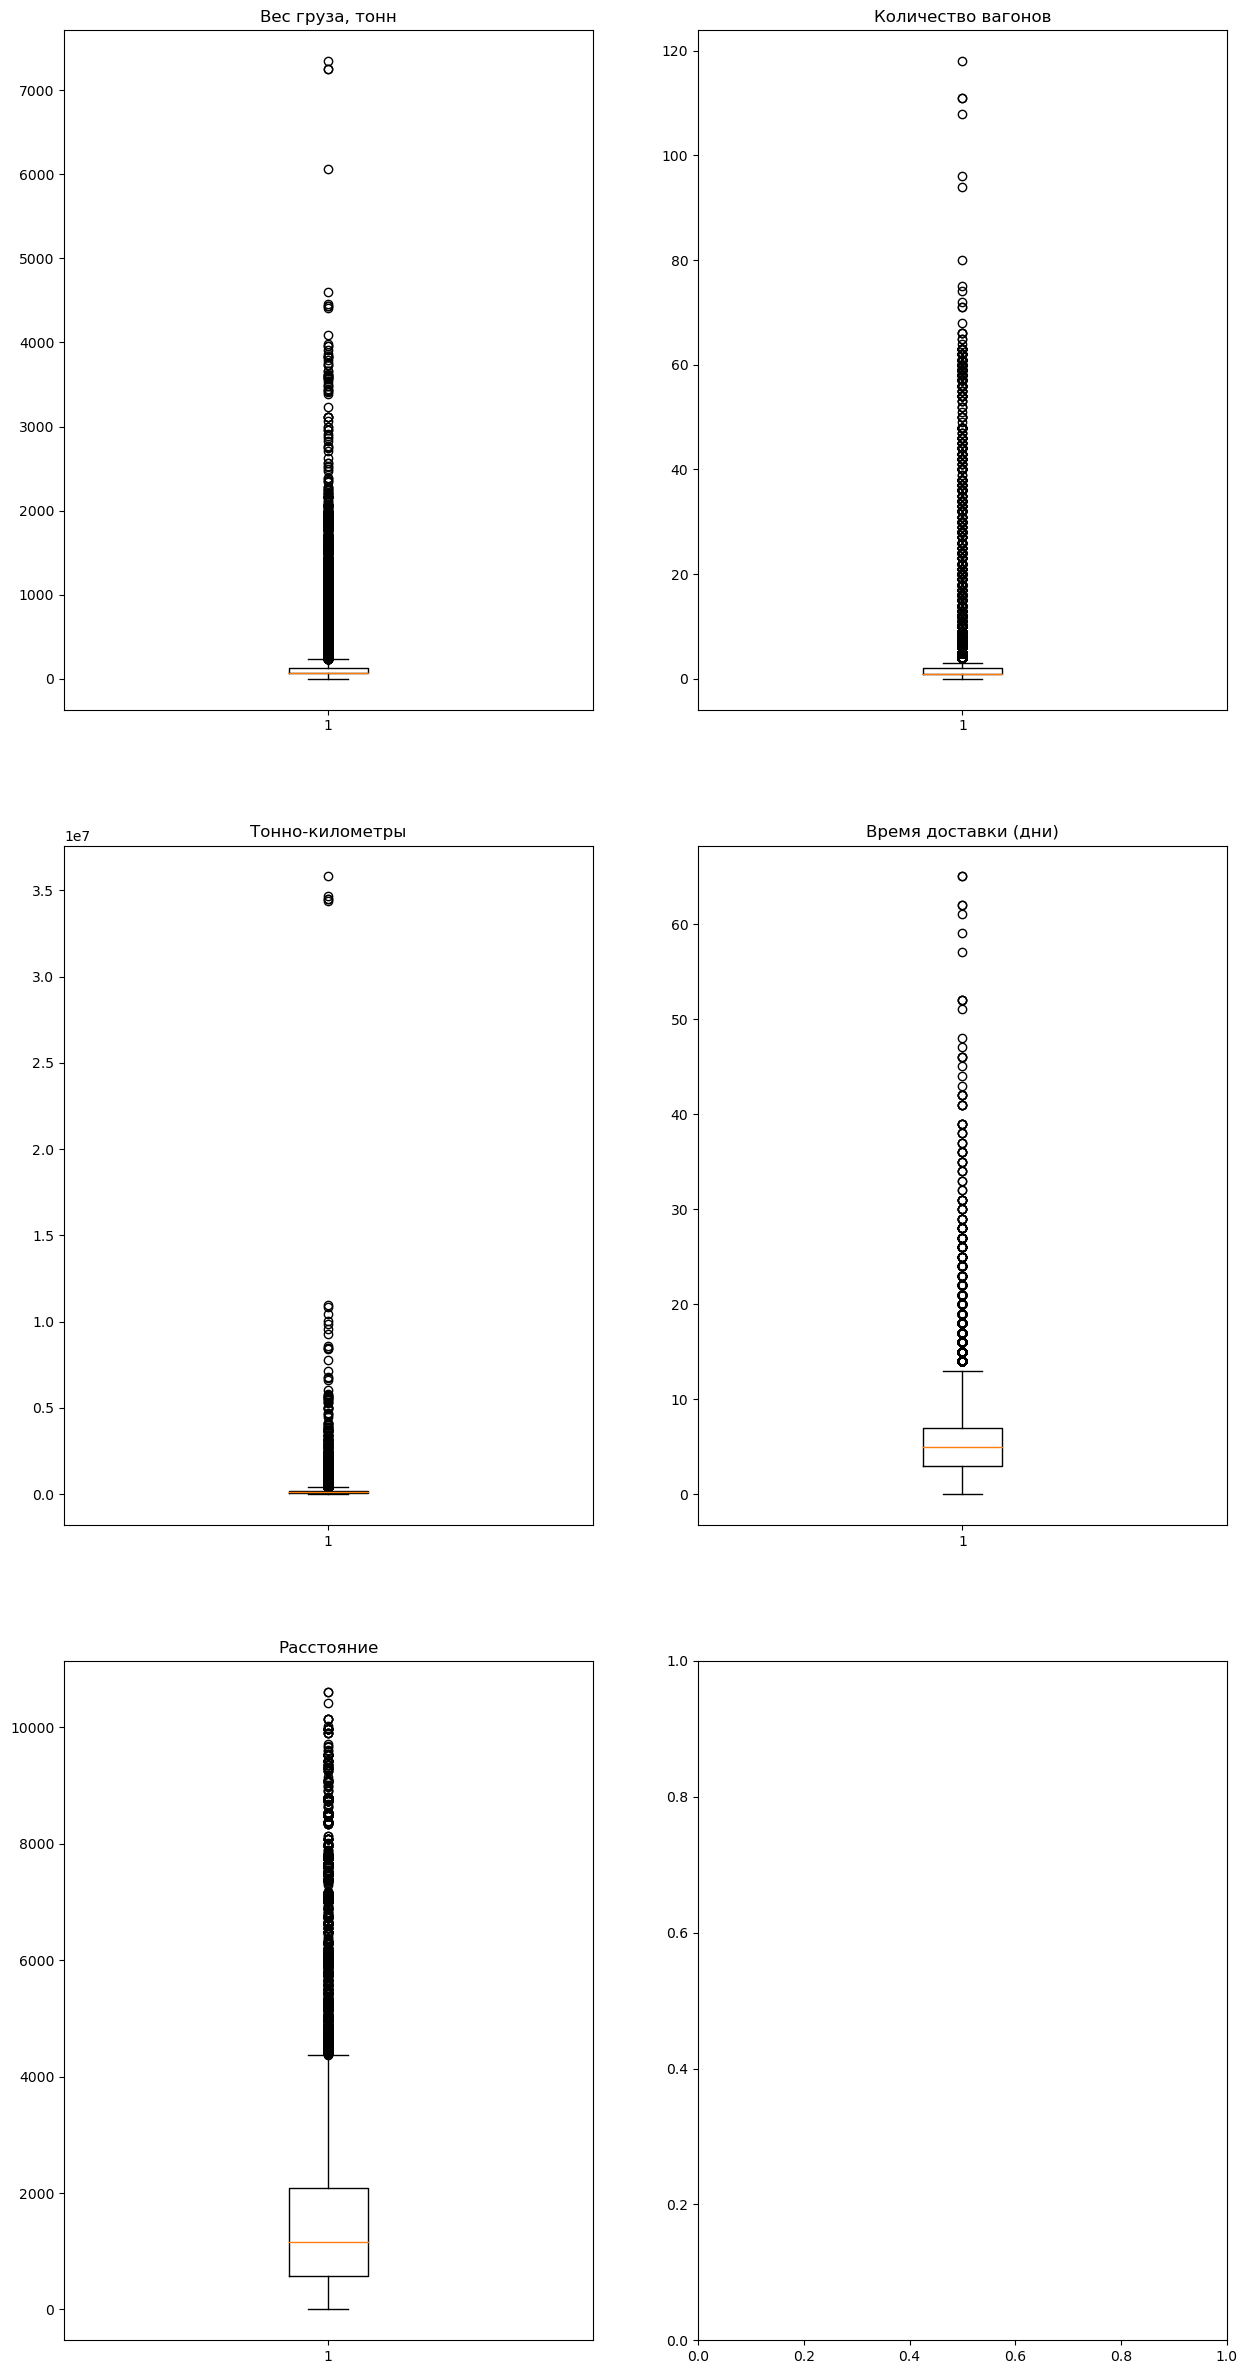

In [35]:
fig, axes = plt.subplots(3, 2, figsize=(15, 30))
axes[0, 0].boxplot(final_dataset['Вес груза, тонн'])
axes[0, 0].set_title('Вес груза, тонн')
axes[0, 1].boxplot(final_dataset['Количество вагонов'])
axes[0, 1].set_title('Количество вагонов')
axes[1, 0].boxplot(final_dataset['Тонно-километры'])
axes[1, 0].set_title('Тонно-километры')
axes[1, 1].boxplot(final_dataset['Время доставки (дни)'])
axes[1, 1].set_title('Время доставки (дни)')
axes[2, 0].boxplot(final_dataset['Расстояние'])
axes[2, 0].set_title('Расстояние')

In [36]:

final_dataset = final_dataset.drop(final_dataset[final_dataset['Время доставки (дни)'] > 21].index)

{'whiskers': [<matplotlib.lines.Line2D at 0x153912e5f90>,
 'caps': [<matplotlib.lines.Line2D at 0x153912e7390>,
 'boxes': [<matplotlib.lines.Line2D at 0x153912e5790>],
 'medians': [<matplotlib.lines.Line2D at 0x153912201d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x153912207d0>],
 'means': []}

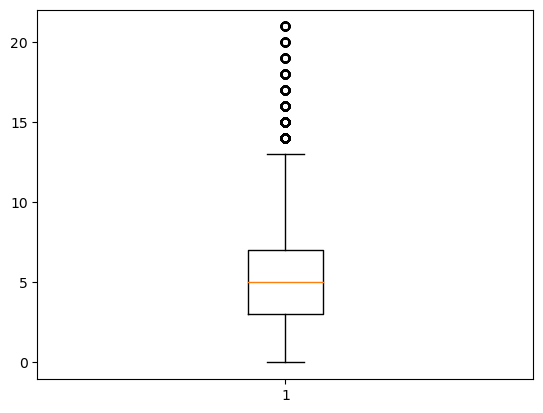

In [37]:
plt.boxplot(final_dataset['Время доставки (дни)'])

# Создание моделей

In [51]:
def draw_ROC(model, X, y):
    lr_probs = model.predict_proba(X)
    # сохраняем вероятности только для положительного исхода
    lr_probs = lr_probs[:, 1]
    # рассчитываем ROC AUC
    lr_auc = roc_auc_score(y, lr_probs)
    print('ROC AUC=%.3f' % (lr_auc))
    # рассчитываем roc-кривую
    fpr, tpr, treshold = roc_curve(y, lr_probs)
    roc_auc = auc(fpr, tpr)
    # строим график
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC кривая (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend(loc="lower right")
    plt.show()
    
def all_scores_test(y_pred, y):
    print(f'accuracy в тестовой выборке: {accuracy_score(y_pred, y)}')
    print(f'precision в тестовой выборке: {precision_score(y_pred, y)}')
    print(f'recall в тестовой выборке: {recall_score(y_pred, y)}')
    print(f'f1 в тестовой выборке: {f1_score(y_pred, y)}')
    
def all_cross_val_scores(model, X, y):
    acc = cross_val_score(model, X, y.values.ravel(), cv=StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42), scoring='accuracy').mean()
    print(f'Средняя accuracy в кросс-валидации: {acc}')
    prec = cross_val_score(model, X, y.values.ravel(), cv=StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42), scoring='precision').mean()
    print(f'Средняя precision в кросс-валидации: {prec}')
    rec = cross_val_score(model, X, y.values.ravel(), cv=StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42), scoring='recall').mean()
    print(f'Средняя recall в кросс-валидации: {rec}')
    f1 = cross_val_score(model, X, y.values.ravel(), cv=StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42), scoring='f1').mean()
    print(f'Средняя f1 в кросс-валидации: {f1}')

# Дерево решений

In [39]:
# Задаём признаки и целевую величину для обучения
features = ['Код станции отправления',
 'Код станции назначения',
 'Код Клиента',
 'Код отправителя груза',
 'Код получателя груза',
 'Код груза',
 'Вес груза, тонн',
 'Количество вагонов',
 'Тонно-километры',
 'Характер_перевозок_Экспорт',
 'Характер_перевозок_Внутр. пер',
 'Характер_перевозок_Импорт',
 'Характер_перевозок_Транзит',
 'Код страны отправления',
 'Код страны назначения',
 'Расстояние']
target = ['Доставка > 3 дней']

# Разделяем на обучающую и тестовую выборки

final_dataset.reset_index(drop=True, inplace=True)

X = final_dataset[features]
y = final_dataset[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .75, random_state=1024)

In [40]:
# Подбор гиперпараметров при помощи GridSearch
dtc_params = {
    'max_depth': list(range(1, len(features))),
    'min_samples_split':[2,4,5,10,15],
    'splitter': ['best', 'random'],
    'ccp_alpha':[0.1, 0.01, 0.001],
    'criterion':['gini', 'entropy']
}


dtc_gs = GridSearchCV(DecisionTreeClassifier(), 
                      dtc_params, 
                      cv=StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42), 
                      verbose=1, 
                      scoring='accuracy', 
                      n_jobs=-1)

In [41]:
start = dt.datetime.now()
dtc_gs.fit(X_train, y_train)
end = dt.datetime.now()
print(f'{start} -- {end}')

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
2023-12-25 18:35:29.099672 -- 2023-12-25 18:36:12.640766


In [42]:
print('best parameters')
print(dtc_gs.best_params_)
print('best score achieved')
print(dtc_gs.best_score_)

best parameters
{'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5, 'splitter': 'best'}
best score achieved
0.8862274805633588


In [43]:
best_dtc = dtc_gs.best_estimator_

In [44]:
# Deriving accuracy score on test set.
y_pred = best_dtc.predict(X_test)
print ('accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred)))

accuracy = 0.8810578787039601


In [45]:
# Deriving accuracy score alternative?
best_dtc.score(X_test, y_test)

0.8810578787039601

In [46]:
best_dtc

DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=10,
                       min_samples_split=5)

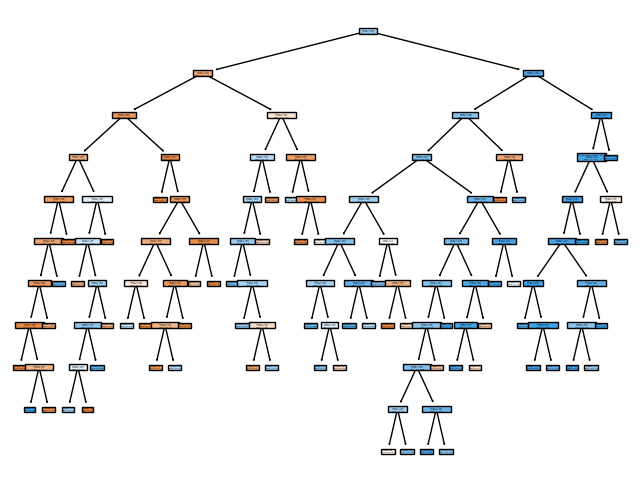

In [47]:
plt.figure(figsize=(8, 6))
plot_tree(best_dtc, feature_names=features, filled=True);

# Тестирование дерева решений

# Проверка модели на обучающей выборке

Точность на обучающей выборке: 0.8947198375334625


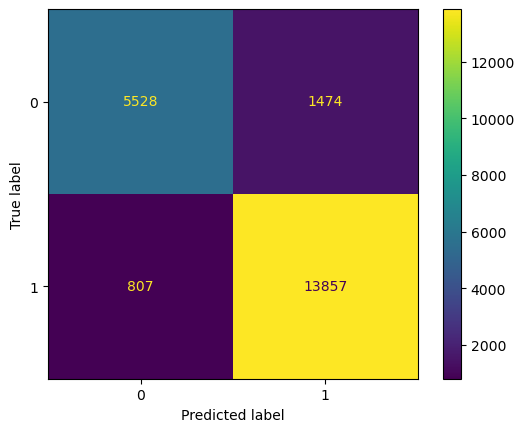

In [48]:
y_pred_train = best_dtc.predict(X_train)
print (f'Точность на обучающей выборке: {metrics.accuracy_score(y_train, y_pred_train)}')
сmm = confusion_matrix(y_train, y_pred_train, labels=best_dtc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=сmm, display_labels=best_dtc.classes_)
disp.plot()
plt.show()

ROC AUC=0.952


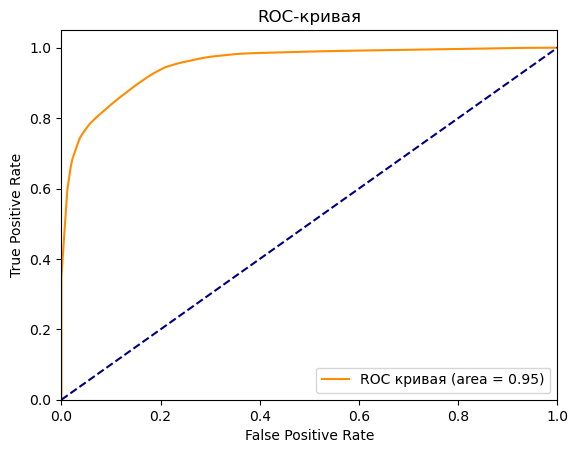

In [49]:
draw_ROC(best_dtc, X_train, y_train)

# Проверка модели на тестовой выборке

accuracy в тестовой выборке: 0.8810578787039601
precision в тестовой выборке: 0.9382334774552192
recall в тестовой выборке: 0.8907349491790462
f1 в тестовой выборке: 0.9138674420936529


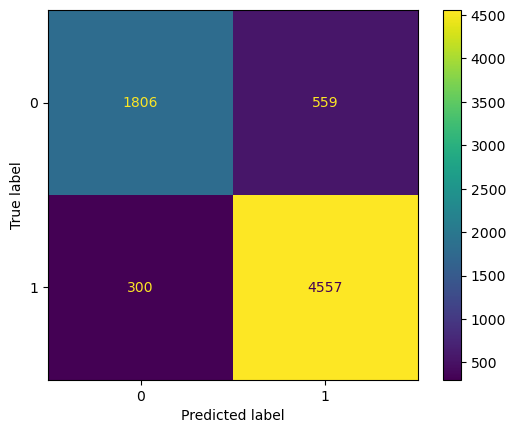

In [52]:
y_pred_test = best_dtc.predict(X_test)
#print (f'Точность на тестовой выборке: {metrics.accuracy_score(y_test, y_pred_test)}')
all_scores_test(y_pred_test, y_test)
сmm = confusion_matrix(y_test, y_pred_test, labels=best_dtc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=сmm, display_labels=best_dtc.classes_)
disp.plot()
plt.show()

ROC AUC=0.944


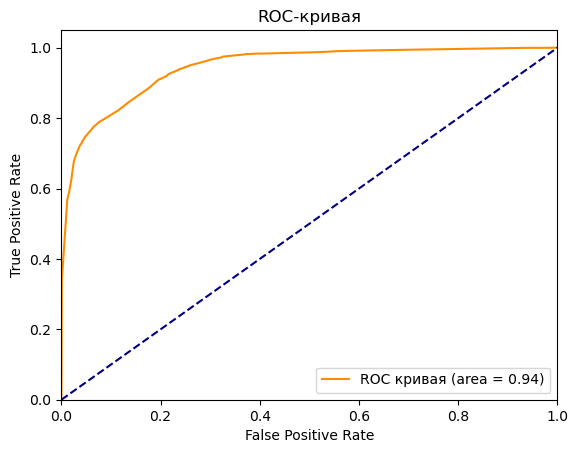

In [53]:
draw_ROC(best_dtc, X_test, y_test)

# Проверка модели в кросс-валидации

Средняя accuracy в кросс-валидации: 0.8834808146096236
Средняя precision в кросс-валидации: 0.9049957493233205
Средняя recall в кросс-валидации: 0.9246964527041207
Средняя f1 в кросс-валидации: 0.9146781457590478


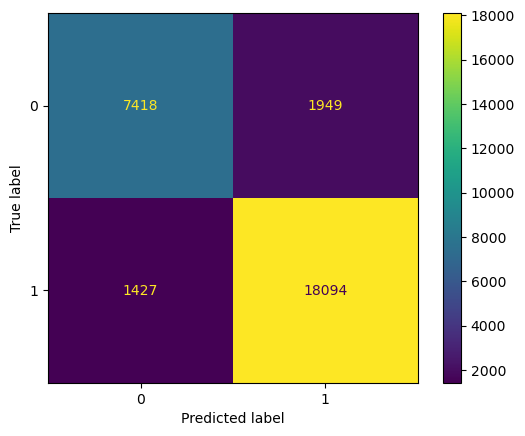

In [54]:
all_cross_val_scores(best_dtc, X, y)
y_pred = cross_val_predict(best_dtc, X, y, cv=StratifiedKFold(n_splits = 10, shuffle = True))
conf_mat = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=best_dtc.classes_)
disp.plot()
plt.show()

ROC AUC=0.949


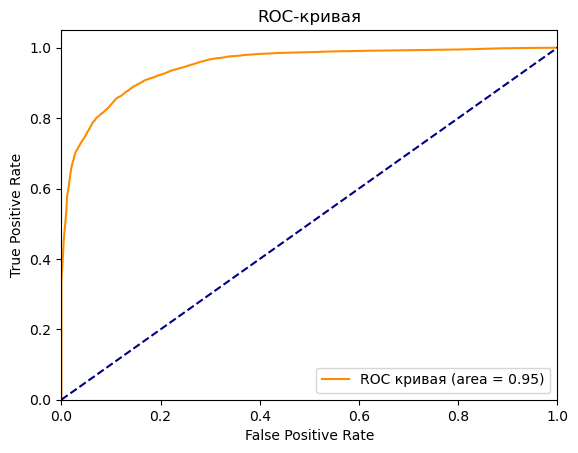

In [55]:
lr_probs = cross_val_predict(best_dtc, X, y.values.ravel(), cv=StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42), method='predict_proba')
lr_probs = lr_probs[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y, lr_probs)
print('ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y, lr_probs)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

# Модель случайный лес

In [56]:
def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    bootstrap = trial.suggest_categorical('bootstrap',[True, False])
    max_depth = trial.suggest_int('max_depth', 1, len(features))
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    n_estimators =  trial.suggest_int('n_estimators', 30, 1000)
    ccp_alpha = trial.suggest_float('ccp_alpha', 0.001, 0.1)
    
    rfc = RandomForestClassifier(bootstrap = bootstrap, criterion = criterion,
                                 max_depth = max_depth, max_features = max_features,
                                 max_leaf_nodes = max_leaf_nodes,n_estimators = n_estimators,
                                 ccp_alpha = ccp_alpha,n_jobs=2)
    
    score = cross_val_score(rfc, X_train, y_train.values.ravel(), cv=5, scoring="accuracy")
    acc_mean = score.mean()

    return acc_mean

#Запуск библиотеки Optuna и подбор гиперпараметров
start = dt.datetime.now()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
end = dt.datetime.now()

print(f'Старт -- Конец подбора параметров {start} -- {end}')

#Создаём модель с лучшими параметрами
best_rfc = RandomForestClassifier(bootstrap = study.best_params['bootstrap'], criterion = study.best_params['criterion'],
                                     max_depth = study.best_params['max_depth'], max_features = study.best_params['max_features'],
                                     max_leaf_nodes = study.best_params['max_leaf_nodes'],n_estimators = study.best_params['n_estimators'],
                                     ccp_alpha = study.best_params['ccp_alpha'], n_jobs=2)

best_rfc.fit(X_train ,y_train.values.ravel())

[I 2023-12-25 18:47:06,193] A new study created in memory with name: no-name-d127d8ee-f574-4573-bc53-ba9da606ecfa
[W 2023-12-25 18:47:08,177] Trial 0 failed with parameters: {'criterion': 'gini', 'bootstrap': True, 'max_depth': 9, 'max_features': 'log2', 'max_leaf_nodes': 9036, 'n_estimators': 819, 'ccp_alpha': 0.0081216284166154} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "E:\Anaconda\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\patap\AppData\Local\Temp\ipykernel_8668\3393228636.py", line 16, in objective
    score = cross_val_score(rfc, X_train, y_train.values.ravel(), cv=5, scoring="accuracy")
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "E:\Anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 562, in cross_val_score
    cv_results = cross_validate(
 

KeyboardInterrupt: 

In [57]:
# Код рандомного леса, если не хочется ждать подбор параметров
best_params = {'criterion': 'log_loss', 'bootstrap': True, 'max_depth': 16, 'max_features': 'sqrt', 'max_leaf_nodes': 3018, 'n_estimators': 820, 'ccp_alpha': 0.0010672782752820303}
best_rfc = RandomForestClassifier(**best_params)
best_rfc.fit(X_train ,y_train.values.ravel())

RandomForestClassifier(ccp_alpha=0.0010672782752820303, criterion='log_loss',
                       max_depth=16, max_leaf_nodes=3018, n_estimators=820)

# Тестирование случайного леса

# Проверка на обучающей выборке

Точность модели на обучающей выборке: 0.8905197082987168 



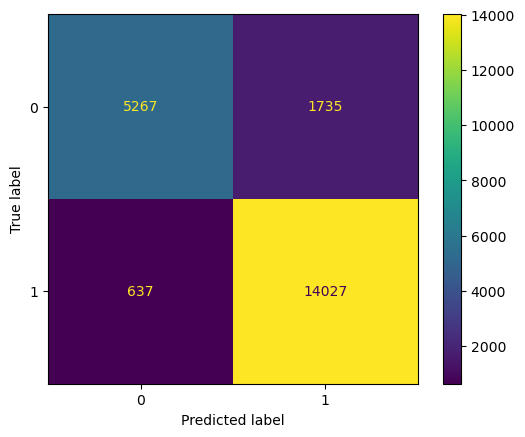

In [58]:
y_pred_train = best_rfc.predict(X_train)
print("Точность модели на обучающей выборке:", metrics.accuracy_score(y_train, y_pred_train),'\n')
сmm = confusion_matrix(y_train, y_pred_train, labels=best_rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=сmm, display_labels=best_rfc.classes_)
disp.plot()
plt.show()

ROC AUC=0.959


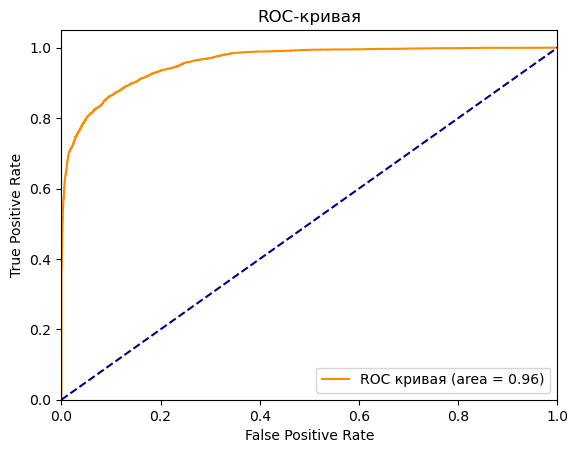

In [59]:
draw_ROC(best_rfc, X_train, y_train)

# Проверка на тестовой выборке

accuracy в тестовой выборке: 0.8816117418997508
precision в тестовой выборке: 0.9565575458101709
recall в тестовой выборке: 0.8782608695652174
f1 в тестовой выборке: 0.9157386419631418


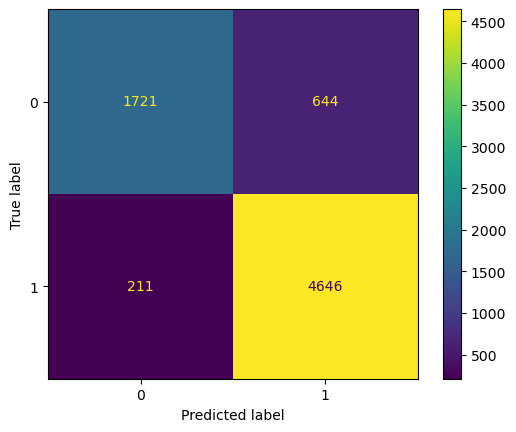

In [60]:
y_pred_test = best_rfc.predict(X_test)
#print("Точность модели на тестовой выборке:", metrics.accuracy_score(y_test, y_pred_test),'\n')
all_scores_test(y_pred_test, y_test)
сmm = confusion_matrix(y_test, y_pred_test, labels=best_rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=сmm, display_labels=best_rfc.classes_)
disp.plot()
plt.show()

ROC AUC=0.950


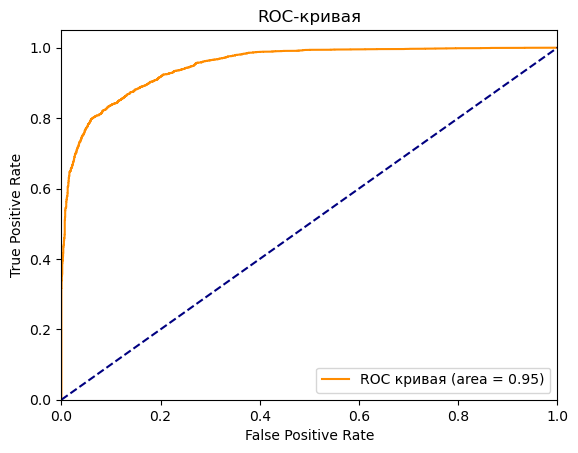

In [61]:
draw_ROC(best_rfc, X_test, y_test)

# Проверка в кросс-валидации

Средняя accuracy в кросс-валидации: 0.8816803804477582
Средняя precision в кросс-валидации: 0.88293780022133
Средняя recall в кросс-валидации: 0.9525123968589728
Средняя f1 в кросс-валидации: 0.9157824265359282


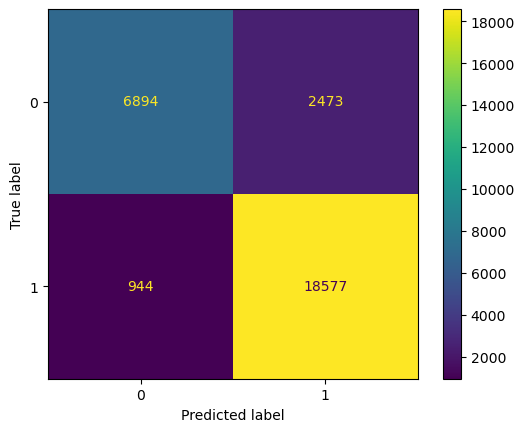

In [62]:
all_cross_val_scores(best_rfc, X, y)
y_pred = cross_val_predict(best_rfc, X, y.values.ravel(), cv=StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42))
rfc_conf_mat = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=rfc_conf_mat, display_labels=best_rfc.classes_)
disp.plot()
plt.show()

ROC AUC=0.952


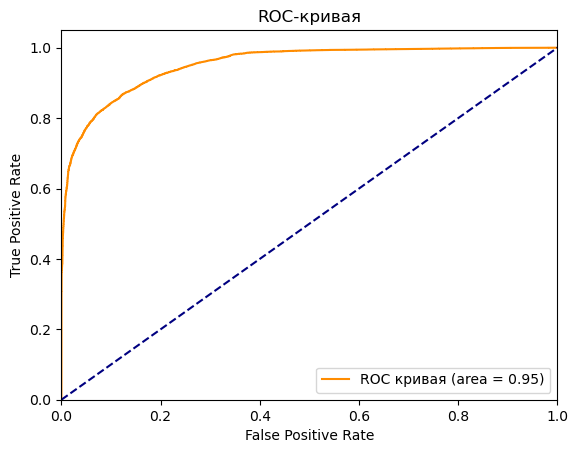

In [63]:
lr_probs = cross_val_predict(best_rfc, X, y.values.ravel(), cv=StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42), method='predict_proba')
lr_probs = lr_probs[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y, lr_probs)
print('ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y, lr_probs)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

# Градиентный бустинг при помощи CatBoost

In [64]:
def objective(trial):
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
        depth=trial.suggest_int("depth", 4, 10)
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True)
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"])
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True)
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0)
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"])
        od_wait=trial.suggest_int("od_wait", 10, 50)
        verbose=False
        
        cbc = CatBoostClassifier(iterations = iterations[0], learning_rate = learning_rate, depth = depth,
                                l2_leaf_reg = l2_leaf_reg, bootstrap_type = bootstrap_type, random_strength = random_strength,
                                bagging_temperature = bagging_temperature, od_type = od_type, od_wait = od_wait, verbose = verbose)
        score = cross_val_score(cbc, X_train, y_train.values.ravel(), cv=5, scoring="accuracy")
        acc_mean = score.mean()

        return acc_mean

#Запуск библиотеки Optuna и подбор гиперпараметров
start = dt.datetime.now()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
end = dt.datetime.now()

print(f'Старт -- Конец подбора параметров {start} -- {end}')

#Создаём модель с лучшими параметрами
best_cbc = CatBoostClassifier(iterations = study.best_params['iterations'], learning_rate = study.best_params['learning_rate'],
                                     depth = study.best_params['depth'], l2_leaf_reg = study.best_params['l2_leaf_reg'],
                                     bootstrap_type = study.best_params['bootstrap_type'],random_strength = study.best_params['random_strength'],
                                     bagging_temperature = study.best_params['bagging_temperature'], od_type = study.best_params['od_type'],
                                     od_wait = study.best_params['od_wait'])

best_cbc.fit(X_train ,y_train.values.ravel())

[I 2023-12-25 20:37:10,345] A new study created in memory with name: no-name-070e619d-781f-49a5-ae05-8c23a648082f
[W 2023-12-25 20:37:12,255] Trial 0 failed with parameters: {'iterations': 946, 'learning_rate': 0.004036499318392183, 'depth': 10, 'l2_leaf_reg': 5.196904254538663e-06, 'bootstrap_type': 'Bayesian', 'random_strength': 4.427280905123295e-06, 'bagging_temperature': 3.9689908882582148, 'od_type': 'IncToDec', 'od_wait': 23} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "E:\Anaconda\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\patap\AppData\Local\Temp\ipykernel_8668\2907707313.py", line 17, in objective
    score = cross_val_score(cbc, X_train, y_train.values.ravel(), cv=5, scoring="accuracy")
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "E:\Anaconda\Lib\site-package

KeyboardInterrupt: 

In [65]:
# Код чтобы не ждать подбор параметров
best_cbc_params = {'iterations': 576, 'learning_rate': 0.04364987554690631, 'depth': 6, 'l2_leaf_reg': 2.3164949256361972e-08, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0031464826103260466, 'bagging_temperature': 0.4720430386966159, 'od_type': 'Iter', 'od_wait': 42}
best_cbc = CatBoostClassifier(**best_cbc_params)
best_cbc.fit(X_train ,y_train.values.ravel())

0:	learn: 0.6512133	total: 8.24ms	remaining: 4.74s
1:	learn: 0.6141653	total: 15.8ms	remaining: 4.53s
2:	learn: 0.5813438	total: 23.3ms	remaining: 4.45s
3:	learn: 0.5524393	total: 30.8ms	remaining: 4.4s
4:	learn: 0.5258946	total: 37.8ms	remaining: 4.32s
5:	learn: 0.5023886	total: 45ms	remaining: 4.28s
6:	learn: 0.4814683	total: 50.8ms	remaining: 4.13s
7:	learn: 0.4649915	total: 57.8ms	remaining: 4.1s
8:	learn: 0.4500809	total: 64.5ms	remaining: 4.06s
9:	learn: 0.4359499	total: 71.8ms	remaining: 4.06s
10:	learn: 0.4234893	total: 78.5ms	remaining: 4.03s
11:	learn: 0.4074254	total: 85.2ms	remaining: 4s
12:	learn: 0.3975626	total: 92.3ms	remaining: 4s
13:	learn: 0.3878417	total: 99.1ms	remaining: 3.98s
14:	learn: 0.3805182	total: 105ms	remaining: 3.94s
15:	learn: 0.3680759	total: 112ms	remaining: 3.92s
16:	learn: 0.3625890	total: 119ms	remaining: 3.9s
17:	learn: 0.3570792	total: 126ms	remaining: 3.89s
18:	learn: 0.3522054	total: 132ms	remaining: 3.87s
19:	learn: 0.3477041	total: 139ms	rema

179:	learn: 0.2205115	total: 1.23s	remaining: 2.7s
180:	learn: 0.2203471	total: 1.24s	remaining: 2.7s
181:	learn: 0.2201127	total: 1.24s	remaining: 2.69s
182:	learn: 0.2199547	total: 1.25s	remaining: 2.69s
183:	learn: 0.2196789	total: 1.26s	remaining: 2.68s
184:	learn: 0.2195198	total: 1.26s	remaining: 2.67s
185:	learn: 0.2194042	total: 1.27s	remaining: 2.67s
186:	learn: 0.2190457	total: 1.28s	remaining: 2.66s
187:	learn: 0.2188480	total: 1.28s	remaining: 2.65s
188:	learn: 0.2186501	total: 1.29s	remaining: 2.65s
189:	learn: 0.2185266	total: 1.3s	remaining: 2.64s
190:	learn: 0.2182699	total: 1.31s	remaining: 2.63s
191:	learn: 0.2181611	total: 1.31s	remaining: 2.63s
192:	learn: 0.2179553	total: 1.32s	remaining: 2.62s
193:	learn: 0.2176992	total: 1.33s	remaining: 2.61s
194:	learn: 0.2174354	total: 1.33s	remaining: 2.61s
195:	learn: 0.2171007	total: 1.34s	remaining: 2.6s
196:	learn: 0.2167923	total: 1.35s	remaining: 2.59s
197:	learn: 0.2165874	total: 1.35s	remaining: 2.59s
198:	learn: 0.21

353:	learn: 0.1910772	total: 2.46s	remaining: 1.54s
354:	learn: 0.1909009	total: 2.47s	remaining: 1.54s
355:	learn: 0.1908178	total: 2.48s	remaining: 1.53s
356:	learn: 0.1906807	total: 2.48s	remaining: 1.52s
357:	learn: 0.1904742	total: 2.49s	remaining: 1.52s
358:	learn: 0.1904082	total: 2.5s	remaining: 1.51s
359:	learn: 0.1903133	total: 2.51s	remaining: 1.5s
360:	learn: 0.1902161	total: 2.51s	remaining: 1.5s
361:	learn: 0.1900878	total: 2.52s	remaining: 1.49s
362:	learn: 0.1900355	total: 2.53s	remaining: 1.48s
363:	learn: 0.1899194	total: 2.53s	remaining: 1.48s
364:	learn: 0.1897235	total: 2.54s	remaining: 1.47s
365:	learn: 0.1895651	total: 2.55s	remaining: 1.46s
366:	learn: 0.1894895	total: 2.56s	remaining: 1.46s
367:	learn: 0.1893568	total: 2.56s	remaining: 1.45s
368:	learn: 0.1892428	total: 2.57s	remaining: 1.44s
369:	learn: 0.1891130	total: 2.58s	remaining: 1.43s
370:	learn: 0.1890457	total: 2.58s	remaining: 1.43s
371:	learn: 0.1889098	total: 2.59s	remaining: 1.42s
372:	learn: 0.1

528:	learn: 0.1718435	total: 3.68s	remaining: 327ms
529:	learn: 0.1717383	total: 3.69s	remaining: 320ms
530:	learn: 0.1716796	total: 3.69s	remaining: 313ms
531:	learn: 0.1715763	total: 3.7s	remaining: 306ms
532:	learn: 0.1715450	total: 3.71s	remaining: 299ms
533:	learn: 0.1714761	total: 3.71s	remaining: 292ms
534:	learn: 0.1714120	total: 3.72s	remaining: 285ms
535:	learn: 0.1713174	total: 3.73s	remaining: 278ms
536:	learn: 0.1711858	total: 3.73s	remaining: 271ms
537:	learn: 0.1711228	total: 3.74s	remaining: 264ms
538:	learn: 0.1710258	total: 3.75s	remaining: 257ms
539:	learn: 0.1709169	total: 3.76s	remaining: 250ms
540:	learn: 0.1708412	total: 3.76s	remaining: 243ms
541:	learn: 0.1707902	total: 3.77s	remaining: 236ms
542:	learn: 0.1707143	total: 3.78s	remaining: 229ms
543:	learn: 0.1705912	total: 3.78s	remaining: 222ms
544:	learn: 0.1704668	total: 3.79s	remaining: 216ms
545:	learn: 0.1703630	total: 3.8s	remaining: 209ms
546:	learn: 0.1703051	total: 3.8s	remaining: 202ms
547:	learn: 0.1

# Тестирование CatBoost

# Проверка на обучающей выборке

Точность модели на обучающей выборке: 0.9316440505861718 



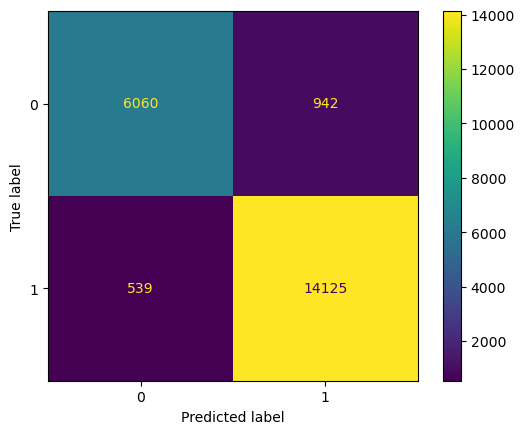

In [66]:
y_pred_train = best_cbc.predict(X_train)
print("Точность модели на обучающей выборке:", metrics.accuracy_score(y_train, y_pred_train),'\n')
сmm = confusion_matrix(y_train, y_pred_train, labels=best_cbc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=сmm, display_labels=best_cbc.classes_)
disp.plot()
plt.show()

ROC AUC=0.983


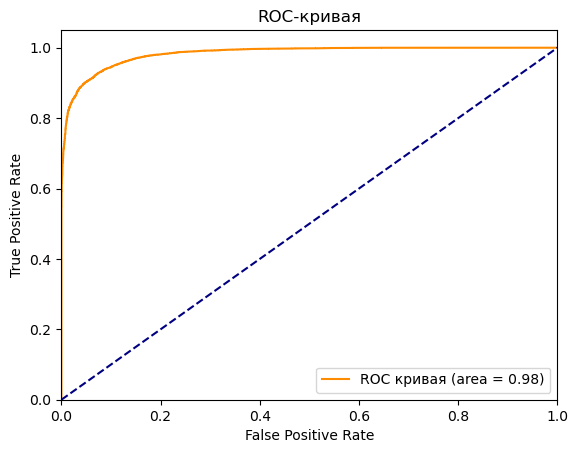

In [67]:
draw_ROC(best_cbc, X_train, y_train)

# Проверка на тестовой выборке

accuracy в тестовой выборке: 0.90473553032401
precision в тестовой выборке: 0.9483220094708668
recall в тестовой выборке: 0.9133452310132858
f1 в тестовой выборке: 0.9305050505050506


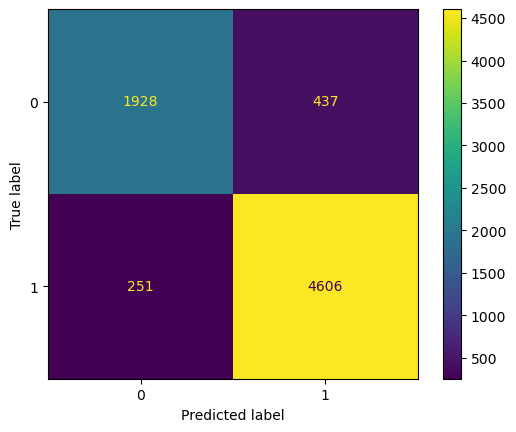

In [70]:
y_pred_test = best_cbc.predict(X_test)
#print("Точность модели на обучающей выборке:", metrics.accuracy_score(y_test, y_pred_test),'\n')
all_scores_test(y_pred_test, y_test)
сmm = confusion_matrix(y_test, y_pred_test, labels=best_cbc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=сmm, display_labels=best_cbc.classes_)
disp.plot()
plt.show()

ROC AUC=0.965


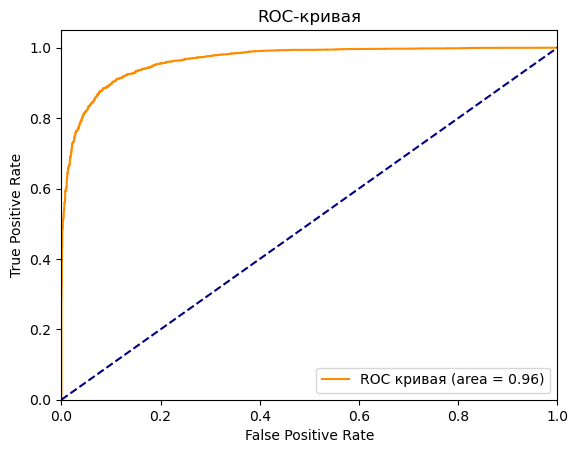

In [71]:
draw_ROC(best_cbc, X_test, y_test)

# Проверка в кросс-валидации

0:	learn: 0.6518820	total: 9.07ms	remaining: 5.21s
1:	learn: 0.6152814	total: 18ms	remaining: 5.17s
2:	learn: 0.5835549	total: 25.1ms	remaining: 4.8s
3:	learn: 0.5486513	total: 33.4ms	remaining: 4.78s
4:	learn: 0.5233810	total: 41ms	remaining: 4.68s
5:	learn: 0.5024728	total: 49.2ms	remaining: 4.68s
6:	learn: 0.4823586	total: 57.1ms	remaining: 4.64s
7:	learn: 0.4653964	total: 65.2ms	remaining: 4.63s
8:	learn: 0.4511672	total: 72.7ms	remaining: 4.58s
9:	learn: 0.4378909	total: 80.9ms	remaining: 4.58s
10:	learn: 0.4242908	total: 88.3ms	remaining: 4.54s
11:	learn: 0.4132674	total: 96.8ms	remaining: 4.55s
12:	learn: 0.4036974	total: 103ms	remaining: 4.47s
13:	learn: 0.3917807	total: 111ms	remaining: 4.46s
14:	learn: 0.3839880	total: 119ms	remaining: 4.44s
15:	learn: 0.3760341	total: 126ms	remaining: 4.42s
16:	learn: 0.3693832	total: 134ms	remaining: 4.41s
17:	learn: 0.3636357	total: 141ms	remaining: 4.37s
18:	learn: 0.3576645	total: 149ms	remaining: 4.37s
19:	learn: 0.3506071	total: 156ms	

163:	learn: 0.2291428	total: 1.25s	remaining: 3.13s
164:	learn: 0.2289055	total: 1.25s	remaining: 3.13s
165:	learn: 0.2287435	total: 1.26s	remaining: 3.12s
166:	learn: 0.2285683	total: 1.27s	remaining: 3.11s
167:	learn: 0.2284128	total: 1.28s	remaining: 3.11s
168:	learn: 0.2281516	total: 1.29s	remaining: 3.1s
169:	learn: 0.2279867	total: 1.3s	remaining: 3.1s
170:	learn: 0.2277955	total: 1.3s	remaining: 3.09s
171:	learn: 0.2274782	total: 1.31s	remaining: 3.08s
172:	learn: 0.2273513	total: 1.32s	remaining: 3.08s
173:	learn: 0.2271666	total: 1.33s	remaining: 3.07s
174:	learn: 0.2269102	total: 1.34s	remaining: 3.06s
175:	learn: 0.2267521	total: 1.34s	remaining: 3.06s
176:	learn: 0.2266178	total: 1.35s	remaining: 3.05s
177:	learn: 0.2262953	total: 1.36s	remaining: 3.04s
178:	learn: 0.2261934	total: 1.37s	remaining: 3.03s
179:	learn: 0.2259845	total: 1.38s	remaining: 3.03s
180:	learn: 0.2257911	total: 1.38s	remaining: 3.02s
181:	learn: 0.2256372	total: 1.39s	remaining: 3.01s
182:	learn: 0.22

323:	learn: 0.2027022	total: 2.49s	remaining: 1.94s
324:	learn: 0.2026376	total: 2.5s	remaining: 1.93s
325:	learn: 0.2025069	total: 2.51s	remaining: 1.92s
326:	learn: 0.2024111	total: 2.52s	remaining: 1.92s
327:	learn: 0.2022371	total: 2.52s	remaining: 1.91s
328:	learn: 0.2021184	total: 2.53s	remaining: 1.9s
329:	learn: 0.2019639	total: 2.54s	remaining: 1.89s
330:	learn: 0.2018724	total: 2.55s	remaining: 1.89s
331:	learn: 0.2017208	total: 2.55s	remaining: 1.88s
332:	learn: 0.2016163	total: 2.56s	remaining: 1.87s
333:	learn: 0.2015332	total: 2.57s	remaining: 1.86s
334:	learn: 0.2013429	total: 2.58s	remaining: 1.85s
335:	learn: 0.2012056	total: 2.58s	remaining: 1.84s
336:	learn: 0.2010924	total: 2.59s	remaining: 1.84s
337:	learn: 0.2010015	total: 2.6s	remaining: 1.83s
338:	learn: 0.2007870	total: 2.6s	remaining: 1.82s
339:	learn: 0.2006562	total: 2.61s	remaining: 1.81s
340:	learn: 0.2005617	total: 2.62s	remaining: 1.8s
341:	learn: 0.2004268	total: 2.62s	remaining: 1.79s
342:	learn: 0.200

491:	learn: 0.1850514	total: 3.7s	remaining: 632ms
492:	learn: 0.1849520	total: 3.71s	remaining: 624ms
493:	learn: 0.1848959	total: 3.71s	remaining: 617ms
494:	learn: 0.1848278	total: 3.72s	remaining: 609ms
495:	learn: 0.1847181	total: 3.73s	remaining: 602ms
496:	learn: 0.1846345	total: 3.73s	remaining: 594ms
497:	learn: 0.1845121	total: 3.75s	remaining: 587ms
498:	learn: 0.1844262	total: 3.75s	remaining: 579ms
499:	learn: 0.1843484	total: 3.76s	remaining: 572ms
500:	learn: 0.1842417	total: 3.77s	remaining: 564ms
501:	learn: 0.1841663	total: 3.78s	remaining: 557ms
502:	learn: 0.1840985	total: 3.78s	remaining: 549ms
503:	learn: 0.1840378	total: 3.79s	remaining: 542ms
504:	learn: 0.1839609	total: 3.8s	remaining: 534ms
505:	learn: 0.1838618	total: 3.81s	remaining: 526ms
506:	learn: 0.1837502	total: 3.81s	remaining: 519ms
507:	learn: 0.1836699	total: 3.82s	remaining: 511ms
508:	learn: 0.1835969	total: 3.83s	remaining: 504ms
509:	learn: 0.1835036	total: 3.83s	remaining: 496ms
510:	learn: 0.

87:	learn: 0.2549892	total: 717ms	remaining: 3.97s
88:	learn: 0.2545485	total: 725ms	remaining: 3.96s
89:	learn: 0.2540881	total: 732ms	remaining: 3.95s
90:	learn: 0.2535588	total: 740ms	remaining: 3.94s
91:	learn: 0.2530592	total: 748ms	remaining: 3.94s
92:	learn: 0.2526793	total: 756ms	remaining: 3.92s
93:	learn: 0.2523931	total: 763ms	remaining: 3.91s
94:	learn: 0.2520103	total: 771ms	remaining: 3.9s
95:	learn: 0.2515469	total: 778ms	remaining: 3.89s
96:	learn: 0.2511426	total: 785ms	remaining: 3.88s
97:	learn: 0.2507389	total: 794ms	remaining: 3.87s
98:	learn: 0.2504036	total: 802ms	remaining: 3.86s
99:	learn: 0.2500415	total: 810ms	remaining: 3.85s
100:	learn: 0.2498176	total: 816ms	remaining: 3.84s
101:	learn: 0.2493957	total: 825ms	remaining: 3.83s
102:	learn: 0.2490841	total: 832ms	remaining: 3.82s
103:	learn: 0.2485379	total: 840ms	remaining: 3.81s
104:	learn: 0.2480754	total: 848ms	remaining: 3.8s
105:	learn: 0.2475785	total: 855ms	remaining: 3.79s
106:	learn: 0.2473122	total

246:	learn: 0.2143685	total: 1.96s	remaining: 2.61s
247:	learn: 0.2140292	total: 1.96s	remaining: 2.6s
248:	learn: 0.2138271	total: 1.97s	remaining: 2.59s
249:	learn: 0.2136899	total: 1.98s	remaining: 2.58s
250:	learn: 0.2135944	total: 1.99s	remaining: 2.57s
251:	learn: 0.2134887	total: 2s	remaining: 2.56s
252:	learn: 0.2131964	total: 2s	remaining: 2.56s
253:	learn: 0.2131268	total: 2.01s	remaining: 2.55s
254:	learn: 0.2130469	total: 2.02s	remaining: 2.54s
255:	learn: 0.2128695	total: 2.02s	remaining: 2.53s
256:	learn: 0.2127854	total: 2.03s	remaining: 2.52s
257:	learn: 0.2126356	total: 2.04s	remaining: 2.52s
258:	learn: 0.2124821	total: 2.05s	remaining: 2.51s
259:	learn: 0.2122816	total: 2.06s	remaining: 2.5s
260:	learn: 0.2121852	total: 2.06s	remaining: 2.49s
261:	learn: 0.2119922	total: 2.07s	remaining: 2.48s
262:	learn: 0.2119133	total: 2.08s	remaining: 2.48s
263:	learn: 0.2118007	total: 2.09s	remaining: 2.47s
264:	learn: 0.2117139	total: 2.09s	remaining: 2.46s
265:	learn: 0.211567

405:	learn: 0.1937886	total: 3.21s	remaining: 1.35s
406:	learn: 0.1937453	total: 3.22s	remaining: 1.34s
407:	learn: 0.1936367	total: 3.23s	remaining: 1.33s
408:	learn: 0.1935576	total: 3.24s	remaining: 1.32s
409:	learn: 0.1934490	total: 3.25s	remaining: 1.31s
410:	learn: 0.1933424	total: 3.25s	remaining: 1.31s
411:	learn: 0.1932242	total: 3.26s	remaining: 1.3s
412:	learn: 0.1931491	total: 3.27s	remaining: 1.29s
413:	learn: 0.1930474	total: 3.28s	remaining: 1.28s
414:	learn: 0.1929703	total: 3.29s	remaining: 1.27s
415:	learn: 0.1928838	total: 3.29s	remaining: 1.27s
416:	learn: 0.1927943	total: 3.3s	remaining: 1.26s
417:	learn: 0.1926578	total: 3.31s	remaining: 1.25s
418:	learn: 0.1925333	total: 3.32s	remaining: 1.24s
419:	learn: 0.1924564	total: 3.32s	remaining: 1.23s
420:	learn: 0.1923738	total: 3.33s	remaining: 1.23s
421:	learn: 0.1922015	total: 3.34s	remaining: 1.22s
422:	learn: 0.1920991	total: 3.35s	remaining: 1.21s
423:	learn: 0.1920227	total: 3.35s	remaining: 1.2s
424:	learn: 0.1

8:	learn: 0.4545681	total: 71.5ms	remaining: 4.5s
9:	learn: 0.4394090	total: 79.6ms	remaining: 4.5s
10:	learn: 0.4278761	total: 87.8ms	remaining: 4.51s
11:	learn: 0.4172553	total: 94.7ms	remaining: 4.45s
12:	learn: 0.4052269	total: 102ms	remaining: 4.42s
13:	learn: 0.3962250	total: 111ms	remaining: 4.47s
14:	learn: 0.3876061	total: 119ms	remaining: 4.44s
15:	learn: 0.3788448	total: 127ms	remaining: 4.45s
16:	learn: 0.3722725	total: 135ms	remaining: 4.44s
17:	learn: 0.3670636	total: 143ms	remaining: 4.43s
18:	learn: 0.3611656	total: 151ms	remaining: 4.42s
19:	learn: 0.3553461	total: 161ms	remaining: 4.47s
20:	learn: 0.3503372	total: 169ms	remaining: 4.47s
21:	learn: 0.3457315	total: 178ms	remaining: 4.48s
22:	learn: 0.3407918	total: 186ms	remaining: 4.46s
23:	learn: 0.3359810	total: 195ms	remaining: 4.47s
24:	learn: 0.3309416	total: 202ms	remaining: 4.46s
25:	learn: 0.3281053	total: 210ms	remaining: 4.45s
26:	learn: 0.3251031	total: 218ms	remaining: 4.43s
27:	learn: 0.3220432	total: 226

191:	learn: 0.2249914	total: 1.51s	remaining: 3.01s
192:	learn: 0.2248555	total: 1.51s	remaining: 3s
193:	learn: 0.2246732	total: 1.52s	remaining: 3s
194:	learn: 0.2243626	total: 1.53s	remaining: 2.99s
195:	learn: 0.2241955	total: 1.54s	remaining: 2.98s
196:	learn: 0.2240091	total: 1.55s	remaining: 2.98s
197:	learn: 0.2237313	total: 1.55s	remaining: 2.97s
198:	learn: 0.2235816	total: 1.56s	remaining: 2.96s
199:	learn: 0.2233795	total: 1.57s	remaining: 2.96s
200:	learn: 0.2231979	total: 1.58s	remaining: 2.95s
201:	learn: 0.2230777	total: 1.59s	remaining: 2.94s
202:	learn: 0.2228359	total: 1.59s	remaining: 2.93s
203:	learn: 0.2226394	total: 1.6s	remaining: 2.92s
204:	learn: 0.2223839	total: 1.61s	remaining: 2.91s
205:	learn: 0.2222431	total: 1.62s	remaining: 2.9s
206:	learn: 0.2220292	total: 1.62s	remaining: 2.9s
207:	learn: 0.2218548	total: 1.63s	remaining: 2.89s
208:	learn: 0.2217225	total: 1.64s	remaining: 2.88s
209:	learn: 0.2214966	total: 1.65s	remaining: 2.87s
210:	learn: 0.2213936

375:	learn: 0.1987349	total: 2.94s	remaining: 1.56s
376:	learn: 0.1986794	total: 2.95s	remaining: 1.56s
377:	learn: 0.1985866	total: 2.96s	remaining: 1.55s
378:	learn: 0.1984899	total: 2.96s	remaining: 1.54s
379:	learn: 0.1984407	total: 2.97s	remaining: 1.53s
380:	learn: 0.1982539	total: 2.98s	remaining: 1.52s
381:	learn: 0.1981735	total: 2.98s	remaining: 1.52s
382:	learn: 0.1981087	total: 2.99s	remaining: 1.51s
383:	learn: 0.1979404	total: 3s	remaining: 1.5s
384:	learn: 0.1978506	total: 3.01s	remaining: 1.49s
385:	learn: 0.1977347	total: 3.02s	remaining: 1.48s
386:	learn: 0.1976302	total: 3.02s	remaining: 1.48s
387:	learn: 0.1974574	total: 3.03s	remaining: 1.47s
388:	learn: 0.1973614	total: 3.04s	remaining: 1.46s
389:	learn: 0.1972689	total: 3.05s	remaining: 1.45s
390:	learn: 0.1971776	total: 3.05s	remaining: 1.45s
391:	learn: 0.1970619	total: 3.06s	remaining: 1.44s
392:	learn: 0.1969533	total: 3.07s	remaining: 1.43s
393:	learn: 0.1968474	total: 3.08s	remaining: 1.42s
394:	learn: 0.19

557:	learn: 0.1814729	total: 4.38s	remaining: 141ms
558:	learn: 0.1813655	total: 4.39s	remaining: 133ms
559:	learn: 0.1812766	total: 4.4s	remaining: 126ms
560:	learn: 0.1811907	total: 4.4s	remaining: 118ms
561:	learn: 0.1811474	total: 4.41s	remaining: 110ms
562:	learn: 0.1810817	total: 4.42s	remaining: 102ms
563:	learn: 0.1810417	total: 4.43s	remaining: 94.2ms
564:	learn: 0.1809549	total: 4.43s	remaining: 86.4ms
565:	learn: 0.1809016	total: 4.44s	remaining: 78.5ms
566:	learn: 0.1808492	total: 4.45s	remaining: 70.7ms
567:	learn: 0.1807829	total: 4.46s	remaining: 62.8ms
568:	learn: 0.1806716	total: 4.47s	remaining: 55ms
569:	learn: 0.1804659	total: 4.48s	remaining: 47.1ms
570:	learn: 0.1803927	total: 4.48s	remaining: 39.3ms
571:	learn: 0.1803305	total: 4.49s	remaining: 31.4ms
572:	learn: 0.1802662	total: 4.5s	remaining: 23.6ms
573:	learn: 0.1801663	total: 4.51s	remaining: 15.7ms
574:	learn: 0.1801253	total: 4.52s	remaining: 7.86ms
575:	learn: 0.1800380	total: 4.53s	remaining: 0us
0:	lear

157:	learn: 0.2290038	total: 1.25s	remaining: 3.32s
158:	learn: 0.2287523	total: 1.26s	remaining: 3.31s
159:	learn: 0.2285312	total: 1.27s	remaining: 3.3s
160:	learn: 0.2283227	total: 1.28s	remaining: 3.29s
161:	learn: 0.2280737	total: 1.28s	remaining: 3.28s
162:	learn: 0.2278929	total: 1.29s	remaining: 3.27s
163:	learn: 0.2277384	total: 1.3s	remaining: 3.26s
164:	learn: 0.2273062	total: 1.3s	remaining: 3.25s
165:	learn: 0.2270537	total: 1.31s	remaining: 3.25s
166:	learn: 0.2268634	total: 1.32s	remaining: 3.24s
167:	learn: 0.2266765	total: 1.33s	remaining: 3.23s
168:	learn: 0.2264647	total: 1.34s	remaining: 3.22s
169:	learn: 0.2262734	total: 1.34s	remaining: 3.21s
170:	learn: 0.2260971	total: 1.35s	remaining: 3.2s
171:	learn: 0.2258612	total: 1.36s	remaining: 3.19s
172:	learn: 0.2256768	total: 1.37s	remaining: 3.19s
173:	learn: 0.2255148	total: 1.38s	remaining: 3.18s
174:	learn: 0.2253130	total: 1.38s	remaining: 3.17s
175:	learn: 0.2250941	total: 1.39s	remaining: 3.16s
176:	learn: 0.22

332:	learn: 0.1992220	total: 2.68s	remaining: 1.96s
333:	learn: 0.1991134	total: 2.69s	remaining: 1.95s
334:	learn: 0.1990071	total: 2.7s	remaining: 1.94s
335:	learn: 0.1988419	total: 2.71s	remaining: 1.93s
336:	learn: 0.1987038	total: 2.71s	remaining: 1.92s
337:	learn: 0.1985445	total: 2.72s	remaining: 1.92s
338:	learn: 0.1984314	total: 2.73s	remaining: 1.91s
339:	learn: 0.1983537	total: 2.74s	remaining: 1.9s
340:	learn: 0.1982278	total: 2.75s	remaining: 1.89s
341:	learn: 0.1981281	total: 2.76s	remaining: 1.89s
342:	learn: 0.1980081	total: 2.76s	remaining: 1.88s
343:	learn: 0.1978775	total: 2.77s	remaining: 1.87s
344:	learn: 0.1977412	total: 2.78s	remaining: 1.86s
345:	learn: 0.1975780	total: 2.79s	remaining: 1.85s
346:	learn: 0.1974733	total: 2.79s	remaining: 1.84s
347:	learn: 0.1973991	total: 2.8s	remaining: 1.84s
348:	learn: 0.1972945	total: 2.81s	remaining: 1.83s
349:	learn: 0.1971637	total: 2.82s	remaining: 1.82s
350:	learn: 0.1971135	total: 2.83s	remaining: 1.81s
351:	learn: 0.1

507:	learn: 0.1811994	total: 4.13s	remaining: 552ms
508:	learn: 0.1811578	total: 4.13s	remaining: 544ms
509:	learn: 0.1811091	total: 4.14s	remaining: 536ms
510:	learn: 0.1810328	total: 4.15s	remaining: 528ms
511:	learn: 0.1809430	total: 4.16s	remaining: 520ms
512:	learn: 0.1808604	total: 4.17s	remaining: 512ms
513:	learn: 0.1807760	total: 4.18s	remaining: 504ms
514:	learn: 0.1806576	total: 4.18s	remaining: 496ms
515:	learn: 0.1805133	total: 4.19s	remaining: 488ms
516:	learn: 0.1804279	total: 4.2s	remaining: 479ms
517:	learn: 0.1803483	total: 4.21s	remaining: 471ms
518:	learn: 0.1803061	total: 4.22s	remaining: 463ms
519:	learn: 0.1802408	total: 4.22s	remaining: 455ms
520:	learn: 0.1801338	total: 4.23s	remaining: 447ms
521:	learn: 0.1800193	total: 4.24s	remaining: 439ms
522:	learn: 0.1799222	total: 4.25s	remaining: 431ms
523:	learn: 0.1798169	total: 4.26s	remaining: 422ms
524:	learn: 0.1797056	total: 4.26s	remaining: 414ms
525:	learn: 0.1795550	total: 4.27s	remaining: 406ms
526:	learn: 0

105:	learn: 0.2467698	total: 827ms	remaining: 3.67s
106:	learn: 0.2465414	total: 835ms	remaining: 3.66s
107:	learn: 0.2461962	total: 842ms	remaining: 3.65s
108:	learn: 0.2459302	total: 849ms	remaining: 3.64s
109:	learn: 0.2455220	total: 856ms	remaining: 3.63s
110:	learn: 0.2450290	total: 865ms	remaining: 3.62s
111:	learn: 0.2448332	total: 871ms	remaining: 3.61s
112:	learn: 0.2444862	total: 880ms	remaining: 3.6s
113:	learn: 0.2441953	total: 888ms	remaining: 3.6s
114:	learn: 0.2439066	total: 895ms	remaining: 3.59s
115:	learn: 0.2434791	total: 902ms	remaining: 3.58s
116:	learn: 0.2432512	total: 908ms	remaining: 3.56s
117:	learn: 0.2430138	total: 916ms	remaining: 3.56s
118:	learn: 0.2427031	total: 923ms	remaining: 3.54s
119:	learn: 0.2423153	total: 932ms	remaining: 3.54s
120:	learn: 0.2419557	total: 939ms	remaining: 3.53s
121:	learn: 0.2415640	total: 948ms	remaining: 3.53s
122:	learn: 0.2412093	total: 955ms	remaining: 3.52s
123:	learn: 0.2409159	total: 963ms	remaining: 3.51s
124:	learn: 0.

271:	learn: 0.2096400	total: 2.07s	remaining: 2.32s
272:	learn: 0.2095194	total: 2.08s	remaining: 2.31s
273:	learn: 0.2092867	total: 2.09s	remaining: 2.3s
274:	learn: 0.2091012	total: 2.1s	remaining: 2.3s
275:	learn: 0.2090004	total: 2.11s	remaining: 2.29s
276:	learn: 0.2088162	total: 2.11s	remaining: 2.28s
277:	learn: 0.2087341	total: 2.12s	remaining: 2.27s
278:	learn: 0.2085602	total: 2.13s	remaining: 2.27s
279:	learn: 0.2083353	total: 2.14s	remaining: 2.26s
280:	learn: 0.2080991	total: 2.15s	remaining: 2.25s
281:	learn: 0.2079315	total: 2.15s	remaining: 2.24s
282:	learn: 0.2078387	total: 2.16s	remaining: 2.24s
283:	learn: 0.2076369	total: 2.17s	remaining: 2.23s
284:	learn: 0.2074879	total: 2.17s	remaining: 2.22s
285:	learn: 0.2074019	total: 2.18s	remaining: 2.21s
286:	learn: 0.2072196	total: 2.19s	remaining: 2.21s
287:	learn: 0.2070817	total: 2.2s	remaining: 2.2s
288:	learn: 0.2069704	total: 2.21s	remaining: 2.19s
289:	learn: 0.2068485	total: 2.21s	remaining: 2.18s
290:	learn: 0.206

432:	learn: 0.1902200	total: 3.31s	remaining: 1.09s
433:	learn: 0.1900839	total: 3.32s	remaining: 1.08s
434:	learn: 0.1899955	total: 3.32s	remaining: 1.08s
435:	learn: 0.1899132	total: 3.33s	remaining: 1.07s
436:	learn: 0.1897634	total: 3.34s	remaining: 1.06s
437:	learn: 0.1896792	total: 3.35s	remaining: 1.05s
438:	learn: 0.1895814	total: 3.35s	remaining: 1.05s
439:	learn: 0.1894926	total: 3.36s	remaining: 1.04s
440:	learn: 0.1893771	total: 3.37s	remaining: 1.03s
441:	learn: 0.1892931	total: 3.38s	remaining: 1.02s
442:	learn: 0.1891994	total: 3.38s	remaining: 1.02s
443:	learn: 0.1891100	total: 3.39s	remaining: 1.01s
444:	learn: 0.1890312	total: 3.4s	remaining: 1s
445:	learn: 0.1889149	total: 3.41s	remaining: 993ms
446:	learn: 0.1888349	total: 3.42s	remaining: 986ms
447:	learn: 0.1886867	total: 3.42s	remaining: 978ms
448:	learn: 0.1886317	total: 3.43s	remaining: 970ms
449:	learn: 0.1885764	total: 3.44s	remaining: 963ms
450:	learn: 0.1884250	total: 3.44s	remaining: 955ms
451:	learn: 0.18

38:	learn: 0.2957627	total: 301ms	remaining: 4.14s
39:	learn: 0.2939650	total: 309ms	remaining: 4.14s
40:	learn: 0.2925419	total: 316ms	remaining: 4.12s
41:	learn: 0.2912110	total: 324ms	remaining: 4.12s
42:	learn: 0.2897967	total: 332ms	remaining: 4.11s
43:	learn: 0.2883393	total: 340ms	remaining: 4.11s
44:	learn: 0.2870292	total: 347ms	remaining: 4.09s
45:	learn: 0.2857672	total: 354ms	remaining: 4.07s
46:	learn: 0.2847685	total: 364ms	remaining: 4.09s
47:	learn: 0.2835933	total: 370ms	remaining: 4.08s
48:	learn: 0.2823990	total: 379ms	remaining: 4.07s
49:	learn: 0.2811440	total: 386ms	remaining: 4.06s
50:	learn: 0.2796575	total: 394ms	remaining: 4.06s
51:	learn: 0.2786860	total: 401ms	remaining: 4.04s
52:	learn: 0.2778119	total: 407ms	remaining: 4.02s
53:	learn: 0.2763154	total: 416ms	remaining: 4.02s
54:	learn: 0.2757346	total: 423ms	remaining: 4.01s
55:	learn: 0.2744791	total: 431ms	remaining: 4s
56:	learn: 0.2740095	total: 438ms	remaining: 3.99s
57:	learn: 0.2726351	total: 446ms	

203:	learn: 0.2220993	total: 1.55s	remaining: 2.82s
204:	learn: 0.2218793	total: 1.55s	remaining: 2.81s
205:	learn: 0.2216028	total: 1.56s	remaining: 2.81s
206:	learn: 0.2214048	total: 1.57s	remaining: 2.8s
207:	learn: 0.2210864	total: 1.58s	remaining: 2.8s
208:	learn: 0.2209313	total: 1.59s	remaining: 2.79s
209:	learn: 0.2207649	total: 1.6s	remaining: 2.78s
210:	learn: 0.2206887	total: 1.6s	remaining: 2.77s
211:	learn: 0.2203882	total: 1.61s	remaining: 2.77s
212:	learn: 0.2202679	total: 1.62s	remaining: 2.76s
213:	learn: 0.2201445	total: 1.63s	remaining: 2.75s
214:	learn: 0.2199650	total: 1.64s	remaining: 2.75s
215:	learn: 0.2198262	total: 1.64s	remaining: 2.73s
216:	learn: 0.2196791	total: 1.65s	remaining: 2.73s
217:	learn: 0.2195953	total: 1.66s	remaining: 2.72s
218:	learn: 0.2193691	total: 1.67s	remaining: 2.71s
219:	learn: 0.2192330	total: 1.67s	remaining: 2.71s
220:	learn: 0.2188829	total: 1.68s	remaining: 2.7s
221:	learn: 0.2187308	total: 1.69s	remaining: 2.69s
222:	learn: 0.218

388:	learn: 0.1963294	total: 2.99s	remaining: 1.44s
389:	learn: 0.1962513	total: 3s	remaining: 1.43s
390:	learn: 0.1961297	total: 3s	remaining: 1.42s
391:	learn: 0.1960190	total: 3.01s	remaining: 1.41s
392:	learn: 0.1959823	total: 3.02s	remaining: 1.41s
393:	learn: 0.1958863	total: 3.03s	remaining: 1.4s
394:	learn: 0.1957803	total: 3.04s	remaining: 1.39s
395:	learn: 0.1956296	total: 3.04s	remaining: 1.38s
396:	learn: 0.1955086	total: 3.05s	remaining: 1.38s
397:	learn: 0.1954422	total: 3.06s	remaining: 1.37s
398:	learn: 0.1953882	total: 3.06s	remaining: 1.36s
399:	learn: 0.1952699	total: 3.07s	remaining: 1.35s
400:	learn: 0.1951087	total: 3.08s	remaining: 1.34s
401:	learn: 0.1949381	total: 3.09s	remaining: 1.34s
402:	learn: 0.1948388	total: 3.1s	remaining: 1.33s
403:	learn: 0.1947561	total: 3.1s	remaining: 1.32s
404:	learn: 0.1946538	total: 3.11s	remaining: 1.31s
405:	learn: 0.1946104	total: 3.12s	remaining: 1.31s
406:	learn: 0.1944943	total: 3.13s	remaining: 1.3s
407:	learn: 0.1943137	

568:	learn: 0.1795511	total: 4.41s	remaining: 54.2ms
569:	learn: 0.1794416	total: 4.41s	remaining: 46.5ms
570:	learn: 0.1793586	total: 4.42s	remaining: 38.7ms
571:	learn: 0.1792818	total: 4.43s	remaining: 31ms
572:	learn: 0.1791946	total: 4.44s	remaining: 23.2ms
573:	learn: 0.1791101	total: 4.45s	remaining: 15.5ms
574:	learn: 0.1790278	total: 4.45s	remaining: 7.75ms
575:	learn: 0.1789839	total: 4.46s	remaining: 0us
0:	learn: 0.6518569	total: 8.77ms	remaining: 5.04s
1:	learn: 0.6139378	total: 16.8ms	remaining: 4.83s
2:	learn: 0.5807065	total: 23.9ms	remaining: 4.57s
3:	learn: 0.5468204	total: 32.3ms	remaining: 4.62s
4:	learn: 0.5199783	total: 40.1ms	remaining: 4.58s
5:	learn: 0.4979787	total: 48ms	remaining: 4.56s
6:	learn: 0.4775389	total: 54.7ms	remaining: 4.45s
7:	learn: 0.4616888	total: 62.2ms	remaining: 4.42s
8:	learn: 0.4468649	total: 71.4ms	remaining: 4.5s
9:	learn: 0.4342342	total: 78.5ms	remaining: 4.44s
10:	learn: 0.4211231	total: 86.3ms	remaining: 4.43s
11:	learn: 0.4108490	t

175:	learn: 0.2270202	total: 1.36s	remaining: 3.09s
176:	learn: 0.2268100	total: 1.37s	remaining: 3.08s
177:	learn: 0.2265586	total: 1.37s	remaining: 3.07s
178:	learn: 0.2264071	total: 1.38s	remaining: 3.06s
179:	learn: 0.2262294	total: 1.39s	remaining: 3.06s
180:	learn: 0.2259728	total: 1.4s	remaining: 3.05s
181:	learn: 0.2257175	total: 1.41s	remaining: 3.04s
182:	learn: 0.2255871	total: 1.41s	remaining: 3.03s
183:	learn: 0.2253528	total: 1.42s	remaining: 3.02s
184:	learn: 0.2251948	total: 1.43s	remaining: 3.02s
185:	learn: 0.2249873	total: 1.43s	remaining: 3.01s
186:	learn: 0.2248065	total: 1.44s	remaining: 3s
187:	learn: 0.2246674	total: 1.45s	remaining: 2.99s
188:	learn: 0.2244156	total: 1.46s	remaining: 2.99s
189:	learn: 0.2242486	total: 1.47s	remaining: 2.98s
190:	learn: 0.2240066	total: 1.47s	remaining: 2.97s
191:	learn: 0.2238383	total: 1.48s	remaining: 2.96s
192:	learn: 0.2237173	total: 1.49s	remaining: 2.95s
193:	learn: 0.2235635	total: 1.49s	remaining: 2.94s
194:	learn: 0.22

341:	learn: 0.1999858	total: 2.62s	remaining: 1.79s
342:	learn: 0.1998875	total: 2.62s	remaining: 1.78s
343:	learn: 0.1997196	total: 2.63s	remaining: 1.77s
344:	learn: 0.1995900	total: 2.64s	remaining: 1.77s
345:	learn: 0.1994430	total: 2.65s	remaining: 1.76s
346:	learn: 0.1992938	total: 2.65s	remaining: 1.75s
347:	learn: 0.1992433	total: 2.66s	remaining: 1.74s
348:	learn: 0.1991164	total: 2.67s	remaining: 1.74s
349:	learn: 0.1989548	total: 2.68s	remaining: 1.73s
350:	learn: 0.1988949	total: 2.68s	remaining: 1.72s
351:	learn: 0.1987525	total: 2.69s	remaining: 1.71s
352:	learn: 0.1986626	total: 2.7s	remaining: 1.7s
353:	learn: 0.1985504	total: 2.7s	remaining: 1.7s
354:	learn: 0.1984154	total: 2.71s	remaining: 1.69s
355:	learn: 0.1982767	total: 2.72s	remaining: 1.68s
356:	learn: 0.1981139	total: 2.73s	remaining: 1.68s
357:	learn: 0.1980215	total: 2.74s	remaining: 1.67s
358:	learn: 0.1978901	total: 2.75s	remaining: 1.66s
359:	learn: 0.1977761	total: 2.75s	remaining: 1.65s
360:	learn: 0.19

501:	learn: 0.1834070	total: 3.85s	remaining: 567ms
502:	learn: 0.1833332	total: 3.85s	remaining: 559ms
503:	learn: 0.1832789	total: 3.86s	remaining: 552ms
504:	learn: 0.1832135	total: 3.87s	remaining: 544ms
505:	learn: 0.1831281	total: 3.88s	remaining: 536ms
506:	learn: 0.1829714	total: 3.88s	remaining: 529ms
507:	learn: 0.1828530	total: 3.9s	remaining: 521ms
508:	learn: 0.1828166	total: 3.9s	remaining: 514ms
509:	learn: 0.1827212	total: 3.91s	remaining: 506ms
510:	learn: 0.1826428	total: 3.92s	remaining: 498ms
511:	learn: 0.1825605	total: 3.93s	remaining: 491ms
512:	learn: 0.1824558	total: 3.93s	remaining: 483ms
513:	learn: 0.1824036	total: 3.94s	remaining: 475ms
514:	learn: 0.1823303	total: 3.95s	remaining: 468ms
515:	learn: 0.1822624	total: 3.96s	remaining: 460ms
516:	learn: 0.1821794	total: 3.96s	remaining: 453ms
517:	learn: 0.1820893	total: 3.97s	remaining: 445ms
518:	learn: 0.1820574	total: 3.98s	remaining: 437ms
519:	learn: 0.1820034	total: 3.99s	remaining: 430ms
520:	learn: 0.

101:	learn: 0.2460934	total: 835ms	remaining: 3.88s
102:	learn: 0.2457474	total: 842ms	remaining: 3.87s
103:	learn: 0.2454609	total: 850ms	remaining: 3.86s
104:	learn: 0.2452801	total: 859ms	remaining: 3.85s
105:	learn: 0.2449458	total: 866ms	remaining: 3.84s
106:	learn: 0.2446493	total: 874ms	remaining: 3.83s
107:	learn: 0.2442756	total: 881ms	remaining: 3.82s
108:	learn: 0.2438677	total: 890ms	remaining: 3.81s
109:	learn: 0.2433661	total: 897ms	remaining: 3.8s
110:	learn: 0.2430266	total: 905ms	remaining: 3.79s
111:	learn: 0.2427147	total: 912ms	remaining: 3.78s
112:	learn: 0.2424484	total: 921ms	remaining: 3.77s
113:	learn: 0.2420466	total: 928ms	remaining: 3.76s
114:	learn: 0.2417620	total: 935ms	remaining: 3.75s
115:	learn: 0.2414614	total: 943ms	remaining: 3.74s
116:	learn: 0.2412282	total: 951ms	remaining: 3.73s
117:	learn: 0.2409309	total: 958ms	remaining: 3.72s
118:	learn: 0.2405500	total: 966ms	remaining: 3.71s
119:	learn: 0.2402271	total: 974ms	remaining: 3.7s
120:	learn: 0.

279:	learn: 0.2073260	total: 2.28s	remaining: 2.41s
280:	learn: 0.2072236	total: 2.28s	remaining: 2.4s
281:	learn: 0.2070892	total: 2.29s	remaining: 2.39s
282:	learn: 0.2069098	total: 2.3s	remaining: 2.38s
283:	learn: 0.2067800	total: 2.31s	remaining: 2.37s
284:	learn: 0.2064002	total: 2.32s	remaining: 2.37s
285:	learn: 0.2062262	total: 2.33s	remaining: 2.36s
286:	learn: 0.2060312	total: 2.33s	remaining: 2.35s
287:	learn: 0.2059358	total: 2.34s	remaining: 2.34s
288:	learn: 0.2058247	total: 2.35s	remaining: 2.33s
289:	learn: 0.2056571	total: 2.36s	remaining: 2.33s
290:	learn: 0.2055164	total: 2.37s	remaining: 2.32s
291:	learn: 0.2053749	total: 2.38s	remaining: 2.31s
292:	learn: 0.2052745	total: 2.39s	remaining: 2.3s
293:	learn: 0.2051882	total: 2.39s	remaining: 2.3s
294:	learn: 0.2050438	total: 2.4s	remaining: 2.29s
295:	learn: 0.2048421	total: 2.41s	remaining: 2.28s
296:	learn: 0.2046965	total: 2.42s	remaining: 2.27s
297:	learn: 0.2045672	total: 2.43s	remaining: 2.26s
298:	learn: 0.204

462:	learn: 0.1861764	total: 3.71s	remaining: 905ms
463:	learn: 0.1861151	total: 3.71s	remaining: 897ms
464:	learn: 0.1860816	total: 3.72s	remaining: 889ms
465:	learn: 0.1859674	total: 3.73s	remaining: 881ms
466:	learn: 0.1858708	total: 3.74s	remaining: 873ms
467:	learn: 0.1857545	total: 3.75s	remaining: 865ms
468:	learn: 0.1856033	total: 3.75s	remaining: 857ms
469:	learn: 0.1855167	total: 3.76s	remaining: 849ms
470:	learn: 0.1854516	total: 3.77s	remaining: 841ms
471:	learn: 0.1853715	total: 3.78s	remaining: 833ms
472:	learn: 0.1852588	total: 3.79s	remaining: 824ms
473:	learn: 0.1851469	total: 3.8s	remaining: 817ms
474:	learn: 0.1850356	total: 3.81s	remaining: 809ms
475:	learn: 0.1849606	total: 3.81s	remaining: 801ms
476:	learn: 0.1848872	total: 3.82s	remaining: 793ms
477:	learn: 0.1848131	total: 3.83s	remaining: 785ms
478:	learn: 0.1847093	total: 3.84s	remaining: 777ms
479:	learn: 0.1845716	total: 3.85s	remaining: 770ms
480:	learn: 0.1844824	total: 3.86s	remaining: 762ms
481:	learn: 0

55:	learn: 0.2717961	total: 459ms	remaining: 4.26s
56:	learn: 0.2710988	total: 466ms	remaining: 4.24s
57:	learn: 0.2697777	total: 474ms	remaining: 4.23s
58:	learn: 0.2691650	total: 481ms	remaining: 4.21s
59:	learn: 0.2683516	total: 489ms	remaining: 4.2s
60:	learn: 0.2676383	total: 497ms	remaining: 4.2s
61:	learn: 0.2671269	total: 505ms	remaining: 4.19s
62:	learn: 0.2661034	total: 514ms	remaining: 4.18s
63:	learn: 0.2651892	total: 522ms	remaining: 4.17s
64:	learn: 0.2645730	total: 530ms	remaining: 4.17s
65:	learn: 0.2638221	total: 538ms	remaining: 4.16s
66:	learn: 0.2631928	total: 546ms	remaining: 4.15s
67:	learn: 0.2626470	total: 554ms	remaining: 4.14s
68:	learn: 0.2621340	total: 562ms	remaining: 4.13s
69:	learn: 0.2615854	total: 570ms	remaining: 4.12s
70:	learn: 0.2611206	total: 579ms	remaining: 4.12s
71:	learn: 0.2605573	total: 586ms	remaining: 4.1s
72:	learn: 0.2599229	total: 595ms	remaining: 4.1s
73:	learn: 0.2593530	total: 603ms	remaining: 4.09s
74:	learn: 0.2587038	total: 613ms	r

232:	learn: 0.2136754	total: 1.9s	remaining: 2.79s
233:	learn: 0.2134698	total: 1.91s	remaining: 2.79s
234:	learn: 0.2132771	total: 1.92s	remaining: 2.78s
235:	learn: 0.2131064	total: 1.92s	remaining: 2.77s
236:	learn: 0.2128455	total: 1.93s	remaining: 2.76s
237:	learn: 0.2127078	total: 1.94s	remaining: 2.75s
238:	learn: 0.2126112	total: 1.95s	remaining: 2.75s
239:	learn: 0.2125523	total: 1.95s	remaining: 2.73s
240:	learn: 0.2124451	total: 1.96s	remaining: 2.73s
241:	learn: 0.2122665	total: 1.97s	remaining: 2.72s
242:	learn: 0.2120884	total: 1.98s	remaining: 2.71s
243:	learn: 0.2119686	total: 1.99s	remaining: 2.7s
244:	learn: 0.2117952	total: 1.99s	remaining: 2.69s
245:	learn: 0.2116340	total: 2s	remaining: 2.69s
246:	learn: 0.2115341	total: 2.01s	remaining: 2.68s
247:	learn: 0.2112680	total: 2.02s	remaining: 2.67s
248:	learn: 0.2111602	total: 2.03s	remaining: 2.66s
249:	learn: 0.2110097	total: 2.03s	remaining: 2.65s
250:	learn: 0.2108518	total: 2.04s	remaining: 2.64s
251:	learn: 0.210

413:	learn: 0.1900429	total: 3.35s	remaining: 1.31s
414:	learn: 0.1899479	total: 3.35s	remaining: 1.3s
415:	learn: 0.1898174	total: 3.36s	remaining: 1.29s
416:	learn: 0.1897184	total: 3.37s	remaining: 1.28s
417:	learn: 0.1896452	total: 3.38s	remaining: 1.28s
418:	learn: 0.1895830	total: 3.39s	remaining: 1.27s
419:	learn: 0.1895127	total: 3.4s	remaining: 1.26s
420:	learn: 0.1894312	total: 3.4s	remaining: 1.25s
421:	learn: 0.1893373	total: 3.41s	remaining: 1.25s
422:	learn: 0.1892328	total: 3.42s	remaining: 1.24s
423:	learn: 0.1891080	total: 3.43s	remaining: 1.23s
424:	learn: 0.1890545	total: 3.43s	remaining: 1.22s
425:	learn: 0.1889437	total: 3.44s	remaining: 1.21s
426:	learn: 0.1888742	total: 3.45s	remaining: 1.2s
427:	learn: 0.1887853	total: 3.46s	remaining: 1.2s
428:	learn: 0.1887391	total: 3.46s	remaining: 1.19s
429:	learn: 0.1886398	total: 3.47s	remaining: 1.18s
430:	learn: 0.1884550	total: 3.48s	remaining: 1.17s
431:	learn: 0.1883953	total: 3.49s	remaining: 1.16s
432:	learn: 0.188

7:	learn: 0.4673494	total: 69.3ms	remaining: 4.92s
8:	learn: 0.4472798	total: 77.9ms	remaining: 4.91s
9:	learn: 0.4327220	total: 87.1ms	remaining: 4.93s
10:	learn: 0.4227440	total: 94.4ms	remaining: 4.85s
11:	learn: 0.4125825	total: 103ms	remaining: 4.85s
12:	learn: 0.4011609	total: 111ms	remaining: 4.82s
13:	learn: 0.3912753	total: 120ms	remaining: 4.82s
14:	learn: 0.3836731	total: 128ms	remaining: 4.78s
15:	learn: 0.3766181	total: 136ms	remaining: 4.75s
16:	learn: 0.3699016	total: 144ms	remaining: 4.74s
17:	learn: 0.3611763	total: 152ms	remaining: 4.71s
18:	learn: 0.3556071	total: 160ms	remaining: 4.69s
19:	learn: 0.3479871	total: 168ms	remaining: 4.68s
20:	learn: 0.3433094	total: 176ms	remaining: 4.65s
21:	learn: 0.3391617	total: 184ms	remaining: 4.63s
22:	learn: 0.3352749	total: 192ms	remaining: 4.63s
23:	learn: 0.3319307	total: 201ms	remaining: 4.62s
24:	learn: 0.3283569	total: 209ms	remaining: 4.6s
25:	learn: 0.3240747	total: 217ms	remaining: 4.59s
26:	learn: 0.3217208	total: 225

183:	learn: 0.2217987	total: 1.48s	remaining: 3.16s
184:	learn: 0.2215576	total: 1.49s	remaining: 3.15s
185:	learn: 0.2213497	total: 1.5s	remaining: 3.15s
186:	learn: 0.2211763	total: 1.51s	remaining: 3.13s
187:	learn: 0.2210353	total: 1.51s	remaining: 3.12s
188:	learn: 0.2208512	total: 1.52s	remaining: 3.11s
189:	learn: 0.2206546	total: 1.53s	remaining: 3.1s
190:	learn: 0.2205605	total: 1.53s	remaining: 3.09s
191:	learn: 0.2203836	total: 1.54s	remaining: 3.08s
192:	learn: 0.2201819	total: 1.55s	remaining: 3.08s
193:	learn: 0.2200388	total: 1.56s	remaining: 3.06s
194:	learn: 0.2199461	total: 1.56s	remaining: 3.06s
195:	learn: 0.2197226	total: 1.57s	remaining: 3.05s
196:	learn: 0.2195823	total: 1.58s	remaining: 3.04s
197:	learn: 0.2193572	total: 1.59s	remaining: 3.04s
198:	learn: 0.2192322	total: 1.6s	remaining: 3.03s
199:	learn: 0.2191082	total: 1.6s	remaining: 3.02s
200:	learn: 0.2189218	total: 1.61s	remaining: 3.01s
201:	learn: 0.2186363	total: 1.62s	remaining: 3s
202:	learn: 0.21846

342:	learn: 0.1983062	total: 2.71s	remaining: 1.84s
343:	learn: 0.1981453	total: 2.72s	remaining: 1.83s
344:	learn: 0.1980531	total: 2.73s	remaining: 1.83s
345:	learn: 0.1979289	total: 2.73s	remaining: 1.82s
346:	learn: 0.1977966	total: 2.74s	remaining: 1.81s
347:	learn: 0.1977495	total: 2.75s	remaining: 1.8s
348:	learn: 0.1976501	total: 2.76s	remaining: 1.79s
349:	learn: 0.1975432	total: 2.76s	remaining: 1.78s
350:	learn: 0.1974216	total: 2.77s	remaining: 1.78s
351:	learn: 0.1973247	total: 2.78s	remaining: 1.77s
352:	learn: 0.1972535	total: 2.79s	remaining: 1.76s
353:	learn: 0.1971548	total: 2.79s	remaining: 1.75s
354:	learn: 0.1970510	total: 2.8s	remaining: 1.74s
355:	learn: 0.1969678	total: 2.81s	remaining: 1.74s
356:	learn: 0.1968592	total: 2.81s	remaining: 1.73s
357:	learn: 0.1966743	total: 2.82s	remaining: 1.72s
358:	learn: 0.1965791	total: 2.83s	remaining: 1.71s
359:	learn: 0.1964434	total: 2.84s	remaining: 1.7s
360:	learn: 0.1963338	total: 2.85s	remaining: 1.7s
361:	learn: 0.19

521:	learn: 0.1799238	total: 4.16s	remaining: 431ms
522:	learn: 0.1798487	total: 4.17s	remaining: 423ms
523:	learn: 0.1797786	total: 4.18s	remaining: 415ms
524:	learn: 0.1796949	total: 4.19s	remaining: 407ms
525:	learn: 0.1795795	total: 4.2s	remaining: 399ms
526:	learn: 0.1794710	total: 4.21s	remaining: 391ms
527:	learn: 0.1793995	total: 4.21s	remaining: 383ms
528:	learn: 0.1792616	total: 4.22s	remaining: 375ms
529:	learn: 0.1791484	total: 4.23s	remaining: 367ms
530:	learn: 0.1789904	total: 4.24s	remaining: 359ms
531:	learn: 0.1789021	total: 4.25s	remaining: 351ms
532:	learn: 0.1788279	total: 4.25s	remaining: 343ms
533:	learn: 0.1787443	total: 4.26s	remaining: 335ms
534:	learn: 0.1786521	total: 4.27s	remaining: 327ms
535:	learn: 0.1786065	total: 4.28s	remaining: 319ms
536:	learn: 0.1785359	total: 4.29s	remaining: 311ms
537:	learn: 0.1784585	total: 4.29s	remaining: 303ms
538:	learn: 0.1783614	total: 4.3s	remaining: 295ms
539:	learn: 0.1783203	total: 4.31s	remaining: 287ms
540:	learn: 0.

107:	learn: 0.2460546	total: 962ms	remaining: 4.17s
108:	learn: 0.2456629	total: 971ms	remaining: 4.16s
109:	learn: 0.2453022	total: 981ms	remaining: 4.15s
110:	learn: 0.2448908	total: 989ms	remaining: 4.14s
111:	learn: 0.2445690	total: 998ms	remaining: 4.13s
112:	learn: 0.2441782	total: 1.01s	remaining: 4.12s
113:	learn: 0.2438936	total: 1.01s	remaining: 4.11s
114:	learn: 0.2434690	total: 1.02s	remaining: 4.1s
115:	learn: 0.2430967	total: 1.03s	remaining: 4.08s
116:	learn: 0.2427633	total: 1.04s	remaining: 4.07s
117:	learn: 0.2423824	total: 1.05s	remaining: 4.06s
118:	learn: 0.2419361	total: 1.05s	remaining: 4.05s
119:	learn: 0.2415355	total: 1.06s	remaining: 4.04s
120:	learn: 0.2413179	total: 1.07s	remaining: 4.03s
121:	learn: 0.2410716	total: 1.08s	remaining: 4.02s
122:	learn: 0.2405707	total: 1.09s	remaining: 4.01s
123:	learn: 0.2402649	total: 1.1s	remaining: 4s
124:	learn: 0.2399238	total: 1.11s	remaining: 3.99s
125:	learn: 0.2395794	total: 1.11s	remaining: 3.98s
126:	learn: 0.239

279:	learn: 0.2084030	total: 2.37s	remaining: 2.51s
280:	learn: 0.2083404	total: 2.38s	remaining: 2.5s
281:	learn: 0.2081967	total: 2.39s	remaining: 2.49s
282:	learn: 0.2081051	total: 2.4s	remaining: 2.48s
283:	learn: 0.2079304	total: 2.41s	remaining: 2.48s
284:	learn: 0.2078110	total: 2.42s	remaining: 2.47s
285:	learn: 0.2077576	total: 2.43s	remaining: 2.46s
286:	learn: 0.2076662	total: 2.43s	remaining: 2.45s
287:	learn: 0.2075121	total: 2.44s	remaining: 2.44s
288:	learn: 0.2073154	total: 2.45s	remaining: 2.44s
289:	learn: 0.2071196	total: 2.46s	remaining: 2.43s
290:	learn: 0.2070235	total: 2.47s	remaining: 2.42s
291:	learn: 0.2069175	total: 2.48s	remaining: 2.41s
292:	learn: 0.2067520	total: 2.49s	remaining: 2.4s
293:	learn: 0.2066678	total: 2.49s	remaining: 2.39s
294:	learn: 0.2064985	total: 2.5s	remaining: 2.38s
295:	learn: 0.2063286	total: 2.51s	remaining: 2.38s
296:	learn: 0.2061340	total: 2.52s	remaining: 2.37s
297:	learn: 0.2060222	total: 2.53s	remaining: 2.36s
298:	learn: 0.20

459:	learn: 0.1879133	total: 3.83s	remaining: 966ms
460:	learn: 0.1877855	total: 3.84s	remaining: 958ms
461:	learn: 0.1876318	total: 3.85s	remaining: 950ms
462:	learn: 0.1875434	total: 3.86s	remaining: 941ms
463:	learn: 0.1874926	total: 3.86s	remaining: 933ms
464:	learn: 0.1873732	total: 3.87s	remaining: 924ms
465:	learn: 0.1872538	total: 3.88s	remaining: 916ms
466:	learn: 0.1871464	total: 3.89s	remaining: 908ms
467:	learn: 0.1870870	total: 3.9s	remaining: 899ms
468:	learn: 0.1870103	total: 3.9s	remaining: 891ms
469:	learn: 0.1869260	total: 3.91s	remaining: 883ms
470:	learn: 0.1868497	total: 3.92s	remaining: 875ms
471:	learn: 0.1867260	total: 3.93s	remaining: 866ms
472:	learn: 0.1866258	total: 3.94s	remaining: 858ms
473:	learn: 0.1865376	total: 3.95s	remaining: 850ms
474:	learn: 0.1864676	total: 3.96s	remaining: 841ms
475:	learn: 0.1863568	total: 3.96s	remaining: 833ms
476:	learn: 0.1862516	total: 3.97s	remaining: 825ms
477:	learn: 0.1861562	total: 3.98s	remaining: 816ms
478:	learn: 0.

60:	learn: 0.2695906	total: 502ms	remaining: 4.24s
61:	learn: 0.2687271	total: 510ms	remaining: 4.23s
62:	learn: 0.2680903	total: 519ms	remaining: 4.22s
63:	learn: 0.2673782	total: 527ms	remaining: 4.21s
64:	learn: 0.2666728	total: 535ms	remaining: 4.21s
65:	learn: 0.2659149	total: 543ms	remaining: 4.2s
66:	learn: 0.2652521	total: 551ms	remaining: 4.18s
67:	learn: 0.2647211	total: 558ms	remaining: 4.17s
68:	learn: 0.2642921	total: 568ms	remaining: 4.17s
69:	learn: 0.2636828	total: 575ms	remaining: 4.16s
70:	learn: 0.2631855	total: 584ms	remaining: 4.16s
71:	learn: 0.2627301	total: 593ms	remaining: 4.15s
72:	learn: 0.2621347	total: 601ms	remaining: 4.14s
73:	learn: 0.2615842	total: 609ms	remaining: 4.13s
74:	learn: 0.2611578	total: 617ms	remaining: 4.12s
75:	learn: 0.2606422	total: 624ms	remaining: 4.11s
76:	learn: 0.2601200	total: 632ms	remaining: 4.09s
77:	learn: 0.2597532	total: 639ms	remaining: 4.08s
78:	learn: 0.2592490	total: 647ms	remaining: 4.07s
79:	learn: 0.2585881	total: 654m

222:	learn: 0.2186240	total: 1.76s	remaining: 2.78s
223:	learn: 0.2184200	total: 1.76s	remaining: 2.77s
224:	learn: 0.2181710	total: 1.77s	remaining: 2.77s
225:	learn: 0.2180152	total: 1.78s	remaining: 2.76s
226:	learn: 0.2178565	total: 1.79s	remaining: 2.75s
227:	learn: 0.2176515	total: 1.8s	remaining: 2.74s
228:	learn: 0.2174733	total: 1.8s	remaining: 2.73s
229:	learn: 0.2172735	total: 1.81s	remaining: 2.72s
230:	learn: 0.2170853	total: 1.82s	remaining: 2.72s
231:	learn: 0.2169431	total: 1.83s	remaining: 2.71s
232:	learn: 0.2167195	total: 1.83s	remaining: 2.7s
233:	learn: 0.2165764	total: 1.84s	remaining: 2.69s
234:	learn: 0.2164809	total: 1.85s	remaining: 2.68s
235:	learn: 0.2163657	total: 1.86s	remaining: 2.67s
236:	learn: 0.2161508	total: 1.86s	remaining: 2.67s
237:	learn: 0.2158928	total: 1.87s	remaining: 2.66s
238:	learn: 0.2157402	total: 1.88s	remaining: 2.65s
239:	learn: 0.2155474	total: 1.89s	remaining: 2.64s
240:	learn: 0.2153237	total: 1.9s	remaining: 2.64s
241:	learn: 0.21

384:	learn: 0.1961704	total: 2.98s	remaining: 1.48s
385:	learn: 0.1959764	total: 2.99s	remaining: 1.47s
386:	learn: 0.1958907	total: 3s	remaining: 1.46s
387:	learn: 0.1957873	total: 3s	remaining: 1.46s
388:	learn: 0.1956604	total: 3.01s	remaining: 1.45s
389:	learn: 0.1955599	total: 3.02s	remaining: 1.44s
390:	learn: 0.1953641	total: 3.03s	remaining: 1.43s
391:	learn: 0.1952033	total: 3.04s	remaining: 1.43s
392:	learn: 0.1950642	total: 3.04s	remaining: 1.42s
393:	learn: 0.1949917	total: 3.05s	remaining: 1.41s
394:	learn: 0.1949234	total: 3.06s	remaining: 1.4s
395:	learn: 0.1948522	total: 3.07s	remaining: 1.39s
396:	learn: 0.1947021	total: 3.07s	remaining: 1.39s
397:	learn: 0.1946242	total: 3.08s	remaining: 1.38s
398:	learn: 0.1945020	total: 3.09s	remaining: 1.37s
399:	learn: 0.1943979	total: 3.1s	remaining: 1.36s
400:	learn: 0.1942833	total: 3.1s	remaining: 1.35s
401:	learn: 0.1942177	total: 3.11s	remaining: 1.35s
402:	learn: 0.1940918	total: 3.12s	remaining: 1.34s
403:	learn: 0.1940442

546:	learn: 0.1808536	total: 4.19s	remaining: 222ms
547:	learn: 0.1807472	total: 4.2s	remaining: 215ms
548:	learn: 0.1806844	total: 4.21s	remaining: 207ms
549:	learn: 0.1805745	total: 4.22s	remaining: 199ms
550:	learn: 0.1804955	total: 4.22s	remaining: 192ms
551:	learn: 0.1804566	total: 4.23s	remaining: 184ms
552:	learn: 0.1803616	total: 4.24s	remaining: 176ms
553:	learn: 0.1802283	total: 4.25s	remaining: 169ms
554:	learn: 0.1801347	total: 4.25s	remaining: 161ms
555:	learn: 0.1800726	total: 4.26s	remaining: 153ms
556:	learn: 0.1799540	total: 4.27s	remaining: 146ms
557:	learn: 0.1798944	total: 4.28s	remaining: 138ms
558:	learn: 0.1798282	total: 4.28s	remaining: 130ms
559:	learn: 0.1797694	total: 4.29s	remaining: 123ms
560:	learn: 0.1797014	total: 4.3s	remaining: 115ms
561:	learn: 0.1796789	total: 4.3s	remaining: 107ms
562:	learn: 0.1796190	total: 4.31s	remaining: 99.5ms
563:	learn: 0.1795415	total: 4.32s	remaining: 91.9ms
564:	learn: 0.1793881	total: 4.33s	remaining: 84.2ms
565:	learn: 

158:	learn: 0.2312875	total: 1.19s	remaining: 3.12s
159:	learn: 0.2309945	total: 1.2s	remaining: 3.12s
160:	learn: 0.2307855	total: 1.21s	remaining: 3.11s
161:	learn: 0.2305938	total: 1.21s	remaining: 3.1s
162:	learn: 0.2303815	total: 1.22s	remaining: 3.1s
163:	learn: 0.2301021	total: 1.23s	remaining: 3.09s
164:	learn: 0.2299108	total: 1.24s	remaining: 3.08s
165:	learn: 0.2296746	total: 1.25s	remaining: 3.08s
166:	learn: 0.2295188	total: 1.25s	remaining: 3.07s
167:	learn: 0.2292789	total: 1.26s	remaining: 3.06s
168:	learn: 0.2290100	total: 1.27s	remaining: 3.06s
169:	learn: 0.2288244	total: 1.28s	remaining: 3.05s
170:	learn: 0.2287001	total: 1.28s	remaining: 3.04s
171:	learn: 0.2285407	total: 1.29s	remaining: 3.03s
172:	learn: 0.2283117	total: 1.3s	remaining: 3.03s
173:	learn: 0.2281735	total: 1.31s	remaining: 3.02s
174:	learn: 0.2279828	total: 1.31s	remaining: 3.01s
175:	learn: 0.2278339	total: 1.32s	remaining: 3.01s
176:	learn: 0.2276381	total: 1.33s	remaining: 3s
177:	learn: 0.22742

318:	learn: 0.2056643	total: 2.43s	remaining: 1.96s
319:	learn: 0.2055581	total: 2.43s	remaining: 1.95s
320:	learn: 0.2054194	total: 2.44s	remaining: 1.94s
321:	learn: 0.2053190	total: 2.45s	remaining: 1.93s
322:	learn: 0.2051798	total: 2.46s	remaining: 1.93s
323:	learn: 0.2050608	total: 2.47s	remaining: 1.92s
324:	learn: 0.2048366	total: 2.47s	remaining: 1.91s
325:	learn: 0.2046935	total: 2.48s	remaining: 1.9s
326:	learn: 0.2046021	total: 2.49s	remaining: 1.89s
327:	learn: 0.2045168	total: 2.49s	remaining: 1.89s
328:	learn: 0.2043295	total: 2.5s	remaining: 1.88s
329:	learn: 0.2041729	total: 2.51s	remaining: 1.87s
330:	learn: 0.2040719	total: 2.52s	remaining: 1.86s
331:	learn: 0.2039732	total: 2.52s	remaining: 1.85s
332:	learn: 0.2038608	total: 2.53s	remaining: 1.85s
333:	learn: 0.2037233	total: 2.54s	remaining: 1.84s
334:	learn: 0.2036115	total: 2.55s	remaining: 1.83s
335:	learn: 0.2035140	total: 2.55s	remaining: 1.82s
336:	learn: 0.2034399	total: 2.56s	remaining: 1.82s
337:	learn: 0.

481:	learn: 0.1879394	total: 3.67s	remaining: 715ms
482:	learn: 0.1878790	total: 3.67s	remaining: 707ms
483:	learn: 0.1878369	total: 3.68s	remaining: 700ms
484:	learn: 0.1876962	total: 3.69s	remaining: 692ms
485:	learn: 0.1875812	total: 3.69s	remaining: 684ms
486:	learn: 0.1874391	total: 3.7s	remaining: 677ms
487:	learn: 0.1873308	total: 3.71s	remaining: 669ms
488:	learn: 0.1872227	total: 3.72s	remaining: 662ms
489:	learn: 0.1871374	total: 3.73s	remaining: 654ms
490:	learn: 0.1870405	total: 3.73s	remaining: 646ms
491:	learn: 0.1869521	total: 3.74s	remaining: 639ms
492:	learn: 0.1868945	total: 3.75s	remaining: 631ms
493:	learn: 0.1868092	total: 3.76s	remaining: 624ms
494:	learn: 0.1867459	total: 3.76s	remaining: 616ms
495:	learn: 0.1866294	total: 3.77s	remaining: 608ms
496:	learn: 0.1865715	total: 3.78s	remaining: 601ms
497:	learn: 0.1864962	total: 3.79s	remaining: 593ms
498:	learn: 0.1864413	total: 3.79s	remaining: 585ms
499:	learn: 0.1863198	total: 3.8s	remaining: 578ms
500:	learn: 0.

90:	learn: 0.2509908	total: 687ms	remaining: 3.66s
91:	learn: 0.2504470	total: 695ms	remaining: 3.66s
92:	learn: 0.2498417	total: 703ms	remaining: 3.65s
93:	learn: 0.2493909	total: 711ms	remaining: 3.65s
94:	learn: 0.2491722	total: 719ms	remaining: 3.64s
95:	learn: 0.2488055	total: 726ms	remaining: 3.63s
96:	learn: 0.2484157	total: 734ms	remaining: 3.62s
97:	learn: 0.2481097	total: 740ms	remaining: 3.61s
98:	learn: 0.2476947	total: 748ms	remaining: 3.6s
99:	learn: 0.2471490	total: 755ms	remaining: 3.6s
100:	learn: 0.2467565	total: 762ms	remaining: 3.58s
101:	learn: 0.2463500	total: 770ms	remaining: 3.58s
102:	learn: 0.2460033	total: 777ms	remaining: 3.57s
103:	learn: 0.2457643	total: 785ms	remaining: 3.56s
104:	learn: 0.2454634	total: 792ms	remaining: 3.55s
105:	learn: 0.2450043	total: 800ms	remaining: 3.54s
106:	learn: 0.2443348	total: 807ms	remaining: 3.54s
107:	learn: 0.2440302	total: 815ms	remaining: 3.53s
108:	learn: 0.2436548	total: 823ms	remaining: 3.52s
109:	learn: 0.2432548	to

253:	learn: 0.2106176	total: 1.93s	remaining: 2.44s
254:	learn: 0.2105063	total: 1.94s	remaining: 2.44s
255:	learn: 0.2103419	total: 1.94s	remaining: 2.43s
256:	learn: 0.2102094	total: 1.95s	remaining: 2.42s
257:	learn: 0.2099867	total: 1.96s	remaining: 2.41s
258:	learn: 0.2098317	total: 1.97s	remaining: 2.4s
259:	learn: 0.2096832	total: 1.97s	remaining: 2.4s
260:	learn: 0.2094877	total: 1.98s	remaining: 2.39s
261:	learn: 0.2093392	total: 1.99s	remaining: 2.38s
262:	learn: 0.2091808	total: 1.99s	remaining: 2.37s
263:	learn: 0.2090688	total: 2s	remaining: 2.36s
264:	learn: 0.2089036	total: 2.01s	remaining: 2.36s
265:	learn: 0.2087287	total: 2.02s	remaining: 2.35s
266:	learn: 0.2086216	total: 2.02s	remaining: 2.34s
267:	learn: 0.2084951	total: 2.03s	remaining: 2.33s
268:	learn: 0.2082553	total: 2.04s	remaining: 2.33s
269:	learn: 0.2081726	total: 2.04s	remaining: 2.32s
270:	learn: 0.2079669	total: 2.05s	remaining: 2.31s
271:	learn: 0.2078418	total: 2.06s	remaining: 2.3s
272:	learn: 0.2077

414:	learn: 0.1898466	total: 3.15s	remaining: 1.22s
415:	learn: 0.1897442	total: 3.16s	remaining: 1.22s
416:	learn: 0.1896375	total: 3.17s	remaining: 1.21s
417:	learn: 0.1895039	total: 3.18s	remaining: 1.2s
418:	learn: 0.1894579	total: 3.19s	remaining: 1.19s
419:	learn: 0.1893671	total: 3.19s	remaining: 1.19s
420:	learn: 0.1892639	total: 3.2s	remaining: 1.18s
421:	learn: 0.1891409	total: 3.21s	remaining: 1.17s
422:	learn: 0.1890641	total: 3.22s	remaining: 1.16s
423:	learn: 0.1889801	total: 3.23s	remaining: 1.16s
424:	learn: 0.1888269	total: 3.23s	remaining: 1.15s
425:	learn: 0.1887589	total: 3.24s	remaining: 1.14s
426:	learn: 0.1886829	total: 3.25s	remaining: 1.13s
427:	learn: 0.1885872	total: 3.26s	remaining: 1.13s
428:	learn: 0.1884545	total: 3.27s	remaining: 1.12s
429:	learn: 0.1884013	total: 3.27s	remaining: 1.11s
430:	learn: 0.1883316	total: 3.28s	remaining: 1.1s
431:	learn: 0.1882551	total: 3.29s	remaining: 1.1s
432:	learn: 0.1880976	total: 3.3s	remaining: 1.09s
433:	learn: 0.188

12:	learn: 0.3993105	total: 107ms	remaining: 4.62s
13:	learn: 0.3908016	total: 115ms	remaining: 4.6s
14:	learn: 0.3815023	total: 123ms	remaining: 4.59s
15:	learn: 0.3753989	total: 130ms	remaining: 4.56s
16:	learn: 0.3661686	total: 139ms	remaining: 4.57s
17:	learn: 0.3598986	total: 150ms	remaining: 4.67s
18:	learn: 0.3522400	total: 162ms	remaining: 4.76s
19:	learn: 0.3471190	total: 171ms	remaining: 4.75s
20:	learn: 0.3407557	total: 179ms	remaining: 4.73s
21:	learn: 0.3374197	total: 187ms	remaining: 4.7s
22:	learn: 0.3343072	total: 195ms	remaining: 4.69s
23:	learn: 0.3308884	total: 203ms	remaining: 4.67s
24:	learn: 0.3258627	total: 211ms	remaining: 4.66s
25:	learn: 0.3230681	total: 219ms	remaining: 4.63s
26:	learn: 0.3203773	total: 227ms	remaining: 4.61s
27:	learn: 0.3157147	total: 234ms	remaining: 4.59s
28:	learn: 0.3128685	total: 242ms	remaining: 4.56s
29:	learn: 0.3105219	total: 250ms	remaining: 4.54s
30:	learn: 0.3084325	total: 258ms	remaining: 4.54s
31:	learn: 0.3065474	total: 266ms

189:	learn: 0.2245100	total: 1.52s	remaining: 3.08s
190:	learn: 0.2240790	total: 1.52s	remaining: 3.07s
191:	learn: 0.2239056	total: 1.53s	remaining: 3.06s
192:	learn: 0.2237048	total: 1.54s	remaining: 3.05s
193:	learn: 0.2235097	total: 1.55s	remaining: 3.04s
194:	learn: 0.2232949	total: 1.55s	remaining: 3.03s
195:	learn: 0.2229992	total: 1.56s	remaining: 3.03s
196:	learn: 0.2228039	total: 1.57s	remaining: 3.02s
197:	learn: 0.2225449	total: 1.58s	remaining: 3.01s
198:	learn: 0.2223747	total: 1.58s	remaining: 3s
199:	learn: 0.2221784	total: 1.59s	remaining: 2.99s
200:	learn: 0.2220284	total: 1.6s	remaining: 2.98s
201:	learn: 0.2217831	total: 1.61s	remaining: 2.98s
202:	learn: 0.2216143	total: 1.61s	remaining: 2.97s
203:	learn: 0.2214594	total: 1.62s	remaining: 2.96s
204:	learn: 0.2212603	total: 1.63s	remaining: 2.95s
205:	learn: 0.2210768	total: 1.64s	remaining: 2.94s
206:	learn: 0.2207192	total: 1.64s	remaining: 2.93s
207:	learn: 0.2205444	total: 1.65s	remaining: 2.92s
208:	learn: 0.22

352:	learn: 0.1989270	total: 2.74s	remaining: 1.73s
353:	learn: 0.1988576	total: 2.75s	remaining: 1.72s
354:	learn: 0.1987038	total: 2.76s	remaining: 1.72s
355:	learn: 0.1986174	total: 2.76s	remaining: 1.71s
356:	learn: 0.1985382	total: 2.77s	remaining: 1.7s
357:	learn: 0.1983289	total: 2.78s	remaining: 1.69s
358:	learn: 0.1981348	total: 2.79s	remaining: 1.68s
359:	learn: 0.1980084	total: 2.79s	remaining: 1.68s
360:	learn: 0.1978973	total: 2.8s	remaining: 1.67s
361:	learn: 0.1977669	total: 2.81s	remaining: 1.66s
362:	learn: 0.1976322	total: 2.82s	remaining: 1.65s
363:	learn: 0.1975063	total: 2.83s	remaining: 1.65s
364:	learn: 0.1973489	total: 2.83s	remaining: 1.64s
365:	learn: 0.1972371	total: 2.84s	remaining: 1.63s
366:	learn: 0.1971296	total: 2.85s	remaining: 1.62s
367:	learn: 0.1970289	total: 2.86s	remaining: 1.61s
368:	learn: 0.1969355	total: 2.87s	remaining: 1.61s
369:	learn: 0.1968977	total: 2.87s	remaining: 1.6s
370:	learn: 0.1968139	total: 2.88s	remaining: 1.59s
371:	learn: 0.1

516:	learn: 0.1820309	total: 3.98s	remaining: 454ms
517:	learn: 0.1819478	total: 3.99s	remaining: 447ms
518:	learn: 0.1818636	total: 4s	remaining: 439ms
519:	learn: 0.1817983	total: 4.01s	remaining: 431ms
520:	learn: 0.1817095	total: 4.01s	remaining: 424ms
521:	learn: 0.1815934	total: 4.02s	remaining: 416ms
522:	learn: 0.1815615	total: 4.03s	remaining: 408ms
523:	learn: 0.1814413	total: 4.04s	remaining: 400ms
524:	learn: 0.1813457	total: 4.04s	remaining: 393ms
525:	learn: 0.1812618	total: 4.05s	remaining: 385ms
526:	learn: 0.1811378	total: 4.06s	remaining: 377ms
527:	learn: 0.1810520	total: 4.06s	remaining: 370ms
528:	learn: 0.1809762	total: 4.07s	remaining: 362ms
529:	learn: 0.1807138	total: 4.08s	remaining: 354ms
530:	learn: 0.1806729	total: 4.09s	remaining: 346ms
531:	learn: 0.1805829	total: 4.09s	remaining: 339ms
532:	learn: 0.1804963	total: 4.1s	remaining: 331ms
533:	learn: 0.1803992	total: 4.11s	remaining: 323ms
534:	learn: 0.1803167	total: 4.12s	remaining: 316ms
535:	learn: 0.18

128:	learn: 0.2391235	total: 965ms	remaining: 3.34s
129:	learn: 0.2389338	total: 971ms	remaining: 3.33s
130:	learn: 0.2386546	total: 978ms	remaining: 3.32s
131:	learn: 0.2383432	total: 986ms	remaining: 3.32s
132:	learn: 0.2381420	total: 992ms	remaining: 3.3s
133:	learn: 0.2377942	total: 999ms	remaining: 3.29s
134:	learn: 0.2373822	total: 1s	remaining: 3.29s
135:	learn: 0.2370894	total: 1.01s	remaining: 3.28s
136:	learn: 0.2368363	total: 1.02s	remaining: 3.27s
137:	learn: 0.2365168	total: 1.03s	remaining: 3.26s
138:	learn: 0.2362513	total: 1.04s	remaining: 3.26s
139:	learn: 0.2359753	total: 1.04s	remaining: 3.25s
140:	learn: 0.2356559	total: 1.05s	remaining: 3.25s
141:	learn: 0.2354892	total: 1.06s	remaining: 3.24s
142:	learn: 0.2352903	total: 1.07s	remaining: 3.23s
143:	learn: 0.2349930	total: 1.07s	remaining: 3.22s
144:	learn: 0.2347031	total: 1.08s	remaining: 3.21s
145:	learn: 0.2344665	total: 1.09s	remaining: 3.21s
146:	learn: 0.2341853	total: 1.09s	remaining: 3.2s
147:	learn: 0.233

295:	learn: 0.2071448	total: 2.2s	remaining: 2.08s
296:	learn: 0.2070215	total: 2.21s	remaining: 2.08s
297:	learn: 0.2067906	total: 2.22s	remaining: 2.07s
298:	learn: 0.2066351	total: 2.23s	remaining: 2.06s
299:	learn: 0.2064984	total: 2.23s	remaining: 2.06s
300:	learn: 0.2063985	total: 2.24s	remaining: 2.05s
301:	learn: 0.2062874	total: 2.25s	remaining: 2.04s
302:	learn: 0.2061085	total: 2.26s	remaining: 2.03s
303:	learn: 0.2059635	total: 2.27s	remaining: 2.03s
304:	learn: 0.2059001	total: 2.27s	remaining: 2.02s
305:	learn: 0.2056876	total: 2.28s	remaining: 2.01s
306:	learn: 0.2054096	total: 2.29s	remaining: 2s
307:	learn: 0.2052962	total: 2.3s	remaining: 2s
308:	learn: 0.2051302	total: 2.3s	remaining: 1.99s
309:	learn: 0.2049956	total: 2.31s	remaining: 1.99s
310:	learn: 0.2048694	total: 2.32s	remaining: 1.98s
311:	learn: 0.2046903	total: 2.33s	remaining: 1.97s
312:	learn: 0.2044849	total: 2.34s	remaining: 1.97s
313:	learn: 0.2043563	total: 2.35s	remaining: 1.96s
314:	learn: 0.2042901

472:	learn: 0.1882006	total: 3.65s	remaining: 795ms
473:	learn: 0.1881356	total: 3.66s	remaining: 787ms
474:	learn: 0.1880614	total: 3.67s	remaining: 780ms
475:	learn: 0.1879430	total: 3.68s	remaining: 773ms
476:	learn: 0.1878611	total: 3.69s	remaining: 766ms
477:	learn: 0.1877127	total: 3.7s	remaining: 758ms
478:	learn: 0.1876376	total: 3.71s	remaining: 752ms
479:	learn: 0.1875597	total: 3.72s	remaining: 745ms
480:	learn: 0.1875033	total: 3.73s	remaining: 737ms
481:	learn: 0.1873981	total: 3.74s	remaining: 729ms
482:	learn: 0.1872581	total: 3.75s	remaining: 722ms
483:	learn: 0.1872068	total: 3.76s	remaining: 714ms
484:	learn: 0.1871650	total: 3.76s	remaining: 706ms
485:	learn: 0.1869816	total: 3.77s	remaining: 699ms
486:	learn: 0.1867991	total: 3.78s	remaining: 691ms
487:	learn: 0.1866167	total: 3.79s	remaining: 683ms
488:	learn: 0.1865337	total: 3.8s	remaining: 676ms
489:	learn: 0.1864391	total: 3.81s	remaining: 668ms
490:	learn: 0.1863718	total: 3.81s	remaining: 660ms
491:	learn: 0.

69:	learn: 0.2634262	total: 552ms	remaining: 3.99s
70:	learn: 0.2628900	total: 560ms	remaining: 3.98s
71:	learn: 0.2622618	total: 567ms	remaining: 3.97s
72:	learn: 0.2615498	total: 575ms	remaining: 3.96s
73:	learn: 0.2607060	total: 583ms	remaining: 3.95s
74:	learn: 0.2599540	total: 590ms	remaining: 3.94s
75:	learn: 0.2594863	total: 598ms	remaining: 3.93s
76:	learn: 0.2590920	total: 606ms	remaining: 3.92s
77:	learn: 0.2587219	total: 613ms	remaining: 3.92s
78:	learn: 0.2583789	total: 621ms	remaining: 3.91s
79:	learn: 0.2579933	total: 629ms	remaining: 3.9s
80:	learn: 0.2574890	total: 637ms	remaining: 3.89s
81:	learn: 0.2569710	total: 645ms	remaining: 3.89s
82:	learn: 0.2563908	total: 654ms	remaining: 3.88s
83:	learn: 0.2558341	total: 662ms	remaining: 3.87s
84:	learn: 0.2553162	total: 670ms	remaining: 3.87s
85:	learn: 0.2549865	total: 677ms	remaining: 3.86s
86:	learn: 0.2545512	total: 686ms	remaining: 3.85s
87:	learn: 0.2541359	total: 694ms	remaining: 3.85s
88:	learn: 0.2535809	total: 702m

254:	learn: 0.2123403	total: 2.02s	remaining: 2.54s
255:	learn: 0.2121300	total: 2.03s	remaining: 2.54s
256:	learn: 0.2120691	total: 2.04s	remaining: 2.53s
257:	learn: 0.2119024	total: 2.04s	remaining: 2.52s
258:	learn: 0.2117425	total: 2.05s	remaining: 2.51s
259:	learn: 0.2116128	total: 2.06s	remaining: 2.5s
260:	learn: 0.2114407	total: 2.07s	remaining: 2.5s
261:	learn: 0.2113343	total: 2.08s	remaining: 2.49s
262:	learn: 0.2112262	total: 2.08s	remaining: 2.48s
263:	learn: 0.2110903	total: 2.09s	remaining: 2.47s
264:	learn: 0.2107556	total: 2.1s	remaining: 2.46s
265:	learn: 0.2106126	total: 2.11s	remaining: 2.46s
266:	learn: 0.2104326	total: 2.11s	remaining: 2.45s
267:	learn: 0.2102049	total: 2.12s	remaining: 2.44s
268:	learn: 0.2100383	total: 2.13s	remaining: 2.43s
269:	learn: 0.2099240	total: 2.14s	remaining: 2.42s
270:	learn: 0.2098294	total: 2.15s	remaining: 2.41s
271:	learn: 0.2096463	total: 2.15s	remaining: 2.41s
272:	learn: 0.2094011	total: 2.16s	remaining: 2.4s
273:	learn: 0.20

435:	learn: 0.1895000	total: 3.44s	remaining: 1.1s
436:	learn: 0.1894021	total: 3.45s	remaining: 1.1s
437:	learn: 0.1893207	total: 3.46s	remaining: 1.09s
438:	learn: 0.1892461	total: 3.47s	remaining: 1.08s
439:	learn: 0.1891147	total: 3.48s	remaining: 1.07s
440:	learn: 0.1890426	total: 3.48s	remaining: 1.07s
441:	learn: 0.1889263	total: 3.49s	remaining: 1.06s
442:	learn: 0.1887671	total: 3.5s	remaining: 1.05s
443:	learn: 0.1886522	total: 3.51s	remaining: 1.04s
444:	learn: 0.1884987	total: 3.52s	remaining: 1.03s
445:	learn: 0.1883613	total: 3.52s	remaining: 1.03s
446:	learn: 0.1882606	total: 3.53s	remaining: 1.02s
447:	learn: 0.1881413	total: 3.54s	remaining: 1.01s
448:	learn: 0.1880504	total: 3.55s	remaining: 1s
449:	learn: 0.1879660	total: 3.56s	remaining: 995ms
450:	learn: 0.1878757	total: 3.56s	remaining: 987ms
451:	learn: 0.1878391	total: 3.57s	remaining: 980ms
452:	learn: 0.1877799	total: 3.58s	remaining: 972ms
453:	learn: 0.1877312	total: 3.59s	remaining: 964ms
454:	learn: 0.1876

35:	learn: 0.2988313	total: 288ms	remaining: 4.32s
36:	learn: 0.2974505	total: 297ms	remaining: 4.32s
37:	learn: 0.2958853	total: 304ms	remaining: 4.3s
38:	learn: 0.2937317	total: 312ms	remaining: 4.29s
39:	learn: 0.2923734	total: 320ms	remaining: 4.28s
40:	learn: 0.2909719	total: 328ms	remaining: 4.28s
41:	learn: 0.2896248	total: 335ms	remaining: 4.26s
42:	learn: 0.2882994	total: 344ms	remaining: 4.26s
43:	learn: 0.2865662	total: 351ms	remaining: 4.25s
44:	learn: 0.2854421	total: 358ms	remaining: 4.23s
45:	learn: 0.2840174	total: 366ms	remaining: 4.21s
46:	learn: 0.2827844	total: 373ms	remaining: 4.2s
47:	learn: 0.2816998	total: 381ms	remaining: 4.19s
48:	learn: 0.2803390	total: 389ms	remaining: 4.18s
49:	learn: 0.2795958	total: 397ms	remaining: 4.18s
50:	learn: 0.2778537	total: 406ms	remaining: 4.18s
51:	learn: 0.2771481	total: 414ms	remaining: 4.17s
52:	learn: 0.2753063	total: 422ms	remaining: 4.16s
53:	learn: 0.2746760	total: 430ms	remaining: 4.16s
54:	learn: 0.2737405	total: 437ms

207:	learn: 0.2186368	total: 1.7s	remaining: 3.01s
208:	learn: 0.2185321	total: 1.71s	remaining: 3s
209:	learn: 0.2183662	total: 1.72s	remaining: 2.99s
210:	learn: 0.2181891	total: 1.73s	remaining: 2.98s
211:	learn: 0.2179292	total: 1.73s	remaining: 2.98s
212:	learn: 0.2177719	total: 1.74s	remaining: 2.97s
213:	learn: 0.2174902	total: 1.75s	remaining: 2.96s
214:	learn: 0.2173007	total: 1.76s	remaining: 2.95s
215:	learn: 0.2170755	total: 1.77s	remaining: 2.95s
216:	learn: 0.2169718	total: 1.78s	remaining: 2.94s
217:	learn: 0.2168564	total: 1.78s	remaining: 2.93s
218:	learn: 0.2166476	total: 1.79s	remaining: 2.92s
219:	learn: 0.2165149	total: 1.8s	remaining: 2.92s
220:	learn: 0.2163519	total: 1.81s	remaining: 2.91s
221:	learn: 0.2160835	total: 1.82s	remaining: 2.9s
222:	learn: 0.2158680	total: 1.83s	remaining: 2.89s
223:	learn: 0.2156689	total: 1.83s	remaining: 2.88s
224:	learn: 0.2154581	total: 1.84s	remaining: 2.88s
225:	learn: 0.2151726	total: 1.85s	remaining: 2.87s
226:	learn: 0.2150

379:	learn: 0.1944662	total: 3.13s	remaining: 1.61s
380:	learn: 0.1943267	total: 3.13s	remaining: 1.6s
381:	learn: 0.1942413	total: 3.14s	remaining: 1.6s
382:	learn: 0.1941050	total: 3.15s	remaining: 1.59s
383:	learn: 0.1940359	total: 3.16s	remaining: 1.58s
384:	learn: 0.1939305	total: 3.17s	remaining: 1.57s
385:	learn: 0.1938363	total: 3.18s	remaining: 1.56s
386:	learn: 0.1937487	total: 3.18s	remaining: 1.55s
387:	learn: 0.1936144	total: 3.19s	remaining: 1.55s
388:	learn: 0.1935413	total: 3.2s	remaining: 1.54s
389:	learn: 0.1933936	total: 3.21s	remaining: 1.53s
390:	learn: 0.1933391	total: 3.22s	remaining: 1.52s
391:	learn: 0.1932354	total: 3.22s	remaining: 1.51s
392:	learn: 0.1931601	total: 3.23s	remaining: 1.5s
393:	learn: 0.1930961	total: 3.24s	remaining: 1.5s
394:	learn: 0.1929974	total: 3.25s	remaining: 1.49s
395:	learn: 0.1928202	total: 3.26s	remaining: 1.48s
396:	learn: 0.1927168	total: 3.27s	remaining: 1.47s
397:	learn: 0.1925825	total: 3.27s	remaining: 1.46s
398:	learn: 0.192

558:	learn: 0.1774609	total: 4.58s	remaining: 139ms
559:	learn: 0.1773753	total: 4.59s	remaining: 131ms
560:	learn: 0.1773119	total: 4.6s	remaining: 123ms
561:	learn: 0.1772029	total: 4.61s	remaining: 115ms
562:	learn: 0.1771277	total: 4.61s	remaining: 107ms
563:	learn: 0.1770525	total: 4.62s	remaining: 98.3ms
564:	learn: 0.1770174	total: 4.63s	remaining: 90.1ms
565:	learn: 0.1769133	total: 4.64s	remaining: 81.9ms
566:	learn: 0.1768141	total: 4.65s	remaining: 73.8ms
567:	learn: 0.1767815	total: 4.65s	remaining: 65.5ms
568:	learn: 0.1766853	total: 4.66s	remaining: 57.3ms
569:	learn: 0.1765777	total: 4.67s	remaining: 49.2ms
570:	learn: 0.1765116	total: 4.68s	remaining: 41ms
571:	learn: 0.1764414	total: 4.68s	remaining: 32.8ms
572:	learn: 0.1763291	total: 4.69s	remaining: 24.6ms
573:	learn: 0.1762523	total: 4.7s	remaining: 16.4ms
574:	learn: 0.1761810	total: 4.71s	remaining: 8.19ms
575:	learn: 0.1761006	total: 4.72s	remaining: 0us
0:	learn: 0.6518364	total: 9.58ms	remaining: 5.51s
1:	lear

154:	learn: 0.2301382	total: 1.24s	remaining: 3.37s
155:	learn: 0.2298749	total: 1.25s	remaining: 3.36s
156:	learn: 0.2296670	total: 1.26s	remaining: 3.35s
157:	learn: 0.2294862	total: 1.26s	remaining: 3.35s
158:	learn: 0.2291863	total: 1.27s	remaining: 3.34s
159:	learn: 0.2288678	total: 1.28s	remaining: 3.33s
160:	learn: 0.2284807	total: 1.29s	remaining: 3.32s
161:	learn: 0.2282302	total: 1.3s	remaining: 3.31s
162:	learn: 0.2279037	total: 1.3s	remaining: 3.3s
163:	learn: 0.2276179	total: 1.31s	remaining: 3.3s
164:	learn: 0.2273953	total: 1.32s	remaining: 3.28s
165:	learn: 0.2271518	total: 1.33s	remaining: 3.28s
166:	learn: 0.2269184	total: 1.33s	remaining: 3.27s
167:	learn: 0.2265352	total: 1.34s	remaining: 3.26s
168:	learn: 0.2262299	total: 1.35s	remaining: 3.25s
169:	learn: 0.2259850	total: 1.36s	remaining: 3.24s
170:	learn: 0.2257459	total: 1.36s	remaining: 3.23s
171:	learn: 0.2255423	total: 1.37s	remaining: 3.22s
172:	learn: 0.2253347	total: 1.38s	remaining: 3.22s
173:	learn: 0.22

313:	learn: 0.2013049	total: 2.5s	remaining: 2.08s
314:	learn: 0.2011369	total: 2.5s	remaining: 2.08s
315:	learn: 0.2010436	total: 2.51s	remaining: 2.07s
316:	learn: 0.2009500	total: 2.52s	remaining: 2.06s
317:	learn: 0.2008427	total: 2.53s	remaining: 2.05s
318:	learn: 0.2007046	total: 2.54s	remaining: 2.04s
319:	learn: 0.2005899	total: 2.55s	remaining: 2.04s
320:	learn: 0.2004988	total: 2.55s	remaining: 2.03s
321:	learn: 0.2002475	total: 2.56s	remaining: 2.02s
322:	learn: 0.2001324	total: 2.57s	remaining: 2.01s
323:	learn: 0.1999914	total: 2.58s	remaining: 2s
324:	learn: 0.1998311	total: 2.59s	remaining: 2s
325:	learn: 0.1997313	total: 2.59s	remaining: 1.99s
326:	learn: 0.1995955	total: 2.6s	remaining: 1.98s
327:	learn: 0.1994712	total: 2.61s	remaining: 1.97s
328:	learn: 0.1993844	total: 2.62s	remaining: 1.97s
329:	learn: 0.1992753	total: 2.63s	remaining: 1.96s
330:	learn: 0.1991938	total: 2.63s	remaining: 1.95s
331:	learn: 0.1991359	total: 2.64s	remaining: 1.94s
332:	learn: 0.1989862

473:	learn: 0.1846173	total: 3.73s	remaining: 804ms
474:	learn: 0.1845447	total: 3.74s	remaining: 796ms
475:	learn: 0.1845194	total: 3.75s	remaining: 788ms
476:	learn: 0.1844729	total: 3.75s	remaining: 779ms
477:	learn: 0.1842958	total: 3.76s	remaining: 772ms
478:	learn: 0.1841714	total: 3.77s	remaining: 764ms
479:	learn: 0.1841080	total: 3.78s	remaining: 756ms
480:	learn: 0.1840249	total: 3.79s	remaining: 748ms
481:	learn: 0.1839125	total: 3.79s	remaining: 740ms
482:	learn: 0.1838332	total: 3.8s	remaining: 732ms
483:	learn: 0.1837398	total: 3.81s	remaining: 724ms
484:	learn: 0.1836555	total: 3.82s	remaining: 716ms
485:	learn: 0.1835355	total: 3.82s	remaining: 708ms
486:	learn: 0.1834425	total: 3.83s	remaining: 700ms
487:	learn: 0.1833102	total: 3.84s	remaining: 692ms
488:	learn: 0.1831919	total: 3.85s	remaining: 684ms
489:	learn: 0.1831203	total: 3.85s	remaining: 677ms
490:	learn: 0.1830245	total: 3.86s	remaining: 669ms
491:	learn: 0.1829369	total: 3.87s	remaining: 661ms
492:	learn: 0

76:	learn: 0.2561998	total: 615ms	remaining: 3.98s
77:	learn: 0.2556976	total: 623ms	remaining: 3.98s
78:	learn: 0.2551268	total: 631ms	remaining: 3.97s
79:	learn: 0.2544580	total: 639ms	remaining: 3.96s
80:	learn: 0.2537769	total: 647ms	remaining: 3.95s
81:	learn: 0.2532922	total: 655ms	remaining: 3.94s
82:	learn: 0.2526538	total: 662ms	remaining: 3.93s
83:	learn: 0.2522557	total: 670ms	remaining: 3.93s
84:	learn: 0.2517889	total: 678ms	remaining: 3.92s
85:	learn: 0.2513352	total: 687ms	remaining: 3.91s
86:	learn: 0.2507631	total: 695ms	remaining: 3.91s
87:	learn: 0.2503328	total: 702ms	remaining: 3.89s
88:	learn: 0.2497418	total: 710ms	remaining: 3.89s
89:	learn: 0.2491950	total: 718ms	remaining: 3.88s
90:	learn: 0.2488577	total: 726ms	remaining: 3.87s
91:	learn: 0.2485458	total: 733ms	remaining: 3.86s
92:	learn: 0.2481560	total: 741ms	remaining: 3.85s
93:	learn: 0.2477878	total: 748ms	remaining: 3.83s
94:	learn: 0.2474848	total: 754ms	remaining: 3.82s
95:	learn: 0.2471065	total: 762

238:	learn: 0.2123410	total: 1.88s	remaining: 2.65s
239:	learn: 0.2122373	total: 1.88s	remaining: 2.64s
240:	learn: 0.2121158	total: 1.89s	remaining: 2.63s
241:	learn: 0.2119939	total: 1.9s	remaining: 2.62s
242:	learn: 0.2118945	total: 1.91s	remaining: 2.61s
243:	learn: 0.2118104	total: 1.92s	remaining: 2.6s
244:	learn: 0.2116842	total: 1.92s	remaining: 2.6s
245:	learn: 0.2115043	total: 1.93s	remaining: 2.59s
246:	learn: 0.2114182	total: 1.94s	remaining: 2.58s
247:	learn: 0.2112348	total: 1.95s	remaining: 2.57s
248:	learn: 0.2111339	total: 1.95s	remaining: 2.56s
249:	learn: 0.2109751	total: 1.96s	remaining: 2.56s
250:	learn: 0.2108045	total: 1.97s	remaining: 2.55s
251:	learn: 0.2106691	total: 1.98s	remaining: 2.54s
252:	learn: 0.2104961	total: 1.99s	remaining: 2.54s
253:	learn: 0.2104008	total: 1.99s	remaining: 2.53s
254:	learn: 0.2102916	total: 2s	remaining: 2.52s
255:	learn: 0.2101839	total: 2.01s	remaining: 2.51s
256:	learn: 0.2099995	total: 2.02s	remaining: 2.5s
257:	learn: 0.20982

398:	learn: 0.1920699	total: 3.15s	remaining: 1.4s
399:	learn: 0.1919714	total: 3.16s	remaining: 1.39s
400:	learn: 0.1919030	total: 3.17s	remaining: 1.39s
401:	learn: 0.1918246	total: 3.19s	remaining: 1.38s
402:	learn: 0.1917118	total: 3.19s	remaining: 1.37s
403:	learn: 0.1915932	total: 3.2s	remaining: 1.36s
404:	learn: 0.1915329	total: 3.21s	remaining: 1.35s
405:	learn: 0.1914325	total: 3.22s	remaining: 1.35s
406:	learn: 0.1913198	total: 3.23s	remaining: 1.34s
407:	learn: 0.1911956	total: 3.24s	remaining: 1.33s
408:	learn: 0.1910817	total: 3.24s	remaining: 1.32s
409:	learn: 0.1909415	total: 3.25s	remaining: 1.32s
410:	learn: 0.1908593	total: 3.26s	remaining: 1.31s
411:	learn: 0.1907341	total: 3.27s	remaining: 1.3s
412:	learn: 0.1906091	total: 3.28s	remaining: 1.29s
413:	learn: 0.1905024	total: 3.29s	remaining: 1.29s
414:	learn: 0.1903871	total: 3.3s	remaining: 1.28s
415:	learn: 0.1902785	total: 3.31s	remaining: 1.27s
416:	learn: 0.1901933	total: 3.31s	remaining: 1.26s
417:	learn: 0.19

0:	learn: 0.6518820	total: 9.07ms	remaining: 5.21s
1:	learn: 0.6152814	total: 17.2ms	remaining: 4.92s
2:	learn: 0.5835549	total: 24.3ms	remaining: 4.63s
3:	learn: 0.5486513	total: 32.5ms	remaining: 4.64s
4:	learn: 0.5233810	total: 40.2ms	remaining: 4.59s
5:	learn: 0.5024728	total: 48.2ms	remaining: 4.58s
6:	learn: 0.4823586	total: 56.1ms	remaining: 4.56s
7:	learn: 0.4653964	total: 64.1ms	remaining: 4.55s
8:	learn: 0.4511672	total: 72.3ms	remaining: 4.55s
9:	learn: 0.4378909	total: 79.9ms	remaining: 4.52s
10:	learn: 0.4242908	total: 87.9ms	remaining: 4.51s
11:	learn: 0.4132674	total: 95.9ms	remaining: 4.51s
12:	learn: 0.4036974	total: 103ms	remaining: 4.47s
13:	learn: 0.3917807	total: 111ms	remaining: 4.47s
14:	learn: 0.3839880	total: 119ms	remaining: 4.45s
15:	learn: 0.3760341	total: 127ms	remaining: 4.45s
16:	learn: 0.3693832	total: 135ms	remaining: 4.45s
17:	learn: 0.3636357	total: 142ms	remaining: 4.41s
18:	learn: 0.3576645	total: 150ms	remaining: 4.41s
19:	learn: 0.3506071	total: 1

185:	learn: 0.2249298	total: 1.44s	remaining: 3.03s
186:	learn: 0.2246304	total: 1.45s	remaining: 3.02s
187:	learn: 0.2242983	total: 1.46s	remaining: 3.01s
188:	learn: 0.2239648	total: 1.47s	remaining: 3s
189:	learn: 0.2237698	total: 1.47s	remaining: 2.99s
190:	learn: 0.2236135	total: 1.48s	remaining: 2.99s
191:	learn: 0.2232997	total: 1.49s	remaining: 2.98s
192:	learn: 0.2231782	total: 1.5s	remaining: 2.97s
193:	learn: 0.2229948	total: 1.5s	remaining: 2.96s
194:	learn: 0.2227835	total: 1.51s	remaining: 2.95s
195:	learn: 0.2224828	total: 1.52s	remaining: 2.95s
196:	learn: 0.2221942	total: 1.53s	remaining: 2.94s
197:	learn: 0.2219428	total: 1.54s	remaining: 2.93s
198:	learn: 0.2217859	total: 1.54s	remaining: 2.92s
199:	learn: 0.2215702	total: 1.55s	remaining: 2.92s
200:	learn: 0.2213781	total: 1.56s	remaining: 2.91s
201:	learn: 0.2212334	total: 1.57s	remaining: 2.91s
202:	learn: 0.2210870	total: 1.58s	remaining: 2.91s
203:	learn: 0.2209029	total: 1.6s	remaining: 2.91s
204:	learn: 0.2207

356:	learn: 0.1985251	total: 2.89s	remaining: 1.77s
357:	learn: 0.1984161	total: 2.9s	remaining: 1.76s
358:	learn: 0.1983407	total: 2.91s	remaining: 1.76s
359:	learn: 0.1982546	total: 2.91s	remaining: 1.75s
360:	learn: 0.1981145	total: 2.92s	remaining: 1.74s
361:	learn: 0.1980187	total: 2.93s	remaining: 1.73s
362:	learn: 0.1979240	total: 2.94s	remaining: 1.72s
363:	learn: 0.1978434	total: 2.95s	remaining: 1.72s
364:	learn: 0.1977115	total: 2.96s	remaining: 1.71s
365:	learn: 0.1975677	total: 2.96s	remaining: 1.7s
366:	learn: 0.1975073	total: 2.97s	remaining: 1.69s
367:	learn: 0.1973422	total: 2.98s	remaining: 1.68s
368:	learn: 0.1972602	total: 2.99s	remaining: 1.68s
369:	learn: 0.1971729	total: 3s	remaining: 1.67s
370:	learn: 0.1970968	total: 3s	remaining: 1.66s
371:	learn: 0.1969962	total: 3.01s	remaining: 1.65s
372:	learn: 0.1968984	total: 3.02s	remaining: 1.64s
373:	learn: 0.1968051	total: 3.03s	remaining: 1.64s
374:	learn: 0.1966855	total: 3.04s	remaining: 1.63s
375:	learn: 0.196625

517:	learn: 0.1826656	total: 4.38s	remaining: 490ms
518:	learn: 0.1825915	total: 4.39s	remaining: 482ms
519:	learn: 0.1824778	total: 4.4s	remaining: 473ms
520:	learn: 0.1824263	total: 4.41s	remaining: 465ms
521:	learn: 0.1823630	total: 4.41s	remaining: 457ms
522:	learn: 0.1822836	total: 4.42s	remaining: 448ms
523:	learn: 0.1821721	total: 4.43s	remaining: 440ms
524:	learn: 0.1820772	total: 4.44s	remaining: 431ms
525:	learn: 0.1819864	total: 4.45s	remaining: 423ms
526:	learn: 0.1819129	total: 4.46s	remaining: 415ms
527:	learn: 0.1818224	total: 4.47s	remaining: 406ms
528:	learn: 0.1817356	total: 4.48s	remaining: 398ms
529:	learn: 0.1816110	total: 4.5s	remaining: 391ms
530:	learn: 0.1815309	total: 4.51s	remaining: 382ms
531:	learn: 0.1813905	total: 4.52s	remaining: 374ms
532:	learn: 0.1813190	total: 4.53s	remaining: 365ms
533:	learn: 0.1812505	total: 4.53s	remaining: 357ms
534:	learn: 0.1811868	total: 4.54s	remaining: 348ms
535:	learn: 0.1810612	total: 4.55s	remaining: 340ms
536:	learn: 0.

125:	learn: 0.2403692	total: 1.03s	remaining: 3.68s
126:	learn: 0.2399649	total: 1.04s	remaining: 3.67s
127:	learn: 0.2397079	total: 1.04s	remaining: 3.66s
128:	learn: 0.2395301	total: 1.05s	remaining: 3.65s
129:	learn: 0.2393205	total: 1.06s	remaining: 3.64s
130:	learn: 0.2388956	total: 1.07s	remaining: 3.63s
131:	learn: 0.2385361	total: 1.08s	remaining: 3.62s
132:	learn: 0.2383201	total: 1.08s	remaining: 3.61s
133:	learn: 0.2380269	total: 1.09s	remaining: 3.6s
134:	learn: 0.2377672	total: 1.1s	remaining: 3.59s
135:	learn: 0.2374665	total: 1.11s	remaining: 3.58s
136:	learn: 0.2372114	total: 1.11s	remaining: 3.57s
137:	learn: 0.2369658	total: 1.12s	remaining: 3.56s
138:	learn: 0.2366881	total: 1.13s	remaining: 3.55s
139:	learn: 0.2363286	total: 1.14s	remaining: 3.54s
140:	learn: 0.2360639	total: 1.14s	remaining: 3.53s
141:	learn: 0.2359223	total: 1.15s	remaining: 3.51s
142:	learn: 0.2357670	total: 1.16s	remaining: 3.5s
143:	learn: 0.2355571	total: 1.16s	remaining: 3.49s
144:	learn: 0.2

284:	learn: 0.2085930	total: 2.26s	remaining: 2.31s
285:	learn: 0.2083463	total: 2.27s	remaining: 2.3s
286:	learn: 0.2082382	total: 2.27s	remaining: 2.29s
287:	learn: 0.2080418	total: 2.28s	remaining: 2.28s
288:	learn: 0.2078817	total: 2.29s	remaining: 2.27s
289:	learn: 0.2077337	total: 2.3s	remaining: 2.27s
290:	learn: 0.2076585	total: 2.31s	remaining: 2.26s
291:	learn: 0.2075805	total: 2.31s	remaining: 2.25s
292:	learn: 0.2074868	total: 2.32s	remaining: 2.24s
293:	learn: 0.2073837	total: 2.33s	remaining: 2.23s
294:	learn: 0.2072525	total: 2.34s	remaining: 2.23s
295:	learn: 0.2071317	total: 2.34s	remaining: 2.22s
296:	learn: 0.2070326	total: 2.35s	remaining: 2.21s
297:	learn: 0.2069012	total: 2.36s	remaining: 2.2s
298:	learn: 0.2067755	total: 2.37s	remaining: 2.19s
299:	learn: 0.2065794	total: 2.37s	remaining: 2.18s
300:	learn: 0.2064324	total: 2.38s	remaining: 2.17s
301:	learn: 0.2062984	total: 2.39s	remaining: 2.17s
302:	learn: 0.2061965	total: 2.39s	remaining: 2.16s
303:	learn: 0.2

443:	learn: 0.1899583	total: 3.5s	remaining: 1.04s
444:	learn: 0.1898547	total: 3.51s	remaining: 1.03s
445:	learn: 0.1897512	total: 3.52s	remaining: 1.02s
446:	learn: 0.1896617	total: 3.52s	remaining: 1.02s
447:	learn: 0.1895583	total: 3.53s	remaining: 1.01s
448:	learn: 0.1894965	total: 3.54s	remaining: 1s
449:	learn: 0.1893749	total: 3.55s	remaining: 994ms
450:	learn: 0.1892252	total: 3.56s	remaining: 986ms
451:	learn: 0.1891408	total: 3.56s	remaining: 978ms
452:	learn: 0.1889934	total: 3.57s	remaining: 970ms
453:	learn: 0.1888929	total: 3.58s	remaining: 962ms
454:	learn: 0.1888284	total: 3.59s	remaining: 954ms
455:	learn: 0.1887616	total: 3.6s	remaining: 946ms
456:	learn: 0.1886736	total: 3.6s	remaining: 938ms
457:	learn: 0.1884678	total: 3.61s	remaining: 931ms
458:	learn: 0.1883971	total: 3.62s	remaining: 923ms
459:	learn: 0.1882930	total: 3.63s	remaining: 915ms
460:	learn: 0.1881939	total: 3.63s	remaining: 907ms
461:	learn: 0.1880955	total: 3.64s	remaining: 899ms
462:	learn: 0.1879

39:	learn: 0.2945631	total: 320ms	remaining: 4.28s
40:	learn: 0.2930227	total: 328ms	remaining: 4.27s
41:	learn: 0.2919370	total: 336ms	remaining: 4.27s
42:	learn: 0.2902908	total: 343ms	remaining: 4.25s
43:	learn: 0.2890460	total: 351ms	remaining: 4.24s
44:	learn: 0.2880553	total: 360ms	remaining: 4.25s
45:	learn: 0.2866706	total: 370ms	remaining: 4.26s
46:	learn: 0.2852644	total: 379ms	remaining: 4.26s
47:	learn: 0.2841883	total: 388ms	remaining: 4.27s
48:	learn: 0.2830559	total: 397ms	remaining: 4.27s
49:	learn: 0.2816653	total: 407ms	remaining: 4.28s
50:	learn: 0.2808017	total: 415ms	remaining: 4.28s
51:	learn: 0.2800005	total: 423ms	remaining: 4.26s
52:	learn: 0.2788875	total: 431ms	remaining: 4.25s
53:	learn: 0.2780343	total: 439ms	remaining: 4.24s
54:	learn: 0.2768605	total: 446ms	remaining: 4.23s
55:	learn: 0.2761405	total: 455ms	remaining: 4.22s
56:	learn: 0.2750230	total: 462ms	remaining: 4.2s
57:	learn: 0.2742461	total: 470ms	remaining: 4.2s
58:	learn: 0.2719799	total: 478ms

220:	learn: 0.2194292	total: 1.77s	remaining: 2.85s
221:	learn: 0.2192734	total: 1.78s	remaining: 2.84s
222:	learn: 0.2190228	total: 1.79s	remaining: 2.83s
223:	learn: 0.2188687	total: 1.79s	remaining: 2.82s
224:	learn: 0.2187696	total: 1.8s	remaining: 2.81s
225:	learn: 0.2186535	total: 1.81s	remaining: 2.8s
226:	learn: 0.2185266	total: 1.82s	remaining: 2.79s
227:	learn: 0.2183512	total: 1.83s	remaining: 2.79s
228:	learn: 0.2182066	total: 1.83s	remaining: 2.78s
229:	learn: 0.2181198	total: 1.84s	remaining: 2.77s
230:	learn: 0.2179917	total: 1.85s	remaining: 2.76s
231:	learn: 0.2177611	total: 1.86s	remaining: 2.75s
232:	learn: 0.2175327	total: 1.86s	remaining: 2.74s
233:	learn: 0.2173411	total: 1.87s	remaining: 2.73s
234:	learn: 0.2171617	total: 1.88s	remaining: 2.73s
235:	learn: 0.2169703	total: 1.89s	remaining: 2.72s
236:	learn: 0.2168923	total: 1.9s	remaining: 2.71s
237:	learn: 0.2167880	total: 1.9s	remaining: 2.7s
238:	learn: 0.2166213	total: 1.91s	remaining: 2.7s
239:	learn: 0.2164

398:	learn: 0.1963994	total: 3.23s	remaining: 1.43s
399:	learn: 0.1963054	total: 3.24s	remaining: 1.43s
400:	learn: 0.1962016	total: 3.25s	remaining: 1.42s
401:	learn: 0.1961486	total: 3.26s	remaining: 1.41s
402:	learn: 0.1960800	total: 3.27s	remaining: 1.4s
403:	learn: 0.1959931	total: 3.27s	remaining: 1.39s
404:	learn: 0.1957702	total: 3.28s	remaining: 1.39s
405:	learn: 0.1956744	total: 3.29s	remaining: 1.38s
406:	learn: 0.1955598	total: 3.3s	remaining: 1.37s
407:	learn: 0.1954744	total: 3.31s	remaining: 1.36s
408:	learn: 0.1953143	total: 3.32s	remaining: 1.35s
409:	learn: 0.1951798	total: 3.33s	remaining: 1.35s
410:	learn: 0.1950121	total: 3.34s	remaining: 1.34s
411:	learn: 0.1949340	total: 3.35s	remaining: 1.33s
412:	learn: 0.1947872	total: 3.35s	remaining: 1.32s
413:	learn: 0.1946504	total: 3.36s	remaining: 1.31s
414:	learn: 0.1945733	total: 3.37s	remaining: 1.31s
415:	learn: 0.1944806	total: 3.38s	remaining: 1.3s
416:	learn: 0.1943903	total: 3.39s	remaining: 1.29s
417:	learn: 0.1

574:	learn: 0.1801253	total: 4.69s	remaining: 8.16ms
575:	learn: 0.1800380	total: 4.7s	remaining: 0us
0:	learn: 0.6503720	total: 9.1ms	remaining: 5.23s
1:	learn: 0.6135193	total: 17.7ms	remaining: 5.09s
2:	learn: 0.5819236	total: 26.1ms	remaining: 4.99s
3:	learn: 0.5508163	total: 34.2ms	remaining: 4.89s
4:	learn: 0.5252011	total: 42.8ms	remaining: 4.88s
5:	learn: 0.5017268	total: 51ms	remaining: 4.84s
6:	learn: 0.4816460	total: 59.4ms	remaining: 4.83s
7:	learn: 0.4647750	total: 67.6ms	remaining: 4.8s
8:	learn: 0.4505911	total: 76.1ms	remaining: 4.8s
9:	learn: 0.4359513	total: 84ms	remaining: 4.75s
10:	learn: 0.4229950	total: 93.2ms	remaining: 4.79s
11:	learn: 0.4094757	total: 101ms	remaining: 4.75s
12:	learn: 0.4002356	total: 109ms	remaining: 4.71s
13:	learn: 0.3920264	total: 118ms	remaining: 4.74s
14:	learn: 0.3838905	total: 127ms	remaining: 4.75s
15:	learn: 0.3749872	total: 135ms	remaining: 4.71s
16:	learn: 0.3675005	total: 143ms	remaining: 4.69s
17:	learn: 0.3604969	total: 151ms	rem

169:	learn: 0.2262734	total: 1.43s	remaining: 3.4s
170:	learn: 0.2260971	total: 1.44s	remaining: 3.4s
171:	learn: 0.2258612	total: 1.45s	remaining: 3.4s
172:	learn: 0.2256768	total: 1.46s	remaining: 3.39s
173:	learn: 0.2255148	total: 1.47s	remaining: 3.39s
174:	learn: 0.2253130	total: 1.48s	remaining: 3.38s
175:	learn: 0.2250941	total: 1.49s	remaining: 3.38s
176:	learn: 0.2249413	total: 1.49s	remaining: 3.37s
177:	learn: 0.2245674	total: 1.5s	remaining: 3.36s
178:	learn: 0.2243279	total: 1.51s	remaining: 3.35s
179:	learn: 0.2241007	total: 1.52s	remaining: 3.34s
180:	learn: 0.2238522	total: 1.53s	remaining: 3.33s
181:	learn: 0.2236636	total: 1.53s	remaining: 3.32s
182:	learn: 0.2232483	total: 1.54s	remaining: 3.31s
183:	learn: 0.2231011	total: 1.55s	remaining: 3.3s
184:	learn: 0.2228849	total: 1.56s	remaining: 3.29s
185:	learn: 0.2226750	total: 1.56s	remaining: 3.28s
186:	learn: 0.2223692	total: 1.57s	remaining: 3.27s
187:	learn: 0.2220657	total: 1.58s	remaining: 3.26s
188:	learn: 0.221

341:	learn: 0.1981281	total: 2.89s	remaining: 1.98s
342:	learn: 0.1980081	total: 2.9s	remaining: 1.97s
343:	learn: 0.1978775	total: 2.91s	remaining: 1.96s
344:	learn: 0.1977412	total: 2.92s	remaining: 1.95s
345:	learn: 0.1975780	total: 2.92s	remaining: 1.94s
346:	learn: 0.1974733	total: 2.93s	remaining: 1.94s
347:	learn: 0.1973991	total: 2.94s	remaining: 1.93s
348:	learn: 0.1972945	total: 2.95s	remaining: 1.92s
349:	learn: 0.1971637	total: 2.96s	remaining: 1.91s
350:	learn: 0.1971135	total: 2.97s	remaining: 1.9s
351:	learn: 0.1970057	total: 2.97s	remaining: 1.89s
352:	learn: 0.1968509	total: 2.98s	remaining: 1.88s
353:	learn: 0.1967588	total: 2.99s	remaining: 1.88s
354:	learn: 0.1966068	total: 3s	remaining: 1.87s
355:	learn: 0.1964333	total: 3.01s	remaining: 1.86s
356:	learn: 0.1963255	total: 3.02s	remaining: 1.85s
357:	learn: 0.1962037	total: 3.02s	remaining: 1.84s
358:	learn: 0.1960062	total: 3.03s	remaining: 1.83s
359:	learn: 0.1958793	total: 3.04s	remaining: 1.82s
360:	learn: 0.195

522:	learn: 0.1799222	total: 4.37s	remaining: 443ms
523:	learn: 0.1798169	total: 4.38s	remaining: 434ms
524:	learn: 0.1797056	total: 4.38s	remaining: 426ms
525:	learn: 0.1795550	total: 4.39s	remaining: 418ms
526:	learn: 0.1794836	total: 4.4s	remaining: 409ms
527:	learn: 0.1794198	total: 4.41s	remaining: 401ms
528:	learn: 0.1793065	total: 4.42s	remaining: 392ms
529:	learn: 0.1792399	total: 4.43s	remaining: 384ms
530:	learn: 0.1791262	total: 4.44s	remaining: 376ms
531:	learn: 0.1790670	total: 4.44s	remaining: 368ms
532:	learn: 0.1789237	total: 4.45s	remaining: 359ms
533:	learn: 0.1788075	total: 4.46s	remaining: 351ms
534:	learn: 0.1787332	total: 4.47s	remaining: 343ms
535:	learn: 0.1786772	total: 4.48s	remaining: 334ms
536:	learn: 0.1786023	total: 4.49s	remaining: 326ms
537:	learn: 0.1785048	total: 4.5s	remaining: 318ms
538:	learn: 0.1784136	total: 4.5s	remaining: 309ms
539:	learn: 0.1783396	total: 4.51s	remaining: 301ms
540:	learn: 0.1782257	total: 4.52s	remaining: 293ms
541:	learn: 0.1

112:	learn: 0.2444862	total: 947ms	remaining: 3.88s
113:	learn: 0.2441953	total: 956ms	remaining: 3.87s
114:	learn: 0.2439066	total: 964ms	remaining: 3.86s
115:	learn: 0.2434791	total: 972ms	remaining: 3.85s
116:	learn: 0.2432512	total: 979ms	remaining: 3.84s
117:	learn: 0.2430138	total: 986ms	remaining: 3.83s
118:	learn: 0.2427031	total: 995ms	remaining: 3.82s
119:	learn: 0.2423153	total: 1s	remaining: 3.81s
120:	learn: 0.2419557	total: 1.01s	remaining: 3.81s
121:	learn: 0.2415640	total: 1.02s	remaining: 3.8s
122:	learn: 0.2412093	total: 1.03s	remaining: 3.79s
123:	learn: 0.2409159	total: 1.04s	remaining: 3.78s
124:	learn: 0.2406651	total: 1.04s	remaining: 3.77s
125:	learn: 0.2402590	total: 1.05s	remaining: 3.76s
126:	learn: 0.2398329	total: 1.06s	remaining: 3.76s
127:	learn: 0.2393394	total: 1.07s	remaining: 3.75s
128:	learn: 0.2390837	total: 1.08s	remaining: 3.74s
129:	learn: 0.2388412	total: 1.09s	remaining: 3.73s
130:	learn: 0.2385248	total: 1.09s	remaining: 3.72s
131:	learn: 0.23

293:	learn: 0.2063536	total: 2.4s	remaining: 2.31s
294:	learn: 0.2062610	total: 2.41s	remaining: 2.3s
295:	learn: 0.2061443	total: 2.42s	remaining: 2.29s
296:	learn: 0.2060029	total: 2.43s	remaining: 2.28s
297:	learn: 0.2057611	total: 2.43s	remaining: 2.27s
298:	learn: 0.2056280	total: 2.44s	remaining: 2.26s
299:	learn: 0.2053148	total: 2.45s	remaining: 2.25s
300:	learn: 0.2051973	total: 2.46s	remaining: 2.24s
301:	learn: 0.2050765	total: 2.46s	remaining: 2.23s
302:	learn: 0.2048909	total: 2.47s	remaining: 2.23s
303:	learn: 0.2047696	total: 2.48s	remaining: 2.22s
304:	learn: 0.2046661	total: 2.48s	remaining: 2.21s
305:	learn: 0.2045776	total: 2.49s	remaining: 2.2s
306:	learn: 0.2043407	total: 2.5s	remaining: 2.19s
307:	learn: 0.2042188	total: 2.51s	remaining: 2.18s
308:	learn: 0.2040848	total: 2.52s	remaining: 2.17s
309:	learn: 0.2039247	total: 2.52s	remaining: 2.17s
310:	learn: 0.2037740	total: 2.53s	remaining: 2.16s
311:	learn: 0.2036062	total: 2.54s	remaining: 2.15s
312:	learn: 0.20

455:	learn: 0.1879527	total: 3.61s	remaining: 950ms
456:	learn: 0.1878736	total: 3.62s	remaining: 942ms
457:	learn: 0.1877041	total: 3.62s	remaining: 934ms
458:	learn: 0.1876319	total: 3.63s	remaining: 926ms
459:	learn: 0.1875673	total: 3.64s	remaining: 917ms
460:	learn: 0.1874980	total: 3.65s	remaining: 909ms
461:	learn: 0.1873829	total: 3.65s	remaining: 902ms
462:	learn: 0.1873204	total: 3.66s	remaining: 893ms
463:	learn: 0.1872312	total: 3.67s	remaining: 885ms
464:	learn: 0.1871624	total: 3.67s	remaining: 877ms
465:	learn: 0.1870418	total: 3.68s	remaining: 869ms
466:	learn: 0.1869706	total: 3.69s	remaining: 861ms
467:	learn: 0.1868933	total: 3.7s	remaining: 853ms
468:	learn: 0.1868191	total: 3.7s	remaining: 845ms
469:	learn: 0.1867736	total: 3.71s	remaining: 837ms
470:	learn: 0.1866657	total: 3.72s	remaining: 829ms
471:	learn: 0.1865670	total: 3.72s	remaining: 821ms
472:	learn: 0.1864714	total: 3.73s	remaining: 813ms
473:	learn: 0.1863911	total: 3.74s	remaining: 805ms
474:	learn: 0.

62:	learn: 0.2684787	total: 484ms	remaining: 3.94s
63:	learn: 0.2680566	total: 492ms	remaining: 3.93s
64:	learn: 0.2676705	total: 500ms	remaining: 3.93s
65:	learn: 0.2670802	total: 508ms	remaining: 3.92s
66:	learn: 0.2665379	total: 515ms	remaining: 3.91s
67:	learn: 0.2655319	total: 522ms	remaining: 3.9s
68:	learn: 0.2649302	total: 529ms	remaining: 3.88s
69:	learn: 0.2642540	total: 537ms	remaining: 3.88s
70:	learn: 0.2633736	total: 544ms	remaining: 3.87s
71:	learn: 0.2628964	total: 550ms	remaining: 3.85s
72:	learn: 0.2623659	total: 557ms	remaining: 3.84s
73:	learn: 0.2617433	total: 563ms	remaining: 3.82s
74:	learn: 0.2610909	total: 570ms	remaining: 3.81s
75:	learn: 0.2604695	total: 577ms	remaining: 3.8s
76:	learn: 0.2600359	total: 585ms	remaining: 3.79s
77:	learn: 0.2594569	total: 592ms	remaining: 3.78s
78:	learn: 0.2588772	total: 600ms	remaining: 3.77s
79:	learn: 0.2584589	total: 607ms	remaining: 3.76s
80:	learn: 0.2580174	total: 615ms	remaining: 3.76s
81:	learn: 0.2574752	total: 623ms

227:	learn: 0.2177493	total: 1.72s	remaining: 2.63s
228:	learn: 0.2175647	total: 1.73s	remaining: 2.62s
229:	learn: 0.2172498	total: 1.74s	remaining: 2.62s
230:	learn: 0.2171077	total: 1.75s	remaining: 2.61s
231:	learn: 0.2169616	total: 1.75s	remaining: 2.6s
232:	learn: 0.2168245	total: 1.76s	remaining: 2.59s
233:	learn: 0.2166572	total: 1.77s	remaining: 2.58s
234:	learn: 0.2165239	total: 1.78s	remaining: 2.58s
235:	learn: 0.2164542	total: 1.78s	remaining: 2.57s
236:	learn: 0.2162691	total: 1.79s	remaining: 2.56s
237:	learn: 0.2161700	total: 1.8s	remaining: 2.55s
238:	learn: 0.2160206	total: 1.8s	remaining: 2.54s
239:	learn: 0.2158750	total: 1.81s	remaining: 2.54s
240:	learn: 0.2157144	total: 1.82s	remaining: 2.53s
241:	learn: 0.2155570	total: 1.83s	remaining: 2.52s
242:	learn: 0.2151709	total: 1.83s	remaining: 2.51s
243:	learn: 0.2149390	total: 1.84s	remaining: 2.51s
244:	learn: 0.2147334	total: 1.85s	remaining: 2.5s
245:	learn: 0.2145256	total: 1.86s	remaining: 2.49s
246:	learn: 0.21

391:	learn: 0.1960190	total: 2.95s	remaining: 1.38s
392:	learn: 0.1959823	total: 2.95s	remaining: 1.38s
393:	learn: 0.1958863	total: 2.96s	remaining: 1.37s
394:	learn: 0.1957803	total: 2.97s	remaining: 1.36s
395:	learn: 0.1956296	total: 2.98s	remaining: 1.35s
396:	learn: 0.1955086	total: 2.98s	remaining: 1.35s
397:	learn: 0.1954422	total: 2.99s	remaining: 1.34s
398:	learn: 0.1953882	total: 3s	remaining: 1.33s
399:	learn: 0.1952699	total: 3.01s	remaining: 1.32s
400:	learn: 0.1951087	total: 3.01s	remaining: 1.31s
401:	learn: 0.1949381	total: 3.02s	remaining: 1.31s
402:	learn: 0.1948388	total: 3.03s	remaining: 1.3s
403:	learn: 0.1947561	total: 3.04s	remaining: 1.29s
404:	learn: 0.1946538	total: 3.04s	remaining: 1.28s
405:	learn: 0.1946104	total: 3.05s	remaining: 1.28s
406:	learn: 0.1944943	total: 3.06s	remaining: 1.27s
407:	learn: 0.1943137	total: 3.07s	remaining: 1.26s
408:	learn: 0.1942258	total: 3.08s	remaining: 1.25s
409:	learn: 0.1940869	total: 3.08s	remaining: 1.25s
410:	learn: 0.19

556:	learn: 0.1806830	total: 4.18s	remaining: 143ms
557:	learn: 0.1806128	total: 4.19s	remaining: 135ms
558:	learn: 0.1804925	total: 4.19s	remaining: 128ms
559:	learn: 0.1803618	total: 4.2s	remaining: 120ms
560:	learn: 0.1802996	total: 4.21s	remaining: 113ms
561:	learn: 0.1801613	total: 4.22s	remaining: 105ms
562:	learn: 0.1800931	total: 4.22s	remaining: 97.5ms
563:	learn: 0.1800160	total: 4.23s	remaining: 90ms
564:	learn: 0.1799089	total: 4.24s	remaining: 82.5ms
565:	learn: 0.1798514	total: 4.25s	remaining: 75ms
566:	learn: 0.1797316	total: 4.25s	remaining: 67.5ms
567:	learn: 0.1796580	total: 4.26s	remaining: 60ms
568:	learn: 0.1795511	total: 4.27s	remaining: 52.5ms
569:	learn: 0.1794416	total: 4.28s	remaining: 45ms
570:	learn: 0.1793586	total: 4.28s	remaining: 37.5ms
571:	learn: 0.1792818	total: 4.29s	remaining: 30ms
572:	learn: 0.1791946	total: 4.3s	remaining: 22.5ms
573:	learn: 0.1791101	total: 4.31s	remaining: 15ms
574:	learn: 0.1790278	total: 4.31s	remaining: 7.5ms
575:	learn: 0.

142:	learn: 0.2350497	total: 1.06s	remaining: 3.23s
143:	learn: 0.2347677	total: 1.07s	remaining: 3.22s
144:	learn: 0.2345873	total: 1.08s	remaining: 3.21s
145:	learn: 0.2343782	total: 1.09s	remaining: 3.2s
146:	learn: 0.2341701	total: 1.09s	remaining: 3.2s
147:	learn: 0.2338000	total: 1.1s	remaining: 3.19s
148:	learn: 0.2335551	total: 1.11s	remaining: 3.18s
149:	learn: 0.2333488	total: 1.12s	remaining: 3.17s
150:	learn: 0.2330214	total: 1.12s	remaining: 3.17s
151:	learn: 0.2328375	total: 1.13s	remaining: 3.16s
152:	learn: 0.2325415	total: 1.14s	remaining: 3.16s
153:	learn: 0.2323390	total: 1.15s	remaining: 3.16s
154:	learn: 0.2321407	total: 1.16s	remaining: 3.15s
155:	learn: 0.2318846	total: 1.17s	remaining: 3.14s
156:	learn: 0.2316012	total: 1.18s	remaining: 3.14s
157:	learn: 0.2314203	total: 1.18s	remaining: 3.13s
158:	learn: 0.2311589	total: 1.19s	remaining: 3.12s
159:	learn: 0.2308568	total: 1.2s	remaining: 3.11s
160:	learn: 0.2306141	total: 1.21s	remaining: 3.11s
161:	learn: 0.23

305:	learn: 0.2045810	total: 2.28s	remaining: 2.01s
306:	learn: 0.2044676	total: 2.29s	remaining: 2s
307:	learn: 0.2043764	total: 2.29s	remaining: 2s
308:	learn: 0.2042679	total: 2.3s	remaining: 1.99s
309:	learn: 0.2040810	total: 2.31s	remaining: 1.98s
310:	learn: 0.2039193	total: 2.32s	remaining: 1.97s
311:	learn: 0.2037102	total: 2.33s	remaining: 1.97s
312:	learn: 0.2035996	total: 2.33s	remaining: 1.96s
313:	learn: 0.2034600	total: 2.34s	remaining: 1.95s
314:	learn: 0.2033719	total: 2.34s	remaining: 1.94s
315:	learn: 0.2032627	total: 2.35s	remaining: 1.93s
316:	learn: 0.2031862	total: 2.36s	remaining: 1.93s
317:	learn: 0.2031294	total: 2.36s	remaining: 1.92s
318:	learn: 0.2030936	total: 2.37s	remaining: 1.91s
319:	learn: 0.2029345	total: 2.38s	remaining: 1.9s
320:	learn: 0.2028123	total: 2.38s	remaining: 1.9s
321:	learn: 0.2026911	total: 2.39s	remaining: 1.89s
322:	learn: 0.2025128	total: 2.4s	remaining: 1.88s
323:	learn: 0.2024259	total: 2.41s	remaining: 1.87s
324:	learn: 0.2022912	

475:	learn: 0.1857610	total: 3.52s	remaining: 741ms
476:	learn: 0.1856691	total: 3.53s	remaining: 733ms
477:	learn: 0.1856190	total: 3.54s	remaining: 726ms
478:	learn: 0.1855283	total: 3.55s	remaining: 718ms
479:	learn: 0.1854489	total: 3.55s	remaining: 711ms
480:	learn: 0.1853593	total: 3.56s	remaining: 703ms
481:	learn: 0.1853171	total: 3.57s	remaining: 696ms
482:	learn: 0.1851768	total: 3.58s	remaining: 688ms
483:	learn: 0.1851178	total: 3.58s	remaining: 681ms
484:	learn: 0.1850050	total: 3.59s	remaining: 674ms
485:	learn: 0.1848572	total: 3.6s	remaining: 666ms
486:	learn: 0.1847648	total: 3.6s	remaining: 659ms
487:	learn: 0.1846285	total: 3.61s	remaining: 652ms
488:	learn: 0.1845937	total: 3.62s	remaining: 644ms
489:	learn: 0.1844595	total: 3.63s	remaining: 637ms
490:	learn: 0.1843623	total: 3.63s	remaining: 629ms
491:	learn: 0.1842821	total: 3.64s	remaining: 622ms
492:	learn: 0.1841551	total: 3.65s	remaining: 614ms
493:	learn: 0.1840852	total: 3.66s	remaining: 607ms
494:	learn: 0.

63:	learn: 0.2663010	total: 483ms	remaining: 3.86s
64:	learn: 0.2654050	total: 491ms	remaining: 3.86s
65:	learn: 0.2648062	total: 497ms	remaining: 3.84s
66:	learn: 0.2643335	total: 504ms	remaining: 3.83s
67:	learn: 0.2634212	total: 512ms	remaining: 3.82s
68:	learn: 0.2629392	total: 519ms	remaining: 3.81s
69:	learn: 0.2621296	total: 526ms	remaining: 3.8s
70:	learn: 0.2614370	total: 533ms	remaining: 3.79s
71:	learn: 0.2609765	total: 540ms	remaining: 3.78s
72:	learn: 0.2601369	total: 547ms	remaining: 3.77s
73:	learn: 0.2596642	total: 553ms	remaining: 3.75s
74:	learn: 0.2592191	total: 561ms	remaining: 3.75s
75:	learn: 0.2585295	total: 568ms	remaining: 3.73s
76:	learn: 0.2580122	total: 575ms	remaining: 3.73s
77:	learn: 0.2573589	total: 582ms	remaining: 3.72s
78:	learn: 0.2569200	total: 590ms	remaining: 3.71s
79:	learn: 0.2562601	total: 598ms	remaining: 3.71s
80:	learn: 0.2557091	total: 605ms	remaining: 3.7s
81:	learn: 0.2552165	total: 613ms	remaining: 3.69s
82:	learn: 0.2548505	total: 620ms

228:	learn: 0.2146506	total: 1.73s	remaining: 2.62s
229:	learn: 0.2144599	total: 1.74s	remaining: 2.61s
230:	learn: 0.2142614	total: 1.75s	remaining: 2.61s
231:	learn: 0.2141346	total: 1.75s	remaining: 2.6s
232:	learn: 0.2139604	total: 1.76s	remaining: 2.59s
233:	learn: 0.2137542	total: 1.77s	remaining: 2.58s
234:	learn: 0.2136336	total: 1.78s	remaining: 2.58s
235:	learn: 0.2134441	total: 1.78s	remaining: 2.57s
236:	learn: 0.2131524	total: 1.79s	remaining: 2.56s
237:	learn: 0.2130371	total: 1.8s	remaining: 2.56s
238:	learn: 0.2128782	total: 1.81s	remaining: 2.55s
239:	learn: 0.2127215	total: 1.81s	remaining: 2.54s
240:	learn: 0.2125638	total: 1.82s	remaining: 2.53s
241:	learn: 0.2124694	total: 1.83s	remaining: 2.52s
242:	learn: 0.2122930	total: 1.84s	remaining: 2.52s
243:	learn: 0.2121872	total: 1.84s	remaining: 2.51s
244:	learn: 0.2120377	total: 1.85s	remaining: 2.5s
245:	learn: 0.2119464	total: 1.86s	remaining: 2.49s
246:	learn: 0.2117612	total: 1.86s	remaining: 2.48s
247:	learn: 0.2

392:	learn: 0.1931601	total: 2.99s	remaining: 1.39s
393:	learn: 0.1930961	total: 3s	remaining: 1.39s
394:	learn: 0.1929974	total: 3.01s	remaining: 1.38s
395:	learn: 0.1928202	total: 3.02s	remaining: 1.37s
396:	learn: 0.1927168	total: 3.03s	remaining: 1.36s
397:	learn: 0.1925825	total: 3.03s	remaining: 1.36s
398:	learn: 0.1925353	total: 3.04s	remaining: 1.35s
399:	learn: 0.1924536	total: 3.05s	remaining: 1.34s
400:	learn: 0.1923825	total: 3.06s	remaining: 1.33s
401:	learn: 0.1923257	total: 3.07s	remaining: 1.33s
402:	learn: 0.1922236	total: 3.07s	remaining: 1.32s
403:	learn: 0.1920632	total: 3.08s	remaining: 1.31s
404:	learn: 0.1919647	total: 3.09s	remaining: 1.3s
405:	learn: 0.1918959	total: 3.1s	remaining: 1.3s
406:	learn: 0.1917832	total: 3.11s	remaining: 1.29s
407:	learn: 0.1917046	total: 3.12s	remaining: 1.28s
408:	learn: 0.1916115	total: 3.12s	remaining: 1.27s
409:	learn: 0.1914437	total: 3.13s	remaining: 1.27s
410:	learn: 0.1913351	total: 3.14s	remaining: 1.26s
411:	learn: 0.1912

565:	learn: 0.1769133	total: 4.42s	remaining: 78.1ms
566:	learn: 0.1768141	total: 4.43s	remaining: 70.3ms
567:	learn: 0.1767815	total: 4.43s	remaining: 62.4ms
568:	learn: 0.1766853	total: 4.44s	remaining: 54.7ms
569:	learn: 0.1765777	total: 4.45s	remaining: 46.8ms
570:	learn: 0.1765116	total: 4.46s	remaining: 39ms
571:	learn: 0.1764414	total: 4.46s	remaining: 31.2ms
572:	learn: 0.1763291	total: 4.47s	remaining: 23.4ms
573:	learn: 0.1762523	total: 4.48s	remaining: 15.6ms
574:	learn: 0.1761810	total: 4.49s	remaining: 7.8ms
575:	learn: 0.1761006	total: 4.5s	remaining: 0us
0:	learn: 0.6518364	total: 9.58ms	remaining: 5.51s
1:	learn: 0.6162517	total: 17.3ms	remaining: 4.97s
2:	learn: 0.5830603	total: 25.6ms	remaining: 4.89s
3:	learn: 0.5535961	total: 34.4ms	remaining: 4.92s
4:	learn: 0.5229268	total: 42.4ms	remaining: 4.84s
5:	learn: 0.5016421	total: 49.9ms	remaining: 4.74s
6:	learn: 0.4835457	total: 58.8ms	remaining: 4.78s
7:	learn: 0.4652752	total: 67.5ms	remaining: 4.79s
8:	learn: 0.4506

154:	learn: 0.2301382	total: 1.33s	remaining: 3.6s
155:	learn: 0.2298749	total: 1.34s	remaining: 3.6s
156:	learn: 0.2296670	total: 1.34s	remaining: 3.59s
157:	learn: 0.2294862	total: 1.35s	remaining: 3.58s
158:	learn: 0.2291863	total: 1.36s	remaining: 3.57s
159:	learn: 0.2288678	total: 1.37s	remaining: 3.56s
160:	learn: 0.2284807	total: 1.38s	remaining: 3.55s
161:	learn: 0.2282302	total: 1.39s	remaining: 3.54s
162:	learn: 0.2279037	total: 1.4s	remaining: 3.54s
163:	learn: 0.2276179	total: 1.4s	remaining: 3.53s
164:	learn: 0.2273953	total: 1.41s	remaining: 3.52s
165:	learn: 0.2271518	total: 1.42s	remaining: 3.51s
166:	learn: 0.2269184	total: 1.43s	remaining: 3.5s
167:	learn: 0.2265352	total: 1.44s	remaining: 3.49s
168:	learn: 0.2262299	total: 1.45s	remaining: 3.48s
169:	learn: 0.2259850	total: 1.45s	remaining: 3.47s
170:	learn: 0.2257459	total: 1.46s	remaining: 3.46s
171:	learn: 0.2255423	total: 1.47s	remaining: 3.45s
172:	learn: 0.2253347	total: 1.48s	remaining: 3.44s
173:	learn: 0.225

329:	learn: 0.1992753	total: 2.79s	remaining: 2.08s
330:	learn: 0.1991938	total: 2.8s	remaining: 2.07s
331:	learn: 0.1991359	total: 2.81s	remaining: 2.07s
332:	learn: 0.1989862	total: 2.82s	remaining: 2.06s
333:	learn: 0.1989298	total: 2.83s	remaining: 2.05s
334:	learn: 0.1986131	total: 2.83s	remaining: 2.04s
335:	learn: 0.1984905	total: 2.84s	remaining: 2.03s
336:	learn: 0.1983745	total: 2.85s	remaining: 2.02s
337:	learn: 0.1982937	total: 2.86s	remaining: 2.02s
338:	learn: 0.1981699	total: 2.87s	remaining: 2.01s
339:	learn: 0.1980517	total: 2.88s	remaining: 2s
340:	learn: 0.1979873	total: 2.89s	remaining: 1.99s
341:	learn: 0.1979111	total: 2.89s	remaining: 1.98s
342:	learn: 0.1977476	total: 2.9s	remaining: 1.97s
343:	learn: 0.1976584	total: 2.91s	remaining: 1.96s
344:	learn: 0.1975223	total: 2.92s	remaining: 1.95s
345:	learn: 0.1974054	total: 2.93s	remaining: 1.95s
346:	learn: 0.1972953	total: 2.94s	remaining: 1.94s
347:	learn: 0.1971717	total: 2.94s	remaining: 1.93s
348:	learn: 0.197

499:	learn: 0.1823554	total: 4.23s	remaining: 643ms
500:	learn: 0.1822981	total: 4.24s	remaining: 635ms
501:	learn: 0.1822252	total: 4.25s	remaining: 626ms
502:	learn: 0.1821836	total: 4.26s	remaining: 618ms
503:	learn: 0.1821289	total: 4.26s	remaining: 609ms
504:	learn: 0.1820385	total: 4.27s	remaining: 601ms
505:	learn: 0.1818977	total: 4.28s	remaining: 592ms
506:	learn: 0.1817893	total: 4.29s	remaining: 584ms
507:	learn: 0.1817139	total: 4.29s	remaining: 575ms
508:	learn: 0.1816427	total: 4.3s	remaining: 567ms
509:	learn: 0.1815732	total: 4.31s	remaining: 558ms
510:	learn: 0.1814584	total: 4.32s	remaining: 549ms
511:	learn: 0.1813418	total: 4.33s	remaining: 541ms
512:	learn: 0.1812681	total: 4.33s	remaining: 532ms
513:	learn: 0.1811644	total: 4.34s	remaining: 524ms
514:	learn: 0.1810370	total: 4.35s	remaining: 516ms
515:	learn: 0.1809484	total: 4.36s	remaining: 507ms
516:	learn: 0.1808573	total: 4.37s	remaining: 498ms
517:	learn: 0.1808149	total: 4.37s	remaining: 490ms
518:	learn: 0

101:	learn: 0.2447507	total: 829ms	remaining: 3.85s
102:	learn: 0.2443826	total: 837ms	remaining: 3.84s
103:	learn: 0.2439689	total: 847ms	remaining: 3.84s
104:	learn: 0.2436459	total: 854ms	remaining: 3.83s
105:	learn: 0.2433454	total: 864ms	remaining: 3.83s
106:	learn: 0.2430884	total: 871ms	remaining: 3.82s
107:	learn: 0.2427729	total: 880ms	remaining: 3.81s
108:	learn: 0.2423578	total: 888ms	remaining: 3.8s
109:	learn: 0.2418891	total: 896ms	remaining: 3.79s
110:	learn: 0.2414907	total: 904ms	remaining: 3.79s
111:	learn: 0.2411150	total: 913ms	remaining: 3.78s
112:	learn: 0.2406116	total: 920ms	remaining: 3.77s
113:	learn: 0.2402311	total: 929ms	remaining: 3.76s
114:	learn: 0.2398470	total: 936ms	remaining: 3.75s
115:	learn: 0.2395887	total: 945ms	remaining: 3.75s
116:	learn: 0.2392735	total: 952ms	remaining: 3.73s
117:	learn: 0.2390533	total: 961ms	remaining: 3.73s
118:	learn: 0.2388376	total: 968ms	remaining: 3.72s
119:	learn: 0.2382600	total: 976ms	remaining: 3.71s
120:	learn: 0

260:	learn: 0.2094919	total: 2.09s	remaining: 2.52s
261:	learn: 0.2093046	total: 2.1s	remaining: 2.52s
262:	learn: 0.2092049	total: 2.11s	remaining: 2.51s
263:	learn: 0.2090773	total: 2.12s	remaining: 2.5s
264:	learn: 0.2089739	total: 2.12s	remaining: 2.49s
265:	learn: 0.2088103	total: 2.13s	remaining: 2.48s
266:	learn: 0.2086736	total: 2.14s	remaining: 2.48s
267:	learn: 0.2085524	total: 2.15s	remaining: 2.47s
268:	learn: 0.2084110	total: 2.16s	remaining: 2.46s
269:	learn: 0.2082639	total: 2.16s	remaining: 2.45s
270:	learn: 0.2080451	total: 2.17s	remaining: 2.44s
271:	learn: 0.2078843	total: 2.18s	remaining: 2.44s
272:	learn: 0.2077242	total: 2.19s	remaining: 2.43s
273:	learn: 0.2075777	total: 2.2s	remaining: 2.42s
274:	learn: 0.2074480	total: 2.21s	remaining: 2.41s
275:	learn: 0.2073044	total: 2.21s	remaining: 2.41s
276:	learn: 0.2071946	total: 2.22s	remaining: 2.4s
277:	learn: 0.2070392	total: 2.23s	remaining: 2.39s
278:	learn: 0.2069693	total: 2.24s	remaining: 2.38s
279:	learn: 0.20

440:	learn: 0.1877185	total: 3.54s	remaining: 1.08s
441:	learn: 0.1875544	total: 3.55s	remaining: 1.08s
442:	learn: 0.1875054	total: 3.56s	remaining: 1.07s
443:	learn: 0.1874274	total: 3.57s	remaining: 1.06s
444:	learn: 0.1873673	total: 3.58s	remaining: 1.05s
445:	learn: 0.1873117	total: 3.58s	remaining: 1.04s
446:	learn: 0.1872421	total: 3.59s	remaining: 1.04s
447:	learn: 0.1871696	total: 3.6s	remaining: 1.03s
448:	learn: 0.1870968	total: 3.61s	remaining: 1.02s
449:	learn: 0.1869697	total: 3.62s	remaining: 1.01s
450:	learn: 0.1869015	total: 3.63s	remaining: 1s
451:	learn: 0.1868215	total: 3.63s	remaining: 997ms
452:	learn: 0.1867369	total: 3.64s	remaining: 989ms
453:	learn: 0.1866491	total: 3.65s	remaining: 981ms
454:	learn: 0.1865668	total: 3.66s	remaining: 973ms
455:	learn: 0.1864752	total: 3.67s	remaining: 965ms
456:	learn: 0.1863490	total: 3.67s	remaining: 957ms
457:	learn: 0.1862337	total: 3.68s	remaining: 949ms
458:	learn: 0.1861366	total: 3.69s	remaining: 941ms
459:	learn: 0.18

36:	learn: 0.2982730	total: 309ms	remaining: 4.51s
37:	learn: 0.2962767	total: 318ms	remaining: 4.5s
38:	learn: 0.2947172	total: 325ms	remaining: 4.47s
39:	learn: 0.2933026	total: 333ms	remaining: 4.47s
40:	learn: 0.2914809	total: 341ms	remaining: 4.45s
41:	learn: 0.2895698	total: 350ms	remaining: 4.45s
42:	learn: 0.2879227	total: 357ms	remaining: 4.43s
43:	learn: 0.2869857	total: 364ms	remaining: 4.41s
44:	learn: 0.2855459	total: 372ms	remaining: 4.39s
45:	learn: 0.2832057	total: 380ms	remaining: 4.38s
46:	learn: 0.2812858	total: 386ms	remaining: 4.35s
47:	learn: 0.2801169	total: 394ms	remaining: 4.34s
48:	learn: 0.2790391	total: 401ms	remaining: 4.31s
49:	learn: 0.2781162	total: 409ms	remaining: 4.3s
50:	learn: 0.2773060	total: 416ms	remaining: 4.28s
51:	learn: 0.2761070	total: 422ms	remaining: 4.26s
52:	learn: 0.2754025	total: 431ms	remaining: 4.26s
53:	learn: 0.2745912	total: 439ms	remaining: 4.24s
54:	learn: 0.2736929	total: 446ms	remaining: 4.23s
55:	learn: 0.2729331	total: 453ms

214:	learn: 0.2189714	total: 1.72s	remaining: 2.89s
215:	learn: 0.2187727	total: 1.73s	remaining: 2.89s
216:	learn: 0.2186175	total: 1.74s	remaining: 2.88s
217:	learn: 0.2184574	total: 1.75s	remaining: 2.88s
218:	learn: 0.2183005	total: 1.76s	remaining: 2.87s
219:	learn: 0.2181037	total: 1.77s	remaining: 2.86s
220:	learn: 0.2179348	total: 1.77s	remaining: 2.85s
221:	learn: 0.2177543	total: 1.78s	remaining: 2.84s
222:	learn: 0.2175823	total: 1.79s	remaining: 2.83s
223:	learn: 0.2173256	total: 1.8s	remaining: 2.83s
224:	learn: 0.2171586	total: 1.81s	remaining: 2.82s
225:	learn: 0.2169744	total: 1.82s	remaining: 2.81s
226:	learn: 0.2167794	total: 1.82s	remaining: 2.8s
227:	learn: 0.2165789	total: 1.83s	remaining: 2.8s
228:	learn: 0.2164384	total: 1.84s	remaining: 2.79s
229:	learn: 0.2162917	total: 1.85s	remaining: 2.78s
230:	learn: 0.2161093	total: 1.86s	remaining: 2.77s
231:	learn: 0.2158705	total: 1.86s	remaining: 2.77s
232:	learn: 0.2157229	total: 1.87s	remaining: 2.76s
233:	learn: 0.2

381:	learn: 0.1960175	total: 3.15s	remaining: 1.6s
382:	learn: 0.1959676	total: 3.16s	remaining: 1.59s
383:	learn: 0.1959140	total: 3.17s	remaining: 1.58s
384:	learn: 0.1957874	total: 3.18s	remaining: 1.58s
385:	learn: 0.1956417	total: 3.19s	remaining: 1.57s
386:	learn: 0.1955854	total: 3.2s	remaining: 1.56s
387:	learn: 0.1955347	total: 3.2s	remaining: 1.55s
388:	learn: 0.1954513	total: 3.21s	remaining: 1.54s
389:	learn: 0.1953257	total: 3.22s	remaining: 1.54s
390:	learn: 0.1952377	total: 3.23s	remaining: 1.53s
391:	learn: 0.1951495	total: 3.24s	remaining: 1.52s
392:	learn: 0.1950520	total: 3.25s	remaining: 1.51s
393:	learn: 0.1948924	total: 3.25s	remaining: 1.5s
394:	learn: 0.1947990	total: 3.26s	remaining: 1.5s
395:	learn: 0.1946286	total: 3.27s	remaining: 1.49s
396:	learn: 0.1945399	total: 3.28s	remaining: 1.48s
397:	learn: 0.1944992	total: 3.29s	remaining: 1.47s
398:	learn: 0.1943962	total: 3.29s	remaining: 1.46s
399:	learn: 0.1942974	total: 3.3s	remaining: 1.45s
400:	learn: 0.1941

551:	learn: 0.1795664	total: 4.62s	remaining: 201ms
552:	learn: 0.1795059	total: 4.63s	remaining: 193ms
553:	learn: 0.1794777	total: 4.64s	remaining: 184ms
554:	learn: 0.1793885	total: 4.64s	remaining: 176ms
555:	learn: 0.1792835	total: 4.66s	remaining: 167ms
556:	learn: 0.1792241	total: 4.67s	remaining: 159ms
557:	learn: 0.1791361	total: 4.68s	remaining: 151ms
558:	learn: 0.1790706	total: 4.68s	remaining: 142ms
559:	learn: 0.1790029	total: 4.69s	remaining: 134ms
560:	learn: 0.1789215	total: 4.7s	remaining: 126ms
561:	learn: 0.1787929	total: 4.71s	remaining: 117ms
562:	learn: 0.1786902	total: 4.72s	remaining: 109ms
563:	learn: 0.1785645	total: 4.73s	remaining: 101ms
564:	learn: 0.1784914	total: 4.74s	remaining: 92.2ms
565:	learn: 0.1783784	total: 4.74s	remaining: 83.8ms
566:	learn: 0.1783367	total: 4.75s	remaining: 75.5ms
567:	learn: 0.1782629	total: 4.76s	remaining: 67.1ms
568:	learn: 0.1781443	total: 4.77s	remaining: 58.7ms
569:	learn: 0.1780746	total: 4.78s	remaining: 50.3ms
570:	le

148:	learn: 0.2343407	total: 1.26s	remaining: 3.62s
149:	learn: 0.2340532	total: 1.27s	remaining: 3.61s
150:	learn: 0.2338752	total: 1.28s	remaining: 3.6s
151:	learn: 0.2337679	total: 1.29s	remaining: 3.59s
152:	learn: 0.2333624	total: 1.29s	remaining: 3.58s
153:	learn: 0.2331677	total: 1.3s	remaining: 3.57s
154:	learn: 0.2328591	total: 1.31s	remaining: 3.56s
155:	learn: 0.2326176	total: 1.32s	remaining: 3.55s
156:	learn: 0.2324183	total: 1.33s	remaining: 3.54s
157:	learn: 0.2321127	total: 1.33s	remaining: 3.53s
158:	learn: 0.2318758	total: 1.34s	remaining: 3.52s
159:	learn: 0.2316763	total: 1.35s	remaining: 3.51s
160:	learn: 0.2313663	total: 1.36s	remaining: 3.5s
161:	learn: 0.2311809	total: 1.37s	remaining: 3.5s
162:	learn: 0.2310885	total: 1.38s	remaining: 3.48s
163:	learn: 0.2305693	total: 1.38s	remaining: 3.48s
164:	learn: 0.2303506	total: 1.39s	remaining: 3.46s
165:	learn: 0.2301156	total: 1.4s	remaining: 3.46s
166:	learn: 0.2299143	total: 1.41s	remaining: 3.45s
167:	learn: 0.229

327:	learn: 0.2031045	total: 2.71s	remaining: 2.04s
328:	learn: 0.2029654	total: 2.71s	remaining: 2.04s
329:	learn: 0.2028208	total: 2.72s	remaining: 2.03s
330:	learn: 0.2025901	total: 2.73s	remaining: 2.02s
331:	learn: 0.2023576	total: 2.74s	remaining: 2.01s
332:	learn: 0.2022687	total: 2.75s	remaining: 2s
333:	learn: 0.2021724	total: 2.76s	remaining: 2s
334:	learn: 0.2020116	total: 2.76s	remaining: 1.99s
335:	learn: 0.2019276	total: 2.77s	remaining: 1.98s
336:	learn: 0.2018318	total: 2.78s	remaining: 1.97s
337:	learn: 0.2017658	total: 2.79s	remaining: 1.96s
338:	learn: 0.2016604	total: 2.79s	remaining: 1.95s
339:	learn: 0.2015730	total: 2.8s	remaining: 1.95s
340:	learn: 0.2014719	total: 2.81s	remaining: 1.94s
341:	learn: 0.2013240	total: 2.82s	remaining: 1.93s
342:	learn: 0.2012080	total: 2.83s	remaining: 1.92s
343:	learn: 0.2011074	total: 2.84s	remaining: 1.91s
344:	learn: 0.2009680	total: 2.85s	remaining: 1.91s
345:	learn: 0.2008261	total: 2.85s	remaining: 1.9s
346:	learn: 0.200725

505:	learn: 0.1842444	total: 4.16s	remaining: 575ms
506:	learn: 0.1841653	total: 4.17s	remaining: 567ms
507:	learn: 0.1840926	total: 4.17s	remaining: 559ms
508:	learn: 0.1840451	total: 4.18s	remaining: 551ms
509:	learn: 0.1839856	total: 4.19s	remaining: 542ms
510:	learn: 0.1839067	total: 4.2s	remaining: 534ms
511:	learn: 0.1838005	total: 4.21s	remaining: 526ms
512:	learn: 0.1837311	total: 4.22s	remaining: 518ms
513:	learn: 0.1836729	total: 4.22s	remaining: 510ms
514:	learn: 0.1836116	total: 4.23s	remaining: 501ms
515:	learn: 0.1835543	total: 4.24s	remaining: 493ms
516:	learn: 0.1834611	total: 4.25s	remaining: 485ms
517:	learn: 0.1833646	total: 4.26s	remaining: 477ms
518:	learn: 0.1833346	total: 4.26s	remaining: 468ms
519:	learn: 0.1831987	total: 4.27s	remaining: 460ms
520:	learn: 0.1831229	total: 4.28s	remaining: 452ms
521:	learn: 0.1829964	total: 4.29s	remaining: 444ms
522:	learn: 0.1829566	total: 4.3s	remaining: 435ms
523:	learn: 0.1828700	total: 4.3s	remaining: 427ms
524:	learn: 0.1

106:	learn: 0.2463538	total: 862ms	remaining: 3.78s
107:	learn: 0.2459582	total: 870ms	remaining: 3.77s
108:	learn: 0.2457513	total: 878ms	remaining: 3.76s
109:	learn: 0.2454490	total: 884ms	remaining: 3.75s
110:	learn: 0.2451903	total: 893ms	remaining: 3.74s
111:	learn: 0.2447941	total: 901ms	remaining: 3.73s
112:	learn: 0.2444056	total: 909ms	remaining: 3.73s
113:	learn: 0.2440709	total: 917ms	remaining: 3.71s
114:	learn: 0.2438023	total: 926ms	remaining: 3.71s
115:	learn: 0.2434246	total: 934ms	remaining: 3.7s
116:	learn: 0.2428967	total: 944ms	remaining: 3.7s
117:	learn: 0.2424844	total: 952ms	remaining: 3.69s
118:	learn: 0.2420985	total: 961ms	remaining: 3.69s
119:	learn: 0.2417295	total: 967ms	remaining: 3.68s
120:	learn: 0.2412764	total: 976ms	remaining: 3.67s
121:	learn: 0.2410172	total: 983ms	remaining: 3.66s
122:	learn: 0.2407613	total: 992ms	remaining: 3.65s
123:	learn: 0.2404918	total: 999ms	remaining: 3.64s
124:	learn: 0.2401119	total: 1.01s	remaining: 3.63s
125:	learn: 0.

289:	learn: 0.2095036	total: 2.33s	remaining: 2.29s
290:	learn: 0.2093438	total: 2.33s	remaining: 2.29s
291:	learn: 0.2091825	total: 2.34s	remaining: 2.28s
292:	learn: 0.2089707	total: 2.35s	remaining: 2.27s
293:	learn: 0.2088719	total: 2.36s	remaining: 2.26s
294:	learn: 0.2087642	total: 2.37s	remaining: 2.25s
295:	learn: 0.2086707	total: 2.38s	remaining: 2.25s
296:	learn: 0.2085376	total: 2.38s	remaining: 2.24s
297:	learn: 0.2084227	total: 2.39s	remaining: 2.23s
298:	learn: 0.2082836	total: 2.4s	remaining: 2.22s
299:	learn: 0.2081791	total: 2.41s	remaining: 2.21s
300:	learn: 0.2080595	total: 2.42s	remaining: 2.21s
301:	learn: 0.2079351	total: 2.42s	remaining: 2.2s
302:	learn: 0.2077876	total: 2.43s	remaining: 2.19s
303:	learn: 0.2075716	total: 2.44s	remaining: 2.18s
304:	learn: 0.2075151	total: 2.45s	remaining: 2.17s
305:	learn: 0.2073527	total: 2.46s	remaining: 2.17s
306:	learn: 0.2072634	total: 2.46s	remaining: 2.16s
307:	learn: 0.2071945	total: 2.47s	remaining: 2.15s
308:	learn: 0.

469:	learn: 0.1890208	total: 3.79s	remaining: 854ms
470:	learn: 0.1889666	total: 3.79s	remaining: 846ms
471:	learn: 0.1888636	total: 3.8s	remaining: 838ms
472:	learn: 0.1887837	total: 3.81s	remaining: 830ms
473:	learn: 0.1886834	total: 3.82s	remaining: 822ms
474:	learn: 0.1886065	total: 3.83s	remaining: 814ms
475:	learn: 0.1884456	total: 3.83s	remaining: 806ms
476:	learn: 0.1883525	total: 3.84s	remaining: 798ms
477:	learn: 0.1882799	total: 3.85s	remaining: 790ms
478:	learn: 0.1881809	total: 3.86s	remaining: 782ms
479:	learn: 0.1881373	total: 3.87s	remaining: 774ms
480:	learn: 0.1880366	total: 3.88s	remaining: 766ms
481:	learn: 0.1879394	total: 3.89s	remaining: 758ms
482:	learn: 0.1878790	total: 3.89s	remaining: 750ms
483:	learn: 0.1878369	total: 3.9s	remaining: 742ms
484:	learn: 0.1876962	total: 3.91s	remaining: 734ms
485:	learn: 0.1875812	total: 3.92s	remaining: 726ms
486:	learn: 0.1874391	total: 3.93s	remaining: 718ms
487:	learn: 0.1873308	total: 3.94s	remaining: 710ms
488:	learn: 0.

64:	learn: 0.2652350	total: 563ms	remaining: 4.42s
65:	learn: 0.2646907	total: 570ms	remaining: 4.41s
66:	learn: 0.2640247	total: 579ms	remaining: 4.4s
67:	learn: 0.2634578	total: 585ms	remaining: 4.37s
68:	learn: 0.2626129	total: 594ms	remaining: 4.36s
69:	learn: 0.2619522	total: 601ms	remaining: 4.34s
70:	learn: 0.2615992	total: 610ms	remaining: 4.33s
71:	learn: 0.2611152	total: 618ms	remaining: 4.33s
72:	learn: 0.2605802	total: 626ms	remaining: 4.31s
73:	learn: 0.2598575	total: 633ms	remaining: 4.29s
74:	learn: 0.2594953	total: 642ms	remaining: 4.29s
75:	learn: 0.2590999	total: 649ms	remaining: 4.27s
76:	learn: 0.2582135	total: 657ms	remaining: 4.26s
77:	learn: 0.2575472	total: 665ms	remaining: 4.24s
78:	learn: 0.2569979	total: 672ms	remaining: 4.23s
79:	learn: 0.2566053	total: 680ms	remaining: 4.21s
80:	learn: 0.2560733	total: 687ms	remaining: 4.2s
81:	learn: 0.2557217	total: 695ms	remaining: 4.18s
82:	learn: 0.2550885	total: 702ms	remaining: 4.17s
83:	learn: 0.2546273	total: 710ms

224:	learn: 0.2150435	total: 1.81s	remaining: 2.82s
225:	learn: 0.2147273	total: 1.81s	remaining: 2.81s
226:	learn: 0.2145884	total: 1.82s	remaining: 2.8s
227:	learn: 0.2144610	total: 1.83s	remaining: 2.79s
228:	learn: 0.2143177	total: 1.84s	remaining: 2.78s
229:	learn: 0.2141901	total: 1.84s	remaining: 2.77s
230:	learn: 0.2139199	total: 1.85s	remaining: 2.77s
231:	learn: 0.2137869	total: 1.86s	remaining: 2.76s
232:	learn: 0.2136277	total: 1.87s	remaining: 2.75s
233:	learn: 0.2134254	total: 1.88s	remaining: 2.74s
234:	learn: 0.2133260	total: 1.88s	remaining: 2.73s
235:	learn: 0.2131540	total: 1.89s	remaining: 2.72s
236:	learn: 0.2130221	total: 1.9s	remaining: 2.71s
237:	learn: 0.2128435	total: 1.91s	remaining: 2.71s
238:	learn: 0.2127648	total: 1.91s	remaining: 2.7s
239:	learn: 0.2126289	total: 1.92s	remaining: 2.69s
240:	learn: 0.2124462	total: 1.93s	remaining: 2.68s
241:	learn: 0.2123091	total: 1.94s	remaining: 2.67s
242:	learn: 0.2121842	total: 1.94s	remaining: 2.66s
243:	learn: 0.2

388:	learn: 0.1928350	total: 3.06s	remaining: 1.47s
389:	learn: 0.1927509	total: 3.07s	remaining: 1.47s
390:	learn: 0.1927127	total: 3.08s	remaining: 1.46s
391:	learn: 0.1925887	total: 3.09s	remaining: 1.45s
392:	learn: 0.1925054	total: 3.1s	remaining: 1.44s
393:	learn: 0.1923347	total: 3.1s	remaining: 1.43s
394:	learn: 0.1921472	total: 3.11s	remaining: 1.43s
395:	learn: 0.1920158	total: 3.12s	remaining: 1.42s
396:	learn: 0.1917783	total: 3.13s	remaining: 1.41s
397:	learn: 0.1916876	total: 3.14s	remaining: 1.4s
398:	learn: 0.1915871	total: 3.14s	remaining: 1.39s
399:	learn: 0.1914732	total: 3.15s	remaining: 1.39s
400:	learn: 0.1913173	total: 3.16s	remaining: 1.38s
401:	learn: 0.1911769	total: 3.17s	remaining: 1.37s
402:	learn: 0.1910602	total: 3.18s	remaining: 1.36s
403:	learn: 0.1909493	total: 3.19s	remaining: 1.36s
404:	learn: 0.1908990	total: 3.19s	remaining: 1.35s
405:	learn: 0.1907922	total: 3.2s	remaining: 1.34s
406:	learn: 0.1906394	total: 3.21s	remaining: 1.33s
407:	learn: 0.19

571:	learn: 0.1755573	total: 4.55s	remaining: 31.8ms
572:	learn: 0.1754833	total: 4.56s	remaining: 23.9ms
573:	learn: 0.1753479	total: 4.56s	remaining: 15.9ms
574:	learn: 0.1752577	total: 4.57s	remaining: 7.95ms
575:	learn: 0.1752047	total: 4.58s	remaining: 0us
0:	learn: 0.6514659	total: 8.08ms	remaining: 4.64s
1:	learn: 0.6141385	total: 16.5ms	remaining: 4.74s
2:	learn: 0.5786578	total: 24ms	remaining: 4.58s
3:	learn: 0.5497683	total: 32.5ms	remaining: 4.65s
4:	learn: 0.5233332	total: 40.3ms	remaining: 4.6s
5:	learn: 0.5019100	total: 48.5ms	remaining: 4.6s
6:	learn: 0.4802281	total: 56.7ms	remaining: 4.61s
7:	learn: 0.4644630	total: 64ms	remaining: 4.54s
8:	learn: 0.4498571	total: 71.6ms	remaining: 4.51s
9:	learn: 0.4349352	total: 79.8ms	remaining: 4.52s
10:	learn: 0.4215041	total: 87.5ms	remaining: 4.5s
11:	learn: 0.4103004	total: 95.1ms	remaining: 4.47s
12:	learn: 0.3993105	total: 103ms	remaining: 4.45s
13:	learn: 0.3908016	total: 111ms	remaining: 4.46s
14:	learn: 0.3815023	total: 1

175:	learn: 0.2272763	total: 1.38s	remaining: 3.13s
176:	learn: 0.2271156	total: 1.39s	remaining: 3.13s
177:	learn: 0.2269245	total: 1.39s	remaining: 3.12s
178:	learn: 0.2267493	total: 1.4s	remaining: 3.11s
179:	learn: 0.2264476	total: 1.41s	remaining: 3.11s
180:	learn: 0.2263028	total: 1.42s	remaining: 3.1s
181:	learn: 0.2261382	total: 1.43s	remaining: 3.09s
182:	learn: 0.2258730	total: 1.44s	remaining: 3.09s
183:	learn: 0.2257178	total: 1.45s	remaining: 3.08s
184:	learn: 0.2255237	total: 1.45s	remaining: 3.07s
185:	learn: 0.2252186	total: 1.46s	remaining: 3.07s
186:	learn: 0.2250498	total: 1.47s	remaining: 3.06s
187:	learn: 0.2248906	total: 1.48s	remaining: 3.06s
188:	learn: 0.2247176	total: 1.49s	remaining: 3.05s
189:	learn: 0.2245100	total: 1.5s	remaining: 3.04s
190:	learn: 0.2240790	total: 1.5s	remaining: 3.03s
191:	learn: 0.2239056	total: 1.51s	remaining: 3.03s
192:	learn: 0.2237048	total: 1.52s	remaining: 3.02s
193:	learn: 0.2235097	total: 1.53s	remaining: 3.01s
194:	learn: 0.22

352:	learn: 0.1989270	total: 2.81s	remaining: 1.78s
353:	learn: 0.1988576	total: 2.82s	remaining: 1.77s
354:	learn: 0.1987038	total: 2.83s	remaining: 1.76s
355:	learn: 0.1986174	total: 2.84s	remaining: 1.75s
356:	learn: 0.1985382	total: 2.84s	remaining: 1.74s
357:	learn: 0.1983289	total: 2.85s	remaining: 1.74s
358:	learn: 0.1981348	total: 2.86s	remaining: 1.73s
359:	learn: 0.1980084	total: 2.87s	remaining: 1.72s
360:	learn: 0.1978973	total: 2.88s	remaining: 1.71s
361:	learn: 0.1977669	total: 2.88s	remaining: 1.71s
362:	learn: 0.1976322	total: 2.89s	remaining: 1.7s
363:	learn: 0.1975063	total: 2.9s	remaining: 1.69s
364:	learn: 0.1973489	total: 2.91s	remaining: 1.68s
365:	learn: 0.1972371	total: 2.92s	remaining: 1.67s
366:	learn: 0.1971296	total: 2.92s	remaining: 1.67s
367:	learn: 0.1970289	total: 2.93s	remaining: 1.66s
368:	learn: 0.1969355	total: 2.94s	remaining: 1.65s
369:	learn: 0.1968977	total: 2.95s	remaining: 1.64s
370:	learn: 0.1968139	total: 2.95s	remaining: 1.63s
371:	learn: 0.

531:	learn: 0.1805829	total: 4.26s	remaining: 353ms
532:	learn: 0.1804963	total: 4.28s	remaining: 345ms
533:	learn: 0.1803992	total: 4.29s	remaining: 337ms
534:	learn: 0.1803167	total: 4.3s	remaining: 330ms
535:	learn: 0.1802372	total: 4.31s	remaining: 322ms
536:	learn: 0.1801350	total: 4.32s	remaining: 314ms
537:	learn: 0.1800779	total: 4.33s	remaining: 306ms
538:	learn: 0.1798981	total: 4.34s	remaining: 298ms
539:	learn: 0.1798389	total: 4.35s	remaining: 290ms
540:	learn: 0.1798020	total: 4.36s	remaining: 282ms
541:	learn: 0.1797590	total: 4.36s	remaining: 274ms
542:	learn: 0.1796744	total: 4.37s	remaining: 266ms
543:	learn: 0.1794848	total: 4.38s	remaining: 258ms
544:	learn: 0.1793564	total: 4.39s	remaining: 250ms
545:	learn: 0.1792896	total: 4.4s	remaining: 242ms
546:	learn: 0.1792176	total: 4.41s	remaining: 234ms
547:	learn: 0.1791351	total: 4.42s	remaining: 226ms
548:	learn: 0.1790404	total: 4.42s	remaining: 218ms
549:	learn: 0.1789639	total: 4.43s	remaining: 210ms
550:	learn: 0.

130:	learn: 0.2386546	total: 1.03s	remaining: 3.52s
131:	learn: 0.2383432	total: 1.04s	remaining: 3.51s
132:	learn: 0.2381420	total: 1.05s	remaining: 3.5s
133:	learn: 0.2377942	total: 1.06s	remaining: 3.49s
134:	learn: 0.2373822	total: 1.07s	remaining: 3.48s
135:	learn: 0.2370894	total: 1.08s	remaining: 3.48s
136:	learn: 0.2368363	total: 1.09s	remaining: 3.49s
137:	learn: 0.2365168	total: 1.1s	remaining: 3.48s
138:	learn: 0.2362513	total: 1.11s	remaining: 3.48s
139:	learn: 0.2359753	total: 1.11s	remaining: 3.48s
140:	learn: 0.2356559	total: 1.12s	remaining: 3.47s
141:	learn: 0.2354892	total: 1.13s	remaining: 3.46s
142:	learn: 0.2352903	total: 1.14s	remaining: 3.46s
143:	learn: 0.2349930	total: 1.15s	remaining: 3.45s
144:	learn: 0.2347031	total: 1.16s	remaining: 3.45s
145:	learn: 0.2344665	total: 1.17s	remaining: 3.44s
146:	learn: 0.2341853	total: 1.18s	remaining: 3.43s
147:	learn: 0.2338465	total: 1.19s	remaining: 3.43s
148:	learn: 0.2335924	total: 1.19s	remaining: 3.42s
149:	learn: 0.

302:	learn: 0.2061085	total: 2.48s	remaining: 2.23s
303:	learn: 0.2059635	total: 2.48s	remaining: 2.22s
304:	learn: 0.2059001	total: 2.49s	remaining: 2.21s
305:	learn: 0.2056876	total: 2.5s	remaining: 2.21s
306:	learn: 0.2054096	total: 2.51s	remaining: 2.2s
307:	learn: 0.2052962	total: 2.52s	remaining: 2.19s
308:	learn: 0.2051302	total: 2.52s	remaining: 2.18s
309:	learn: 0.2049956	total: 2.53s	remaining: 2.17s
310:	learn: 0.2048694	total: 2.54s	remaining: 2.16s
311:	learn: 0.2046903	total: 2.55s	remaining: 2.15s
312:	learn: 0.2044849	total: 2.56s	remaining: 2.15s
313:	learn: 0.2043563	total: 2.56s	remaining: 2.14s
314:	learn: 0.2042901	total: 2.57s	remaining: 2.13s
315:	learn: 0.2041772	total: 2.58s	remaining: 2.12s
316:	learn: 0.2039964	total: 2.59s	remaining: 2.11s
317:	learn: 0.2038615	total: 2.59s	remaining: 2.1s
318:	learn: 0.2038091	total: 2.6s	remaining: 2.1s
319:	learn: 0.2037343	total: 2.61s	remaining: 2.09s
320:	learn: 0.2036270	total: 2.62s	remaining: 2.08s
321:	learn: 0.203

481:	learn: 0.1873981	total: 3.91s	remaining: 763ms
482:	learn: 0.1872581	total: 3.92s	remaining: 755ms
483:	learn: 0.1872068	total: 3.93s	remaining: 747ms
484:	learn: 0.1871650	total: 3.94s	remaining: 739ms
485:	learn: 0.1869816	total: 3.94s	remaining: 730ms
486:	learn: 0.1867991	total: 3.95s	remaining: 722ms
487:	learn: 0.1866167	total: 3.96s	remaining: 714ms
488:	learn: 0.1865337	total: 3.97s	remaining: 706ms
489:	learn: 0.1864391	total: 3.98s	remaining: 698ms
490:	learn: 0.1863718	total: 3.98s	remaining: 690ms
491:	learn: 0.1863306	total: 3.99s	remaining: 682ms
492:	learn: 0.1862006	total: 4s	remaining: 673ms
493:	learn: 0.1860482	total: 4.01s	remaining: 665ms
494:	learn: 0.1859634	total: 4.01s	remaining: 657ms
495:	learn: 0.1858509	total: 4.02s	remaining: 649ms
496:	learn: 0.1857852	total: 4.03s	remaining: 641ms
497:	learn: 0.1857032	total: 4.04s	remaining: 633ms
498:	learn: 0.1855767	total: 4.05s	remaining: 625ms
499:	learn: 0.1855338	total: 4.05s	remaining: 616ms
500:	learn: 0.1

80:	learn: 0.2574890	total: 624ms	remaining: 3.81s
81:	learn: 0.2569710	total: 632ms	remaining: 3.8s
82:	learn: 0.2563908	total: 639ms	remaining: 3.8s
83:	learn: 0.2558341	total: 647ms	remaining: 3.79s
84:	learn: 0.2553162	total: 654ms	remaining: 3.78s
85:	learn: 0.2549865	total: 662ms	remaining: 3.77s
86:	learn: 0.2545512	total: 669ms	remaining: 3.76s
87:	learn: 0.2541359	total: 676ms	remaining: 3.75s
88:	learn: 0.2535809	total: 684ms	remaining: 3.74s
89:	learn: 0.2530391	total: 692ms	remaining: 3.73s
90:	learn: 0.2525315	total: 700ms	remaining: 3.73s
91:	learn: 0.2523254	total: 706ms	remaining: 3.71s
92:	learn: 0.2520675	total: 714ms	remaining: 3.71s
93:	learn: 0.2515136	total: 722ms	remaining: 3.7s
94:	learn: 0.2511998	total: 729ms	remaining: 3.69s
95:	learn: 0.2508647	total: 737ms	remaining: 3.69s
96:	learn: 0.2503905	total: 745ms	remaining: 3.68s
97:	learn: 0.2499638	total: 754ms	remaining: 3.68s
98:	learn: 0.2492106	total: 764ms	remaining: 3.68s
99:	learn: 0.2488794	total: 772ms	

239:	learn: 0.2144620	total: 1.86s	remaining: 2.6s
240:	learn: 0.2143079	total: 1.86s	remaining: 2.59s
241:	learn: 0.2140920	total: 1.87s	remaining: 2.58s
242:	learn: 0.2139294	total: 1.88s	remaining: 2.58s
243:	learn: 0.2137825	total: 1.89s	remaining: 2.57s
244:	learn: 0.2136947	total: 1.9s	remaining: 2.56s
245:	learn: 0.2136046	total: 1.9s	remaining: 2.55s
246:	learn: 0.2134288	total: 1.91s	remaining: 2.54s
247:	learn: 0.2133538	total: 1.92s	remaining: 2.54s
248:	learn: 0.2131884	total: 1.93s	remaining: 2.53s
249:	learn: 0.2130441	total: 1.93s	remaining: 2.52s
250:	learn: 0.2129130	total: 1.94s	remaining: 2.51s
251:	learn: 0.2127696	total: 1.95s	remaining: 2.51s
252:	learn: 0.2126394	total: 1.96s	remaining: 2.5s
253:	learn: 0.2124601	total: 1.96s	remaining: 2.49s
254:	learn: 0.2123403	total: 1.97s	remaining: 2.48s
255:	learn: 0.2121300	total: 1.98s	remaining: 2.48s
256:	learn: 0.2120691	total: 1.99s	remaining: 2.47s
257:	learn: 0.2119024	total: 2s	remaining: 2.46s
258:	learn: 0.21174

403:	learn: 0.1929688	total: 3.1s	remaining: 1.32s
404:	learn: 0.1928937	total: 3.11s	remaining: 1.31s
405:	learn: 0.1928311	total: 3.12s	remaining: 1.3s
406:	learn: 0.1927535	total: 3.12s	remaining: 1.3s
407:	learn: 0.1925953	total: 3.13s	remaining: 1.29s
408:	learn: 0.1924547	total: 3.14s	remaining: 1.28s
409:	learn: 0.1923375	total: 3.15s	remaining: 1.27s
410:	learn: 0.1922219	total: 3.15s	remaining: 1.27s
411:	learn: 0.1921689	total: 3.16s	remaining: 1.26s
412:	learn: 0.1920215	total: 3.17s	remaining: 1.25s
413:	learn: 0.1919240	total: 3.18s	remaining: 1.24s
414:	learn: 0.1918161	total: 3.19s	remaining: 1.24s
415:	learn: 0.1917166	total: 3.19s	remaining: 1.23s
416:	learn: 0.1916115	total: 3.2s	remaining: 1.22s
417:	learn: 0.1914075	total: 3.21s	remaining: 1.21s
418:	learn: 0.1912885	total: 3.21s	remaining: 1.2s
419:	learn: 0.1912065	total: 3.22s	remaining: 1.2s
420:	learn: 0.1911009	total: 3.23s	remaining: 1.19s
421:	learn: 0.1910089	total: 3.24s	remaining: 1.18s
422:	learn: 0.1909

564:	learn: 0.1780514	total: 4.33s	remaining: 84.4ms
565:	learn: 0.1779932	total: 4.34s	remaining: 76.7ms
566:	learn: 0.1778706	total: 4.35s	remaining: 69.1ms
567:	learn: 0.1777871	total: 4.36s	remaining: 61.4ms
568:	learn: 0.1776893	total: 4.37s	remaining: 53.7ms
569:	learn: 0.1775600	total: 4.37s	remaining: 46ms
570:	learn: 0.1774609	total: 4.38s	remaining: 38.4ms
571:	learn: 0.1774181	total: 4.39s	remaining: 30.7ms
572:	learn: 0.1773577	total: 4.4s	remaining: 23ms
573:	learn: 0.1773015	total: 4.4s	remaining: 15.3ms
574:	learn: 0.1772094	total: 4.41s	remaining: 7.67ms
575:	learn: 0.1771737	total: 4.42s	remaining: 0us
0:	learn: 0.6517232	total: 8.02ms	remaining: 4.61s
1:	learn: 0.6160796	total: 15.5ms	remaining: 4.43s
2:	learn: 0.5832188	total: 23.6ms	remaining: 4.51s
3:	learn: 0.5523678	total: 31.7ms	remaining: 4.54s
4:	learn: 0.5266893	total: 39.1ms	remaining: 4.47s
5:	learn: 0.5040068	total: 46.9ms	remaining: 4.45s
6:	learn: 0.4810002	total: 54.8ms	remaining: 4.45s
7:	learn: 0.4648

165:	learn: 0.2275223	total: 1.34s	remaining: 3.31s
166:	learn: 0.2273071	total: 1.35s	remaining: 3.31s
167:	learn: 0.2269962	total: 1.36s	remaining: 3.3s
168:	learn: 0.2268072	total: 1.37s	remaining: 3.3s
169:	learn: 0.2266471	total: 1.38s	remaining: 3.29s
170:	learn: 0.2265144	total: 1.39s	remaining: 3.28s
171:	learn: 0.2262756	total: 1.39s	remaining: 3.27s
172:	learn: 0.2261564	total: 1.4s	remaining: 3.26s
173:	learn: 0.2258965	total: 1.41s	remaining: 3.26s
174:	learn: 0.2256803	total: 1.42s	remaining: 3.25s
175:	learn: 0.2254645	total: 1.43s	remaining: 3.25s
176:	learn: 0.2252283	total: 1.44s	remaining: 3.24s
177:	learn: 0.2249183	total: 1.45s	remaining: 3.23s
178:	learn: 0.2247549	total: 1.46s	remaining: 3.23s
179:	learn: 0.2245918	total: 1.46s	remaining: 3.22s
180:	learn: 0.2243466	total: 1.47s	remaining: 3.21s
181:	learn: 0.2240377	total: 1.48s	remaining: 3.21s
182:	learn: 0.2237886	total: 1.49s	remaining: 3.2s
183:	learn: 0.2236215	total: 1.5s	remaining: 3.19s
184:	learn: 0.223

347:	learn: 0.1980743	total: 2.81s	remaining: 1.84s
348:	learn: 0.1980328	total: 2.82s	remaining: 1.83s
349:	learn: 0.1978898	total: 2.82s	remaining: 1.82s
350:	learn: 0.1977353	total: 2.83s	remaining: 1.81s
351:	learn: 0.1976547	total: 2.84s	remaining: 1.81s
352:	learn: 0.1976039	total: 2.85s	remaining: 1.8s
353:	learn: 0.1974901	total: 2.86s	remaining: 1.79s
354:	learn: 0.1973599	total: 2.87s	remaining: 1.79s
355:	learn: 0.1972540	total: 2.88s	remaining: 1.78s
356:	learn: 0.1971624	total: 2.89s	remaining: 1.77s
357:	learn: 0.1970422	total: 2.9s	remaining: 1.76s
358:	learn: 0.1968604	total: 2.9s	remaining: 1.76s
359:	learn: 0.1967123	total: 2.91s	remaining: 1.75s
360:	learn: 0.1966060	total: 2.92s	remaining: 1.74s
361:	learn: 0.1964997	total: 2.93s	remaining: 1.73s
362:	learn: 0.1963858	total: 2.94s	remaining: 1.72s
363:	learn: 0.1962774	total: 2.94s	remaining: 1.72s
364:	learn: 0.1961480	total: 2.95s	remaining: 1.71s
365:	learn: 0.1959876	total: 2.96s	remaining: 1.7s
366:	learn: 0.19

523:	learn: 0.1806903	total: 4.26s	remaining: 423ms
524:	learn: 0.1805274	total: 4.27s	remaining: 415ms
525:	learn: 0.1804668	total: 4.28s	remaining: 407ms
526:	learn: 0.1803646	total: 4.29s	remaining: 399ms
527:	learn: 0.1803070	total: 4.3s	remaining: 391ms
528:	learn: 0.1802266	total: 4.31s	remaining: 383ms
529:	learn: 0.1801751	total: 4.31s	remaining: 374ms
530:	learn: 0.1801150	total: 4.32s	remaining: 366ms
531:	learn: 0.1800283	total: 4.33s	remaining: 358ms
532:	learn: 0.1798455	total: 4.34s	remaining: 350ms
533:	learn: 0.1796911	total: 4.34s	remaining: 342ms
534:	learn: 0.1796248	total: 4.35s	remaining: 334ms
535:	learn: 0.1794760	total: 4.36s	remaining: 325ms
536:	learn: 0.1794109	total: 4.37s	remaining: 317ms
537:	learn: 0.1793483	total: 4.38s	remaining: 309ms
538:	learn: 0.1791774	total: 4.38s	remaining: 301ms
539:	learn: 0.1790977	total: 4.39s	remaining: 293ms
540:	learn: 0.1790196	total: 4.4s	remaining: 285ms
541:	learn: 0.1789730	total: 4.41s	remaining: 276ms
542:	learn: 0.

108:	learn: 0.2440481	total: 829ms	remaining: 3.55s
109:	learn: 0.2437495	total: 836ms	remaining: 3.54s
110:	learn: 0.2433451	total: 844ms	remaining: 3.53s
111:	learn: 0.2430524	total: 851ms	remaining: 3.52s
112:	learn: 0.2425371	total: 859ms	remaining: 3.52s
113:	learn: 0.2422712	total: 865ms	remaining: 3.51s
114:	learn: 0.2419067	total: 873ms	remaining: 3.5s
115:	learn: 0.2414687	total: 879ms	remaining: 3.48s
116:	learn: 0.2412720	total: 885ms	remaining: 3.47s
117:	learn: 0.2409409	total: 892ms	remaining: 3.46s
118:	learn: 0.2404655	total: 900ms	remaining: 3.45s
119:	learn: 0.2400575	total: 908ms	remaining: 3.45s
120:	learn: 0.2398390	total: 914ms	remaining: 3.44s
121:	learn: 0.2395893	total: 921ms	remaining: 3.43s
122:	learn: 0.2392642	total: 929ms	remaining: 3.42s
123:	learn: 0.2389727	total: 936ms	remaining: 3.41s
124:	learn: 0.2387317	total: 944ms	remaining: 3.4s
125:	learn: 0.2382476	total: 951ms	remaining: 3.4s
126:	learn: 0.2378807	total: 959ms	remaining: 3.39s
127:	learn: 0.2

268:	learn: 0.2080932	total: 2.08s	remaining: 2.38s
269:	learn: 0.2079506	total: 2.09s	remaining: 2.37s
270:	learn: 0.2077892	total: 2.1s	remaining: 2.36s
271:	learn: 0.2074975	total: 2.1s	remaining: 2.35s
272:	learn: 0.2074027	total: 2.11s	remaining: 2.35s
273:	learn: 0.2072596	total: 2.12s	remaining: 2.34s
274:	learn: 0.2070580	total: 2.13s	remaining: 2.33s
275:	learn: 0.2068761	total: 2.14s	remaining: 2.32s
276:	learn: 0.2066848	total: 2.15s	remaining: 2.32s
277:	learn: 0.2066010	total: 2.15s	remaining: 2.31s
278:	learn: 0.2064538	total: 2.16s	remaining: 2.3s
279:	learn: 0.2063354	total: 2.17s	remaining: 2.29s
280:	learn: 0.2061667	total: 2.17s	remaining: 2.28s
281:	learn: 0.2059539	total: 2.18s	remaining: 2.28s
282:	learn: 0.2058419	total: 2.19s	remaining: 2.27s
283:	learn: 0.2056374	total: 2.2s	remaining: 2.26s
284:	learn: 0.2055104	total: 2.21s	remaining: 2.25s
285:	learn: 0.2053880	total: 2.21s	remaining: 2.25s
286:	learn: 0.2052122	total: 2.22s	remaining: 2.24s
287:	learn: 0.20

427:	learn: 0.1887853	total: 3.33s	remaining: 1.15s
428:	learn: 0.1887391	total: 3.34s	remaining: 1.14s
429:	learn: 0.1886398	total: 3.34s	remaining: 1.14s
430:	learn: 0.1884550	total: 3.35s	remaining: 1.13s
431:	learn: 0.1883953	total: 3.36s	remaining: 1.12s
432:	learn: 0.1882927	total: 3.37s	remaining: 1.11s
433:	learn: 0.1882027	total: 3.37s	remaining: 1.1s
434:	learn: 0.1881041	total: 3.38s	remaining: 1.1s
435:	learn: 0.1879814	total: 3.39s	remaining: 1.09s
436:	learn: 0.1879239	total: 3.4s	remaining: 1.08s
437:	learn: 0.1878552	total: 3.4s	remaining: 1.07s
438:	learn: 0.1877403	total: 3.41s	remaining: 1.06s
439:	learn: 0.1876417	total: 3.42s	remaining: 1.06s
440:	learn: 0.1875706	total: 3.43s	remaining: 1.05s
441:	learn: 0.1874477	total: 3.44s	remaining: 1.04s
442:	learn: 0.1873512	total: 3.44s	remaining: 1.03s
443:	learn: 0.1872873	total: 3.45s	remaining: 1.02s
444:	learn: 0.1872175	total: 3.46s	remaining: 1.02s
445:	learn: 0.1871382	total: 3.46s	remaining: 1.01s
446:	learn: 0.18

31:	learn: 0.3081106	total: 261ms	remaining: 4.43s
32:	learn: 0.3062624	total: 269ms	remaining: 4.42s
33:	learn: 0.3023920	total: 276ms	remaining: 4.41s
34:	learn: 0.3003559	total: 284ms	remaining: 4.39s
35:	learn: 0.2979451	total: 292ms	remaining: 4.37s
36:	learn: 0.2963742	total: 299ms	remaining: 4.36s
37:	learn: 0.2946612	total: 307ms	remaining: 4.34s
38:	learn: 0.2932416	total: 314ms	remaining: 4.33s
39:	learn: 0.2918393	total: 322ms	remaining: 4.32s
40:	learn: 0.2901214	total: 330ms	remaining: 4.31s
41:	learn: 0.2887337	total: 338ms	remaining: 4.3s
42:	learn: 0.2873939	total: 346ms	remaining: 4.29s
43:	learn: 0.2856259	total: 354ms	remaining: 4.27s
44:	learn: 0.2845972	total: 361ms	remaining: 4.26s
45:	learn: 0.2836711	total: 369ms	remaining: 4.25s
46:	learn: 0.2819078	total: 377ms	remaining: 4.24s
47:	learn: 0.2803629	total: 384ms	remaining: 4.23s
48:	learn: 0.2794247	total: 392ms	remaining: 4.21s
49:	learn: 0.2784282	total: 399ms	remaining: 4.2s
50:	learn: 0.2772712	total: 407ms

194:	learn: 0.2199461	total: 1.49s	remaining: 2.92s
195:	learn: 0.2197226	total: 1.5s	remaining: 2.91s
196:	learn: 0.2195823	total: 1.51s	remaining: 2.9s
197:	learn: 0.2193572	total: 1.51s	remaining: 2.89s
198:	learn: 0.2192322	total: 1.52s	remaining: 2.88s
199:	learn: 0.2191082	total: 1.53s	remaining: 2.87s
200:	learn: 0.2189218	total: 1.53s	remaining: 2.86s
201:	learn: 0.2186363	total: 1.54s	remaining: 2.86s
202:	learn: 0.2184619	total: 1.55s	remaining: 2.85s
203:	learn: 0.2183037	total: 1.56s	remaining: 2.84s
204:	learn: 0.2181563	total: 1.56s	remaining: 2.83s
205:	learn: 0.2178944	total: 1.57s	remaining: 2.82s
206:	learn: 0.2176877	total: 1.58s	remaining: 2.81s
207:	learn: 0.2173869	total: 1.59s	remaining: 2.81s
208:	learn: 0.2171493	total: 1.59s	remaining: 2.8s
209:	learn: 0.2170279	total: 1.6s	remaining: 2.79s
210:	learn: 0.2169102	total: 1.61s	remaining: 2.78s
211:	learn: 0.2167184	total: 1.61s	remaining: 2.77s
212:	learn: 0.2164775	total: 1.62s	remaining: 2.76s
213:	learn: 0.21

369:	learn: 0.1953244	total: 2.77s	remaining: 1.54s
370:	learn: 0.1952315	total: 2.77s	remaining: 1.53s
371:	learn: 0.1951646	total: 2.78s	remaining: 1.52s
372:	learn: 0.1950337	total: 2.79s	remaining: 1.52s
373:	learn: 0.1949584	total: 2.8s	remaining: 1.51s
374:	learn: 0.1949019	total: 2.81s	remaining: 1.5s
375:	learn: 0.1947304	total: 2.81s	remaining: 1.5s
376:	learn: 0.1945835	total: 2.82s	remaining: 1.49s
377:	learn: 0.1944928	total: 2.83s	remaining: 1.48s
378:	learn: 0.1943802	total: 2.83s	remaining: 1.47s
379:	learn: 0.1942330	total: 2.84s	remaining: 1.47s
380:	learn: 0.1941744	total: 2.85s	remaining: 1.46s
381:	learn: 0.1940713	total: 2.86s	remaining: 1.45s
382:	learn: 0.1939460	total: 2.86s	remaining: 1.44s
383:	learn: 0.1936706	total: 2.87s	remaining: 1.44s
384:	learn: 0.1935531	total: 2.88s	remaining: 1.43s
385:	learn: 0.1934644	total: 2.89s	remaining: 1.42s
386:	learn: 0.1934114	total: 2.89s	remaining: 1.41s
387:	learn: 0.1933203	total: 2.9s	remaining: 1.41s
388:	learn: 0.19

534:	learn: 0.1786521	total: 3.99s	remaining: 306ms
535:	learn: 0.1786065	total: 3.99s	remaining: 298ms
536:	learn: 0.1785359	total: 4s	remaining: 291ms
537:	learn: 0.1784585	total: 4.01s	remaining: 283ms
538:	learn: 0.1783614	total: 4.01s	remaining: 276ms
539:	learn: 0.1783203	total: 4.02s	remaining: 268ms
540:	learn: 0.1782642	total: 4.03s	remaining: 261ms
541:	learn: 0.1782235	total: 4.04s	remaining: 253ms
542:	learn: 0.1781461	total: 4.04s	remaining: 246ms
543:	learn: 0.1780408	total: 4.05s	remaining: 238ms
544:	learn: 0.1779627	total: 4.06s	remaining: 231ms
545:	learn: 0.1778792	total: 4.07s	remaining: 223ms
546:	learn: 0.1777091	total: 4.07s	remaining: 216ms
547:	learn: 0.1776224	total: 4.08s	remaining: 209ms
548:	learn: 0.1774350	total: 4.09s	remaining: 201ms
549:	learn: 0.1773460	total: 4.1s	remaining: 194ms
550:	learn: 0.1772861	total: 4.1s	remaining: 186ms
551:	learn: 0.1771775	total: 4.11s	remaining: 179ms
552:	learn: 0.1771501	total: 4.12s	remaining: 171ms
553:	learn: 0.177

123:	learn: 0.2402649	total: 921ms	remaining: 3.36s
124:	learn: 0.2399238	total: 929ms	remaining: 3.35s
125:	learn: 0.2395794	total: 937ms	remaining: 3.35s
126:	learn: 0.2393257	total: 944ms	remaining: 3.34s
127:	learn: 0.2390438	total: 952ms	remaining: 3.33s
128:	learn: 0.2386505	total: 960ms	remaining: 3.32s
129:	learn: 0.2383453	total: 967ms	remaining: 3.32s
130:	learn: 0.2380721	total: 974ms	remaining: 3.31s
131:	learn: 0.2378246	total: 981ms	remaining: 3.3s
132:	learn: 0.2376085	total: 988ms	remaining: 3.29s
133:	learn: 0.2373778	total: 995ms	remaining: 3.28s
134:	learn: 0.2370388	total: 1s	remaining: 3.27s
135:	learn: 0.2367346	total: 1.01s	remaining: 3.27s
136:	learn: 0.2365657	total: 1.02s	remaining: 3.26s
137:	learn: 0.2364103	total: 1.02s	remaining: 3.25s
138:	learn: 0.2362197	total: 1.03s	remaining: 3.24s
139:	learn: 0.2360210	total: 1.04s	remaining: 3.23s
140:	learn: 0.2357420	total: 1.04s	remaining: 3.23s
141:	learn: 0.2355686	total: 1.05s	remaining: 3.22s
142:	learn: 0.23

289:	learn: 0.2071196	total: 2.16s	remaining: 2.13s
290:	learn: 0.2070235	total: 2.16s	remaining: 2.12s
291:	learn: 0.2069175	total: 2.17s	remaining: 2.11s
292:	learn: 0.2067520	total: 2.18s	remaining: 2.1s
293:	learn: 0.2066678	total: 2.19s	remaining: 2.1s
294:	learn: 0.2064985	total: 2.19s	remaining: 2.09s
295:	learn: 0.2063286	total: 2.2s	remaining: 2.08s
296:	learn: 0.2061340	total: 2.21s	remaining: 2.07s
297:	learn: 0.2060222	total: 2.21s	remaining: 2.07s
298:	learn: 0.2058839	total: 2.22s	remaining: 2.06s
299:	learn: 0.2057296	total: 2.23s	remaining: 2.05s
300:	learn: 0.2055492	total: 2.24s	remaining: 2.04s
301:	learn: 0.2054397	total: 2.25s	remaining: 2.04s
302:	learn: 0.2052969	total: 2.25s	remaining: 2.03s
303:	learn: 0.2051910	total: 2.26s	remaining: 2.02s
304:	learn: 0.2051073	total: 2.27s	remaining: 2.01s
305:	learn: 0.2049259	total: 2.27s	remaining: 2.01s
306:	learn: 0.2047595	total: 2.28s	remaining: 2s
307:	learn: 0.2046899	total: 2.29s	remaining: 1.99s
308:	learn: 0.2045

457:	learn: 0.1880714	total: 3.4s	remaining: 876ms
458:	learn: 0.1879602	total: 3.41s	remaining: 869ms
459:	learn: 0.1879133	total: 3.42s	remaining: 862ms
460:	learn: 0.1877855	total: 3.43s	remaining: 855ms
461:	learn: 0.1876318	total: 3.44s	remaining: 848ms
462:	learn: 0.1875434	total: 3.44s	remaining: 841ms
463:	learn: 0.1874926	total: 3.45s	remaining: 834ms
464:	learn: 0.1873732	total: 3.46s	remaining: 826ms
465:	learn: 0.1872538	total: 3.47s	remaining: 819ms
466:	learn: 0.1871464	total: 3.48s	remaining: 812ms
467:	learn: 0.1870870	total: 3.48s	remaining: 804ms
468:	learn: 0.1870103	total: 3.49s	remaining: 797ms
469:	learn: 0.1869260	total: 3.5s	remaining: 789ms
470:	learn: 0.1868497	total: 3.51s	remaining: 782ms
471:	learn: 0.1867260	total: 3.52s	remaining: 775ms
472:	learn: 0.1866258	total: 3.52s	remaining: 767ms
473:	learn: 0.1865376	total: 3.53s	remaining: 760ms
474:	learn: 0.1864676	total: 3.54s	remaining: 753ms
475:	learn: 0.1863568	total: 3.55s	remaining: 746ms
476:	learn: 0.

58:	learn: 0.2712122	total: 465ms	remaining: 4.08s
59:	learn: 0.2704062	total: 472ms	remaining: 4.06s
60:	learn: 0.2695906	total: 480ms	remaining: 4.05s
61:	learn: 0.2687271	total: 488ms	remaining: 4.05s
62:	learn: 0.2680903	total: 496ms	remaining: 4.04s
63:	learn: 0.2673782	total: 504ms	remaining: 4.03s
64:	learn: 0.2666728	total: 512ms	remaining: 4.03s
65:	learn: 0.2659149	total: 520ms	remaining: 4.02s
66:	learn: 0.2652521	total: 528ms	remaining: 4.01s
67:	learn: 0.2647211	total: 536ms	remaining: 4s
68:	learn: 0.2642921	total: 544ms	remaining: 4s
69:	learn: 0.2636828	total: 552ms	remaining: 3.99s
70:	learn: 0.2631855	total: 559ms	remaining: 3.98s
71:	learn: 0.2627301	total: 567ms	remaining: 3.97s
72:	learn: 0.2621347	total: 575ms	remaining: 3.96s
73:	learn: 0.2615842	total: 583ms	remaining: 3.95s
74:	learn: 0.2611578	total: 590ms	remaining: 3.94s
75:	learn: 0.2606422	total: 597ms	remaining: 3.93s
76:	learn: 0.2601200	total: 605ms	remaining: 3.92s
77:	learn: 0.2597532	total: 613ms	rem

240:	learn: 0.2153237	total: 1.9s	remaining: 2.65s
241:	learn: 0.2151725	total: 1.91s	remaining: 2.64s
242:	learn: 0.2150467	total: 1.92s	remaining: 2.63s
243:	learn: 0.2149173	total: 1.93s	remaining: 2.62s
244:	learn: 0.2148231	total: 1.93s	remaining: 2.61s
245:	learn: 0.2146429	total: 1.94s	remaining: 2.6s
246:	learn: 0.2143685	total: 1.95s	remaining: 2.6s
247:	learn: 0.2140292	total: 1.96s	remaining: 2.59s
248:	learn: 0.2138271	total: 1.97s	remaining: 2.58s
249:	learn: 0.2136899	total: 1.98s	remaining: 2.58s
250:	learn: 0.2135944	total: 1.98s	remaining: 2.57s
251:	learn: 0.2134887	total: 1.99s	remaining: 2.56s
252:	learn: 0.2131964	total: 2s	remaining: 2.55s
253:	learn: 0.2131268	total: 2.01s	remaining: 2.54s
254:	learn: 0.2130469	total: 2.02s	remaining: 2.54s
255:	learn: 0.2128695	total: 2.02s	remaining: 2.53s
256:	learn: 0.2127854	total: 2.03s	remaining: 2.52s
257:	learn: 0.2126356	total: 2.04s	remaining: 2.51s
258:	learn: 0.2124821	total: 2.04s	remaining: 2.5s
259:	learn: 0.21228

404:	learn: 0.1939086	total: 3.13s	remaining: 1.32s
405:	learn: 0.1937886	total: 3.14s	remaining: 1.31s
406:	learn: 0.1937453	total: 3.15s	remaining: 1.31s
407:	learn: 0.1936367	total: 3.15s	remaining: 1.3s
408:	learn: 0.1935576	total: 3.16s	remaining: 1.29s
409:	learn: 0.1934490	total: 3.17s	remaining: 1.28s
410:	learn: 0.1933424	total: 3.18s	remaining: 1.27s
411:	learn: 0.1932242	total: 3.18s	remaining: 1.27s
412:	learn: 0.1931491	total: 3.19s	remaining: 1.26s
413:	learn: 0.1930474	total: 3.2s	remaining: 1.25s
414:	learn: 0.1929703	total: 3.21s	remaining: 1.24s
415:	learn: 0.1928838	total: 3.21s	remaining: 1.24s
416:	learn: 0.1927943	total: 3.22s	remaining: 1.23s
417:	learn: 0.1926578	total: 3.23s	remaining: 1.22s
418:	learn: 0.1925333	total: 3.24s	remaining: 1.21s
419:	learn: 0.1924564	total: 3.24s	remaining: 1.2s
420:	learn: 0.1923738	total: 3.25s	remaining: 1.2s
421:	learn: 0.1922015	total: 3.26s	remaining: 1.19s
422:	learn: 0.1920991	total: 3.26s	remaining: 1.18s
423:	learn: 0.19

566:	learn: 0.1792288	total: 4.37s	remaining: 69.3ms
567:	learn: 0.1791179	total: 4.37s	remaining: 61.6ms
568:	learn: 0.1790747	total: 4.38s	remaining: 53.9ms
569:	learn: 0.1789930	total: 4.39s	remaining: 46.2ms
570:	learn: 0.1789023	total: 4.39s	remaining: 38.5ms
571:	learn: 0.1788604	total: 4.4s	remaining: 30.8ms
572:	learn: 0.1787842	total: 4.41s	remaining: 23.1ms
573:	learn: 0.1787454	total: 4.42s	remaining: 15.4ms
574:	learn: 0.1786840	total: 4.42s	remaining: 7.69ms
575:	learn: 0.1785786	total: 4.43s	remaining: 0us
0:	learn: 0.6518676	total: 8.7ms	remaining: 5s
1:	learn: 0.6165487	total: 16.5ms	remaining: 4.75s
2:	learn: 0.5852946	total: 25.5ms	remaining: 4.87s
3:	learn: 0.5559960	total: 34.8ms	remaining: 4.97s
4:	learn: 0.5298760	total: 44.2ms	remaining: 5.04s
5:	learn: 0.5085404	total: 52.8ms	remaining: 5.01s
6:	learn: 0.4851564	total: 60.2ms	remaining: 4.89s
7:	learn: 0.4687552	total: 67.7ms	remaining: 4.8s
8:	learn: 0.4545681	total: 75.7ms	remaining: 4.77s
9:	learn: 0.4394090	

175:	learn: 0.2278339	total: 1.34s	remaining: 3.05s
176:	learn: 0.2276381	total: 1.35s	remaining: 3.04s
177:	learn: 0.2274238	total: 1.36s	remaining: 3.04s
178:	learn: 0.2273052	total: 1.37s	remaining: 3.03s
179:	learn: 0.2271650	total: 1.37s	remaining: 3.02s
180:	learn: 0.2270684	total: 1.38s	remaining: 3.02s
181:	learn: 0.2268838	total: 1.39s	remaining: 3.01s
182:	learn: 0.2266819	total: 1.4s	remaining: 3s
183:	learn: 0.2264455	total: 1.4s	remaining: 2.99s
184:	learn: 0.2263003	total: 1.41s	remaining: 2.99s
185:	learn: 0.2261293	total: 1.42s	remaining: 2.98s
186:	learn: 0.2259319	total: 1.43s	remaining: 2.98s
187:	learn: 0.2257230	total: 1.44s	remaining: 2.97s
188:	learn: 0.2254969	total: 1.45s	remaining: 2.96s
189:	learn: 0.2253469	total: 1.45s	remaining: 2.95s
190:	learn: 0.2251828	total: 1.46s	remaining: 2.94s
191:	learn: 0.2249914	total: 1.47s	remaining: 2.94s
192:	learn: 0.2248555	total: 1.48s	remaining: 2.93s
193:	learn: 0.2246732	total: 1.48s	remaining: 2.92s
194:	learn: 0.224

334:	learn: 0.2036115	total: 2.58s	remaining: 1.86s
335:	learn: 0.2035140	total: 2.59s	remaining: 1.85s
336:	learn: 0.2034399	total: 2.6s	remaining: 1.84s
337:	learn: 0.2032768	total: 2.6s	remaining: 1.83s
338:	learn: 0.2031405	total: 2.61s	remaining: 1.83s
339:	learn: 0.2030577	total: 2.62s	remaining: 1.82s
340:	learn: 0.2029668	total: 2.63s	remaining: 1.81s
341:	learn: 0.2028417	total: 2.63s	remaining: 1.8s
342:	learn: 0.2027434	total: 2.64s	remaining: 1.79s
343:	learn: 0.2026514	total: 2.65s	remaining: 1.79s
344:	learn: 0.2025174	total: 2.66s	remaining: 1.78s
345:	learn: 0.2024391	total: 2.66s	remaining: 1.77s
346:	learn: 0.2022873	total: 2.67s	remaining: 1.76s
347:	learn: 0.2021310	total: 2.68s	remaining: 1.75s
348:	learn: 0.2020813	total: 2.69s	remaining: 1.75s
349:	learn: 0.2019680	total: 2.69s	remaining: 1.74s
350:	learn: 0.2018673	total: 2.7s	remaining: 1.73s
351:	learn: 0.2017159	total: 2.71s	remaining: 1.73s
352:	learn: 0.2015239	total: 2.72s	remaining: 1.72s
353:	learn: 0.20

493:	learn: 0.1868092	total: 3.86s	remaining: 641ms
494:	learn: 0.1867459	total: 3.87s	remaining: 633ms
495:	learn: 0.1866294	total: 3.88s	remaining: 625ms
496:	learn: 0.1865715	total: 3.88s	remaining: 617ms
497:	learn: 0.1864962	total: 3.89s	remaining: 609ms
498:	learn: 0.1864413	total: 3.9s	remaining: 602ms
499:	learn: 0.1863198	total: 3.9s	remaining: 594ms
500:	learn: 0.1862544	total: 3.91s	remaining: 586ms
501:	learn: 0.1861936	total: 3.92s	remaining: 578ms
502:	learn: 0.1860774	total: 3.93s	remaining: 570ms
503:	learn: 0.1860260	total: 3.93s	remaining: 562ms
504:	learn: 0.1859873	total: 3.94s	remaining: 554ms
505:	learn: 0.1858784	total: 3.95s	remaining: 546ms
506:	learn: 0.1858116	total: 3.96s	remaining: 538ms
507:	learn: 0.1857299	total: 3.96s	remaining: 531ms
508:	learn: 0.1856946	total: 3.97s	remaining: 523ms
509:	learn: 0.1856111	total: 3.98s	remaining: 515ms
510:	learn: 0.1855423	total: 3.99s	remaining: 507ms
511:	learn: 0.1854363	total: 4s	remaining: 499ms
512:	learn: 0.185

93:	learn: 0.2493909	total: 740ms	remaining: 3.79s
94:	learn: 0.2491722	total: 748ms	remaining: 3.79s
95:	learn: 0.2488055	total: 756ms	remaining: 3.78s
96:	learn: 0.2484157	total: 764ms	remaining: 3.77s
97:	learn: 0.2481097	total: 770ms	remaining: 3.76s
98:	learn: 0.2476947	total: 777ms	remaining: 3.74s
99:	learn: 0.2471490	total: 785ms	remaining: 3.74s
100:	learn: 0.2467565	total: 792ms	remaining: 3.73s
101:	learn: 0.2463500	total: 800ms	remaining: 3.72s
102:	learn: 0.2460033	total: 808ms	remaining: 3.71s
103:	learn: 0.2457643	total: 816ms	remaining: 3.71s
104:	learn: 0.2454634	total: 824ms	remaining: 3.7s
105:	learn: 0.2450043	total: 831ms	remaining: 3.69s
106:	learn: 0.2443348	total: 839ms	remaining: 3.68s
107:	learn: 0.2440302	total: 847ms	remaining: 3.67s
108:	learn: 0.2436548	total: 854ms	remaining: 3.66s
109:	learn: 0.2432548	total: 861ms	remaining: 3.65s
110:	learn: 0.2429894	total: 870ms	remaining: 3.64s
111:	learn: 0.2427952	total: 875ms	remaining: 3.62s
112:	learn: 0.242477

279:	learn: 0.2065850	total: 2.17s	remaining: 2.29s
280:	learn: 0.2064605	total: 2.18s	remaining: 2.29s
281:	learn: 0.2063212	total: 2.19s	remaining: 2.28s
282:	learn: 0.2060576	total: 2.19s	remaining: 2.27s
283:	learn: 0.2059704	total: 2.2s	remaining: 2.26s
284:	learn: 0.2058348	total: 2.21s	remaining: 2.25s
285:	learn: 0.2056671	total: 2.21s	remaining: 2.24s
286:	learn: 0.2055708	total: 2.22s	remaining: 2.23s
287:	learn: 0.2053856	total: 2.23s	remaining: 2.23s
288:	learn: 0.2052545	total: 2.23s	remaining: 2.22s
289:	learn: 0.2051277	total: 2.24s	remaining: 2.21s
290:	learn: 0.2049655	total: 2.25s	remaining: 2.2s
291:	learn: 0.2047308	total: 2.26s	remaining: 2.19s
292:	learn: 0.2045053	total: 2.26s	remaining: 2.19s
293:	learn: 0.2043494	total: 2.27s	remaining: 2.18s
294:	learn: 0.2041108	total: 2.28s	remaining: 2.17s
295:	learn: 0.2039651	total: 2.29s	remaining: 2.16s
296:	learn: 0.2038901	total: 2.29s	remaining: 2.15s
297:	learn: 0.2036474	total: 2.3s	remaining: 2.15s
298:	learn: 0.2

446:	learn: 0.1866757	total: 3.41s	remaining: 984ms
447:	learn: 0.1865551	total: 3.42s	remaining: 977ms
448:	learn: 0.1864607	total: 3.42s	remaining: 969ms
449:	learn: 0.1863895	total: 3.43s	remaining: 961ms
450:	learn: 0.1862819	total: 3.44s	remaining: 953ms
451:	learn: 0.1861553	total: 3.45s	remaining: 946ms
452:	learn: 0.1860287	total: 3.45s	remaining: 938ms
453:	learn: 0.1859298	total: 3.46s	remaining: 930ms
454:	learn: 0.1858856	total: 3.47s	remaining: 922ms
455:	learn: 0.1858389	total: 3.47s	remaining: 914ms
456:	learn: 0.1857336	total: 3.48s	remaining: 907ms
457:	learn: 0.1855860	total: 3.49s	remaining: 899ms
458:	learn: 0.1854882	total: 3.5s	remaining: 891ms
459:	learn: 0.1854330	total: 3.5s	remaining: 884ms
460:	learn: 0.1853628	total: 3.51s	remaining: 876ms
461:	learn: 0.1852457	total: 3.52s	remaining: 868ms
462:	learn: 0.1851444	total: 3.53s	remaining: 861ms
463:	learn: 0.1851004	total: 3.53s	remaining: 853ms
464:	learn: 0.1850039	total: 3.54s	remaining: 845ms
465:	learn: 0.

31:	learn: 0.3065474	total: 244ms	remaining: 4.15s
32:	learn: 0.3052354	total: 252ms	remaining: 4.14s
33:	learn: 0.3034340	total: 259ms	remaining: 4.12s
34:	learn: 0.3017326	total: 266ms	remaining: 4.1s
35:	learn: 0.3001582	total: 273ms	remaining: 4.09s
36:	learn: 0.2979412	total: 280ms	remaining: 4.08s
37:	learn: 0.2961499	total: 288ms	remaining: 4.07s
38:	learn: 0.2947023	total: 295ms	remaining: 4.06s
39:	learn: 0.2932482	total: 301ms	remaining: 4.04s
40:	learn: 0.2916633	total: 309ms	remaining: 4.03s
41:	learn: 0.2901233	total: 317ms	remaining: 4.03s
42:	learn: 0.2888412	total: 325ms	remaining: 4.03s
43:	learn: 0.2873957	total: 333ms	remaining: 4.02s
44:	learn: 0.2864223	total: 340ms	remaining: 4.01s
45:	learn: 0.2844653	total: 347ms	remaining: 4s
46:	learn: 0.2832892	total: 354ms	remaining: 3.98s
47:	learn: 0.2820089	total: 361ms	remaining: 3.97s
48:	learn: 0.2802171	total: 369ms	remaining: 3.96s
49:	learn: 0.2792892	total: 375ms	remaining: 3.95s
50:	learn: 0.2784656	total: 382ms	r

203:	learn: 0.2214594	total: 1.49s	remaining: 2.71s
204:	learn: 0.2212603	total: 1.5s	remaining: 2.71s
205:	learn: 0.2210768	total: 1.5s	remaining: 2.7s
206:	learn: 0.2207192	total: 1.51s	remaining: 2.7s
207:	learn: 0.2205444	total: 1.52s	remaining: 2.69s
208:	learn: 0.2201574	total: 1.53s	remaining: 2.69s
209:	learn: 0.2200327	total: 1.54s	remaining: 2.68s
210:	learn: 0.2198981	total: 1.55s	remaining: 2.68s
211:	learn: 0.2197205	total: 1.55s	remaining: 2.67s
212:	learn: 0.2194004	total: 1.56s	remaining: 2.67s
213:	learn: 0.2192254	total: 1.57s	remaining: 2.66s
214:	learn: 0.2189889	total: 1.58s	remaining: 2.66s
215:	learn: 0.2188014	total: 1.59s	remaining: 2.65s
216:	learn: 0.2186007	total: 1.6s	remaining: 2.65s
217:	learn: 0.2183630	total: 1.61s	remaining: 2.64s
218:	learn: 0.2181786	total: 1.62s	remaining: 2.64s
219:	learn: 0.2180046	total: 1.63s	remaining: 2.63s
220:	learn: 0.2177896	total: 1.63s	remaining: 2.62s
221:	learn: 0.2176424	total: 1.64s	remaining: 2.62s
222:	learn: 0.217

362:	learn: 0.1976322	total: 2.75s	remaining: 1.61s
363:	learn: 0.1975063	total: 2.76s	remaining: 1.61s
364:	learn: 0.1973489	total: 2.77s	remaining: 1.6s
365:	learn: 0.1972371	total: 2.77s	remaining: 1.59s
366:	learn: 0.1971296	total: 2.78s	remaining: 1.58s
367:	learn: 0.1970289	total: 2.79s	remaining: 1.58s
368:	learn: 0.1969355	total: 2.8s	remaining: 1.57s
369:	learn: 0.1968977	total: 2.81s	remaining: 1.56s
370:	learn: 0.1968139	total: 2.81s	remaining: 1.55s
371:	learn: 0.1967353	total: 2.82s	remaining: 1.55s
372:	learn: 0.1966103	total: 2.83s	remaining: 1.54s
373:	learn: 0.1965114	total: 2.84s	remaining: 1.53s
374:	learn: 0.1963938	total: 2.84s	remaining: 1.52s
375:	learn: 0.1962032	total: 2.85s	remaining: 1.52s
376:	learn: 0.1961139	total: 2.86s	remaining: 1.51s
377:	learn: 0.1960011	total: 2.87s	remaining: 1.5s
378:	learn: 0.1959177	total: 2.88s	remaining: 1.5s
379:	learn: 0.1958465	total: 2.88s	remaining: 1.49s
380:	learn: 0.1956551	total: 2.89s	remaining: 1.48s
381:	learn: 0.19

544:	learn: 0.1793564	total: 4.19s	remaining: 238ms
545:	learn: 0.1792896	total: 4.2s	remaining: 231ms
546:	learn: 0.1792176	total: 4.21s	remaining: 223ms
547:	learn: 0.1791351	total: 4.21s	remaining: 215ms
548:	learn: 0.1790404	total: 4.22s	remaining: 208ms
549:	learn: 0.1789639	total: 4.23s	remaining: 200ms
550:	learn: 0.1788695	total: 4.24s	remaining: 192ms
551:	learn: 0.1788192	total: 4.25s	remaining: 185ms
552:	learn: 0.1786646	total: 4.25s	remaining: 177ms
553:	learn: 0.1785021	total: 4.26s	remaining: 169ms
554:	learn: 0.1784069	total: 4.27s	remaining: 162ms
555:	learn: 0.1783429	total: 4.28s	remaining: 154ms
556:	learn: 0.1782613	total: 4.29s	remaining: 146ms
557:	learn: 0.1782365	total: 4.29s	remaining: 139ms
558:	learn: 0.1781664	total: 4.3s	remaining: 131ms
559:	learn: 0.1780902	total: 4.31s	remaining: 123ms
560:	learn: 0.1780278	total: 4.32s	remaining: 116ms
561:	learn: 0.1779259	total: 4.33s	remaining: 108ms
562:	learn: 0.1778371	total: 4.34s	remaining: 100ms
563:	learn: 0.

128:	learn: 0.2391235	total: 961ms	remaining: 3.33s
129:	learn: 0.2389338	total: 968ms	remaining: 3.32s
130:	learn: 0.2386546	total: 975ms	remaining: 3.31s
131:	learn: 0.2383432	total: 982ms	remaining: 3.3s
132:	learn: 0.2381420	total: 988ms	remaining: 3.29s
133:	learn: 0.2377942	total: 996ms	remaining: 3.28s
134:	learn: 0.2373822	total: 1s	remaining: 3.28s
135:	learn: 0.2370894	total: 1.01s	remaining: 3.27s
136:	learn: 0.2368363	total: 1.02s	remaining: 3.26s
137:	learn: 0.2365168	total: 1.02s	remaining: 3.25s
138:	learn: 0.2362513	total: 1.03s	remaining: 3.25s
139:	learn: 0.2359753	total: 1.04s	remaining: 3.24s
140:	learn: 0.2356559	total: 1.05s	remaining: 3.24s
141:	learn: 0.2354892	total: 1.06s	remaining: 3.23s
142:	learn: 0.2352903	total: 1.06s	remaining: 3.22s
143:	learn: 0.2349930	total: 1.07s	remaining: 3.21s
144:	learn: 0.2347031	total: 1.08s	remaining: 3.2s
145:	learn: 0.2344665	total: 1.08s	remaining: 3.19s
146:	learn: 0.2341853	total: 1.09s	remaining: 3.18s
147:	learn: 0.233

295:	learn: 0.2071448	total: 2.19s	remaining: 2.07s
296:	learn: 0.2070215	total: 2.19s	remaining: 2.06s
297:	learn: 0.2067906	total: 2.2s	remaining: 2.05s
298:	learn: 0.2066351	total: 2.21s	remaining: 2.04s
299:	learn: 0.2064984	total: 2.22s	remaining: 2.04s
300:	learn: 0.2063985	total: 2.22s	remaining: 2.03s
301:	learn: 0.2062874	total: 2.23s	remaining: 2.02s
302:	learn: 0.2061085	total: 2.24s	remaining: 2.02s
303:	learn: 0.2059635	total: 2.25s	remaining: 2.01s
304:	learn: 0.2059001	total: 2.25s	remaining: 2s
305:	learn: 0.2056876	total: 2.26s	remaining: 1.99s
306:	learn: 0.2054096	total: 2.27s	remaining: 1.99s
307:	learn: 0.2052962	total: 2.27s	remaining: 1.98s
308:	learn: 0.2051302	total: 2.28s	remaining: 1.97s
309:	learn: 0.2049956	total: 2.29s	remaining: 1.97s
310:	learn: 0.2048694	total: 2.3s	remaining: 1.96s
311:	learn: 0.2046903	total: 2.31s	remaining: 1.95s
312:	learn: 0.2044849	total: 2.31s	remaining: 1.94s
313:	learn: 0.2043563	total: 2.32s	remaining: 1.94s
314:	learn: 0.204

461:	learn: 0.1891670	total: 3.41s	remaining: 842ms
462:	learn: 0.1890737	total: 3.42s	remaining: 835ms
463:	learn: 0.1889826	total: 3.43s	remaining: 828ms
464:	learn: 0.1888484	total: 3.44s	remaining: 820ms
465:	learn: 0.1887757	total: 3.44s	remaining: 813ms
466:	learn: 0.1887004	total: 3.45s	remaining: 805ms
467:	learn: 0.1886239	total: 3.46s	remaining: 798ms
468:	learn: 0.1885466	total: 3.46s	remaining: 790ms
469:	learn: 0.1884292	total: 3.47s	remaining: 783ms
470:	learn: 0.1883594	total: 3.48s	remaining: 776ms
471:	learn: 0.1882846	total: 3.49s	remaining: 768ms
472:	learn: 0.1882006	total: 3.49s	remaining: 761ms
473:	learn: 0.1881356	total: 3.5s	remaining: 754ms
474:	learn: 0.1880614	total: 3.51s	remaining: 746ms
475:	learn: 0.1879430	total: 3.52s	remaining: 739ms
476:	learn: 0.1878611	total: 3.52s	remaining: 732ms
477:	learn: 0.1877127	total: 3.53s	remaining: 724ms
478:	learn: 0.1876376	total: 3.54s	remaining: 717ms
479:	learn: 0.1875597	total: 3.54s	remaining: 709ms
480:	learn: 0

64:	learn: 0.2665970	total: 510ms	remaining: 4.01s
65:	learn: 0.2659893	total: 516ms	remaining: 3.99s
66:	learn: 0.2652162	total: 524ms	remaining: 3.98s
67:	learn: 0.2645364	total: 531ms	remaining: 3.96s
68:	learn: 0.2639953	total: 538ms	remaining: 3.95s
69:	learn: 0.2634262	total: 545ms	remaining: 3.94s
70:	learn: 0.2628900	total: 553ms	remaining: 3.93s
71:	learn: 0.2622618	total: 559ms	remaining: 3.91s
72:	learn: 0.2615498	total: 567ms	remaining: 3.91s
73:	learn: 0.2607060	total: 575ms	remaining: 3.9s
74:	learn: 0.2599540	total: 582ms	remaining: 3.88s
75:	learn: 0.2594863	total: 589ms	remaining: 3.88s
76:	learn: 0.2590920	total: 596ms	remaining: 3.86s
77:	learn: 0.2587219	total: 604ms	remaining: 3.85s
78:	learn: 0.2583789	total: 611ms	remaining: 3.84s
79:	learn: 0.2579933	total: 618ms	remaining: 3.83s
80:	learn: 0.2574890	total: 626ms	remaining: 3.83s
81:	learn: 0.2569710	total: 633ms	remaining: 3.81s
82:	learn: 0.2563908	total: 640ms	remaining: 3.8s
83:	learn: 0.2558341	total: 648ms

225:	learn: 0.2172172	total: 1.73s	remaining: 2.67s
226:	learn: 0.2168744	total: 1.74s	remaining: 2.67s
227:	learn: 0.2167031	total: 1.74s	remaining: 2.66s
228:	learn: 0.2165046	total: 1.75s	remaining: 2.65s
229:	learn: 0.2162965	total: 1.76s	remaining: 2.65s
230:	learn: 0.2161395	total: 1.77s	remaining: 2.64s
231:	learn: 0.2159914	total: 1.78s	remaining: 2.63s
232:	learn: 0.2158381	total: 1.78s	remaining: 2.63s
233:	learn: 0.2156772	total: 1.79s	remaining: 2.62s
234:	learn: 0.2155265	total: 1.8s	remaining: 2.61s
235:	learn: 0.2153188	total: 1.81s	remaining: 2.6s
236:	learn: 0.2150245	total: 1.81s	remaining: 2.6s
237:	learn: 0.2148043	total: 1.82s	remaining: 2.59s
238:	learn: 0.2146050	total: 1.83s	remaining: 2.58s
239:	learn: 0.2144620	total: 1.84s	remaining: 2.57s
240:	learn: 0.2143079	total: 1.84s	remaining: 2.56s
241:	learn: 0.2140920	total: 1.85s	remaining: 2.56s
242:	learn: 0.2139294	total: 1.86s	remaining: 2.55s
243:	learn: 0.2137825	total: 1.87s	remaining: 2.54s
244:	learn: 0.2

395:	learn: 0.1937853	total: 3.15s	remaining: 1.43s
396:	learn: 0.1936767	total: 3.15s	remaining: 1.42s
397:	learn: 0.1935934	total: 3.16s	remaining: 1.41s
398:	learn: 0.1934814	total: 3.17s	remaining: 1.41s
399:	learn: 0.1934160	total: 3.18s	remaining: 1.4s
400:	learn: 0.1933224	total: 3.18s	remaining: 1.39s
401:	learn: 0.1932137	total: 3.19s	remaining: 1.38s
402:	learn: 0.1930879	total: 3.2s	remaining: 1.37s
403:	learn: 0.1929688	total: 3.21s	remaining: 1.36s
404:	learn: 0.1928937	total: 3.21s	remaining: 1.36s
405:	learn: 0.1928311	total: 3.22s	remaining: 1.35s
406:	learn: 0.1927535	total: 3.23s	remaining: 1.34s
407:	learn: 0.1925953	total: 3.24s	remaining: 1.33s
408:	learn: 0.1924547	total: 3.25s	remaining: 1.32s
409:	learn: 0.1923375	total: 3.25s	remaining: 1.32s
410:	learn: 0.1922219	total: 3.26s	remaining: 1.31s
411:	learn: 0.1921689	total: 3.27s	remaining: 1.3s
412:	learn: 0.1920215	total: 3.28s	remaining: 1.29s
413:	learn: 0.1919240	total: 3.29s	remaining: 1.29s
414:	learn: 0.1

556:	learn: 0.1788572	total: 4.4s	remaining: 150ms
557:	learn: 0.1787339	total: 4.41s	remaining: 142ms
558:	learn: 0.1786033	total: 4.42s	remaining: 134ms
559:	learn: 0.1785245	total: 4.42s	remaining: 126ms
560:	learn: 0.1784409	total: 4.43s	remaining: 118ms
561:	learn: 0.1783648	total: 4.44s	remaining: 111ms
562:	learn: 0.1783202	total: 4.45s	remaining: 103ms
563:	learn: 0.1781663	total: 4.45s	remaining: 94.8ms
564:	learn: 0.1780514	total: 4.46s	remaining: 86.8ms
565:	learn: 0.1779932	total: 4.47s	remaining: 78.9ms
566:	learn: 0.1778706	total: 4.47s	remaining: 71ms
567:	learn: 0.1777871	total: 4.48s	remaining: 63.2ms
568:	learn: 0.1776893	total: 4.49s	remaining: 55.3ms
569:	learn: 0.1775600	total: 4.5s	remaining: 47.4ms
570:	learn: 0.1774609	total: 4.51s	remaining: 39.5ms
571:	learn: 0.1774181	total: 4.52s	remaining: 31.6ms
572:	learn: 0.1773577	total: 4.52s	remaining: 23.7ms
573:	learn: 0.1773015	total: 4.53s	remaining: 15.8ms
574:	learn: 0.1772094	total: 4.54s	remaining: 7.89ms
575:

162:	learn: 0.2282548	total: 1.23s	remaining: 3.12s
163:	learn: 0.2279099	total: 1.24s	remaining: 3.11s
164:	learn: 0.2277366	total: 1.25s	remaining: 3.1s
165:	learn: 0.2275223	total: 1.25s	remaining: 3.1s
166:	learn: 0.2273071	total: 1.26s	remaining: 3.09s
167:	learn: 0.2269962	total: 1.27s	remaining: 3.08s
168:	learn: 0.2268072	total: 1.28s	remaining: 3.08s
169:	learn: 0.2266471	total: 1.28s	remaining: 3.07s
170:	learn: 0.2265144	total: 1.29s	remaining: 3.06s
171:	learn: 0.2262756	total: 1.3s	remaining: 3.05s
172:	learn: 0.2261564	total: 1.31s	remaining: 3.04s
173:	learn: 0.2258965	total: 1.31s	remaining: 3.04s
174:	learn: 0.2256803	total: 1.32s	remaining: 3.03s
175:	learn: 0.2254645	total: 1.33s	remaining: 3.02s
176:	learn: 0.2252283	total: 1.34s	remaining: 3.02s
177:	learn: 0.2249183	total: 1.34s	remaining: 3.01s
178:	learn: 0.2247549	total: 1.35s	remaining: 3s
179:	learn: 0.2245918	total: 1.36s	remaining: 2.99s
180:	learn: 0.2243466	total: 1.37s	remaining: 2.98s
181:	learn: 0.2240

325:	learn: 0.2005168	total: 2.47s	remaining: 1.89s
326:	learn: 0.2003984	total: 2.47s	remaining: 1.88s
327:	learn: 0.2003278	total: 2.48s	remaining: 1.88s
328:	learn: 0.2002239	total: 2.49s	remaining: 1.87s
329:	learn: 0.2001595	total: 2.49s	remaining: 1.86s
330:	learn: 0.2000362	total: 2.5s	remaining: 1.85s
331:	learn: 0.1999510	total: 2.51s	remaining: 1.84s
332:	learn: 0.1997976	total: 2.52s	remaining: 1.84s
333:	learn: 0.1996786	total: 2.52s	remaining: 1.83s
334:	learn: 0.1995590	total: 2.53s	remaining: 1.82s
335:	learn: 0.1994681	total: 2.54s	remaining: 1.81s
336:	learn: 0.1993408	total: 2.54s	remaining: 1.8s
337:	learn: 0.1992649	total: 2.55s	remaining: 1.8s
338:	learn: 0.1991701	total: 2.56s	remaining: 1.79s
339:	learn: 0.1990054	total: 2.57s	remaining: 1.78s
340:	learn: 0.1988783	total: 2.58s	remaining: 1.78s
341:	learn: 0.1987562	total: 2.58s	remaining: 1.77s
342:	learn: 0.1986470	total: 2.59s	remaining: 1.76s
343:	learn: 0.1985728	total: 2.6s	remaining: 1.75s
344:	learn: 0.19

487:	learn: 0.1838905	total: 3.7s	remaining: 668ms
488:	learn: 0.1837929	total: 3.71s	remaining: 660ms
489:	learn: 0.1836986	total: 3.72s	remaining: 652ms
490:	learn: 0.1836158	total: 3.72s	remaining: 645ms
491:	learn: 0.1834588	total: 3.73s	remaining: 637ms
492:	learn: 0.1833003	total: 3.74s	remaining: 630ms
493:	learn: 0.1832152	total: 3.75s	remaining: 622ms
494:	learn: 0.1831174	total: 3.76s	remaining: 615ms
495:	learn: 0.1830410	total: 3.77s	remaining: 607ms
496:	learn: 0.1829326	total: 3.77s	remaining: 600ms
497:	learn: 0.1828675	total: 3.78s	remaining: 592ms
498:	learn: 0.1827507	total: 3.79s	remaining: 585ms
499:	learn: 0.1826358	total: 3.8s	remaining: 577ms
500:	learn: 0.1825718	total: 3.81s	remaining: 570ms
501:	learn: 0.1824905	total: 3.81s	remaining: 562ms
502:	learn: 0.1824325	total: 3.82s	remaining: 555ms
503:	learn: 0.1823805	total: 3.83s	remaining: 547ms
504:	learn: 0.1822697	total: 3.84s	remaining: 539ms
505:	learn: 0.1821940	total: 3.85s	remaining: 532ms
506:	learn: 0.

85:	learn: 0.2531986	total: 692ms	remaining: 3.94s
86:	learn: 0.2528966	total: 700ms	remaining: 3.94s
87:	learn: 0.2525190	total: 709ms	remaining: 3.93s
88:	learn: 0.2519198	total: 716ms	remaining: 3.92s
89:	learn: 0.2514374	total: 724ms	remaining: 3.91s
90:	learn: 0.2510537	total: 731ms	remaining: 3.9s
91:	learn: 0.2504625	total: 740ms	remaining: 3.89s
92:	learn: 0.2500113	total: 748ms	remaining: 3.88s
93:	learn: 0.2496998	total: 756ms	remaining: 3.88s
94:	learn: 0.2492987	total: 765ms	remaining: 3.87s
95:	learn: 0.2488427	total: 772ms	remaining: 3.86s
96:	learn: 0.2485376	total: 780ms	remaining: 3.85s
97:	learn: 0.2482013	total: 788ms	remaining: 3.84s
98:	learn: 0.2477722	total: 796ms	remaining: 3.83s
99:	learn: 0.2474988	total: 804ms	remaining: 3.83s
100:	learn: 0.2471224	total: 811ms	remaining: 3.81s
101:	learn: 0.2467309	total: 819ms	remaining: 3.81s
102:	learn: 0.2463918	total: 827ms	remaining: 3.8s
103:	learn: 0.2460087	total: 836ms	remaining: 3.79s
104:	learn: 0.2456473	total: 

264:	learn: 0.2087830	total: 2.19s	remaining: 2.58s
265:	learn: 0.2086939	total: 2.2s	remaining: 2.57s
266:	learn: 0.2085690	total: 2.21s	remaining: 2.56s
267:	learn: 0.2083729	total: 2.22s	remaining: 2.55s
268:	learn: 0.2080932	total: 2.23s	remaining: 2.54s
269:	learn: 0.2079506	total: 2.23s	remaining: 2.53s
270:	learn: 0.2077892	total: 2.24s	remaining: 2.53s
271:	learn: 0.2074975	total: 2.25s	remaining: 2.52s
272:	learn: 0.2074027	total: 2.26s	remaining: 2.51s
273:	learn: 0.2072596	total: 2.27s	remaining: 2.5s
274:	learn: 0.2070580	total: 2.28s	remaining: 2.5s
275:	learn: 0.2068761	total: 2.29s	remaining: 2.49s
276:	learn: 0.2066848	total: 2.3s	remaining: 2.48s
277:	learn: 0.2066010	total: 2.31s	remaining: 2.47s
278:	learn: 0.2064538	total: 2.31s	remaining: 2.46s
279:	learn: 0.2063354	total: 2.32s	remaining: 2.45s
280:	learn: 0.2061667	total: 2.33s	remaining: 2.45s
281:	learn: 0.2059539	total: 2.34s	remaining: 2.44s
282:	learn: 0.2058419	total: 2.35s	remaining: 2.43s
283:	learn: 0.20

446:	learn: 0.1870407	total: 3.65s	remaining: 1.05s
447:	learn: 0.1869106	total: 3.65s	remaining: 1.04s
448:	learn: 0.1867779	total: 3.66s	remaining: 1.04s
449:	learn: 0.1867037	total: 3.67s	remaining: 1.03s
450:	learn: 0.1866246	total: 3.68s	remaining: 1.02s
451:	learn: 0.1865745	total: 3.69s	remaining: 1.01s
452:	learn: 0.1864683	total: 3.69s	remaining: 1s
453:	learn: 0.1863622	total: 3.7s	remaining: 995ms
454:	learn: 0.1863015	total: 3.71s	remaining: 987ms
455:	learn: 0.1861765	total: 3.72s	remaining: 979ms
456:	learn: 0.1861075	total: 3.73s	remaining: 970ms
457:	learn: 0.1860459	total: 3.73s	remaining: 962ms
458:	learn: 0.1859621	total: 3.74s	remaining: 954ms
459:	learn: 0.1858997	total: 3.75s	remaining: 945ms
460:	learn: 0.1858250	total: 3.76s	remaining: 937ms
461:	learn: 0.1857471	total: 3.76s	remaining: 929ms
462:	learn: 0.1856147	total: 3.77s	remaining: 921ms
463:	learn: 0.1855339	total: 3.78s	remaining: 912ms
464:	learn: 0.1854809	total: 3.79s	remaining: 904ms
465:	learn: 0.18

48:	learn: 0.2794247	total: 371ms	remaining: 3.99s
49:	learn: 0.2784282	total: 379ms	remaining: 3.99s
50:	learn: 0.2772712	total: 387ms	remaining: 3.98s
51:	learn: 0.2763790	total: 395ms	remaining: 3.98s
52:	learn: 0.2755658	total: 402ms	remaining: 3.97s
53:	learn: 0.2749382	total: 408ms	remaining: 3.94s
54:	learn: 0.2742299	total: 416ms	remaining: 3.94s
55:	learn: 0.2728674	total: 422ms	remaining: 3.92s
56:	learn: 0.2719537	total: 429ms	remaining: 3.91s
57:	learn: 0.2711167	total: 437ms	remaining: 3.9s
58:	learn: 0.2701572	total: 444ms	remaining: 3.89s
59:	learn: 0.2694626	total: 451ms	remaining: 3.88s
60:	learn: 0.2685435	total: 458ms	remaining: 3.87s
61:	learn: 0.2671401	total: 466ms	remaining: 3.86s
62:	learn: 0.2660020	total: 473ms	remaining: 3.85s
63:	learn: 0.2647193	total: 480ms	remaining: 3.84s
64:	learn: 0.2640292	total: 487ms	remaining: 3.83s
65:	learn: 0.2633435	total: 496ms	remaining: 3.83s
66:	learn: 0.2627245	total: 504ms	remaining: 3.83s
67:	learn: 0.2620556	total: 511m

215:	learn: 0.2160223	total: 1.62s	remaining: 2.69s
216:	learn: 0.2158579	total: 1.63s	remaining: 2.69s
217:	learn: 0.2157730	total: 1.63s	remaining: 2.68s
218:	learn: 0.2156281	total: 1.64s	remaining: 2.67s
219:	learn: 0.2154465	total: 1.65s	remaining: 2.67s
220:	learn: 0.2152611	total: 1.65s	remaining: 2.66s
221:	learn: 0.2150239	total: 1.66s	remaining: 2.65s
222:	learn: 0.2148760	total: 1.67s	remaining: 2.64s
223:	learn: 0.2147310	total: 1.68s	remaining: 2.64s
224:	learn: 0.2145747	total: 1.69s	remaining: 2.63s
225:	learn: 0.2143242	total: 1.69s	remaining: 2.62s
226:	learn: 0.2141821	total: 1.7s	remaining: 2.62s
227:	learn: 0.2140049	total: 1.71s	remaining: 2.61s
228:	learn: 0.2138949	total: 1.72s	remaining: 2.6s
229:	learn: 0.2137690	total: 1.73s	remaining: 2.6s
230:	learn: 0.2136407	total: 1.73s	remaining: 2.59s
231:	learn: 0.2134928	total: 1.74s	remaining: 2.58s
232:	learn: 0.2132335	total: 1.75s	remaining: 2.57s
233:	learn: 0.2131350	total: 1.76s	remaining: 2.57s
234:	learn: 0.2

379:	learn: 0.1942330	total: 2.86s	remaining: 1.48s
380:	learn: 0.1941744	total: 2.87s	remaining: 1.47s
381:	learn: 0.1940713	total: 2.88s	remaining: 1.46s
382:	learn: 0.1939460	total: 2.88s	remaining: 1.45s
383:	learn: 0.1936706	total: 2.89s	remaining: 1.45s
384:	learn: 0.1935531	total: 2.9s	remaining: 1.44s
385:	learn: 0.1934644	total: 2.91s	remaining: 1.43s
386:	learn: 0.1934114	total: 2.91s	remaining: 1.42s
387:	learn: 0.1933203	total: 2.92s	remaining: 1.42s
388:	learn: 0.1932632	total: 2.93s	remaining: 1.41s
389:	learn: 0.1931835	total: 2.94s	remaining: 1.4s
390:	learn: 0.1930332	total: 2.94s	remaining: 1.39s
391:	learn: 0.1928773	total: 2.95s	remaining: 1.39s
392:	learn: 0.1928042	total: 2.96s	remaining: 1.38s
393:	learn: 0.1926383	total: 2.97s	remaining: 1.37s
394:	learn: 0.1925285	total: 2.98s	remaining: 1.36s
395:	learn: 0.1924134	total: 2.98s	remaining: 1.36s
396:	learn: 0.1922868	total: 2.99s	remaining: 1.35s
397:	learn: 0.1921675	total: 3s	remaining: 1.34s
398:	learn: 0.192

565:	learn: 0.1762092	total: 4.28s	remaining: 75.6ms
566:	learn: 0.1761499	total: 4.29s	remaining: 68.1ms
567:	learn: 0.1760925	total: 4.3s	remaining: 60.5ms
568:	learn: 0.1759902	total: 4.3s	remaining: 53ms
569:	learn: 0.1758871	total: 4.31s	remaining: 45.4ms
570:	learn: 0.1757595	total: 4.32s	remaining: 37.8ms
571:	learn: 0.1756811	total: 4.33s	remaining: 30.3ms
572:	learn: 0.1756252	total: 4.33s	remaining: 22.7ms
573:	learn: 0.1755367	total: 4.34s	remaining: 15.1ms
574:	learn: 0.1755075	total: 4.35s	remaining: 7.56ms
575:	learn: 0.1754370	total: 4.35s	remaining: 0us


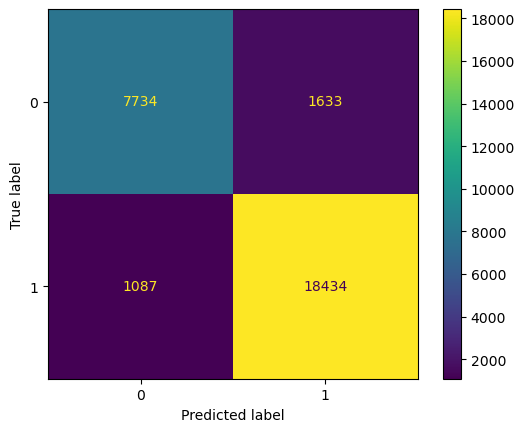

In [72]:
all_cross_val_scores(best_cbc, X, y)
y_pred = cross_val_predict(best_cbc, X, y.values.ravel(), cv=StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42))
cbc_conf_mat = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cbc_conf_mat, display_labels=best_cbc.classes_)
disp.plot()
plt.show()

0:	learn: 0.6518820	total: 8.54ms	remaining: 4.91s
1:	learn: 0.6152814	total: 16.8ms	remaining: 4.82s
2:	learn: 0.5835549	total: 23.7ms	remaining: 4.53s
3:	learn: 0.5486513	total: 31.5ms	remaining: 4.5s
4:	learn: 0.5233810	total: 39.4ms	remaining: 4.5s
5:	learn: 0.5024728	total: 47.4ms	remaining: 4.5s
6:	learn: 0.4823586	total: 55ms	remaining: 4.47s
7:	learn: 0.4653964	total: 62.3ms	remaining: 4.42s
8:	learn: 0.4511672	total: 70ms	remaining: 4.41s
9:	learn: 0.4378909	total: 78.5ms	remaining: 4.45s
10:	learn: 0.4242908	total: 86.1ms	remaining: 4.42s
11:	learn: 0.4132674	total: 93.8ms	remaining: 4.41s
12:	learn: 0.4036974	total: 100ms	remaining: 4.34s
13:	learn: 0.3917807	total: 108ms	remaining: 4.32s
14:	learn: 0.3839880	total: 115ms	remaining: 4.31s
15:	learn: 0.3760341	total: 123ms	remaining: 4.29s
16:	learn: 0.3693832	total: 130ms	remaining: 4.28s
17:	learn: 0.3636357	total: 136ms	remaining: 4.23s
18:	learn: 0.3576645	total: 144ms	remaining: 4.21s
19:	learn: 0.3506071	total: 151ms	re

167:	learn: 0.2284128	total: 1.24s	remaining: 3.01s
168:	learn: 0.2281516	total: 1.25s	remaining: 3.01s
169:	learn: 0.2279867	total: 1.26s	remaining: 3s
170:	learn: 0.2277955	total: 1.26s	remaining: 2.99s
171:	learn: 0.2274782	total: 1.27s	remaining: 2.99s
172:	learn: 0.2273513	total: 1.28s	remaining: 2.98s
173:	learn: 0.2271666	total: 1.29s	remaining: 2.97s
174:	learn: 0.2269102	total: 1.29s	remaining: 2.96s
175:	learn: 0.2267521	total: 1.3s	remaining: 2.96s
176:	learn: 0.2266178	total: 1.31s	remaining: 2.95s
177:	learn: 0.2262953	total: 1.32s	remaining: 2.94s
178:	learn: 0.2261934	total: 1.32s	remaining: 2.94s
179:	learn: 0.2259845	total: 1.33s	remaining: 2.93s
180:	learn: 0.2257911	total: 1.34s	remaining: 2.92s
181:	learn: 0.2256372	total: 1.35s	remaining: 2.91s
182:	learn: 0.2254555	total: 1.35s	remaining: 2.91s
183:	learn: 0.2252471	total: 1.36s	remaining: 2.9s
184:	learn: 0.2250903	total: 1.37s	remaining: 2.89s
185:	learn: 0.2249298	total: 1.38s	remaining: 2.89s
186:	learn: 0.224

336:	learn: 0.2010924	total: 2.49s	remaining: 1.77s
337:	learn: 0.2010015	total: 2.5s	remaining: 1.76s
338:	learn: 0.2007870	total: 2.51s	remaining: 1.75s
339:	learn: 0.2006562	total: 2.52s	remaining: 1.75s
340:	learn: 0.2005617	total: 2.52s	remaining: 1.74s
341:	learn: 0.2004268	total: 2.53s	remaining: 1.73s
342:	learn: 0.2003651	total: 2.54s	remaining: 1.72s
343:	learn: 0.2002688	total: 2.54s	remaining: 1.72s
344:	learn: 0.2001889	total: 2.55s	remaining: 1.71s
345:	learn: 0.2000990	total: 2.56s	remaining: 1.7s
346:	learn: 0.1999284	total: 2.56s	remaining: 1.69s
347:	learn: 0.1998562	total: 2.57s	remaining: 1.68s
348:	learn: 0.1997750	total: 2.58s	remaining: 1.68s
349:	learn: 0.1995817	total: 2.58s	remaining: 1.67s
350:	learn: 0.1994053	total: 2.59s	remaining: 1.66s
351:	learn: 0.1992046	total: 2.6s	remaining: 1.65s
352:	learn: 0.1990913	total: 2.61s	remaining: 1.65s
353:	learn: 0.1989523	total: 2.62s	remaining: 1.64s
354:	learn: 0.1987830	total: 2.62s	remaining: 1.63s
355:	learn: 0.1

501:	learn: 0.1841663	total: 3.73s	remaining: 550ms
502:	learn: 0.1840985	total: 3.74s	remaining: 543ms
503:	learn: 0.1840378	total: 3.75s	remaining: 535ms
504:	learn: 0.1839609	total: 3.75s	remaining: 528ms
505:	learn: 0.1838618	total: 3.76s	remaining: 521ms
506:	learn: 0.1837502	total: 3.77s	remaining: 513ms
507:	learn: 0.1836699	total: 3.78s	remaining: 506ms
508:	learn: 0.1835969	total: 3.78s	remaining: 498ms
509:	learn: 0.1835036	total: 3.79s	remaining: 491ms
510:	learn: 0.1833671	total: 3.8s	remaining: 483ms
511:	learn: 0.1832895	total: 3.81s	remaining: 476ms
512:	learn: 0.1831496	total: 3.81s	remaining: 468ms
513:	learn: 0.1830782	total: 3.82s	remaining: 461ms
514:	learn: 0.1830079	total: 3.83s	remaining: 453ms
515:	learn: 0.1829066	total: 3.83s	remaining: 446ms
516:	learn: 0.1827379	total: 3.84s	remaining: 439ms
517:	learn: 0.1826656	total: 3.85s	remaining: 431ms
518:	learn: 0.1825915	total: 3.86s	remaining: 424ms
519:	learn: 0.1824778	total: 3.87s	remaining: 416ms
520:	learn: 0

107:	learn: 0.2469397	total: 825ms	remaining: 3.58s
108:	learn: 0.2465705	total: 834ms	remaining: 3.57s
109:	learn: 0.2461012	total: 842ms	remaining: 3.56s
110:	learn: 0.2457842	total: 850ms	remaining: 3.56s
111:	learn: 0.2453777	total: 859ms	remaining: 3.56s
112:	learn: 0.2450287	total: 867ms	remaining: 3.55s
113:	learn: 0.2447136	total: 875ms	remaining: 3.55s
114:	learn: 0.2443558	total: 883ms	remaining: 3.54s
115:	learn: 0.2439652	total: 891ms	remaining: 3.53s
116:	learn: 0.2436938	total: 897ms	remaining: 3.52s
117:	learn: 0.2434357	total: 906ms	remaining: 3.52s
118:	learn: 0.2430787	total: 914ms	remaining: 3.51s
119:	learn: 0.2428176	total: 922ms	remaining: 3.5s
120:	learn: 0.2425599	total: 930ms	remaining: 3.5s
121:	learn: 0.2420007	total: 939ms	remaining: 3.49s
122:	learn: 0.2417541	total: 946ms	remaining: 3.48s
123:	learn: 0.2412151	total: 954ms	remaining: 3.48s
124:	learn: 0.2409081	total: 961ms	remaining: 3.47s
125:	learn: 0.2403692	total: 970ms	remaining: 3.46s
126:	learn: 0.

290:	learn: 0.2076585	total: 2.26s	remaining: 2.22s
291:	learn: 0.2075805	total: 2.27s	remaining: 2.21s
292:	learn: 0.2074868	total: 2.28s	remaining: 2.2s
293:	learn: 0.2073837	total: 2.29s	remaining: 2.19s
294:	learn: 0.2072525	total: 2.3s	remaining: 2.19s
295:	learn: 0.2071317	total: 2.3s	remaining: 2.18s
296:	learn: 0.2070326	total: 2.31s	remaining: 2.17s
297:	learn: 0.2069012	total: 2.32s	remaining: 2.17s
298:	learn: 0.2067755	total: 2.33s	remaining: 2.16s
299:	learn: 0.2065794	total: 2.34s	remaining: 2.15s
300:	learn: 0.2064324	total: 2.35s	remaining: 2.14s
301:	learn: 0.2062984	total: 2.35s	remaining: 2.14s
302:	learn: 0.2061965	total: 2.36s	remaining: 2.13s
303:	learn: 0.2061060	total: 2.37s	remaining: 2.12s
304:	learn: 0.2059373	total: 2.38s	remaining: 2.11s
305:	learn: 0.2058832	total: 2.38s	remaining: 2.1s
306:	learn: 0.2057685	total: 2.39s	remaining: 2.1s
307:	learn: 0.2055771	total: 2.4s	remaining: 2.09s
308:	learn: 0.2054196	total: 2.41s	remaining: 2.08s
309:	learn: 0.2053

469:	learn: 0.1874053	total: 3.73s	remaining: 842ms
470:	learn: 0.1873294	total: 3.74s	remaining: 834ms
471:	learn: 0.1872402	total: 3.75s	remaining: 826ms
472:	learn: 0.1870848	total: 3.76s	remaining: 818ms
473:	learn: 0.1870420	total: 3.76s	remaining: 810ms
474:	learn: 0.1869749	total: 3.77s	remaining: 802ms
475:	learn: 0.1868850	total: 3.78s	remaining: 794ms
476:	learn: 0.1868179	total: 3.79s	remaining: 786ms
477:	learn: 0.1866907	total: 3.8s	remaining: 779ms
478:	learn: 0.1866169	total: 3.81s	remaining: 771ms
479:	learn: 0.1865319	total: 3.81s	remaining: 763ms
480:	learn: 0.1864330	total: 3.82s	remaining: 755ms
481:	learn: 0.1863428	total: 3.83s	remaining: 747ms
482:	learn: 0.1862750	total: 3.84s	remaining: 739ms
483:	learn: 0.1861606	total: 3.84s	remaining: 731ms
484:	learn: 0.1860847	total: 3.85s	remaining: 723ms
485:	learn: 0.1859780	total: 3.86s	remaining: 715ms
486:	learn: 0.1858826	total: 3.87s	remaining: 707ms
487:	learn: 0.1858343	total: 3.88s	remaining: 699ms
488:	learn: 0

77:	learn: 0.2594338	total: 574ms	remaining: 3.66s
78:	learn: 0.2589067	total: 581ms	remaining: 3.66s
79:	learn: 0.2581610	total: 589ms	remaining: 3.65s
80:	learn: 0.2577331	total: 597ms	remaining: 3.65s
81:	learn: 0.2571355	total: 605ms	remaining: 3.64s
82:	learn: 0.2566777	total: 611ms	remaining: 3.63s
83:	learn: 0.2561913	total: 619ms	remaining: 3.63s
84:	learn: 0.2555510	total: 627ms	remaining: 3.62s
85:	learn: 0.2550526	total: 636ms	remaining: 3.62s
86:	learn: 0.2543599	total: 644ms	remaining: 3.62s
87:	learn: 0.2538955	total: 652ms	remaining: 3.61s
88:	learn: 0.2534169	total: 660ms	remaining: 3.61s
89:	learn: 0.2530099	total: 668ms	remaining: 3.61s
90:	learn: 0.2525927	total: 676ms	remaining: 3.6s
91:	learn: 0.2521998	total: 684ms	remaining: 3.6s
92:	learn: 0.2516885	total: 692ms	remaining: 3.6s
93:	learn: 0.2514417	total: 699ms	remaining: 3.59s
94:	learn: 0.2511487	total: 707ms	remaining: 3.58s
95:	learn: 0.2509271	total: 712ms	remaining: 3.56s
96:	learn: 0.2506230	total: 719ms	

245:	learn: 0.2152748	total: 1.81s	remaining: 2.42s
246:	learn: 0.2151287	total: 1.81s	remaining: 2.42s
247:	learn: 0.2149494	total: 1.82s	remaining: 2.41s
248:	learn: 0.2147185	total: 1.83s	remaining: 2.4s
249:	learn: 0.2145860	total: 1.84s	remaining: 2.4s
250:	learn: 0.2144657	total: 1.84s	remaining: 2.39s
251:	learn: 0.2143499	total: 1.85s	remaining: 2.38s
252:	learn: 0.2142214	total: 1.86s	remaining: 2.37s
253:	learn: 0.2140913	total: 1.87s	remaining: 2.37s
254:	learn: 0.2139418	total: 1.87s	remaining: 2.36s
255:	learn: 0.2137036	total: 1.88s	remaining: 2.35s
256:	learn: 0.2135943	total: 1.89s	remaining: 2.34s
257:	learn: 0.2135134	total: 1.89s	remaining: 2.33s
258:	learn: 0.2134404	total: 1.9s	remaining: 2.33s
259:	learn: 0.2132992	total: 1.91s	remaining: 2.32s
260:	learn: 0.2132176	total: 1.92s	remaining: 2.31s
261:	learn: 0.2131239	total: 1.92s	remaining: 2.3s
262:	learn: 0.2129809	total: 1.93s	remaining: 2.3s
263:	learn: 0.2128058	total: 1.94s	remaining: 2.29s
264:	learn: 0.212

411:	learn: 0.1949340	total: 3.04s	remaining: 1.21s
412:	learn: 0.1947872	total: 3.05s	remaining: 1.2s
413:	learn: 0.1946504	total: 3.06s	remaining: 1.2s
414:	learn: 0.1945733	total: 3.07s	remaining: 1.19s
415:	learn: 0.1944806	total: 3.08s	remaining: 1.19s
416:	learn: 0.1943903	total: 3.09s	remaining: 1.18s
417:	learn: 0.1942593	total: 3.1s	remaining: 1.17s
418:	learn: 0.1941321	total: 3.1s	remaining: 1.16s
419:	learn: 0.1940653	total: 3.11s	remaining: 1.16s
420:	learn: 0.1939731	total: 3.12s	remaining: 1.15s
421:	learn: 0.1939120	total: 3.12s	remaining: 1.14s
422:	learn: 0.1938089	total: 3.13s	remaining: 1.13s
423:	learn: 0.1936867	total: 3.14s	remaining: 1.13s
424:	learn: 0.1935709	total: 3.15s	remaining: 1.12s
425:	learn: 0.1934552	total: 3.15s	remaining: 1.11s
426:	learn: 0.1932394	total: 3.16s	remaining: 1.1s
427:	learn: 0.1931596	total: 3.17s	remaining: 1.1s
428:	learn: 0.1929813	total: 3.18s	remaining: 1.09s
429:	learn: 0.1928669	total: 3.19s	remaining: 1.08s
430:	learn: 0.1927

0:	learn: 0.6503720	total: 7.95ms	remaining: 4.57s
1:	learn: 0.6135193	total: 15.6ms	remaining: 4.47s
2:	learn: 0.5819236	total: 23.2ms	remaining: 4.44s
3:	learn: 0.5508163	total: 30.2ms	remaining: 4.32s
4:	learn: 0.5252011	total: 37.4ms	remaining: 4.27s
5:	learn: 0.5017268	total: 44.8ms	remaining: 4.26s
6:	learn: 0.4816460	total: 53.1ms	remaining: 4.31s
7:	learn: 0.4647750	total: 60.3ms	remaining: 4.28s
8:	learn: 0.4505911	total: 68.5ms	remaining: 4.32s
9:	learn: 0.4359513	total: 75.3ms	remaining: 4.26s
10:	learn: 0.4229950	total: 82.5ms	remaining: 4.24s
11:	learn: 0.4094757	total: 90.4ms	remaining: 4.25s
12:	learn: 0.4002356	total: 97.5ms	remaining: 4.22s
13:	learn: 0.3920264	total: 105ms	remaining: 4.22s
14:	learn: 0.3838905	total: 112ms	remaining: 4.21s
15:	learn: 0.3749872	total: 120ms	remaining: 4.2s
16:	learn: 0.3675005	total: 127ms	remaining: 4.18s
17:	learn: 0.3604969	total: 135ms	remaining: 4.17s
18:	learn: 0.3532803	total: 142ms	remaining: 4.16s
19:	learn: 0.3459580	total: 1

166:	learn: 0.2268634	total: 1.24s	remaining: 3.03s
167:	learn: 0.2266765	total: 1.25s	remaining: 3.03s
168:	learn: 0.2264647	total: 1.26s	remaining: 3.02s
169:	learn: 0.2262734	total: 1.26s	remaining: 3.02s
170:	learn: 0.2260971	total: 1.27s	remaining: 3.01s
171:	learn: 0.2258612	total: 1.28s	remaining: 3.01s
172:	learn: 0.2256768	total: 1.29s	remaining: 3s
173:	learn: 0.2255148	total: 1.3s	remaining: 3s
174:	learn: 0.2253130	total: 1.3s	remaining: 2.99s
175:	learn: 0.2250941	total: 1.31s	remaining: 2.98s
176:	learn: 0.2249413	total: 1.32s	remaining: 2.97s
177:	learn: 0.2245674	total: 1.32s	remaining: 2.96s
178:	learn: 0.2243279	total: 1.33s	remaining: 2.96s
179:	learn: 0.2241007	total: 1.34s	remaining: 2.95s
180:	learn: 0.2238522	total: 1.35s	remaining: 2.94s
181:	learn: 0.2236636	total: 1.35s	remaining: 2.93s
182:	learn: 0.2232483	total: 1.36s	remaining: 2.92s
183:	learn: 0.2231011	total: 1.37s	remaining: 2.92s
184:	learn: 0.2228849	total: 1.38s	remaining: 2.91s
185:	learn: 0.222675

332:	learn: 0.1992220	total: 2.47s	remaining: 1.8s
333:	learn: 0.1991134	total: 2.48s	remaining: 1.8s
334:	learn: 0.1990071	total: 2.49s	remaining: 1.79s
335:	learn: 0.1988419	total: 2.5s	remaining: 1.78s
336:	learn: 0.1987038	total: 2.5s	remaining: 1.77s
337:	learn: 0.1985445	total: 2.51s	remaining: 1.77s
338:	learn: 0.1984314	total: 2.52s	remaining: 1.76s
339:	learn: 0.1983537	total: 2.52s	remaining: 1.75s
340:	learn: 0.1982278	total: 2.53s	remaining: 1.75s
341:	learn: 0.1981281	total: 2.54s	remaining: 1.74s
342:	learn: 0.1980081	total: 2.55s	remaining: 1.73s
343:	learn: 0.1978775	total: 2.55s	remaining: 1.72s
344:	learn: 0.1977412	total: 2.56s	remaining: 1.72s
345:	learn: 0.1975780	total: 2.57s	remaining: 1.71s
346:	learn: 0.1974733	total: 2.58s	remaining: 1.7s
347:	learn: 0.1973991	total: 2.58s	remaining: 1.69s
348:	learn: 0.1972945	total: 2.59s	remaining: 1.69s
349:	learn: 0.1971637	total: 2.6s	remaining: 1.68s
350:	learn: 0.1971135	total: 2.61s	remaining: 1.67s
351:	learn: 0.1970

499:	learn: 0.1818103	total: 3.73s	remaining: 568ms
500:	learn: 0.1817640	total: 3.74s	remaining: 560ms
501:	learn: 0.1817191	total: 3.75s	remaining: 553ms
502:	learn: 0.1816058	total: 3.76s	remaining: 545ms
503:	learn: 0.1814746	total: 3.76s	remaining: 538ms
504:	learn: 0.1813941	total: 3.77s	remaining: 530ms
505:	learn: 0.1813238	total: 3.78s	remaining: 523ms
506:	learn: 0.1812441	total: 3.79s	remaining: 515ms
507:	learn: 0.1811994	total: 3.79s	remaining: 508ms
508:	learn: 0.1811578	total: 3.8s	remaining: 500ms
509:	learn: 0.1811091	total: 3.81s	remaining: 493ms
510:	learn: 0.1810328	total: 3.81s	remaining: 485ms
511:	learn: 0.1809430	total: 3.82s	remaining: 478ms
512:	learn: 0.1808604	total: 3.83s	remaining: 471ms
513:	learn: 0.1807760	total: 3.84s	remaining: 463ms
514:	learn: 0.1806576	total: 3.85s	remaining: 456ms
515:	learn: 0.1805133	total: 3.85s	remaining: 448ms
516:	learn: 0.1804279	total: 3.86s	remaining: 441ms
517:	learn: 0.1803483	total: 3.87s	remaining: 433ms
518:	learn: 0

84:	learn: 0.2553621	total: 635ms	remaining: 3.67s
85:	learn: 0.2549278	total: 643ms	remaining: 3.66s
86:	learn: 0.2544302	total: 651ms	remaining: 3.66s
87:	learn: 0.2539867	total: 659ms	remaining: 3.65s
88:	learn: 0.2534876	total: 666ms	remaining: 3.65s
89:	learn: 0.2530027	total: 675ms	remaining: 3.64s
90:	learn: 0.2526780	total: 682ms	remaining: 3.63s
91:	learn: 0.2523716	total: 690ms	remaining: 3.63s
92:	learn: 0.2520608	total: 697ms	remaining: 3.62s
93:	learn: 0.2514587	total: 705ms	remaining: 3.62s
94:	learn: 0.2509696	total: 713ms	remaining: 3.61s
95:	learn: 0.2504954	total: 721ms	remaining: 3.6s
96:	learn: 0.2500968	total: 729ms	remaining: 3.6s
97:	learn: 0.2495680	total: 737ms	remaining: 3.59s
98:	learn: 0.2492872	total: 744ms	remaining: 3.59s
99:	learn: 0.2489816	total: 752ms	remaining: 3.58s
100:	learn: 0.2486545	total: 758ms	remaining: 3.57s
101:	learn: 0.2481704	total: 766ms	remaining: 3.56s
102:	learn: 0.2477176	total: 773ms	remaining: 3.55s
103:	learn: 0.2473853	total: 7

250:	learn: 0.2128397	total: 1.86s	remaining: 2.41s
251:	learn: 0.2125842	total: 1.87s	remaining: 2.41s
252:	learn: 0.2124503	total: 1.88s	remaining: 2.4s
253:	learn: 0.2122544	total: 1.89s	remaining: 2.39s
254:	learn: 0.2121302	total: 1.9s	remaining: 2.39s
255:	learn: 0.2119764	total: 1.9s	remaining: 2.38s
256:	learn: 0.2117730	total: 1.91s	remaining: 2.37s
257:	learn: 0.2115403	total: 1.92s	remaining: 2.37s
258:	learn: 0.2113983	total: 1.93s	remaining: 2.36s
259:	learn: 0.2112198	total: 1.93s	remaining: 2.35s
260:	learn: 0.2111010	total: 1.94s	remaining: 2.34s
261:	learn: 0.2109804	total: 1.95s	remaining: 2.33s
262:	learn: 0.2108287	total: 1.95s	remaining: 2.33s
263:	learn: 0.2106147	total: 1.96s	remaining: 2.32s
264:	learn: 0.2104591	total: 1.97s	remaining: 2.31s
265:	learn: 0.2103740	total: 1.98s	remaining: 2.3s
266:	learn: 0.2102095	total: 1.98s	remaining: 2.29s
267:	learn: 0.2100826	total: 1.99s	remaining: 2.29s
268:	learn: 0.2099654	total: 2s	remaining: 2.28s
269:	learn: 0.20984

422:	learn: 0.1913549	total: 3.12s	remaining: 1.13s
423:	learn: 0.1912963	total: 3.13s	remaining: 1.12s
424:	learn: 0.1911716	total: 3.14s	remaining: 1.11s
425:	learn: 0.1910495	total: 3.15s	remaining: 1.11s
426:	learn: 0.1909627	total: 3.15s	remaining: 1.1s
427:	learn: 0.1908855	total: 3.16s	remaining: 1.09s
428:	learn: 0.1906802	total: 3.17s	remaining: 1.08s
429:	learn: 0.1905774	total: 3.17s	remaining: 1.08s
430:	learn: 0.1904504	total: 3.18s	remaining: 1.07s
431:	learn: 0.1903306	total: 3.19s	remaining: 1.06s
432:	learn: 0.1902200	total: 3.2s	remaining: 1.05s
433:	learn: 0.1900839	total: 3.2s	remaining: 1.05s
434:	learn: 0.1899955	total: 3.21s	remaining: 1.04s
435:	learn: 0.1899132	total: 3.22s	remaining: 1.03s
436:	learn: 0.1897634	total: 3.23s	remaining: 1.02s
437:	learn: 0.1896792	total: 3.23s	remaining: 1.02s
438:	learn: 0.1895814	total: 3.24s	remaining: 1.01s
439:	learn: 0.1894926	total: 3.25s	remaining: 1s
440:	learn: 0.1893771	total: 3.25s	remaining: 996ms
441:	learn: 0.1892

6:	learn: 0.4851994	total: 62.8ms	remaining: 5.1s
7:	learn: 0.4658820	total: 71.6ms	remaining: 5.09s
8:	learn: 0.4498226	total: 79.5ms	remaining: 5.01s
9:	learn: 0.4372419	total: 87.4ms	remaining: 4.95s
10:	learn: 0.4258080	total: 95.3ms	remaining: 4.89s
11:	learn: 0.4158704	total: 103ms	remaining: 4.85s
12:	learn: 0.4062926	total: 111ms	remaining: 4.81s
13:	learn: 0.3961201	total: 119ms	remaining: 4.78s
14:	learn: 0.3891167	total: 127ms	remaining: 4.76s
15:	learn: 0.3802950	total: 136ms	remaining: 4.76s
16:	learn: 0.3717574	total: 144ms	remaining: 4.75s
17:	learn: 0.3645202	total: 153ms	remaining: 4.73s
18:	learn: 0.3576405	total: 161ms	remaining: 4.71s
19:	learn: 0.3530055	total: 169ms	remaining: 4.7s
20:	learn: 0.3490106	total: 177ms	remaining: 4.67s
21:	learn: 0.3437283	total: 184ms	remaining: 4.64s
22:	learn: 0.3394156	total: 192ms	remaining: 4.61s
23:	learn: 0.3351258	total: 199ms	remaining: 4.59s
24:	learn: 0.3316614	total: 206ms	remaining: 4.55s
25:	learn: 0.3262120	total: 214m

166:	learn: 0.2291589	total: 1.28s	remaining: 3.15s
167:	learn: 0.2289357	total: 1.29s	remaining: 3.14s
168:	learn: 0.2287848	total: 1.3s	remaining: 3.13s
169:	learn: 0.2285870	total: 1.31s	remaining: 3.12s
170:	learn: 0.2284497	total: 1.31s	remaining: 3.11s
171:	learn: 0.2282184	total: 1.32s	remaining: 3.1s
172:	learn: 0.2280420	total: 1.33s	remaining: 3.09s
173:	learn: 0.2279168	total: 1.33s	remaining: 3.08s
174:	learn: 0.2277026	total: 1.34s	remaining: 3.08s
175:	learn: 0.2273253	total: 1.35s	remaining: 3.07s
176:	learn: 0.2271886	total: 1.36s	remaining: 3.06s
177:	learn: 0.2270076	total: 1.36s	remaining: 3.05s
178:	learn: 0.2268577	total: 1.37s	remaining: 3.05s
179:	learn: 0.2265744	total: 1.38s	remaining: 3.04s
180:	learn: 0.2261768	total: 1.39s	remaining: 3.03s
181:	learn: 0.2260493	total: 1.4s	remaining: 3.02s
182:	learn: 0.2258967	total: 1.4s	remaining: 3.02s
183:	learn: 0.2257082	total: 1.41s	remaining: 3.01s
184:	learn: 0.2254264	total: 1.42s	remaining: 3s
185:	learn: 0.22527

344:	learn: 0.2010297	total: 2.73s	remaining: 1.83s
345:	learn: 0.2008897	total: 2.74s	remaining: 1.82s
346:	learn: 0.2008074	total: 2.75s	remaining: 1.82s
347:	learn: 0.2006566	total: 2.76s	remaining: 1.81s
348:	learn: 0.2005216	total: 2.77s	remaining: 1.8s
349:	learn: 0.2004512	total: 2.78s	remaining: 1.79s
350:	learn: 0.2002974	total: 2.79s	remaining: 1.78s
351:	learn: 0.2002014	total: 2.79s	remaining: 1.78s
352:	learn: 0.2001024	total: 2.8s	remaining: 1.77s
353:	learn: 0.1999840	total: 2.81s	remaining: 1.76s
354:	learn: 0.1998843	total: 2.82s	remaining: 1.76s
355:	learn: 0.1997275	total: 2.83s	remaining: 1.75s
356:	learn: 0.1996546	total: 2.84s	remaining: 1.74s
357:	learn: 0.1995467	total: 2.85s	remaining: 1.74s
358:	learn: 0.1995034	total: 2.86s	remaining: 1.73s
359:	learn: 0.1993672	total: 2.87s	remaining: 1.72s
360:	learn: 0.1992798	total: 2.87s	remaining: 1.71s
361:	learn: 0.1991954	total: 2.88s	remaining: 1.7s
362:	learn: 0.1990597	total: 2.89s	remaining: 1.7s
363:	learn: 0.19

514:	learn: 0.1843267	total: 4.17s	remaining: 494ms
515:	learn: 0.1841848	total: 4.18s	remaining: 486ms
516:	learn: 0.1841162	total: 4.19s	remaining: 478ms
517:	learn: 0.1838783	total: 4.2s	remaining: 470ms
518:	learn: 0.1837515	total: 4.21s	remaining: 462ms
519:	learn: 0.1836186	total: 4.21s	remaining: 454ms
520:	learn: 0.1834960	total: 4.22s	remaining: 446ms
521:	learn: 0.1834229	total: 4.23s	remaining: 438ms
522:	learn: 0.1832721	total: 4.24s	remaining: 429ms
523:	learn: 0.1832049	total: 4.24s	remaining: 421ms
524:	learn: 0.1831209	total: 4.25s	remaining: 413ms
525:	learn: 0.1830701	total: 4.26s	remaining: 405ms
526:	learn: 0.1830279	total: 4.27s	remaining: 397ms
527:	learn: 0.1829591	total: 4.28s	remaining: 389ms
528:	learn: 0.1828890	total: 4.28s	remaining: 381ms
529:	learn: 0.1828165	total: 4.29s	remaining: 373ms
530:	learn: 0.1827526	total: 4.3s	remaining: 364ms
531:	learn: 0.1826521	total: 4.31s	remaining: 356ms
532:	learn: 0.1825730	total: 4.32s	remaining: 348ms
533:	learn: 0.

114:	learn: 0.2435783	total: 934ms	remaining: 3.74s
115:	learn: 0.2431320	total: 941ms	remaining: 3.73s
116:	learn: 0.2428326	total: 949ms	remaining: 3.72s
117:	learn: 0.2426016	total: 956ms	remaining: 3.71s
118:	learn: 0.2423228	total: 964ms	remaining: 3.7s
119:	learn: 0.2420546	total: 973ms	remaining: 3.7s
120:	learn: 0.2416604	total: 981ms	remaining: 3.69s
121:	learn: 0.2414425	total: 990ms	remaining: 3.68s
122:	learn: 0.2410833	total: 998ms	remaining: 3.68s
123:	learn: 0.2409152	total: 1.01s	remaining: 3.67s
124:	learn: 0.2406463	total: 1.01s	remaining: 3.66s
125:	learn: 0.2403973	total: 1.02s	remaining: 3.65s
126:	learn: 0.2401484	total: 1.03s	remaining: 3.64s
127:	learn: 0.2398135	total: 1.04s	remaining: 3.63s
128:	learn: 0.2395919	total: 1.04s	remaining: 3.62s
129:	learn: 0.2392284	total: 1.05s	remaining: 3.61s
130:	learn: 0.2388406	total: 1.06s	remaining: 3.6s
131:	learn: 0.2385019	total: 1.07s	remaining: 3.59s
132:	learn: 0.2377218	total: 1.08s	remaining: 3.58s
133:	learn: 0.2

293:	learn: 0.2063741	total: 2.39s	remaining: 2.29s
294:	learn: 0.2062538	total: 2.4s	remaining: 2.29s
295:	learn: 0.2061424	total: 2.41s	remaining: 2.28s
296:	learn: 0.2059643	total: 2.41s	remaining: 2.27s
297:	learn: 0.2058106	total: 2.42s	remaining: 2.26s
298:	learn: 0.2056269	total: 2.43s	remaining: 2.25s
299:	learn: 0.2055053	total: 2.44s	remaining: 2.24s
300:	learn: 0.2053342	total: 2.45s	remaining: 2.23s
301:	learn: 0.2051536	total: 2.46s	remaining: 2.23s
302:	learn: 0.2050136	total: 2.46s	remaining: 2.22s
303:	learn: 0.2048832	total: 2.47s	remaining: 2.21s
304:	learn: 0.2047152	total: 2.48s	remaining: 2.2s
305:	learn: 0.2045810	total: 2.49s	remaining: 2.2s
306:	learn: 0.2044676	total: 2.5s	remaining: 2.19s
307:	learn: 0.2043764	total: 2.5s	remaining: 2.18s
308:	learn: 0.2042679	total: 2.51s	remaining: 2.17s
309:	learn: 0.2040810	total: 2.52s	remaining: 2.16s
310:	learn: 0.2039193	total: 2.53s	remaining: 2.15s
311:	learn: 0.2037102	total: 2.54s	remaining: 2.15s
312:	learn: 0.203

474:	learn: 0.1858285	total: 3.84s	remaining: 817ms
475:	learn: 0.1857610	total: 3.85s	remaining: 809ms
476:	learn: 0.1856691	total: 3.86s	remaining: 801ms
477:	learn: 0.1856190	total: 3.87s	remaining: 793ms
478:	learn: 0.1855283	total: 3.88s	remaining: 785ms
479:	learn: 0.1854489	total: 3.88s	remaining: 777ms
480:	learn: 0.1853593	total: 3.89s	remaining: 769ms
481:	learn: 0.1853171	total: 3.9s	remaining: 761ms
482:	learn: 0.1851768	total: 3.91s	remaining: 753ms
483:	learn: 0.1851178	total: 3.92s	remaining: 745ms
484:	learn: 0.1850050	total: 3.93s	remaining: 737ms
485:	learn: 0.1848572	total: 3.93s	remaining: 729ms
486:	learn: 0.1847648	total: 3.94s	remaining: 721ms
487:	learn: 0.1846285	total: 3.95s	remaining: 713ms
488:	learn: 0.1845937	total: 3.96s	remaining: 705ms
489:	learn: 0.1844595	total: 3.97s	remaining: 697ms
490:	learn: 0.1843623	total: 3.98s	remaining: 689ms
491:	learn: 0.1842821	total: 3.98s	remaining: 680ms
492:	learn: 0.1841551	total: 3.99s	remaining: 672ms
493:	learn: 0

74:	learn: 0.2592191	total: 627ms	remaining: 4.18s
75:	learn: 0.2585295	total: 635ms	remaining: 4.17s
76:	learn: 0.2580122	total: 642ms	remaining: 4.16s
77:	learn: 0.2573589	total: 650ms	remaining: 4.15s
78:	learn: 0.2569200	total: 658ms	remaining: 4.14s
79:	learn: 0.2562601	total: 666ms	remaining: 4.13s
80:	learn: 0.2557091	total: 675ms	remaining: 4.13s
81:	learn: 0.2552165	total: 682ms	remaining: 4.11s
82:	learn: 0.2548505	total: 691ms	remaining: 4.1s
83:	learn: 0.2542871	total: 699ms	remaining: 4.09s
84:	learn: 0.2537994	total: 708ms	remaining: 4.09s
85:	learn: 0.2534963	total: 714ms	remaining: 4.07s
86:	learn: 0.2529972	total: 723ms	remaining: 4.06s
87:	learn: 0.2525339	total: 730ms	remaining: 4.05s
88:	learn: 0.2520795	total: 740ms	remaining: 4.05s
89:	learn: 0.2512887	total: 748ms	remaining: 4.04s
90:	learn: 0.2506062	total: 756ms	remaining: 4.03s
91:	learn: 0.2501781	total: 764ms	remaining: 4.02s
92:	learn: 0.2497187	total: 773ms	remaining: 4.01s
93:	learn: 0.2493052	total: 781m

256:	learn: 0.2102396	total: 2.08s	remaining: 2.58s
257:	learn: 0.2101275	total: 2.08s	remaining: 2.57s
258:	learn: 0.2099422	total: 2.09s	remaining: 2.56s
259:	learn: 0.2098293	total: 2.1s	remaining: 2.55s
260:	learn: 0.2096717	total: 2.11s	remaining: 2.54s
261:	learn: 0.2095328	total: 2.11s	remaining: 2.53s
262:	learn: 0.2094328	total: 2.12s	remaining: 2.53s
263:	learn: 0.2093523	total: 2.13s	remaining: 2.52s
264:	learn: 0.2092439	total: 2.14s	remaining: 2.51s
265:	learn: 0.2091738	total: 2.14s	remaining: 2.5s
266:	learn: 0.2090704	total: 2.15s	remaining: 2.49s
267:	learn: 0.2089022	total: 2.16s	remaining: 2.48s
268:	learn: 0.2088036	total: 2.17s	remaining: 2.47s
269:	learn: 0.2086518	total: 2.17s	remaining: 2.46s
270:	learn: 0.2085194	total: 2.18s	remaining: 2.45s
271:	learn: 0.2083800	total: 2.19s	remaining: 2.45s
272:	learn: 0.2082292	total: 2.19s	remaining: 2.44s
273:	learn: 0.2081038	total: 2.2s	remaining: 2.43s
274:	learn: 0.2079596	total: 2.21s	remaining: 2.42s
275:	learn: 0.2

439:	learn: 0.1884741	total: 3.49s	remaining: 1.08s
440:	learn: 0.1884176	total: 3.5s	remaining: 1.07s
441:	learn: 0.1883140	total: 3.51s	remaining: 1.06s
442:	learn: 0.1881521	total: 3.52s	remaining: 1.05s
443:	learn: 0.1880665	total: 3.52s	remaining: 1.05s
444:	learn: 0.1880234	total: 3.53s	remaining: 1.04s
445:	learn: 0.1879271	total: 3.54s	remaining: 1.03s
446:	learn: 0.1878647	total: 3.55s	remaining: 1.02s
447:	learn: 0.1877921	total: 3.55s	remaining: 1.01s
448:	learn: 0.1876893	total: 3.56s	remaining: 1.01s
449:	learn: 0.1875355	total: 3.57s	remaining: 999ms
450:	learn: 0.1874833	total: 3.58s	remaining: 991ms
451:	learn: 0.1873632	total: 3.59s	remaining: 984ms
452:	learn: 0.1872853	total: 3.59s	remaining: 976ms
453:	learn: 0.1872151	total: 3.6s	remaining: 968ms
454:	learn: 0.1870917	total: 3.61s	remaining: 960ms
455:	learn: 0.1869481	total: 3.62s	remaining: 952ms
456:	learn: 0.1868571	total: 3.63s	remaining: 944ms
457:	learn: 0.1867428	total: 3.63s	remaining: 937ms
458:	learn: 0.

32:	learn: 0.3049667	total: 280ms	remaining: 4.6s
33:	learn: 0.3024886	total: 288ms	remaining: 4.59s
34:	learn: 0.3008517	total: 296ms	remaining: 4.58s
35:	learn: 0.2990752	total: 304ms	remaining: 4.56s
36:	learn: 0.2969543	total: 313ms	remaining: 4.56s
37:	learn: 0.2952483	total: 321ms	remaining: 4.55s
38:	learn: 0.2938722	total: 330ms	remaining: 4.54s
39:	learn: 0.2922118	total: 338ms	remaining: 4.53s
40:	learn: 0.2905470	total: 347ms	remaining: 4.53s
41:	learn: 0.2882427	total: 355ms	remaining: 4.52s
42:	learn: 0.2869875	total: 364ms	remaining: 4.51s
43:	learn: 0.2855406	total: 372ms	remaining: 4.49s
44:	learn: 0.2837900	total: 380ms	remaining: 4.49s
45:	learn: 0.2827222	total: 389ms	remaining: 4.48s
46:	learn: 0.2809723	total: 398ms	remaining: 4.47s
47:	learn: 0.2798801	total: 406ms	remaining: 4.47s
48:	learn: 0.2791994	total: 414ms	remaining: 4.45s
49:	learn: 0.2777540	total: 422ms	remaining: 4.44s
50:	learn: 0.2770091	total: 431ms	remaining: 4.43s
51:	learn: 0.2762075	total: 437m

208:	learn: 0.2182478	total: 1.76s	remaining: 3.1s
209:	learn: 0.2180046	total: 1.77s	remaining: 3.09s
210:	learn: 0.2177483	total: 1.78s	remaining: 3.08s
211:	learn: 0.2174991	total: 1.79s	remaining: 3.07s
212:	learn: 0.2173330	total: 1.8s	remaining: 3.06s
213:	learn: 0.2172134	total: 1.81s	remaining: 3.06s
214:	learn: 0.2169367	total: 1.81s	remaining: 3.05s
215:	learn: 0.2166907	total: 1.82s	remaining: 3.04s
216:	learn: 0.2165458	total: 1.83s	remaining: 3.03s
217:	learn: 0.2163285	total: 1.84s	remaining: 3.02s
218:	learn: 0.2161363	total: 1.85s	remaining: 3.02s
219:	learn: 0.2159684	total: 1.86s	remaining: 3.01s
220:	learn: 0.2157355	total: 1.87s	remaining: 3s
221:	learn: 0.2155773	total: 1.88s	remaining: 2.99s
222:	learn: 0.2153351	total: 1.88s	remaining: 2.98s
223:	learn: 0.2151785	total: 1.89s	remaining: 2.97s
224:	learn: 0.2150420	total: 1.9s	remaining: 2.96s
225:	learn: 0.2148962	total: 1.91s	remaining: 2.96s
226:	learn: 0.2146971	total: 1.92s	remaining: 2.95s
227:	learn: 0.2145

378:	learn: 0.1937442	total: 3.21s	remaining: 1.67s
379:	learn: 0.1936435	total: 3.22s	remaining: 1.66s
380:	learn: 0.1935885	total: 3.23s	remaining: 1.65s
381:	learn: 0.1934989	total: 3.23s	remaining: 1.64s
382:	learn: 0.1933652	total: 3.24s	remaining: 1.63s
383:	learn: 0.1932921	total: 3.25s	remaining: 1.63s
384:	learn: 0.1932053	total: 3.26s	remaining: 1.62s
385:	learn: 0.1931347	total: 3.27s	remaining: 1.61s
386:	learn: 0.1930304	total: 3.28s	remaining: 1.6s
387:	learn: 0.1929359	total: 3.29s	remaining: 1.59s
388:	learn: 0.1928483	total: 3.29s	remaining: 1.58s
389:	learn: 0.1927425	total: 3.3s	remaining: 1.57s
390:	learn: 0.1926815	total: 3.31s	remaining: 1.57s
391:	learn: 0.1925956	total: 3.32s	remaining: 1.56s
392:	learn: 0.1925236	total: 3.33s	remaining: 1.55s
393:	learn: 0.1923438	total: 3.34s	remaining: 1.54s
394:	learn: 0.1922408	total: 3.35s	remaining: 1.53s
395:	learn: 0.1921281	total: 3.36s	remaining: 1.52s
396:	learn: 0.1920239	total: 3.37s	remaining: 1.52s
397:	learn: 0.

546:	learn: 0.1786180	total: 4.63s	remaining: 245ms
547:	learn: 0.1785368	total: 4.63s	remaining: 237ms
548:	learn: 0.1784900	total: 4.64s	remaining: 228ms
549:	learn: 0.1784220	total: 4.65s	remaining: 220ms
550:	learn: 0.1783376	total: 4.66s	remaining: 211ms
551:	learn: 0.1782145	total: 4.66s	remaining: 203ms
552:	learn: 0.1781392	total: 4.67s	remaining: 194ms
553:	learn: 0.1780711	total: 4.68s	remaining: 186ms
554:	learn: 0.1779625	total: 4.68s	remaining: 177ms
555:	learn: 0.1778874	total: 4.69s	remaining: 169ms
556:	learn: 0.1777496	total: 4.7s	remaining: 160ms
557:	learn: 0.1776406	total: 4.71s	remaining: 152ms
558:	learn: 0.1775752	total: 4.72s	remaining: 143ms
559:	learn: 0.1774688	total: 4.73s	remaining: 135ms
560:	learn: 0.1773291	total: 4.73s	remaining: 127ms
561:	learn: 0.1772216	total: 4.74s	remaining: 118ms
562:	learn: 0.1771393	total: 4.75s	remaining: 110ms
563:	learn: 0.1770369	total: 4.76s	remaining: 101ms
564:	learn: 0.1769284	total: 4.77s	remaining: 92.8ms
565:	learn: 

146:	learn: 0.2301486	total: 1.2s	remaining: 3.51s
147:	learn: 0.2299686	total: 1.21s	remaining: 3.5s
148:	learn: 0.2297068	total: 1.22s	remaining: 3.5s
149:	learn: 0.2293894	total: 1.23s	remaining: 3.49s
150:	learn: 0.2292032	total: 1.24s	remaining: 3.48s
151:	learn: 0.2290428	total: 1.24s	remaining: 3.47s
152:	learn: 0.2288371	total: 1.25s	remaining: 3.46s
153:	learn: 0.2285917	total: 1.26s	remaining: 3.46s
154:	learn: 0.2283359	total: 1.27s	remaining: 3.44s
155:	learn: 0.2281597	total: 1.27s	remaining: 3.43s
156:	learn: 0.2279726	total: 1.28s	remaining: 3.42s
157:	learn: 0.2277197	total: 1.29s	remaining: 3.42s
158:	learn: 0.2275268	total: 1.3s	remaining: 3.41s
159:	learn: 0.2273737	total: 1.31s	remaining: 3.4s
160:	learn: 0.2271524	total: 1.31s	remaining: 3.39s
161:	learn: 0.2268984	total: 1.32s	remaining: 3.38s
162:	learn: 0.2267219	total: 1.33s	remaining: 3.37s
163:	learn: 0.2265604	total: 1.34s	remaining: 3.36s
164:	learn: 0.2262556	total: 1.34s	remaining: 3.35s
165:	learn: 0.226

305:	learn: 0.2032126	total: 2.46s	remaining: 2.17s
306:	learn: 0.2030714	total: 2.47s	remaining: 2.17s
307:	learn: 0.2029684	total: 2.48s	remaining: 2.16s
308:	learn: 0.2028422	total: 2.49s	remaining: 2.15s
309:	learn: 0.2026775	total: 2.5s	remaining: 2.14s
310:	learn: 0.2025288	total: 2.5s	remaining: 2.13s
311:	learn: 0.2023399	total: 2.51s	remaining: 2.12s
312:	learn: 0.2022227	total: 2.52s	remaining: 2.12s
313:	learn: 0.2021103	total: 2.52s	remaining: 2.11s
314:	learn: 0.2019049	total: 2.53s	remaining: 2.1s
315:	learn: 0.2017167	total: 2.54s	remaining: 2.09s
316:	learn: 0.2015272	total: 2.55s	remaining: 2.08s
317:	learn: 0.2014154	total: 2.56s	remaining: 2.07s
318:	learn: 0.2012291	total: 2.56s	remaining: 2.07s
319:	learn: 0.2011382	total: 2.57s	remaining: 2.06s
320:	learn: 0.2010269	total: 2.58s	remaining: 2.05s
321:	learn: 0.2009187	total: 2.59s	remaining: 2.04s
322:	learn: 0.2007805	total: 2.6s	remaining: 2.03s
323:	learn: 0.2006844	total: 2.6s	remaining: 2.03s
324:	learn: 0.200

489:	learn: 0.1830948	total: 3.92s	remaining: 689ms
490:	learn: 0.1829510	total: 3.93s	remaining: 681ms
491:	learn: 0.1828154	total: 3.94s	remaining: 673ms
492:	learn: 0.1827403	total: 3.95s	remaining: 665ms
493:	learn: 0.1826382	total: 3.96s	remaining: 657ms
494:	learn: 0.1825247	total: 3.96s	remaining: 649ms
495:	learn: 0.1824683	total: 3.97s	remaining: 641ms
496:	learn: 0.1823715	total: 3.98s	remaining: 633ms
497:	learn: 0.1822750	total: 3.99s	remaining: 625ms
498:	learn: 0.1822007	total: 4s	remaining: 617ms
499:	learn: 0.1821025	total: 4s	remaining: 609ms
500:	learn: 0.1819607	total: 4.01s	remaining: 601ms
501:	learn: 0.1818785	total: 4.02s	remaining: 593ms
502:	learn: 0.1817814	total: 4.03s	remaining: 584ms
503:	learn: 0.1816850	total: 4.04s	remaining: 577ms
504:	learn: 0.1815650	total: 4.04s	remaining: 568ms
505:	learn: 0.1814870	total: 4.05s	remaining: 561ms
506:	learn: 0.1814226	total: 4.06s	remaining: 553ms
507:	learn: 0.1813180	total: 4.07s	remaining: 545ms
508:	learn: 0.1811

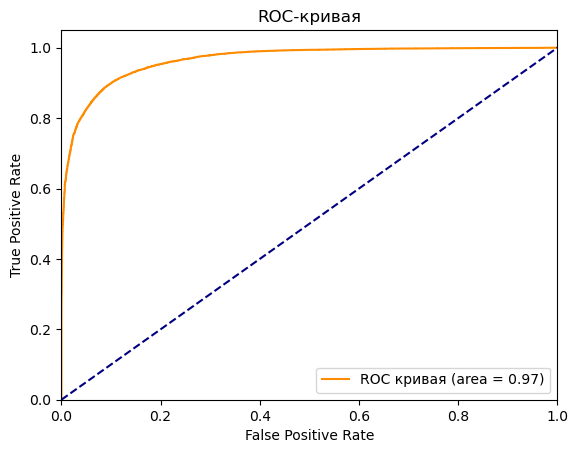

In [73]:
lr_probs = cross_val_predict(best_cbc, X, y.values.ravel(), cv=StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42), method='predict_proba')
lr_probs = lr_probs[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y, lr_probs)
print('ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y, lr_probs)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

# Градиентный бустинг при помощи XGBoost

In [74]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    
    xgbc = xgb.XGBClassifier(**params)
    xgbc.fit(X_train, y_train)

    score = cross_val_score(xgbc, X_train, y_train.values.ravel(), cv=StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42), scoring="accuracy")
    acc_mean = score.mean()

    return acc_mean

#Запуск библиотеки Optuna и подбор гиперпараметров
start = dt.datetime.now()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
end = dt.datetime.now()

print(f'Старт -- Конец подбора параметров {start} -- {end}')

#Создаём модель с лучшими параметрами
best_xgbc = xgb.XGBClassifier(**study.best_params)

best_xgbc.fit(X_train ,y_train.values.ravel())

[I 2023-12-25 20:43:04,585] A new study created in memory with name: no-name-03b25ca8-748f-4fe8-a033-0f1a67277baf
[I 2023-12-25 20:43:06,433] Trial 0 finished with value: 0.8579802720261787 and parameters: {'max_depth': 8, 'learning_rate': 0.3466576601469651, 'n_estimators': 324, 'min_child_weight': 4, 'gamma': 0.957711281658897, 'subsample': 0.013347272359035649, 'colsample_bytree': 0.17101012158458243, 'reg_alpha': 0.5136125227092558, 'reg_lambda': 0.48176932385527693}. Best is trial 0 with value: 0.8579802720261787.
[I 2023-12-25 20:43:09,055] Trial 1 finished with value: 0.8958274096765031 and parameters: {'max_depth': 7, 'learning_rate': 0.716231623826644, 'n_estimators': 479, 'min_child_weight': 1, 'gamma': 0.865880684360275, 'subsample': 0.9402306145942725, 'colsample_bytree': 0.7088017657258944, 'reg_alpha': 0.08694614649043116, 'reg_lambda': 0.58746169925649}. Best is trial 1 with value: 0.8958274096765031.
[I 2023-12-25 20:43:12,093] Trial 2 finished with value: 0.89855078128

[I 2023-12-25 20:43:48,883] Trial 20 finished with value: 0.9023817387110074 and parameters: {'max_depth': 3, 'learning_rate': 0.20048223021649186, 'n_estimators': 273, 'min_child_weight': 7, 'gamma': 0.7366173312933507, 'subsample': 0.8999868855813682, 'colsample_bytree': 0.9030413558619347, 'reg_alpha': 0.008106470133117216, 'reg_lambda': 0.4973877211378573}. Best is trial 13 with value: 0.9049202570798727.
[I 2023-12-25 20:43:51,054] Trial 21 finished with value: 0.9010431103056347 and parameters: {'max_depth': 6, 'learning_rate': 0.20044603896640317, 'n_estimators': 228, 'min_child_weight': 4, 'gamma': 0.7926360760552248, 'subsample': 0.8411262205041948, 'colsample_bytree': 0.9964375125380107, 'reg_alpha': 0.26678760416083047, 'reg_lambda': 0.3701298943630954}. Best is trial 13 with value: 0.9049202570798727.
[I 2023-12-25 20:43:52,557] Trial 22 finished with value: 0.9032586120979879 and parameters: {'max_depth': 5, 'learning_rate': 0.27580181647391655, 'n_estimators': 173, 'min_c

[I 2023-12-25 20:44:47,504] Trial 40 finished with value: 0.9041355813355846 and parameters: {'max_depth': 9, 'learning_rate': 0.018616407025706203, 'n_estimators': 460, 'min_child_weight': 9, 'gamma': 0.9298304959577067, 'subsample': 0.9076533343095882, 'colsample_bytree': 0.8521299641733397, 'reg_alpha': 0.024839263167285443, 'reg_lambda': 0.34986301017091737}. Best is trial 37 with value: 0.9054278819431391.
[I 2023-12-25 20:44:50,723] Trial 41 finished with value: 0.9034432736350846 and parameters: {'max_depth': 6, 'learning_rate': 0.12889989793798068, 'n_estimators': 371, 'min_child_weight': 8, 'gamma': 0.9190656118296864, 'subsample': 0.944237218184898, 'colsample_bytree': 0.9113947478483234, 'reg_alpha': 0.05696881323482872, 'reg_lambda': 0.2781029615632461}. Best is trial 37 with value: 0.9054278819431391.
[I 2023-12-25 20:44:54,201] Trial 42 finished with value: 0.9033971588386356 and parameters: {'max_depth': 8, 'learning_rate': 0.0639620159153627, 'n_estimators': 280, 'min_c

Старт -- Конец подбора параметров 2023-12-25 20:43:04.585689 -- 2023-12-25 20:45:19.712212


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8518211141635834, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.9230594885197947,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15026290401229392,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=405, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

# Тестирование XGBoost

# Проверка на обучающей выборке

Точность модели на обучающей выборке: 0.9317825163851196 



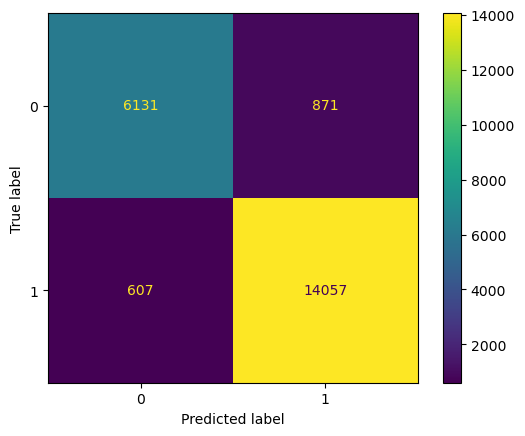

In [75]:
y_pred_train = best_xgbc.predict(X_train)
print("Точность модели на обучающей выборке:", metrics.accuracy_score(y_train, y_pred_train),'\n')
сmm = confusion_matrix(y_train, y_pred_train, labels=best_xgbc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=сmm, display_labels=best_xgbc.classes_)
disp.plot()
plt.show()

ROC AUC=0.983


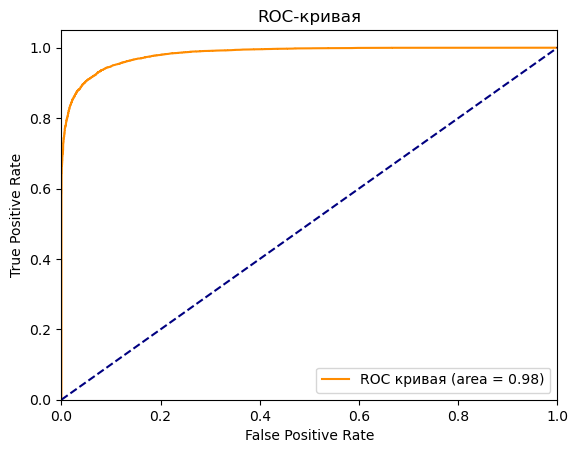

In [76]:
draw_ROC(best_xgbc, X_train, y_train)

# Проверка на тестовой выборке

accuracy в тестовой выборке: 0.9048739961229576
precision в тестовой выборке: 0.9435865760757669
recall в тестовой выборке: 0.9173338670936749
f1 в тестовой выборке: 0.9302750431340708


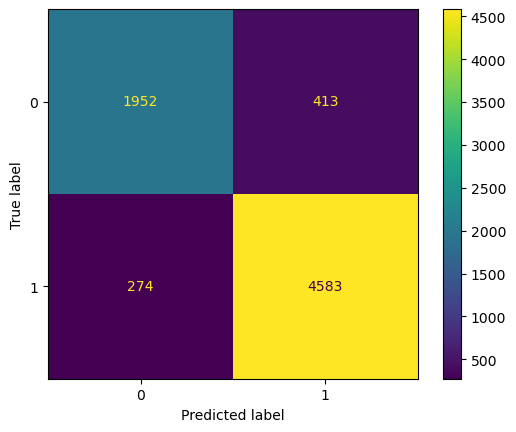

In [77]:
y_pred_test = best_xgbc.predict(X_test)
#print("Точность модели на тестовой выборке:", metrics.accuracy_score(y_test, y_pred_test),'\n')
all_scores_test(y_pred_test, y_test)
сmm = confusion_matrix(y_test, y_pred_test, labels=best_xgbc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=сmm, display_labels=best_xgbc.classes_)
disp.plot()
plt.show()

ROC AUC=0.965


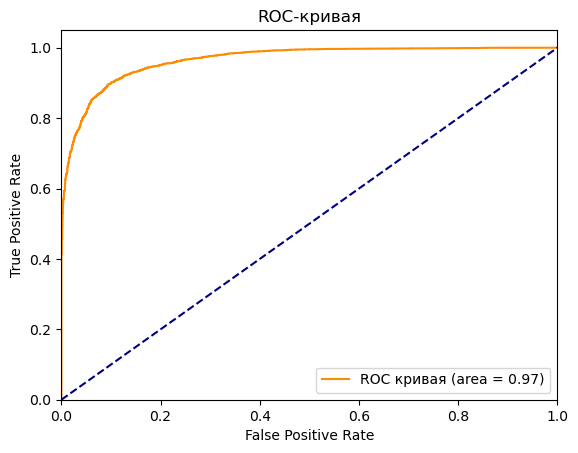

In [78]:
draw_ROC(best_xgbc, X_test, y_test)

# Проверка в кросс-валидации

Средняя accuracy в кросс-валидации: 0.9074700435024822
Средняя precision в кросс-валидации: 0.9232978281886256
Средняя recall в кросс-валидации: 0.9412941051178094
Средняя f1 в кросс-валидации: 0.9321941148170797


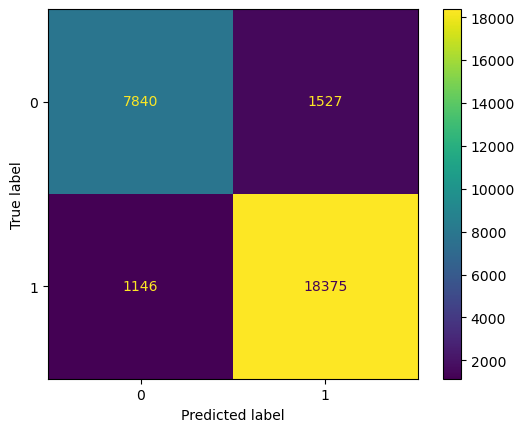

In [79]:
all_cross_val_scores(best_xgbc, X, y)
y_pred = cross_val_predict(best_xgbc, X, y.values.ravel(), cv=StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42))
xgbc_conf_mat = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=xgbc_conf_mat, display_labels=best_xgbc.classes_)
disp.plot()
plt.show()

ROC AUC=0.967


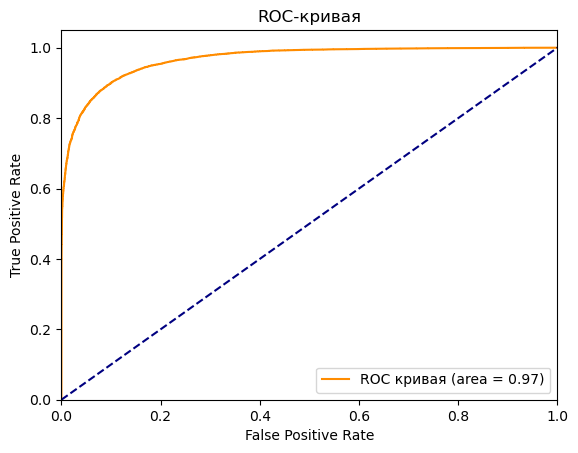

In [80]:
lr_probs = cross_val_predict(best_xgbc, X, y.values.ravel(), cv=StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42), method='predict_proba')
lr_probs = lr_probs[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y, lr_probs)
print('ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y, lr_probs)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

# Логистическая регрессия

In [81]:
def objective(trial):
    params = {
        'C' : trial.suggest_float('C', 1e-5, 1e2),
        'solver' : trial.suggest_categorical('solver', ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag']),
        'penalty' : trial.suggest_categorical('penalty', ['l2', None]),
        'max_iter' : trial.suggest_int('max_iter', 100, 10000)
    }

    
    lr = LogisticRegression(**params)
    lr.fit(X_train, y_train.values.ravel())

    score = cross_val_score(lr, X_train, y_train.values.ravel(), cv=5, scoring="accuracy")
    acc_mean = score.mean()

    return acc_mean

#Запуск библиотеки Optuna и подбор гиперпараметров
start = dt.datetime.now()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
end = dt.datetime.now()

print(f'Старт -- Конец подбора параметров {start} -- {end}')

#Создаём модель с лучшими параметрами
best_lr = LogisticRegression(**study.best_params)

best_lr.fit(X_train ,y_train.values.ravel())

[I 2023-12-25 20:55:46,468] A new study created in memory with name: no-name-4590a8ea-487a-48c0-91a1-5ffc6187c07b
E:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
E:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
E:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
E:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
E:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
E:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: U

KeyboardInterrupt: 

In [82]:
# Код с лучшими параметрами
lr_best_params = {'C': 60.216965273796546, 'solver': 'newton-cg', 'penalty': None, 'max_iter': 7377}
best_lr = LogisticRegression(**lr_best_params)
best_lr.fit(X_train ,y_train.values.ravel())

E:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
E:\Anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
E:\Anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
E:\Anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


LogisticRegression(C=60.216965273796546, max_iter=7377, penalty=None,
                   solver='newton-cg')

# Проверка на обучающей выборке

Точность модели на обучающей выборке: 0.8446413735807256 



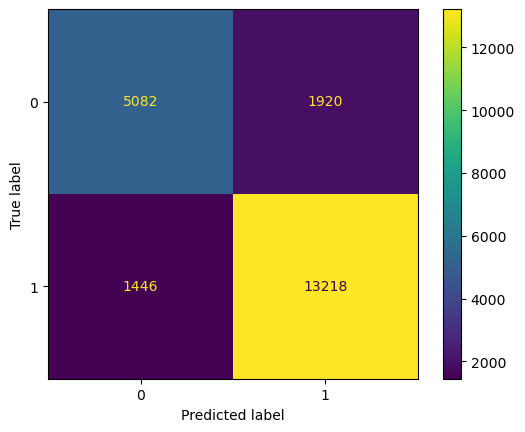

In [83]:
y_pred_train = best_lr.predict(X_train)
print("Точность модели на обучающей выборке:", metrics.accuracy_score(y_train, y_pred_train),'\n')
сmm = confusion_matrix(y_train, y_pred_train, labels=best_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=сmm, display_labels=best_lr.classes_)
disp.plot()
plt.show()

ROC AUC=0.911


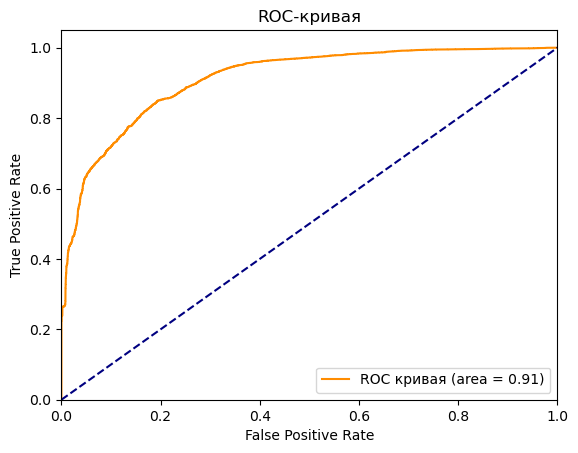

In [84]:
draw_ROC(best_lr, X_train, y_train)

# Проверка на тестовой выборке

accuracy в тестовой выборке: 0.8370257546386043
precision в тестовой выборке: 0.9011735639283508
recall в тестовой выборке: 0.8626330311391407
f1 в тестовой выборке: 0.881482227368845


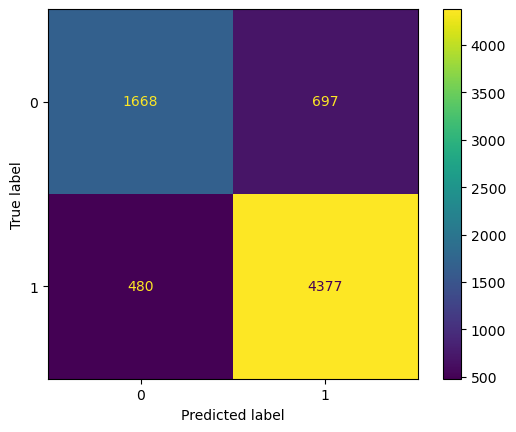

In [85]:
y_pred_test = best_lr.predict(X_test)
#print("Точность модели на тестовой выборке:", metrics.accuracy_score(y_test, y_pred_test),'\n')
all_scores_test(y_pred_test, y_test)
сmm = confusion_matrix(y_test, y_pred_test, labels=best_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=сmm, display_labels=best_lr.classes_)
disp.plot()
plt.show()

ROC AUC=0.903


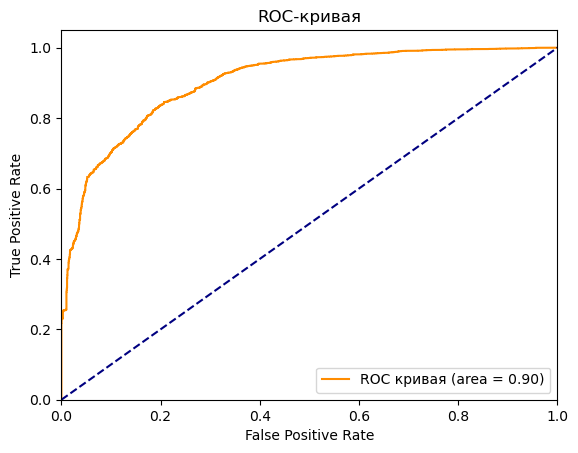

In [86]:
draw_ROC(best_lr, X_test, y_test)

# Проверка в кросс-валидации

E:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
E:\Anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
E:\Anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
E:\Anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
E:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio pa

Средняя accuracy в кросс-валидации: 0.8422524807537235


E:\Anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
E:\Anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
E:\Anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
E:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
E:\Anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('Th

Средняя precision в кросс-валидации: 0.8703858681591419


E:\Anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
E:\Anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
E:\Anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
E:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
E:\Anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('Th

Средняя recall в кросс-валидации: 0.9007223281962178


E:\Anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
E:\Anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
E:\Anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
E:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
E:\Anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('Th

Средняя f1 в кросс-валидации: 0.8852800969656212


E:\Anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
E:\Anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
E:\Anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
E:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
E:\Anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('Th

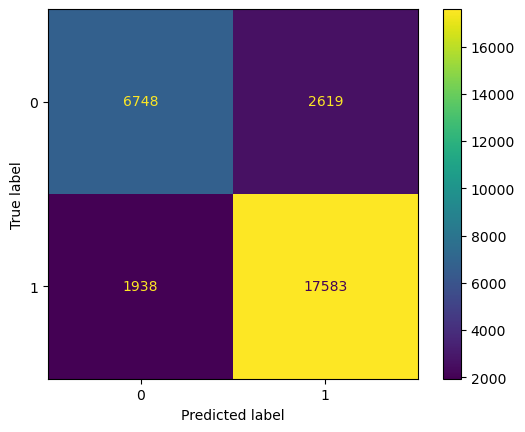

In [87]:
all_cross_val_scores(best_lr, X, y)
y_pred = cross_val_predict(best_lr, X, y.values.ravel(), cv=StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42))
xgbc_conf_mat = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=xgbc_conf_mat, display_labels=best_lr.classes_)
disp.plot()
plt.show()

E:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
E:\Anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
E:\Anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
E:\Anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
E:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio pa

ROC AUC=0.909


E:\Anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


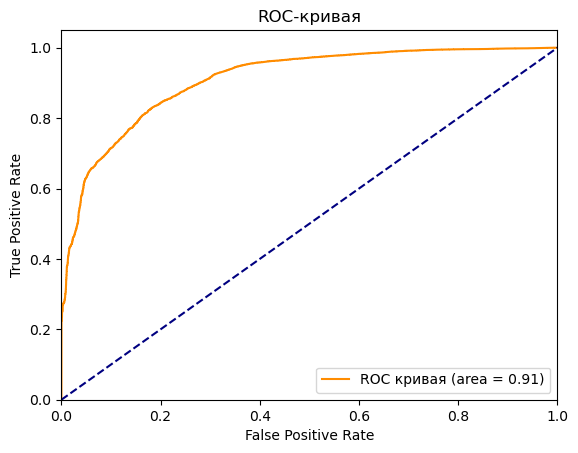

In [88]:
lr_probs = cross_val_predict(best_lr, X, y.values.ravel(), cv=StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42), method='predict_proba')
lr_probs = lr_probs[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y, lr_probs)
print('ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y, lr_probs)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

# AutoML (Baseline модель)

In [98]:
automl_model = TPOTClassifier(generations=10, population_size=20, cv=5, random_state=42, verbosity=2)
automl_model.fit(X_train, y_train.values.ravel())

Optimization Progress:   0%|          | 0/220 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9006738937321259

Generation 2 - Current best internal CV score: 0.9016892499593434

Generation 3 - Current best internal CV score: 0.9021507493760923

Generation 4 - Current best internal CV score: 0.9021507493760923

Generation 5 - Current best internal CV score: 0.9021507493760923

Generation 6 - Current best internal CV score: 0.9021507493760923

Generation 7 - Current best internal CV score: 0.9021507493760923

Generation 8 - Current best internal CV score: 0.9027507209830098

Generation 9 - Current best internal CV score: 0.9027507209830098

Generation 10 - Current best internal CV score: 0.9027507209830098

Best pipeline: XGBClassifier(input_matrix, learning_rate=0.1, max_depth=10, min_child_weight=4, n_estimators=100, n_jobs=1, subsample=1.0, verbosity=0)


TPOTClassifier(generations=10, population_size=20, random_state=42, verbosity=2)

In [99]:
automl_model.predict(X_test)

array([1, 0, 0, ..., 1, 1, 1])

In [100]:
print(automl_model.score(AML_X, y_test.values.ravel()))

NameError: name 'AML_X' is not defined

In [101]:
pickle.dump(automl_model.fitted_pipeline_, open('tpot_model.pkl', "wb"))

In [102]:
pipeline = pickle.load(open('tpot_model.pkl', "rb"))

# Проверка на обучающей выборке

Точность модели на обучающей выборке: 0.9379211668051325 



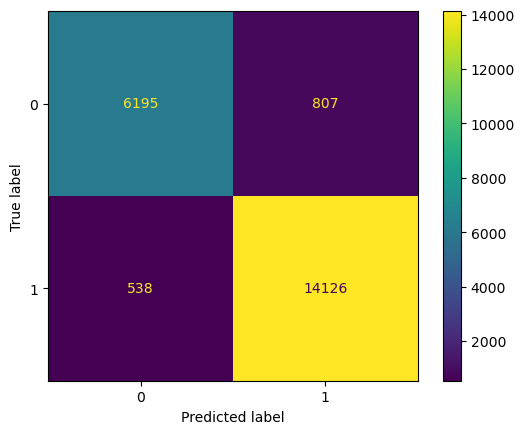

In [103]:
y_pred_train = pipeline.predict(X_train)
print("Точность модели на обучающей выборке:", metrics.accuracy_score(y_train, y_pred_train),'\n')
сmm = confusion_matrix(y_train, y_pred_train, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=сmm, display_labels=pipeline.classes_)
disp.plot()
plt.show()

ROC AUC=0.986


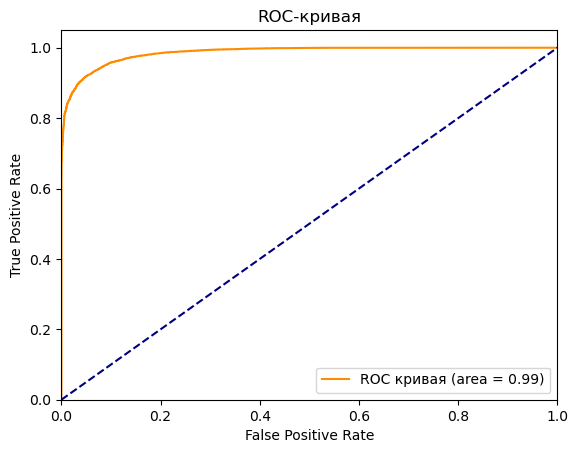

In [104]:
draw_ROC(pipeline, X_train, y_train)

# Проверка на тестовой выборке

accuracy в тестовой выборке: 0.9052893935198006
precision в тестовой выборке: 0.9450277949351451
recall в тестовой выборке: 0.9167165967645297
f1 в тестовой выборке: 0.9306569343065693


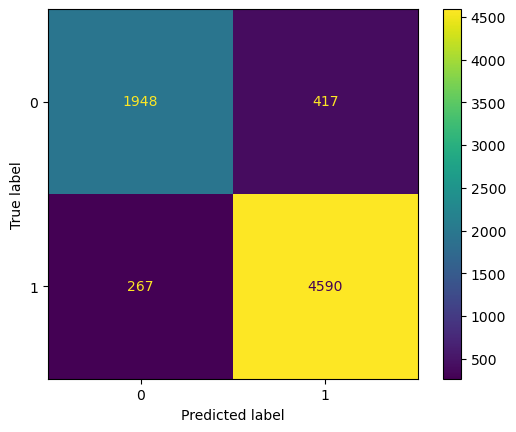

In [105]:
y_pred_test = pipeline.predict(X_test)
#print("Точность модели на тестовой выборке:", metrics.accuracy_score(y_test, y_pred_test),'\n')
all_scores_test(y_pred_test, y_test)
сmm = confusion_matrix(y_test, y_pred_test, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=сmm, display_labels=pipeline.classes_)
disp.plot()
plt.show()

ROC AUC=0.966


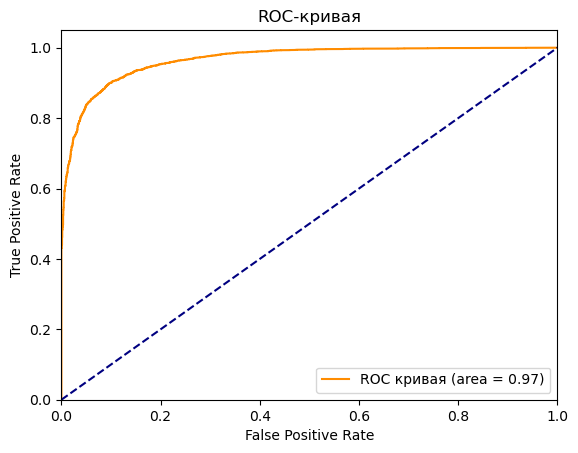

In [106]:
draw_ROC(pipeline, X_test, y_test)

# Проверка в кросс-валидации

Средняя accuracy в кросс-валидации: 0.9060852296752703
Средняя precision в кросс-валидации: 0.9225003101978559
Средняя recall в кросс-валидации: 0.9400134723376394
Средняя f1 в кросс-валидации: 0.9311629821076186


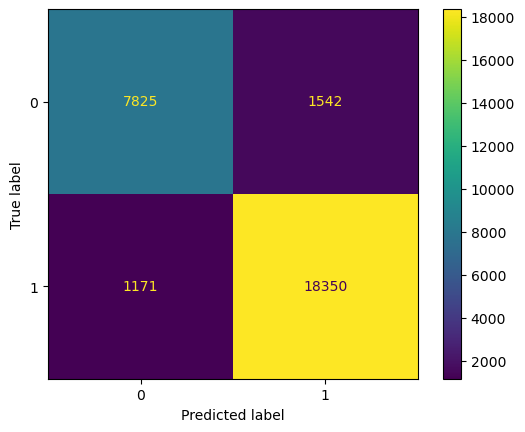

In [107]:
all_cross_val_scores(pipeline, X, y)
y_pred = cross_val_predict(pipeline, X, y.values.ravel(), cv=StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42))
conf_mat = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=pipeline.classes_)
disp.plot()
plt.show()

ROC AUC=0.967


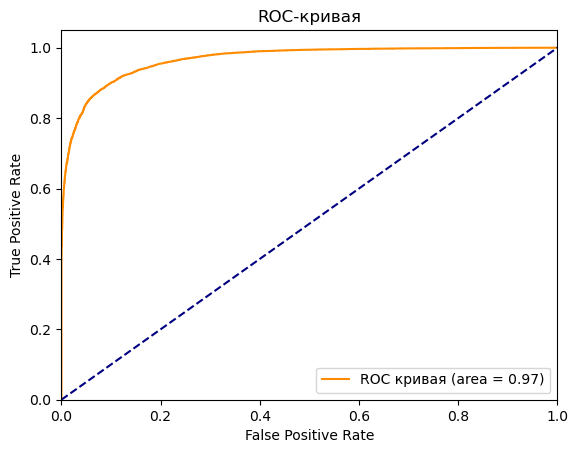

In [108]:
lr_probs = cross_val_predict(pipeline, X, y.values.ravel(), cv=StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42), method='predict_proba')
lr_probs = lr_probs[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y, lr_probs)
print('ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y, lr_probs)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

# Naive Bayes

In [109]:
nb_classifier = GaussianNB()
params_NB = {'var_smoothing': np.logspace(1e-11, 1)}
gs_NB = GridSearchCV(estimator=nb_classifier,
                 param_grid=params_NB,
                 cv=StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42),   # use any cross validation technique
                 verbose=1,
                 scoring='accuracy')
gs_NB.fit(X_train, y_train.values.ravel())
print(gs_NB.best_params_)
print(gs_NB.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'var_smoothing': 1.0985411420118207}
0.729760870817758


In [110]:
best_NB = dtc_gs.best_estimator_

Точность модели на обучающей выборке: 0.8947198375334625 



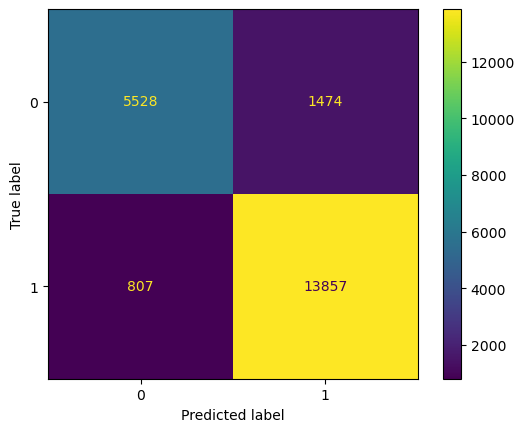

In [111]:
y_pred_train = best_NB.predict(X_train)
print("Точность модели на обучающей выборке:", metrics.accuracy_score(y_train, y_pred_train),'\n')
сmm = confusion_matrix(y_train, y_pred_train, labels=best_NB.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=сmm, display_labels=best_NB.classes_)
disp.plot()
plt.show()

ROC AUC=0.952


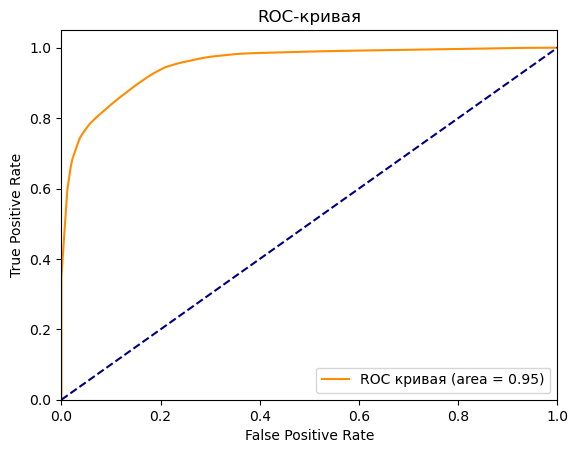

In [112]:
draw_ROC(best_NB, X_train, y_train)

accuracy в тестовой выборке: 0.8810578787039601
precision в тестовой выборке: 0.9382334774552192
recall в тестовой выборке: 0.8907349491790462
f1 в тестовой выборке: 0.9138674420936529


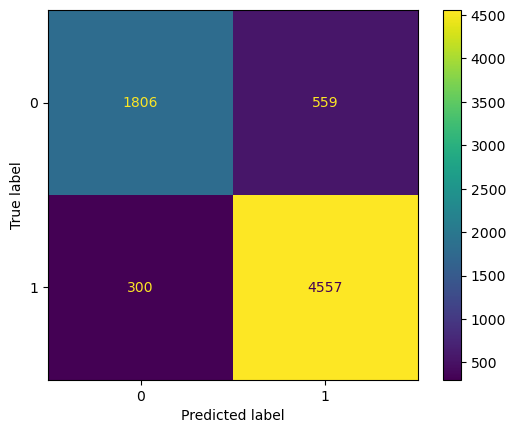

In [113]:
y_pred_test = best_NB.predict(X_test)
#print("Точность модели на обучающей выборке:", metrics.accuracy_score(y_test, y_pred_test),'\n')
all_scores_test(y_pred_test, y_test)
сmm = confusion_matrix(y_test, y_pred_test, labels=best_NB.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=сmm, display_labels=best_NB.classes_)
disp.plot()
plt.show()

ROC AUC=0.944


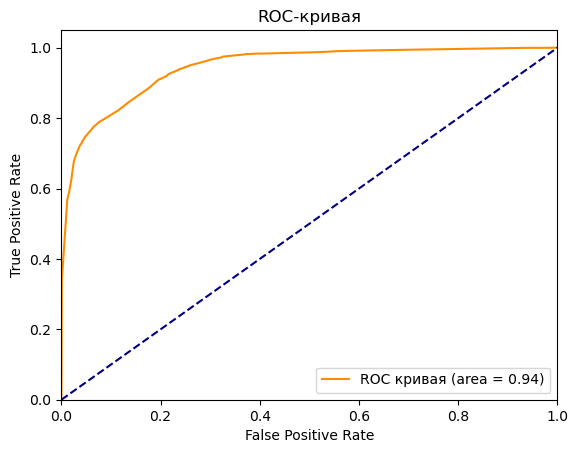

In [114]:
draw_ROC(best_NB, X_test, y_test)

Средняя accuracy в кросс-валидации: 0.8834808146096236
Средняя precision в кросс-валидации: 0.9049907988917608
Средняя recall в кросс-валидации: 0.9247989117205142
Средняя f1 в кросс-валидации: 0.9146781457590478


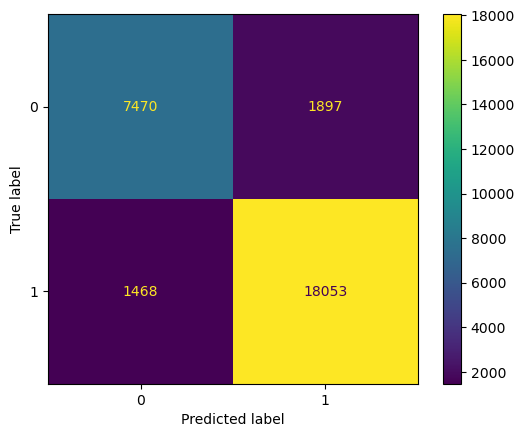

In [115]:
all_cross_val_scores(best_NB, X, y)
y_pred = cross_val_predict(best_NB, X, y.values.ravel(), cv=StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42))
nb_conf_mat = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=nb_conf_mat, display_labels=best_NB.classes_)
disp.plot()
plt.show()

ROC AUC=0.949


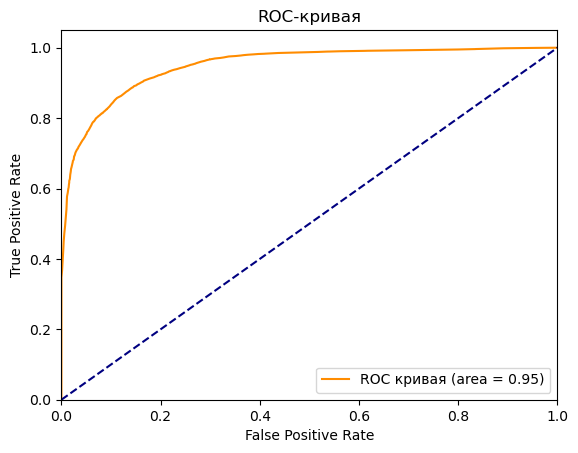

In [116]:
lr_probs = cross_val_predict(best_NB, X, y.values.ravel(), cv=StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42), method='predict_proba')
lr_probs = lr_probs[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y, lr_probs)
print('ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y, lr_probs)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

# KNN

In [117]:
def objective(trial):
    params = {
        'leaf_size': trial.suggest_int('leaf_size', 20, 40),
        'p' : trial.suggest_float('p', 1, 2),
        'n_neighbors' : trial.suggest_int('n_neighbors', 1, 30),
        'weights' : trial.suggest_categorical('weights', ['uniform', 'distance']),
        'metric' : trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    }

    
    knn = KNeighborsClassifier(**params)
    knn.fit(X_train, y_train.values.ravel())

    score = cross_val_score(knn, X_train, y_train.values.ravel(), cv=StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42), scoring="accuracy")
    acc_mean = score.mean()
    
    # При подборе гиперпараметров у меня всегда получается один и тот же score = 0.7289089736342437
    # Поэтому я оставил количество итераций 2

    return acc_mean


start = dt.datetime.now()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
end = dt.datetime.now()

print(f'Старт -- Конец подбора параметров {start} -- {end}')


best_knn = KNeighborsClassifier(**study.best_params)

best_knn.fit(X_train ,y_train.values.ravel())

[I 2023-12-25 22:51:03,844] A new study created in memory with name: no-name-ccdce1aa-6daa-438d-b024-e26712a246b4
E:\Anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\Anaconda\Lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "E:\Anaconda\Lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "E:\Anaconda\Lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "E:\Anaconda\Lib\site-packages\sklearn\utils\_response.py", line 85, in _get_response_values
    y_pred = prediction_method(X)
             ^^^^^^^^^

[W 2023-12-25 22:51:03,997] Trial 0 failed with value nan.
E:\Anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\Anaconda\Lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "E:\Anaconda\Lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "E:\Anaconda\Lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "E:\Anaconda\Lib\site-packages\sklearn\utils\_response.py", line 85, in _get_response_values
    y_pred = prediction_method(X)
             ^^^^^^^^^^^^^^^^^^^^
  File "E:\Anaconda\Lib\site-packages\sklea

[W 2023-12-25 22:51:04,035] Trial 1 failed with value nan.
[I 2023-12-25 22:51:05,665] Trial 2 finished with value: 0.870165377458129 and parameters: {'leaf_size': 26, 'p': 1.1981713897648536, 'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 2 with value: 0.870165377458129.
E:\Anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\Anaconda\Lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "E:\Anaconda\Lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "E:\Anaconda\Lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  

[W 2023-12-25 22:51:05,711] Trial 3 failed with value nan.
[I 2023-12-25 22:51:06,455] Trial 4 finished with value: 0.860103586825908 and parameters: {'leaf_size': 20, 'p': 1.2341023926514474, 'n_neighbors': 26, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 2 with value: 0.870165377458129.
[I 2023-12-25 22:51:07,093] Trial 5 finished with value: 0.8590880282473895 and parameters: {'leaf_size': 21, 'p': 1.4906876706283794, 'n_neighbors': 8, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 2 with value: 0.870165377458129.
[W 2023-12-25 22:51:11,999] Trial 6 failed with parameters: {'leaf_size': 33, 'p': 1.7082834337956923, 'n_neighbors': 27, 'weights': 'distance', 'metric': 'minkowski'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "E:\Anaconda\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\patap\AppData\Lo

KeyboardInterrupt: 

In [119]:
# Код чтобы не ждать подбор параметров
best_knn_params = {'leaf_size': 34, 'p': 1.0960993520654736, 'n_neighbors': 6, 'weights': 'distance', 'metric': 'minkowski'}
best_knn = KNeighborsClassifier(**best_knn_params)
best_knn.fit(X_train ,y_train.values.ravel())

KNeighborsClassifier(leaf_size=34, n_neighbors=6, p=1.0960993520654736,
                     weights='distance')

Точность модели на обучающей выборке: 0.9985230314778917 



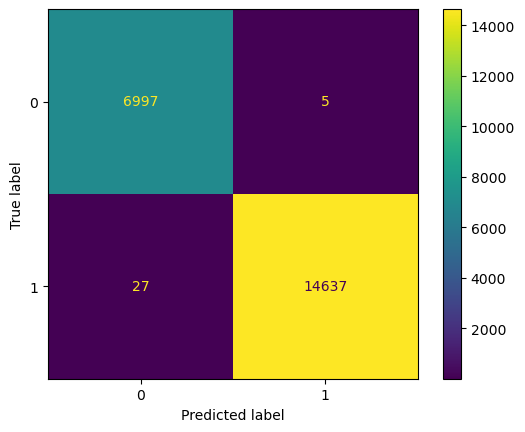

In [120]:
y_pred_train = best_knn.predict(X_train)
print("Точность модели на обучающей выборке:", metrics.accuracy_score(y_train, y_pred_train),'\n')
сmm = confusion_matrix(y_train, y_pred_train, labels=best_knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=сmm, display_labels=best_knn.classes_)
disp.plot()
plt.show()

ROC AUC=1.000


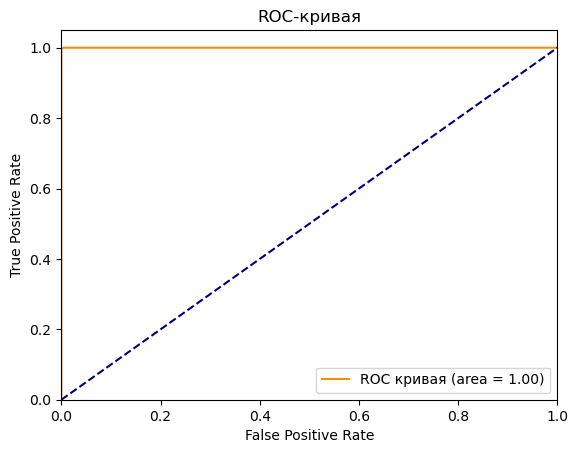

In [121]:
draw_ROC(best_knn, X_train, y_train)

accuracy в тестовой выборке: 0.8630573248407644
precision в тестовой выборке: 0.9081737698167593
recall в тестовой выборке: 0.8903916027452563
f1 в тестовой выборке: 0.8991947813678524


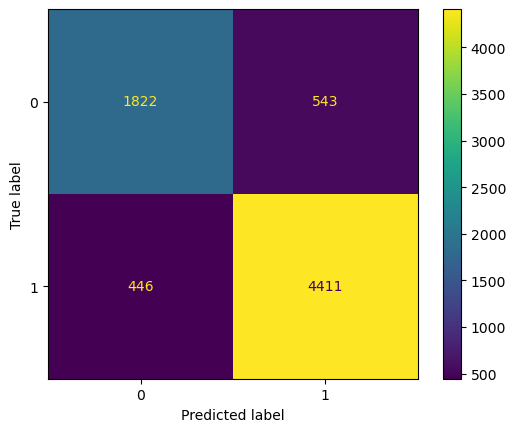

In [122]:
y_pred_test = best_knn.predict(X_test)
#print("Точность модели на тестовой выборке:", metrics.accuracy_score(y_test, y_pred_test),'\n')
all_scores_test(y_pred_test, y_test)
сmm = confusion_matrix(y_test, y_pred_test, labels=best_knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=сmm, display_labels=best_knn.classes_)
disp.plot()
plt.show()

ROC AUC=0.918


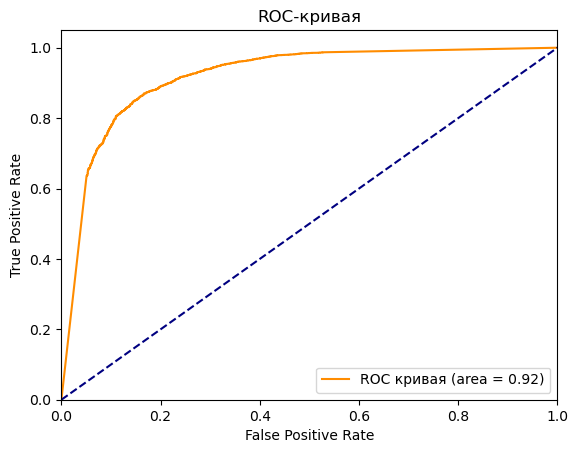

In [123]:
draw_ROC(best_knn, X_test, y_test)

Средняя accuracy в кросс-валидации: 0.867938109880922
Средняя precision в кросс-валидации: 0.8991639460457682
Средняя recall в кросс-валидации: 0.906203308487153
Средняя f1 в кросс-валидации: 0.9026531396927447


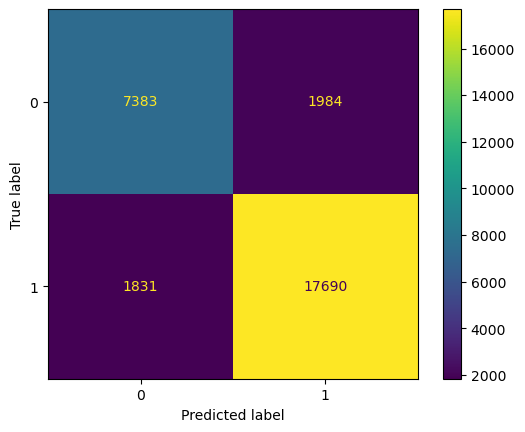

In [124]:
all_cross_val_scores(best_knn, X, y)
y_pred = cross_val_predict(best_knn, X, y.values.ravel(), cv=StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42))
nb_conf_mat = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=nb_conf_mat, display_labels=best_knn.classes_)
disp.plot()
plt.show()

ROC AUC=0.924


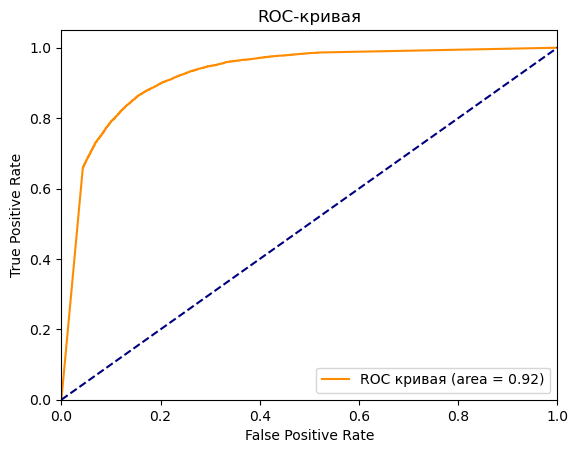

In [125]:
lr_probs = cross_val_predict(best_knn, X, y.values.ravel(), cv=StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42), method='predict_proba')
lr_probs = lr_probs[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y, lr_probs)
print('ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y, lr_probs)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

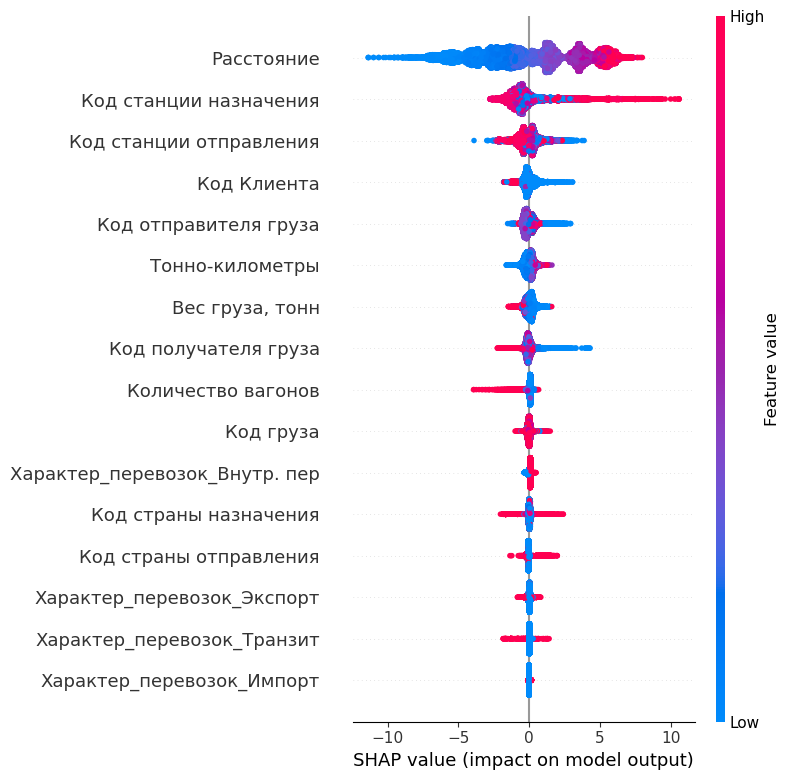

In [126]:
# Create object that can calculate shap values
explainer = TreeExplainer(best_cbc)
shap_values = explainer(X)
# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
#shap_values_cbc = explainer.shap_values(X)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values)

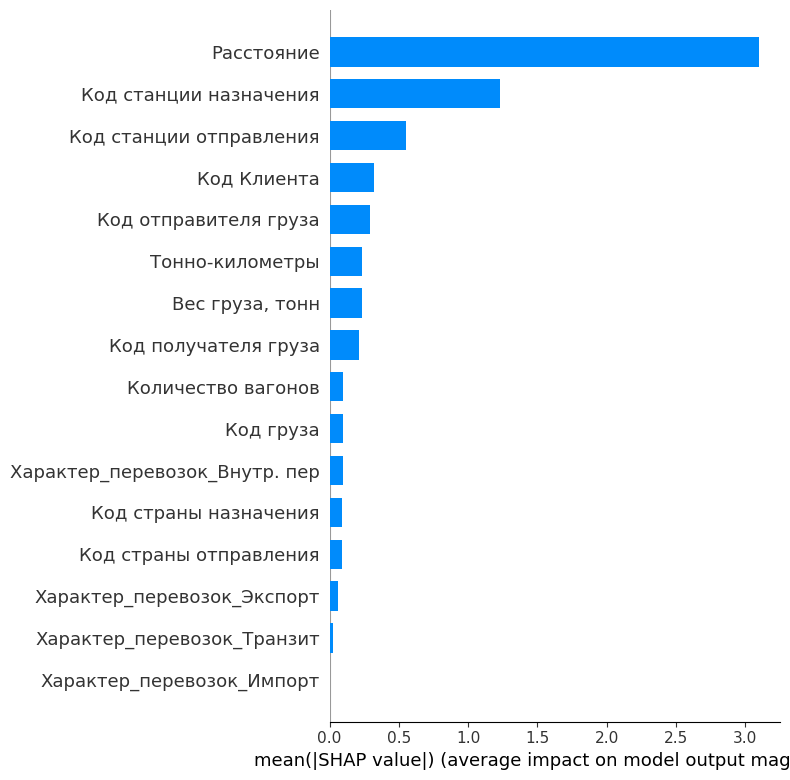

In [127]:
shap.summary_plot(shap_values, plot_type="bar")

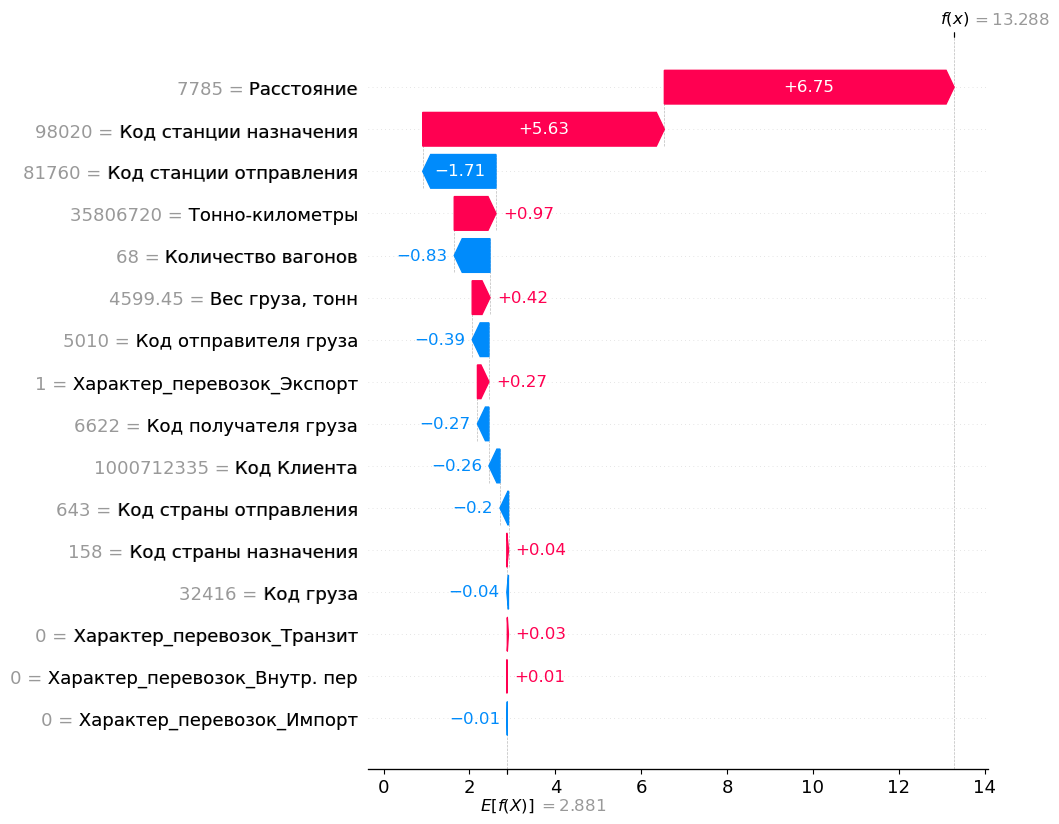

Предсказанный класс: 1


In [128]:
idx = X['Тонно-километры'].idxmax()
shap.plots.waterfall(shap_values[idx], max_display=17)
print(f"Предсказанный класс: {y['Доставка > 3 дней'].loc[idx]}")

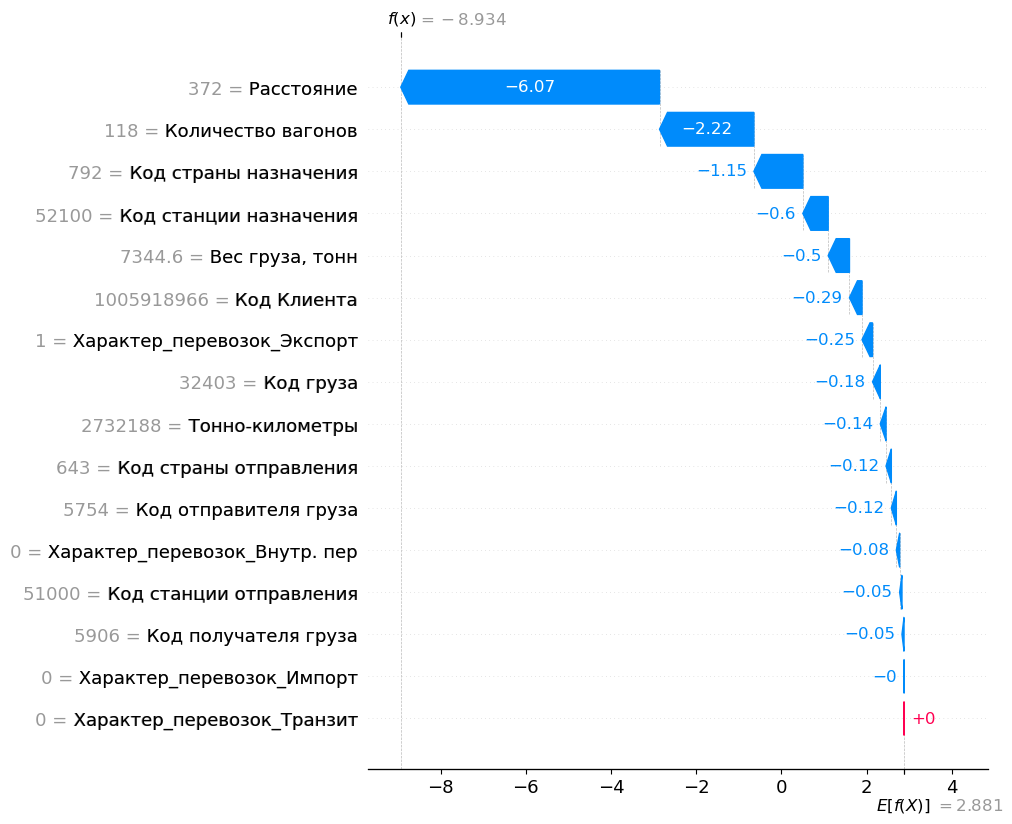

Предсказанный класс: 0


In [129]:
idx = X['Количество вагонов'].idxmax()
shap.plots.waterfall(shap_values[idx], max_display=17)
print(f"Предсказанный класс: {y['Доставка > 3 дней'].loc[idx]}")

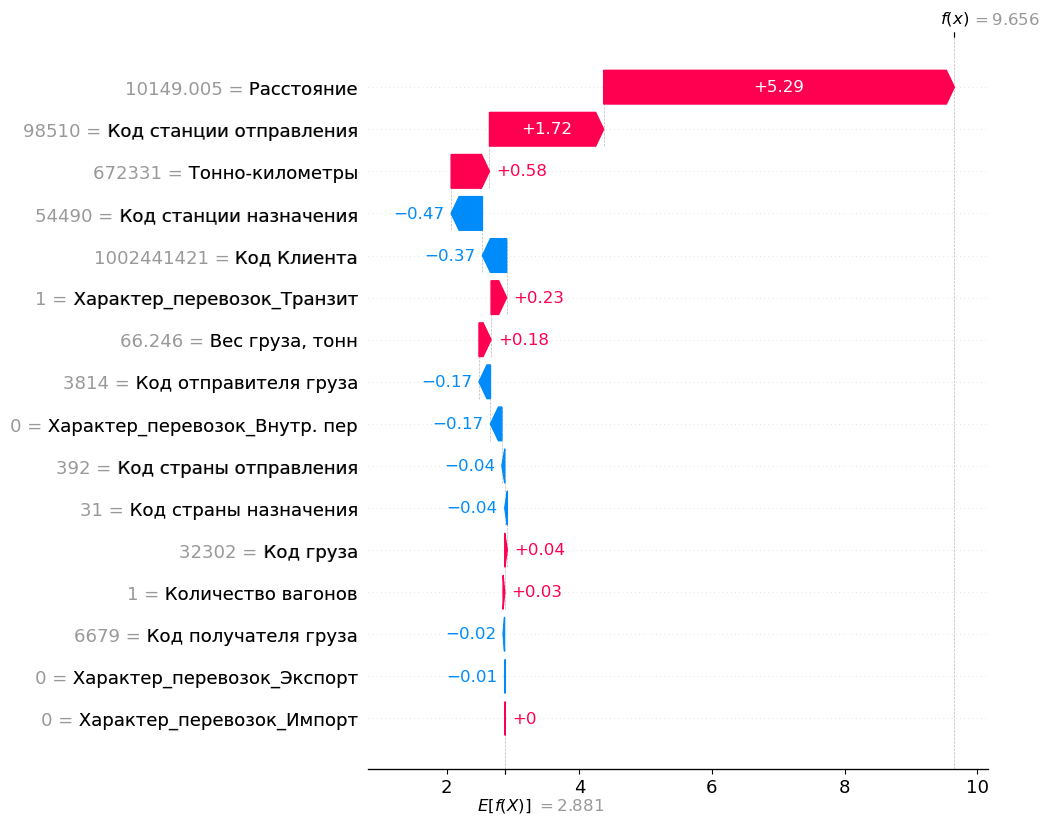

Предсказанный класс: 1


In [130]:
idx = X['Расстояние'].idxmax()
shap.plots.waterfall(shap_values[idx], max_display=17)
print(f"Предсказанный класс: {y['Доставка > 3 дней'].loc[idx]}")